In [4]:
import torch
import torch.nn as nn

from functools import partial
from dataclasses import dataclass
from collections import OrderedDict

In [5]:
class Conv2dAuto(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.padding =  (self.kernel_size[0] // 2, self.kernel_size[1] // 2) # dynamic add padding based on the kernel_size
        
conv3x3 = partial(Conv2dAuto, kernel_size=3, bias=False)

In [6]:
conv = conv3x3(in_channels=32, out_channels=64)
print(conv)
del conv

Conv2dAuto(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


# ResNet18

In [7]:
class BasicBlock(nn.Module):
    def __init__(self, InChannel, OutChannel, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(InChannel, OutChannel, kernel_size=3, stride=stride, bias=False, padding=1)
        self.bn1 = nn.BatchNorm2d(OutChannel)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(OutChannel, OutChannel, kernel_size=3, bias=False, padding=1)
        self.bn2 = nn.BatchNorm2d(OutChannel)
        self.downsample = downsample
        self.stride = stride
    
    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.conv2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity # Resnet 's essence
        out = self.relu1(out)
        
        return out

    
    
    

In [8]:
import torch.nn.functional as F

class ResNet(nn.Module):
    def __init__(self, Basicblock, block_nums, num_classes=10):
        # layers: a list like [2, 3, 4, 5], the number of internal and out channel
        super(ResNet, self).__init__()
        
        self.inplanes = 64
        self.dilation = 1
    
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
#         self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # Bacisblock__init__(self, InChannal, OutChannel, stride=1, downsample=None):
        self.layer1 = self._make_layer(Basicblock,  64, block_num=block_nums[0], stride=1)
        self.layer2 = self._make_layer(Basicblock, 128, block_num=block_nums[1], stride=2)
        self.layer3 = self._make_layer(Basicblock, 256, block_num=block_nums[2], stride=2)
        self.layer4 = self._make_layer(Basicblock, 512, block_num=block_nums[3], stride=2)
        
#         self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
#         self.avgpool = F.avg_pool2d(out, 4)
        self.fc = nn.Linear(512, num_classes)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
        for m in self.modules():
            if isinstance(m, BasicBlock):
                nn.init.constant_(m.bn2.weight, 0)
        

    def _make_layer(self, Basicblock, planes, block_num, stride=1):
        
        downsample = None

        # chanage channel size
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

        # initial layers
        layers = []
        # 1. original lyaer, downsamle firstly.
        layers.append(Basicblock(self.inplanes, planes, stride, downsample))
        self.inplanes = planes

        # 2. add layer
        for i in range(1, block_num):
            layers.append(Basicblock(self.inplanes, planes))

        return nn.Sequential(*layers)        
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
#         x = self.maxpool(x)
        
        out1 = self.layer1(x)
        out2 = self.layer2(out1)
        out3 = self.layer3(out2)
        out4 = self.layer4(out3)
        
#         x = F.avg_pool2d(x, 4)
        
#         x = torch.flatten(x, 1)
#         x = self.fc(x)
        
        return out1, out2, out3, out4


def _resnet(block, block_nums, **kwargs):
    model = ResNet(block, block_nums, **kwargs)
    return model

def resnet18():
    return _resnet(BasicBlock, [2, 2, 2, 2])

def resnet34():
    return _resnet(BasicBlock, [3, 4, 6, 3])

model = resnet18()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fa

<class 'PIL.PngImagePlugin.PngImageFile'>


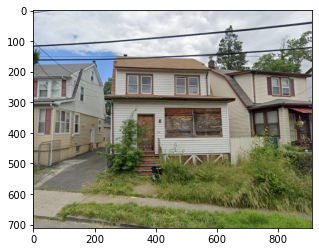

In [19]:
import torch
from torch.autograd import Variable
import torch.nn
from PIL import Image
from torchvision.transforms import ToTensor, ToPILImage
import numpy as np
import io
import os
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor, ToPILImage, transforms

file = r'C:\Users\N\Pictures\Untitled picture.png'

image = Image.open(file)
plt.imshow(image)

print(type(image))

image = ToTensor()(image).unsqueeze(0) 
    
# img = np.fromarray(img)


plt.show()
C2, C3, C4, C5 = model(image)


In [20]:
print(C2.shape)
print(C3.shape)
print(C4.shape)
print(C5.shape)

torch.Size([1, 64, 711, 911])
torch.Size([1, 128, 356, 456])
torch.Size([1, 256, 178, 228])
torch.Size([1, 512, 89, 114])


# FPN

In [30]:
class FPN(nn.Module):
    super(FPN, self).__init__()

upsample = torch.nn.Upsample(scale_factor=2, mode='nearest')

_, _, H, W = C4.size()

P5 = nn.Conv2d()

P5 = F.upsample(C5, size=(H, W), mode='bilinear') 



print(C5.shape)

print(P5.size())
print(P5.shape)

torch.Size([1, 512, 89, 114])
torch.Size([1, 512, 178, 228])
torch.Size([1, 512, 178, 228])


# CIFAR10 test

In [7]:
import torch
import torchvision
import torchvision.transforms as transforms

In [8]:
transform = transforms.Compose([transforms.ToTensor(), 
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                               transforms.RandomHorizontalFlip(),
                               transforms.RandomCrop(32, padding=4),])

 
# 准备数据集并预处理
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  #先四周填充0，在吧图像随机裁剪成32*32
    transforms.RandomHorizontalFlip(),  #图像一半的概率翻转，一半的概率不翻转
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), #R,G,B每层的归一化用到的均值和方差
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [20]:
import matplotlib.pyplot as plt
import numpy as np

batch_size = 128
BATCH_SIZE = 128

trainset = torchvision.datasets.CIFAR10(root='data', train=True, download=True, transform=transform_train)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='data', train=False, download=True, transform=transform_test)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)


trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train) #训练数据集
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)   #生成一个个batch进行批训练，组成batch的时候顺序打乱取

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# def imshow(img):
#     img = img /2 + 0.5
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.show()
    
# dataiter = iter(trainloader)
# images, labels = dataiter.next()

# imshow(torchvision.utils.make_grid(images))

# print(" ".join("%5s" % classes[labels[j]] for j in range(batch_size)))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

print(device)



cuda:0


In [22]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

model = ResNet18()
model.to(device)

# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience= 10)

batch_interval = 10

import torch.nn.functional as F

for epoch in range(20):
    
    model.train()
    
    running_loss = 0.0
    
    total = 0.0
    correct = 0.0
        
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        
#         scheduler.step(loss)
        optimizer.step()
        
        running_loss =+ loss.item()

        
        if i% batch_interval == batch_interval - 1:
            
            _, predict = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += predict.eq(labels.data).cpu().sum()
            
            print("total, correct: ", total, correct)
            
            print("[%d, %5d] loss: %.6f | Acc. %.5f%%" % (epoch + 1, i + 1, running_loss /batch_interval, 100. * correct / total))
            running_loss = 0.0
            
            
            
            
            
print("Finished Training")
        
PAT = "cifar_resnet.pth"
torch.save(model.state_dict(), PATH)


    

total, correct:  128.0 tensor(13.)
[1,    10] loss: 0.244256 | Acc. 10.15625%
total, correct:  256.0 tensor(28.)
[1,    20] loss: 0.242975 | Acc. 10.93750%
total, correct:  384.0 tensor(48.)
[1,    30] loss: 0.234124 | Acc. 12.50000%
total, correct:  512.0 tensor(62.)
[1,    40] loss: 0.241121 | Acc. 12.10938%
total, correct:  640.0 tensor(70.)
[1,    50] loss: 0.252386 | Acc. 10.93750%
total, correct:  768.0 tensor(86.)
[1,    60] loss: 0.244424 | Acc. 11.19792%
total, correct:  896.0 tensor(98.)
[1,    70] loss: 0.248043 | Acc. 10.93750%
total, correct:  1024.0 tensor(108.)
[1,    80] loss: 0.250090 | Acc. 10.54688%
total, correct:  1152.0 tensor(119.)
[1,    90] loss: 0.247590 | Acc. 10.32986%
total, correct:  1280.0 tensor(134.)
[1,   100] loss: 0.245688 | Acc. 10.46875%
total, correct:  1408.0 tensor(145.)
[1,   110] loss: 0.248363 | Acc. 10.29830%
total, correct:  1536.0 tensor(155.)
[1,   120] loss: 0.246599 | Acc. 10.09115%
total, correct:  1664.0 tensor(177.)
[1,   130] loss: 

KeyboardInterrupt: 

In [ ]:
PATH = "cifar_resnet.pth"
torch.save(model.state_dict(), PATH)

In [ ]:
net =  resnet18()
PATH = "cifar_resnet.pth"
net.load_state_dict(torch.load(PATH))
print(net)

In [18]:
from torchvision.transforms import ToTensor, ToPILImage

trainloader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=True, num_workers=1)

dataiter = iter(trainloader)
images, labels = dataiter.next()

inputs, labels = images[0].to(device), labels[0].to(device)

net = net.to(device)

input = inputs.unsqueeze(0) 

net.eval()

outputs = net(input)
print(outputs)

outputs = torch.nn.functional.softmax(outputs)

print(outputs)

imshow(torchvision.utils.make_grid(images[0]))

print(np.argmax(outputs.cpu().detach()))

class_idx = np.argmax(outputs.cpu().detach().numpy())

print("class_idx: ", class_idx)

print(" ".join("%5s" % classes[class_idx] for j in range(1)))

tensor([[-2.2773, -2.0678,  1.8716,  0.1374, -1.8866, -2.2030, 11.6085, -1.2859,
         -1.9386, -1.9627]], device='cuda:0', grad_fn=<AddmmBackward>)


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([[9.3205e-07, 1.1493e-06, 5.9055e-05, 1.0426e-05, 1.3775e-06, 1.0039e-06,
         9.9992e-01, 2.5117e-06, 1.3077e-06, 1.2765e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


NameError: name 'imshow' is not defined

In [ ]:
dataiter = iter(testloader)


In [ ]:
images, labels =dataiter.next()

net = net.to(device)


imshow(torchvision.utils.make_grid(images))
print("ground truch: ", " ".join("%5s" % classes[labels[j]] for j in range(batch_size)))
images = images.to(device)
outputs = net(images)

_, predicted = torch.max(outputs, 1)
print("Predicted :   ", ' '.join("%5s" % classes[predicted[j]] for j in range(batch_size)))

In [11]:
'''ResNet-18 Image classfication for cifar-10 with PyTorch 

Author 'Sun-qian'.

'''
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):
        super(ResidualBlock, self).__init__()
        self.left = nn.Sequential(
            nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(outchannel)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or inchannel != outchannel:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outchannel)
            )

    def forward(self, x):
        out = self.left(x)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, ResidualBlock, num_classes=10):
        super(ResNet, self).__init__()
        self.inchannel = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.layer1 = self.make_layer(ResidualBlock, 64,  2, stride=1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride=2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride=2)
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride=2)
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, block, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)   #strides=[1,1]
        layers = []
        for stride in strides:
            layers.append(block(self.inchannel, channels, stride))
            self.inchannel = channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


def ResNet18():

    return ResNet(ResidualBlock)
 

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import argparse
# from resnet import ResNet18
import os

# 定义是否使用GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 参数设置,使得我们能够手动输入命令行参数，就是让风格变得和Linux命令行差不多
# parser = argparse.ArgumentParser(description='PyTorch CIFAR10 Training')
# parser.add_argument('--outf', default='./model/', help='folder to output images and model checkpoints') #输出结果保存路径
# args = parser.parse_args()

# 超参数设置
EPOCH = 135   #遍历数据集次数
pre_epoch = 0  # 定义已经遍历数据集的次数
BATCH_SIZE = 128      #批处理尺寸(batch_size)
LR = 0.01        #学习率

# 准备数据集并预处理
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  #先四周填充0，在吧图像随机裁剪成32*32
    transforms.RandomHorizontalFlip(),  #图像一半的概率翻转，一半的概率不翻转
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), #R,G,B每层的归一化用到的均值和方差
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train) #训练数据集
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)   #生成一个个batch进行批训练，组成batch的时候顺序打乱取

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)
# Cifar-10的标签
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 模型定义-ResNet
# net = ResNet18().to(device)

net = resnet18().to(device)

print(net)

# 定义损失函数和优化方式
criterion = nn.CrossEntropyLoss()  #损失函数为交叉熵，多用于多分类问题
optimizer = optim.SGD(net.parameters(), lr=LR, momentum=0.9, weight_decay=5e-4) #优化方式为mini-batch momentum-SGD，并采用L2正则化（权重衰减）

# 训练
if __name__ == "__main__":
#     if not os.path.exists(args.outf):
#         os.makedirs(args.outf)
    best_acc = 85  #2 初始化best test accuracy
    print("Start Training, Resnet-18!")  # 定义遍历数据集的次数
    with open("acc.txt", "w") as f:
        with open("log.txt", "w")as f2:
            for epoch in range(pre_epoch, EPOCH):
                print('\nEpoch: %d' % (epoch + 1))
                net.train()
                sum_loss = 0.0
                correct = 0.0
                total = 0.0
                for i, data in enumerate(trainloader, 0):
                    # 准备数据
                    length = len(trainloader)
                    inputs, labels = data
                    inputs, labels = inputs.to(device), labels.to(device)
                    optimizer.zero_grad()

                    # forward + backward
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()
                    
                    for param_group in optimizer.param_groups:
                        print("param_group[‘lr’]:", param_group['lr'])
                    
#                     print(optimizer.)

                    # 每训练1个batch打印一次loss和准确率
                    sum_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += predicted.eq(labels.data).cpu().sum()
                    print('[epoch:%d, iter:%d] Loss: %.03f | Acc: %.3f%% '
                          % (epoch + 1, (i + 1 + epoch * length), sum_loss / (i + 1), 100. * correct / total))
                    f2.write('%03d  %05d |Loss: %.03f | Acc: %.3f%% '
                          % (epoch + 1, (i + 1 + epoch * length), sum_loss / (i + 1), 100. * correct / total))
                    f2.write('\n')
                    f2.flush()

                # 每训练完一个epoch测试一下准确率
                print("Waiting Test!")
                with torch.no_grad():
                    correct = 0
                    total = 0
                    for data in testloader:
                        net.eval()
                        images, labels = data
                        images, labels = images.to(device), labels.to(device)
                        outputs = net(images)
                        # 取得分最高的那个类 (outputs.data的索引号)
                        _, predicted = torch.max(outputs.data, 1)
                        total += labels.size(0)
                        correct += (predicted == labels).sum()
                    print('测试分类准确率为：%.3f%%' % (100 * correct / total))
                    acc = 100. * correct / total
                    # 将每次测试结果实时写入acc.txt文件中
                    print('Saving model......')
                    torch.save(net.state_dict(), 'resnet_%03d.pth' % (epoch + 1))
                    f.write("EPOCH=%03d,Accuracy= %.3f%%" % (epoch + 1, acc))
                    f.write('\n')
                    f.flush()
                    # 记录最佳测试分类准确率并写入best_acc.txt文件中
                    if acc > best_acc:
                        f3 = open("best_acc.txt", "w")
                        f3.write("EPOCH=%d,best_acc= %.3f%%" % (epoch + 1, acc))
                        f3.close()
                        best_acc = acc
            print("Training Finished, TotalEPOCH=%d" % EPOCH)



Files already downloaded and verified
Files already downloaded and verified
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv2

param_group[‘lr’]: 0.01
[epoch:1, iter:52] Loss: 2.027 | Acc: 23.918% 
param_group[‘lr’]: 0.01
[epoch:1, iter:53] Loss: 2.025 | Acc: 23.939% 
param_group[‘lr’]: 0.01
[epoch:1, iter:54] Loss: 2.020 | Acc: 24.161% 
param_group[‘lr’]: 0.01
[epoch:1, iter:55] Loss: 2.016 | Acc: 24.261% 
param_group[‘lr’]: 0.01
[epoch:1, iter:56] Loss: 2.012 | Acc: 24.330% 
param_group[‘lr’]: 0.01
[epoch:1, iter:57] Loss: 2.008 | Acc: 24.342% 
param_group[‘lr’]: 0.01
[epoch:1, iter:58] Loss: 2.005 | Acc: 24.353% 
param_group[‘lr’]: 0.01
[epoch:1, iter:59] Loss: 2.001 | Acc: 24.497% 
param_group[‘lr’]: 0.01
[epoch:1, iter:60] Loss: 1.996 | Acc: 24.779% 
param_group[‘lr’]: 0.01
[epoch:1, iter:61] Loss: 1.992 | Acc: 24.910% 
param_group[‘lr’]: 0.01
[epoch:1, iter:62] Loss: 1.986 | Acc: 25.139% 
param_group[‘lr’]: 0.01
[epoch:1, iter:63] Loss: 1.985 | Acc: 25.186% 
param_group[‘lr’]: 0.01
[epoch:1, iter:64] Loss: 1.982 | Acc: 25.330% 
param_group[‘lr’]: 0.01
[epoch:1, iter:65] Loss: 1.977 | Acc: 25.529% 
param_

param_group[‘lr’]: 0.01
[epoch:1, iter:167] Loss: 1.769 | Acc: 33.598% 
param_group[‘lr’]: 0.01
[epoch:1, iter:168] Loss: 1.769 | Acc: 33.664% 
param_group[‘lr’]: 0.01
[epoch:1, iter:169] Loss: 1.767 | Acc: 33.709% 
param_group[‘lr’]: 0.01
[epoch:1, iter:170] Loss: 1.765 | Acc: 33.801% 
param_group[‘lr’]: 0.01
[epoch:1, iter:171] Loss: 1.764 | Acc: 33.836% 
param_group[‘lr’]: 0.01
[epoch:1, iter:172] Loss: 1.763 | Acc: 33.871% 
param_group[‘lr’]: 0.01
[epoch:1, iter:173] Loss: 1.762 | Acc: 33.914% 
param_group[‘lr’]: 0.01
[epoch:1, iter:174] Loss: 1.760 | Acc: 34.002% 
param_group[‘lr’]: 0.01
[epoch:1, iter:175] Loss: 1.759 | Acc: 34.062% 
param_group[‘lr’]: 0.01
[epoch:1, iter:176] Loss: 1.757 | Acc: 34.131% 
param_group[‘lr’]: 0.01
[epoch:1, iter:177] Loss: 1.756 | Acc: 34.212% 
param_group[‘lr’]: 0.01
[epoch:1, iter:178] Loss: 1.755 | Acc: 34.243% 
param_group[‘lr’]: 0.01
[epoch:1, iter:179] Loss: 1.753 | Acc: 34.344% 
param_group[‘lr’]: 0.01
[epoch:1, iter:180] Loss: 1.751 | Acc: 3

param_group[‘lr’]: 0.01
[epoch:1, iter:281] Loss: 1.652 | Acc: 38.337% 
param_group[‘lr’]: 0.01
[epoch:1, iter:282] Loss: 1.651 | Acc: 38.364% 
param_group[‘lr’]: 0.01
[epoch:1, iter:283] Loss: 1.650 | Acc: 38.394% 
param_group[‘lr’]: 0.01
[epoch:1, iter:284] Loss: 1.649 | Acc: 38.452% 
param_group[‘lr’]: 0.01
[epoch:1, iter:285] Loss: 1.648 | Acc: 38.498% 
param_group[‘lr’]: 0.01
[epoch:1, iter:286] Loss: 1.648 | Acc: 38.524% 
param_group[‘lr’]: 0.01
[epoch:1, iter:287] Loss: 1.647 | Acc: 38.575% 
param_group[‘lr’]: 0.01
[epoch:1, iter:288] Loss: 1.646 | Acc: 38.607% 
param_group[‘lr’]: 0.01
[epoch:1, iter:289] Loss: 1.645 | Acc: 38.625% 
param_group[‘lr’]: 0.01
[epoch:1, iter:290] Loss: 1.644 | Acc: 38.669% 
param_group[‘lr’]: 0.01
[epoch:1, iter:291] Loss: 1.643 | Acc: 38.697% 
param_group[‘lr’]: 0.01
[epoch:1, iter:292] Loss: 1.642 | Acc: 38.728% 
param_group[‘lr’]: 0.01
[epoch:1, iter:293] Loss: 1.642 | Acc: 38.761% 
param_group[‘lr’]: 0.01
[epoch:1, iter:294] Loss: 1.641 | Acc: 3

[epoch:2, iter:507] Loss: 1.228 | Acc: 55.381% 
param_group[‘lr’]: 0.01
[epoch:2, iter:508] Loss: 1.230 | Acc: 55.335% 
param_group[‘lr’]: 0.01
[epoch:2, iter:509] Loss: 1.230 | Acc: 55.316% 
param_group[‘lr’]: 0.01
[epoch:2, iter:510] Loss: 1.229 | Acc: 55.383% 
param_group[‘lr’]: 0.01
[epoch:2, iter:511] Loss: 1.229 | Acc: 55.371% 
param_group[‘lr’]: 0.01
[epoch:2, iter:512] Loss: 1.229 | Acc: 55.372% 
param_group[‘lr’]: 0.01
[epoch:2, iter:513] Loss: 1.229 | Acc: 55.373% 
param_group[‘lr’]: 0.01
[epoch:2, iter:514] Loss: 1.230 | Acc: 55.329% 
param_group[‘lr’]: 0.01
[epoch:2, iter:515] Loss: 1.229 | Acc: 55.355% 
param_group[‘lr’]: 0.01
[epoch:2, iter:516] Loss: 1.228 | Acc: 55.369% 
param_group[‘lr’]: 0.01
[epoch:2, iter:517] Loss: 1.227 | Acc: 55.407% 
param_group[‘lr’]: 0.01
[epoch:2, iter:518] Loss: 1.227 | Acc: 55.407% 
param_group[‘lr’]: 0.01
[epoch:2, iter:519] Loss: 1.226 | Acc: 55.487% 
param_group[‘lr’]: 0.01
[epoch:2, iter:520] Loss: 1.226 | Acc: 55.475% 
param_group[‘lr’

param_group[‘lr’]: 0.01
[epoch:2, iter:623] Loss: 1.188 | Acc: 56.856% 
param_group[‘lr’]: 0.01
[epoch:2, iter:624] Loss: 1.188 | Acc: 56.864% 
param_group[‘lr’]: 0.01
[epoch:2, iter:625] Loss: 1.188 | Acc: 56.888% 
param_group[‘lr’]: 0.01
[epoch:2, iter:626] Loss: 1.188 | Acc: 56.875% 
param_group[‘lr’]: 0.01
[epoch:2, iter:627] Loss: 1.188 | Acc: 56.879% 
param_group[‘lr’]: 0.01
[epoch:2, iter:628] Loss: 1.188 | Acc: 56.883% 
param_group[‘lr’]: 0.01
[epoch:2, iter:629] Loss: 1.188 | Acc: 56.897% 
param_group[‘lr’]: 0.01
[epoch:2, iter:630] Loss: 1.187 | Acc: 56.927% 
param_group[‘lr’]: 0.01
[epoch:2, iter:631] Loss: 1.187 | Acc: 56.921% 
param_group[‘lr’]: 0.01
[epoch:2, iter:632] Loss: 1.187 | Acc: 56.931% 
param_group[‘lr’]: 0.01
[epoch:2, iter:633] Loss: 1.187 | Acc: 56.954% 
param_group[‘lr’]: 0.01
[epoch:2, iter:634] Loss: 1.186 | Acc: 56.967% 
param_group[‘lr’]: 0.01
[epoch:2, iter:635] Loss: 1.186 | Acc: 56.986% 
param_group[‘lr’]: 0.01
[epoch:2, iter:636] Loss: 1.186 | Acc: 5

param_group[‘lr’]: 0.01
[epoch:2, iter:737] Loss: 1.154 | Acc: 58.167% 
param_group[‘lr’]: 0.01
[epoch:2, iter:738] Loss: 1.154 | Acc: 58.173% 
param_group[‘lr’]: 0.01
[epoch:2, iter:739] Loss: 1.153 | Acc: 58.210% 
param_group[‘lr’]: 0.01
[epoch:2, iter:740] Loss: 1.152 | Acc: 58.267% 
param_group[‘lr’]: 0.01
[epoch:2, iter:741] Loss: 1.152 | Acc: 58.270% 
param_group[‘lr’]: 0.01
[epoch:2, iter:742] Loss: 1.151 | Acc: 58.298% 
param_group[‘lr’]: 0.01
[epoch:2, iter:743] Loss: 1.151 | Acc: 58.319% 
param_group[‘lr’]: 0.01
[epoch:2, iter:744] Loss: 1.150 | Acc: 58.350% 
param_group[‘lr’]: 0.01
[epoch:2, iter:745] Loss: 1.150 | Acc: 58.366% 
param_group[‘lr’]: 0.01
[epoch:2, iter:746] Loss: 1.149 | Acc: 58.387% 
param_group[‘lr’]: 0.01
[epoch:2, iter:747] Loss: 1.148 | Acc: 58.412% 
param_group[‘lr’]: 0.01
[epoch:2, iter:748] Loss: 1.148 | Acc: 58.438% 
param_group[‘lr’]: 0.01
[epoch:2, iter:749] Loss: 1.148 | Acc: 58.443% 
param_group[‘lr’]: 0.01
[epoch:2, iter:750] Loss: 1.147 | Acc: 5

param_group[‘lr’]: 0.01
[epoch:3, iter:850] Loss: 0.981 | Acc: 64.648% 
param_group[‘lr’]: 0.01
[epoch:3, iter:851] Loss: 0.981 | Acc: 64.685% 
param_group[‘lr’]: 0.01
[epoch:3, iter:852] Loss: 0.981 | Acc: 64.587% 
param_group[‘lr’]: 0.01
[epoch:3, iter:853] Loss: 0.981 | Acc: 64.569% 
param_group[‘lr’]: 0.01
[epoch:3, iter:854] Loss: 0.980 | Acc: 64.583% 
param_group[‘lr’]: 0.01
[epoch:3, iter:855] Loss: 0.982 | Acc: 64.512% 
param_group[‘lr’]: 0.01
[epoch:3, iter:856] Loss: 0.985 | Acc: 64.411% 
param_group[‘lr’]: 0.01
[epoch:3, iter:857] Loss: 0.987 | Acc: 64.396% 
param_group[‘lr’]: 0.01
[epoch:3, iter:858] Loss: 0.986 | Acc: 64.371% 
param_group[‘lr’]: 0.01
[epoch:3, iter:859] Loss: 0.985 | Acc: 64.418% 
param_group[‘lr’]: 0.01
[epoch:3, iter:860] Loss: 0.986 | Acc: 64.433% 
param_group[‘lr’]: 0.01
[epoch:3, iter:861] Loss: 0.985 | Acc: 64.428% 
param_group[‘lr’]: 0.01
[epoch:3, iter:862] Loss: 0.983 | Acc: 64.521% 
param_group[‘lr’]: 0.01
[epoch:3, iter:863] Loss: 0.981 | Acc: 6

param_group[‘lr’]: 0.01
[epoch:3, iter:964] Loss: 0.954 | Acc: 65.853% 
param_group[‘lr’]: 0.01
[epoch:3, iter:965] Loss: 0.954 | Acc: 65.843% 
param_group[‘lr’]: 0.01
[epoch:3, iter:966] Loss: 0.953 | Acc: 65.880% 
param_group[‘lr’]: 0.01
[epoch:3, iter:967] Loss: 0.953 | Acc: 65.891% 
param_group[‘lr’]: 0.01
[epoch:3, iter:968] Loss: 0.953 | Acc: 65.881% 
param_group[‘lr’]: 0.01
[epoch:3, iter:969] Loss: 0.952 | Acc: 65.913% 
param_group[‘lr’]: 0.01
[epoch:3, iter:970] Loss: 0.951 | Acc: 65.962% 
param_group[‘lr’]: 0.01
[epoch:3, iter:971] Loss: 0.951 | Acc: 65.997% 
param_group[‘lr’]: 0.01
[epoch:3, iter:972] Loss: 0.950 | Acc: 66.016% 
param_group[‘lr’]: 0.01
[epoch:3, iter:973] Loss: 0.950 | Acc: 66.026% 
param_group[‘lr’]: 0.01
[epoch:3, iter:974] Loss: 0.950 | Acc: 66.024% 
param_group[‘lr’]: 0.01
[epoch:3, iter:975] Loss: 0.951 | Acc: 66.018% 
param_group[‘lr’]: 0.01
[epoch:3, iter:976] Loss: 0.951 | Acc: 66.028% 
param_group[‘lr’]: 0.01
[epoch:3, iter:977] Loss: 0.950 | Acc: 6

param_group[‘lr’]: 0.01
[epoch:4, iter:1188] Loss: 0.815 | Acc: 72.656% 
param_group[‘lr’]: 0.01
[epoch:4, iter:1189] Loss: 0.810 | Acc: 72.656% 
param_group[‘lr’]: 0.01
[epoch:4, iter:1190] Loss: 0.813 | Acc: 72.472% 
param_group[‘lr’]: 0.01
[epoch:4, iter:1191] Loss: 0.805 | Acc: 72.830% 
param_group[‘lr’]: 0.01
[epoch:4, iter:1192] Loss: 0.808 | Acc: 72.615% 
param_group[‘lr’]: 0.01
[epoch:4, iter:1193] Loss: 0.810 | Acc: 72.305% 
param_group[‘lr’]: 0.01
[epoch:4, iter:1194] Loss: 0.805 | Acc: 72.582% 
param_group[‘lr’]: 0.01
[epoch:4, iter:1195] Loss: 0.806 | Acc: 72.550% 
param_group[‘lr’]: 0.01
[epoch:4, iter:1196] Loss: 0.804 | Acc: 72.656% 
param_group[‘lr’]: 0.01
[epoch:4, iter:1197] Loss: 0.805 | Acc: 72.526% 
param_group[‘lr’]: 0.01
[epoch:4, iter:1198] Loss: 0.806 | Acc: 72.469% 
param_group[‘lr’]: 0.01
[epoch:4, iter:1199] Loss: 0.807 | Acc: 72.416% 
param_group[‘lr’]: 0.01
[epoch:4, iter:1200] Loss: 0.804 | Acc: 72.425% 
param_group[‘lr’]: 0.01
[epoch:4, iter:1201] Loss: 

[epoch:4, iter:1300] Loss: 0.803 | Acc: 71.813% 
param_group[‘lr’]: 0.01
[epoch:4, iter:1301] Loss: 0.804 | Acc: 71.790% 
param_group[‘lr’]: 0.01
[epoch:4, iter:1302] Loss: 0.804 | Acc: 71.790% 
param_group[‘lr’]: 0.01
[epoch:4, iter:1303] Loss: 0.805 | Acc: 71.779% 
param_group[‘lr’]: 0.01
[epoch:4, iter:1304] Loss: 0.804 | Acc: 71.827% 
param_group[‘lr’]: 0.01
[epoch:4, iter:1305] Loss: 0.802 | Acc: 71.899% 
param_group[‘lr’]: 0.01
[epoch:4, iter:1306] Loss: 0.803 | Acc: 71.869% 
param_group[‘lr’]: 0.01
[epoch:4, iter:1307] Loss: 0.803 | Acc: 71.881% 
param_group[‘lr’]: 0.01
[epoch:4, iter:1308] Loss: 0.803 | Acc: 71.852% 
param_group[‘lr’]: 0.01
[epoch:4, iter:1309] Loss: 0.804 | Acc: 71.841% 
param_group[‘lr’]: 0.01
[epoch:4, iter:1310] Loss: 0.803 | Acc: 71.835% 
param_group[‘lr’]: 0.01
[epoch:4, iter:1311] Loss: 0.802 | Acc: 71.864% 
param_group[‘lr’]: 0.01
[epoch:4, iter:1312] Loss: 0.802 | Acc: 71.853% 
param_group[‘lr’]: 0.01
[epoch:4, iter:1313] Loss: 0.802 | Acc: 71.836% 
pa

param_group[‘lr’]: 0.01
[epoch:4, iter:1415] Loss: 0.785 | Acc: 72.546% 
param_group[‘lr’]: 0.01
[epoch:4, iter:1416] Loss: 0.785 | Acc: 72.560% 
param_group[‘lr’]: 0.01
[epoch:4, iter:1417] Loss: 0.784 | Acc: 72.589% 
param_group[‘lr’]: 0.01
[epoch:4, iter:1418] Loss: 0.784 | Acc: 72.577% 
param_group[‘lr’]: 0.01
[epoch:4, iter:1419] Loss: 0.784 | Acc: 72.583% 
param_group[‘lr’]: 0.01
[epoch:4, iter:1420] Loss: 0.783 | Acc: 72.596% 
param_group[‘lr’]: 0.01
[epoch:4, iter:1421] Loss: 0.783 | Acc: 72.622% 
param_group[‘lr’]: 0.01
[epoch:4, iter:1422] Loss: 0.782 | Acc: 72.622% 
param_group[‘lr’]: 0.01
[epoch:4, iter:1423] Loss: 0.782 | Acc: 72.634% 
param_group[‘lr’]: 0.01
[epoch:4, iter:1424] Loss: 0.782 | Acc: 72.610% 
param_group[‘lr’]: 0.01
[epoch:4, iter:1425] Loss: 0.781 | Acc: 72.641% 
param_group[‘lr’]: 0.01
[epoch:4, iter:1426] Loss: 0.781 | Acc: 72.653% 
param_group[‘lr’]: 0.01
[epoch:4, iter:1427] Loss: 0.782 | Acc: 72.650% 
param_group[‘lr’]: 0.01
[epoch:4, iter:1428] Loss: 

param_group[‘lr’]: 0.01
[epoch:4, iter:1530] Loss: 0.767 | Acc: 73.092% 
param_group[‘lr’]: 0.01
[epoch:4, iter:1531] Loss: 0.766 | Acc: 73.108% 
param_group[‘lr’]: 0.01
[epoch:4, iter:1532] Loss: 0.766 | Acc: 73.126% 
param_group[‘lr’]: 0.01
[epoch:4, iter:1533] Loss: 0.765 | Acc: 73.149% 
param_group[‘lr’]: 0.01
[epoch:4, iter:1534] Loss: 0.765 | Acc: 73.150% 
param_group[‘lr’]: 0.01
[epoch:4, iter:1535] Loss: 0.765 | Acc: 73.150% 
param_group[‘lr’]: 0.01
[epoch:4, iter:1536] Loss: 0.765 | Acc: 73.156% 
param_group[‘lr’]: 0.01
[epoch:4, iter:1537] Loss: 0.765 | Acc: 73.148% 
param_group[‘lr’]: 0.01
[epoch:4, iter:1538] Loss: 0.765 | Acc: 73.153% 
param_group[‘lr’]: 0.01
[epoch:4, iter:1539] Loss: 0.764 | Acc: 73.162% 
param_group[‘lr’]: 0.01
[epoch:4, iter:1540] Loss: 0.765 | Acc: 73.167% 
param_group[‘lr’]: 0.01
[epoch:4, iter:1541] Loss: 0.764 | Acc: 73.164% 
param_group[‘lr’]: 0.01
[epoch:4, iter:1542] Loss: 0.764 | Acc: 73.164% 
param_group[‘lr’]: 0.01
[epoch:4, iter:1543] Loss: 

[epoch:5, iter:1642] Loss: 0.681 | Acc: 76.412% 
param_group[‘lr’]: 0.01
[epoch:5, iter:1643] Loss: 0.680 | Acc: 76.454% 
param_group[‘lr’]: 0.01
[epoch:5, iter:1644] Loss: 0.679 | Acc: 76.504% 
param_group[‘lr’]: 0.01
[epoch:5, iter:1645] Loss: 0.679 | Acc: 76.505% 
param_group[‘lr’]: 0.01
[epoch:5, iter:1646] Loss: 0.680 | Acc: 76.448% 
param_group[‘lr’]: 0.01
[epoch:5, iter:1647] Loss: 0.679 | Acc: 76.450% 
param_group[‘lr’]: 0.01
[epoch:5, iter:1648] Loss: 0.679 | Acc: 76.488% 
param_group[‘lr’]: 0.01
[epoch:5, iter:1649] Loss: 0.679 | Acc: 76.498% 
param_group[‘lr’]: 0.01
[epoch:5, iter:1650] Loss: 0.679 | Acc: 76.562% 
param_group[‘lr’]: 0.01
[epoch:5, iter:1651] Loss: 0.678 | Acc: 76.625% 
param_group[‘lr’]: 0.01
[epoch:5, iter:1652] Loss: 0.677 | Acc: 76.642% 
param_group[‘lr’]: 0.01
[epoch:5, iter:1653] Loss: 0.678 | Acc: 76.589% 
param_group[‘lr’]: 0.01
[epoch:5, iter:1654] Loss: 0.677 | Acc: 76.623% 
param_group[‘lr’]: 0.01
[epoch:5, iter:1655] Loss: 0.675 | Acc: 76.648% 
pa

[epoch:5, iter:1755] Loss: 0.674 | Acc: 76.648% 
param_group[‘lr’]: 0.01
[epoch:5, iter:1756] Loss: 0.674 | Acc: 76.668% 
param_group[‘lr’]: 0.01
[epoch:5, iter:1757] Loss: 0.674 | Acc: 76.676% 
param_group[‘lr’]: 0.01
[epoch:5, iter:1758] Loss: 0.673 | Acc: 76.695% 
param_group[‘lr’]: 0.01
[epoch:5, iter:1759] Loss: 0.673 | Acc: 76.703% 
param_group[‘lr’]: 0.01
[epoch:5, iter:1760] Loss: 0.673 | Acc: 76.702% 
param_group[‘lr’]: 0.01
[epoch:5, iter:1761] Loss: 0.673 | Acc: 76.701% 
param_group[‘lr’]: 0.01
[epoch:5, iter:1762] Loss: 0.672 | Acc: 76.720% 
param_group[‘lr’]: 0.01
[epoch:5, iter:1763] Loss: 0.673 | Acc: 76.680% 
param_group[‘lr’]: 0.01
[epoch:5, iter:1764] Loss: 0.673 | Acc: 76.680% 
param_group[‘lr’]: 0.01
[epoch:5, iter:1765] Loss: 0.672 | Acc: 76.695% 
param_group[‘lr’]: 0.01
[epoch:5, iter:1766] Loss: 0.673 | Acc: 76.679% 
param_group[‘lr’]: 0.01
[epoch:5, iter:1767] Loss: 0.673 | Acc: 76.682% 
param_group[‘lr’]: 0.01
[epoch:5, iter:1768] Loss: 0.673 | Acc: 76.670% 
pa

param_group[‘lr’]: 0.01
[epoch:5, iter:1868] Loss: 0.671 | Acc: 76.580% 
param_group[‘lr’]: 0.01
[epoch:5, iter:1869] Loss: 0.671 | Acc: 76.588% 
param_group[‘lr’]: 0.01
[epoch:5, iter:1870] Loss: 0.671 | Acc: 76.608% 
param_group[‘lr’]: 0.01
[epoch:5, iter:1871] Loss: 0.670 | Acc: 76.629% 
param_group[‘lr’]: 0.01
[epoch:5, iter:1872] Loss: 0.670 | Acc: 76.628% 
param_group[‘lr’]: 0.01
[epoch:5, iter:1873] Loss: 0.669 | Acc: 76.648% 
param_group[‘lr’]: 0.01
[epoch:5, iter:1874] Loss: 0.669 | Acc: 76.673% 
param_group[‘lr’]: 0.01
[epoch:5, iter:1875] Loss: 0.669 | Acc: 76.673% 
param_group[‘lr’]: 0.01
[epoch:5, iter:1876] Loss: 0.669 | Acc: 76.663% 
param_group[‘lr’]: 0.01
[epoch:5, iter:1877] Loss: 0.669 | Acc: 76.670% 
param_group[‘lr’]: 0.01
[epoch:5, iter:1878] Loss: 0.669 | Acc: 76.674% 
param_group[‘lr’]: 0.01
[epoch:5, iter:1879] Loss: 0.669 | Acc: 76.674% 
param_group[‘lr’]: 0.01
[epoch:5, iter:1880] Loss: 0.669 | Acc: 76.679% 
param_group[‘lr’]: 0.01
[epoch:5, iter:1881] Loss: 

[epoch:6, iter:1980] Loss: 0.594 | Acc: 79.031% 
param_group[‘lr’]: 0.01
[epoch:6, iter:1981] Loss: 0.597 | Acc: 78.936% 
param_group[‘lr’]: 0.01
[epoch:6, iter:1982] Loss: 0.593 | Acc: 79.051% 
param_group[‘lr’]: 0.01
[epoch:6, iter:1983] Loss: 0.595 | Acc: 79.046% 
param_group[‘lr’]: 0.01
[epoch:6, iter:1984] Loss: 0.591 | Acc: 79.203% 
param_group[‘lr’]: 0.01
[epoch:6, iter:1985] Loss: 0.589 | Acc: 79.323% 
param_group[‘lr’]: 0.01
[epoch:6, iter:1986] Loss: 0.590 | Acc: 79.284% 
param_group[‘lr’]: 0.01
[epoch:6, iter:1987] Loss: 0.587 | Acc: 79.321% 
param_group[‘lr’]: 0.01
[epoch:6, iter:1988] Loss: 0.589 | Acc: 79.190% 
param_group[‘lr’]: 0.01
[epoch:6, iter:1989] Loss: 0.594 | Acc: 79.090% 
param_group[‘lr’]: 0.01
[epoch:6, iter:1990] Loss: 0.594 | Acc: 79.085% 
param_group[‘lr’]: 0.01
[epoch:6, iter:1991] Loss: 0.592 | Acc: 79.080% 
param_group[‘lr’]: 0.01
[epoch:6, iter:1992] Loss: 0.594 | Acc: 79.054% 
param_group[‘lr’]: 0.01
[epoch:6, iter:1993] Loss: 0.591 | Acc: 79.153% 
pa

param_group[‘lr’]: 0.01
[epoch:6, iter:2094] Loss: 0.595 | Acc: 79.277% 
param_group[‘lr’]: 0.01
[epoch:6, iter:2095] Loss: 0.594 | Acc: 79.319% 
param_group[‘lr’]: 0.01
[epoch:6, iter:2096] Loss: 0.595 | Acc: 79.311% 
param_group[‘lr’]: 0.01
[epoch:6, iter:2097] Loss: 0.595 | Acc: 79.286% 
param_group[‘lr’]: 0.01
[epoch:6, iter:2098] Loss: 0.596 | Acc: 79.272% 
param_group[‘lr’]: 0.01
[epoch:6, iter:2099] Loss: 0.595 | Acc: 79.335% 
param_group[‘lr’]: 0.01
[epoch:6, iter:2100] Loss: 0.595 | Acc: 79.327% 
param_group[‘lr’]: 0.01
[epoch:6, iter:2101] Loss: 0.596 | Acc: 79.308% 
param_group[‘lr’]: 0.01
[epoch:6, iter:2102] Loss: 0.594 | Acc: 79.353% 
param_group[‘lr’]: 0.01
[epoch:6, iter:2103] Loss: 0.595 | Acc: 79.344% 
param_group[‘lr’]: 0.01
[epoch:6, iter:2104] Loss: 0.594 | Acc: 79.357% 
param_group[‘lr’]: 0.01
[epoch:6, iter:2105] Loss: 0.594 | Acc: 79.359% 
param_group[‘lr’]: 0.01
[epoch:6, iter:2106] Loss: 0.593 | Acc: 79.398% 
param_group[‘lr’]: 0.01
[epoch:6, iter:2107] Loss: 

[epoch:6, iter:2206] Loss: 0.601 | Acc: 78.990% 
param_group[‘lr’]: 0.01
[epoch:6, iter:2207] Loss: 0.601 | Acc: 79.002% 
param_group[‘lr’]: 0.01
[epoch:6, iter:2208] Loss: 0.601 | Acc: 78.999% 
param_group[‘lr’]: 0.01
[epoch:6, iter:2209] Loss: 0.601 | Acc: 78.980% 
param_group[‘lr’]: 0.01
[epoch:6, iter:2210] Loss: 0.601 | Acc: 78.998% 
param_group[‘lr’]: 0.01
[epoch:6, iter:2211] Loss: 0.601 | Acc: 79.010% 
param_group[‘lr’]: 0.01
[epoch:6, iter:2212] Loss: 0.600 | Acc: 79.010% 
param_group[‘lr’]: 0.01
[epoch:6, iter:2213] Loss: 0.600 | Acc: 79.006% 
param_group[‘lr’]: 0.01
[epoch:6, iter:2214] Loss: 0.601 | Acc: 78.997% 
param_group[‘lr’]: 0.01
[epoch:6, iter:2215] Loss: 0.601 | Acc: 78.990% 
param_group[‘lr’]: 0.01
[epoch:6, iter:2216] Loss: 0.601 | Acc: 78.981% 
param_group[‘lr’]: 0.01
[epoch:6, iter:2217] Loss: 0.601 | Acc: 78.966% 
param_group[‘lr’]: 0.01
[epoch:6, iter:2218] Loss: 0.601 | Acc: 78.986% 
param_group[‘lr’]: 0.01
[epoch:6, iter:2219] Loss: 0.601 | Acc: 78.995% 
pa

param_group[‘lr’]: 0.01
[epoch:6, iter:2321] Loss: 0.596 | Acc: 79.374% 
param_group[‘lr’]: 0.01
[epoch:6, iter:2322] Loss: 0.596 | Acc: 79.383% 
param_group[‘lr’]: 0.01
[epoch:6, iter:2323] Loss: 0.595 | Acc: 79.397% 
param_group[‘lr’]: 0.01
[epoch:6, iter:2324] Loss: 0.595 | Acc: 79.395% 
param_group[‘lr’]: 0.01
[epoch:6, iter:2325] Loss: 0.595 | Acc: 79.409% 
param_group[‘lr’]: 0.01
[epoch:6, iter:2326] Loss: 0.594 | Acc: 79.418% 
param_group[‘lr’]: 0.01
[epoch:6, iter:2327] Loss: 0.594 | Acc: 79.414% 
param_group[‘lr’]: 0.01
[epoch:6, iter:2328] Loss: 0.594 | Acc: 79.426% 
param_group[‘lr’]: 0.01
[epoch:6, iter:2329] Loss: 0.594 | Acc: 79.428% 
param_group[‘lr’]: 0.01
[epoch:6, iter:2330] Loss: 0.594 | Acc: 79.446% 
param_group[‘lr’]: 0.01
[epoch:6, iter:2331] Loss: 0.594 | Acc: 79.467% 
param_group[‘lr’]: 0.01
[epoch:6, iter:2332] Loss: 0.593 | Acc: 79.462% 
param_group[‘lr’]: 0.01
[epoch:6, iter:2333] Loss: 0.594 | Acc: 79.458% 
param_group[‘lr’]: 0.01
[epoch:6, iter:2334] Loss: 

param_group[‘lr’]: 0.01
[epoch:7, iter:2434] Loss: 0.539 | Acc: 80.993% 
param_group[‘lr’]: 0.01
[epoch:7, iter:2435] Loss: 0.539 | Acc: 80.952% 
param_group[‘lr’]: 0.01
[epoch:7, iter:2436] Loss: 0.539 | Acc: 80.955% 
param_group[‘lr’]: 0.01
[epoch:7, iter:2437] Loss: 0.539 | Acc: 80.992% 
param_group[‘lr’]: 0.01
[epoch:7, iter:2438] Loss: 0.540 | Acc: 80.978% 
param_group[‘lr’]: 0.01
[epoch:7, iter:2439] Loss: 0.541 | Acc: 80.956% 
param_group[‘lr’]: 0.01
[epoch:7, iter:2440] Loss: 0.540 | Acc: 81.017% 
param_group[‘lr’]: 0.01
[epoch:7, iter:2441] Loss: 0.542 | Acc: 80.896% 
param_group[‘lr’]: 0.01
[epoch:7, iter:2442] Loss: 0.541 | Acc: 80.973% 
param_group[‘lr’]: 0.01
[epoch:7, iter:2443] Loss: 0.541 | Acc: 80.952% 
param_group[‘lr’]: 0.01
[epoch:7, iter:2444] Loss: 0.540 | Acc: 80.995% 
param_group[‘lr’]: 0.01
[epoch:7, iter:2445] Loss: 0.542 | Acc: 80.919% 
param_group[‘lr’]: 0.01
[epoch:7, iter:2446] Loss: 0.542 | Acc: 80.883% 
param_group[‘lr’]: 0.01
[epoch:7, iter:2447] Loss: 

[epoch:7, iter:2547] Loss: 0.541 | Acc: 81.009% 
param_group[‘lr’]: 0.01
[epoch:7, iter:2548] Loss: 0.541 | Acc: 81.010% 
param_group[‘lr’]: 0.01
[epoch:7, iter:2549] Loss: 0.541 | Acc: 81.027% 
param_group[‘lr’]: 0.01
[epoch:7, iter:2550] Loss: 0.541 | Acc: 81.032% 
param_group[‘lr’]: 0.01
[epoch:7, iter:2551] Loss: 0.541 | Acc: 81.033% 
param_group[‘lr’]: 0.01
[epoch:7, iter:2552] Loss: 0.541 | Acc: 81.030% 
param_group[‘lr’]: 0.01
[epoch:7, iter:2553] Loss: 0.541 | Acc: 81.024% 
param_group[‘lr’]: 0.01
[epoch:7, iter:2554] Loss: 0.541 | Acc: 81.028% 
param_group[‘lr’]: 0.01
[epoch:7, iter:2555] Loss: 0.541 | Acc: 81.022% 
param_group[‘lr’]: 0.01
[epoch:7, iter:2556] Loss: 0.542 | Acc: 81.038% 
param_group[‘lr’]: 0.01
[epoch:7, iter:2557] Loss: 0.542 | Acc: 81.028% 
param_group[‘lr’]: 0.01
[epoch:7, iter:2558] Loss: 0.541 | Acc: 81.066% 
param_group[‘lr’]: 0.01
[epoch:7, iter:2559] Loss: 0.540 | Acc: 81.096% 
param_group[‘lr’]: 0.01
[epoch:7, iter:2560] Loss: 0.540 | Acc: 81.104% 
pa

[epoch:7, iter:2660] Loss: 0.544 | Acc: 80.951% 
param_group[‘lr’]: 0.01
[epoch:7, iter:2661] Loss: 0.544 | Acc: 80.952% 
param_group[‘lr’]: 0.01
[epoch:7, iter:2662] Loss: 0.544 | Acc: 80.943% 
param_group[‘lr’]: 0.01
[epoch:7, iter:2663] Loss: 0.544 | Acc: 80.952% 
param_group[‘lr’]: 0.01
[epoch:7, iter:2664] Loss: 0.545 | Acc: 80.916% 
param_group[‘lr’]: 0.01
[epoch:7, iter:2665] Loss: 0.545 | Acc: 80.907% 
param_group[‘lr’]: 0.01
[epoch:7, iter:2666] Loss: 0.545 | Acc: 80.901% 
param_group[‘lr’]: 0.01
[epoch:7, iter:2667] Loss: 0.545 | Acc: 80.912% 
param_group[‘lr’]: 0.01
[epoch:7, iter:2668] Loss: 0.545 | Acc: 80.920% 
param_group[‘lr’]: 0.01
[epoch:7, iter:2669] Loss: 0.545 | Acc: 80.919% 
param_group[‘lr’]: 0.01
[epoch:7, iter:2670] Loss: 0.545 | Acc: 80.932% 
param_group[‘lr’]: 0.01
[epoch:7, iter:2671] Loss: 0.545 | Acc: 80.933% 
param_group[‘lr’]: 0.01
[epoch:7, iter:2672] Loss: 0.545 | Acc: 80.936% 
param_group[‘lr’]: 0.01
[epoch:7, iter:2673] Loss: 0.545 | Acc: 80.932% 
pa

param_group[‘lr’]: 0.01
[epoch:8, iter:2773] Loss: 0.497 | Acc: 82.574% 
param_group[‘lr’]: 0.01
[epoch:8, iter:2774] Loss: 0.499 | Acc: 82.454% 
param_group[‘lr’]: 0.01
[epoch:8, iter:2775] Loss: 0.500 | Acc: 82.401% 
param_group[‘lr’]: 0.01
[epoch:8, iter:2776] Loss: 0.499 | Acc: 82.432% 
param_group[‘lr’]: 0.01
[epoch:8, iter:2777] Loss: 0.501 | Acc: 82.363% 
param_group[‘lr’]: 0.01
[epoch:8, iter:2778] Loss: 0.501 | Acc: 82.336% 
param_group[‘lr’]: 0.01
[epoch:8, iter:2779] Loss: 0.500 | Acc: 82.478% 
param_group[‘lr’]: 0.01
[epoch:8, iter:2780] Loss: 0.501 | Acc: 82.413% 
param_group[‘lr’]: 0.01
[epoch:8, iter:2781] Loss: 0.502 | Acc: 82.404% 
param_group[‘lr’]: 0.01
[epoch:8, iter:2782] Loss: 0.502 | Acc: 82.344% 
param_group[‘lr’]: 0.01
[epoch:8, iter:2783] Loss: 0.500 | Acc: 82.388% 
param_group[‘lr’]: 0.01
[epoch:8, iter:2784] Loss: 0.503 | Acc: 82.314% 
param_group[‘lr’]: 0.01
[epoch:8, iter:2785] Loss: 0.501 | Acc: 82.438% 
param_group[‘lr’]: 0.01
[epoch:8, iter:2786] Loss: 

[epoch:8, iter:2886] Loss: 0.504 | Acc: 82.577% 
param_group[‘lr’]: 0.01
[epoch:8, iter:2887] Loss: 0.504 | Acc: 82.542% 
param_group[‘lr’]: 0.01
[epoch:8, iter:2888] Loss: 0.504 | Acc: 82.564% 
param_group[‘lr’]: 0.01
[epoch:8, iter:2889] Loss: 0.505 | Acc: 82.550% 
param_group[‘lr’]: 0.01
[epoch:8, iter:2890] Loss: 0.505 | Acc: 82.542% 
param_group[‘lr’]: 0.01
[epoch:8, iter:2891] Loss: 0.504 | Acc: 82.549% 
param_group[‘lr’]: 0.01
[epoch:8, iter:2892] Loss: 0.504 | Acc: 82.591% 
param_group[‘lr’]: 0.01
[epoch:8, iter:2893] Loss: 0.504 | Acc: 82.617% 
param_group[‘lr’]: 0.01
[epoch:8, iter:2894] Loss: 0.504 | Acc: 82.584% 
param_group[‘lr’]: 0.01
[epoch:8, iter:2895] Loss: 0.504 | Acc: 82.560% 
param_group[‘lr’]: 0.01
[epoch:8, iter:2896] Loss: 0.504 | Acc: 82.542% 
param_group[‘lr’]: 0.01
[epoch:8, iter:2897] Loss: 0.504 | Acc: 82.554% 
param_group[‘lr’]: 0.01
[epoch:8, iter:2898] Loss: 0.503 | Acc: 82.565% 
param_group[‘lr’]: 0.01
[epoch:8, iter:2899] Loss: 0.504 | Acc: 82.552% 
pa

[epoch:8, iter:2999] Loss: 0.502 | Acc: 82.672% 
param_group[‘lr’]: 0.01
[epoch:8, iter:3000] Loss: 0.501 | Acc: 82.670% 
param_group[‘lr’]: 0.01
[epoch:8, iter:3001] Loss: 0.501 | Acc: 82.665% 
param_group[‘lr’]: 0.01
[epoch:8, iter:3002] Loss: 0.502 | Acc: 82.659% 
param_group[‘lr’]: 0.01
[epoch:8, iter:3003] Loss: 0.502 | Acc: 82.657% 
param_group[‘lr’]: 0.01
[epoch:8, iter:3004] Loss: 0.502 | Acc: 82.649% 
param_group[‘lr’]: 0.01
[epoch:8, iter:3005] Loss: 0.502 | Acc: 82.646% 
param_group[‘lr’]: 0.01
[epoch:8, iter:3006] Loss: 0.502 | Acc: 82.635% 
param_group[‘lr’]: 0.01
[epoch:8, iter:3007] Loss: 0.502 | Acc: 82.642% 
param_group[‘lr’]: 0.01
[epoch:8, iter:3008] Loss: 0.502 | Acc: 82.625% 
param_group[‘lr’]: 0.01
[epoch:8, iter:3009] Loss: 0.502 | Acc: 82.640% 
param_group[‘lr’]: 0.01
[epoch:8, iter:3010] Loss: 0.502 | Acc: 82.644% 
param_group[‘lr’]: 0.01
[epoch:8, iter:3011] Loss: 0.501 | Acc: 82.661% 
param_group[‘lr’]: 0.01
[epoch:8, iter:3012] Loss: 0.501 | Acc: 82.659% 
pa

param_group[‘lr’]: 0.01
[epoch:8, iter:3112] Loss: 0.497 | Acc: 82.752% 
param_group[‘lr’]: 0.01
[epoch:8, iter:3113] Loss: 0.497 | Acc: 82.746% 
param_group[‘lr’]: 0.01
[epoch:8, iter:3114] Loss: 0.497 | Acc: 82.746% 
param_group[‘lr’]: 0.01
[epoch:8, iter:3115] Loss: 0.497 | Acc: 82.748% 
param_group[‘lr’]: 0.01
[epoch:8, iter:3116] Loss: 0.497 | Acc: 82.742% 
param_group[‘lr’]: 0.01
[epoch:8, iter:3117] Loss: 0.497 | Acc: 82.732% 
param_group[‘lr’]: 0.01
[epoch:8, iter:3118] Loss: 0.498 | Acc: 82.720% 
param_group[‘lr’]: 0.01
[epoch:8, iter:3119] Loss: 0.498 | Acc: 82.727% 
param_group[‘lr’]: 0.01
[epoch:8, iter:3120] Loss: 0.498 | Acc: 82.729% 
param_group[‘lr’]: 0.01
[epoch:8, iter:3121] Loss: 0.498 | Acc: 82.723% 
param_group[‘lr’]: 0.01
[epoch:8, iter:3122] Loss: 0.498 | Acc: 82.729% 
param_group[‘lr’]: 0.01
[epoch:8, iter:3123] Loss: 0.497 | Acc: 82.746% 
param_group[‘lr’]: 0.01
[epoch:8, iter:3124] Loss: 0.498 | Acc: 82.736% 
param_group[‘lr’]: 0.01
[epoch:8, iter:3125] Loss: 

[epoch:9, iter:3224] Loss: 0.468 | Acc: 83.822% 
param_group[‘lr’]: 0.01
[epoch:9, iter:3225] Loss: 0.467 | Acc: 83.835% 
param_group[‘lr’]: 0.01
[epoch:9, iter:3226] Loss: 0.467 | Acc: 83.825% 
param_group[‘lr’]: 0.01
[epoch:9, iter:3227] Loss: 0.467 | Acc: 83.807% 
param_group[‘lr’]: 0.01
[epoch:9, iter:3228] Loss: 0.467 | Acc: 83.805% 
param_group[‘lr’]: 0.01
[epoch:9, iter:3229] Loss: 0.466 | Acc: 83.834% 
param_group[‘lr’]: 0.01
[epoch:9, iter:3230] Loss: 0.465 | Acc: 83.824% 
param_group[‘lr’]: 0.01
[epoch:9, iter:3231] Loss: 0.467 | Acc: 83.776% 
param_group[‘lr’]: 0.01
[epoch:9, iter:3232] Loss: 0.467 | Acc: 83.782% 
param_group[‘lr’]: 0.01
[epoch:9, iter:3233] Loss: 0.467 | Acc: 83.795% 
param_group[‘lr’]: 0.01
[epoch:9, iter:3234] Loss: 0.467 | Acc: 83.793% 
param_group[‘lr’]: 0.01
[epoch:9, iter:3235] Loss: 0.466 | Acc: 83.835% 
param_group[‘lr’]: 0.01
[epoch:9, iter:3236] Loss: 0.466 | Acc: 83.796% 
param_group[‘lr’]: 0.01
[epoch:9, iter:3237] Loss: 0.466 | Acc: 83.823% 
pa

[epoch:9, iter:3337] Loss: 0.462 | Acc: 83.983% 
param_group[‘lr’]: 0.01
[epoch:9, iter:3338] Loss: 0.462 | Acc: 83.981% 
param_group[‘lr’]: 0.01
[epoch:9, iter:3339] Loss: 0.463 | Acc: 83.975% 
param_group[‘lr’]: 0.01
[epoch:9, iter:3340] Loss: 0.462 | Acc: 83.992% 
param_group[‘lr’]: 0.01
[epoch:9, iter:3341] Loss: 0.462 | Acc: 84.008% 
param_group[‘lr’]: 0.01
[epoch:9, iter:3342] Loss: 0.462 | Acc: 83.999% 
param_group[‘lr’]: 0.01
[epoch:9, iter:3343] Loss: 0.461 | Acc: 84.033% 
param_group[‘lr’]: 0.01
[epoch:9, iter:3344] Loss: 0.461 | Acc: 84.017% 
param_group[‘lr’]: 0.01
[epoch:9, iter:3345] Loss: 0.462 | Acc: 84.026% 
param_group[‘lr’]: 0.01
[epoch:9, iter:3346] Loss: 0.461 | Acc: 84.031% 
param_group[‘lr’]: 0.01
[epoch:9, iter:3347] Loss: 0.462 | Acc: 84.025% 
param_group[‘lr’]: 0.01
[epoch:9, iter:3348] Loss: 0.462 | Acc: 84.027% 
param_group[‘lr’]: 0.01
[epoch:9, iter:3349] Loss: 0.461 | Acc: 84.025% 
param_group[‘lr’]: 0.01
[epoch:9, iter:3350] Loss: 0.462 | Acc: 84.020% 
pa

[epoch:9, iter:3450] Loss: 0.459 | Acc: 84.159% 
param_group[‘lr’]: 0.01
[epoch:9, iter:3451] Loss: 0.459 | Acc: 84.179% 
param_group[‘lr’]: 0.01
[epoch:9, iter:3452] Loss: 0.459 | Acc: 84.185% 
param_group[‘lr’]: 0.01
[epoch:9, iter:3453] Loss: 0.458 | Acc: 84.197% 
param_group[‘lr’]: 0.01
[epoch:9, iter:3454] Loss: 0.458 | Acc: 84.210% 
param_group[‘lr’]: 0.01
[epoch:9, iter:3455] Loss: 0.458 | Acc: 84.210% 
param_group[‘lr’]: 0.01
[epoch:9, iter:3456] Loss: 0.458 | Acc: 84.204% 
param_group[‘lr’]: 0.01
[epoch:9, iter:3457] Loss: 0.458 | Acc: 84.214% 
param_group[‘lr’]: 0.01
[epoch:9, iter:3458] Loss: 0.458 | Acc: 84.216% 
param_group[‘lr’]: 0.01
[epoch:9, iter:3459] Loss: 0.457 | Acc: 84.224% 
param_group[‘lr’]: 0.01
[epoch:9, iter:3460] Loss: 0.457 | Acc: 84.229% 
param_group[‘lr’]: 0.01
[epoch:9, iter:3461] Loss: 0.457 | Acc: 84.206% 
param_group[‘lr’]: 0.01
[epoch:9, iter:3462] Loss: 0.458 | Acc: 84.186% 
param_group[‘lr’]: 0.01
[epoch:9, iter:3463] Loss: 0.458 | Acc: 84.200% 
pa

param_group[‘lr’]: 0.01
[epoch:10, iter:3564] Loss: 0.432 | Acc: 84.722% 
param_group[‘lr’]: 0.01
[epoch:10, iter:3565] Loss: 0.436 | Acc: 84.596% 
param_group[‘lr’]: 0.01
[epoch:10, iter:3566] Loss: 0.434 | Acc: 84.707% 
param_group[‘lr’]: 0.01
[epoch:10, iter:3567] Loss: 0.430 | Acc: 84.831% 
param_group[‘lr’]: 0.01
[epoch:10, iter:3568] Loss: 0.429 | Acc: 84.869% 
param_group[‘lr’]: 0.01
[epoch:10, iter:3569] Loss: 0.428 | Acc: 84.953% 
param_group[‘lr’]: 0.01
[epoch:10, iter:3570] Loss: 0.430 | Acc: 84.865% 
param_group[‘lr’]: 0.01
[epoch:10, iter:3571] Loss: 0.429 | Acc: 84.811% 
param_group[‘lr’]: 0.01
[epoch:10, iter:3572] Loss: 0.427 | Acc: 84.920% 
param_group[‘lr’]: 0.01
[epoch:10, iter:3573] Loss: 0.429 | Acc: 84.838% 
param_group[‘lr’]: 0.01
[epoch:10, iter:3574] Loss: 0.430 | Acc: 84.815% 
param_group[‘lr’]: 0.01
[epoch:10, iter:3575] Loss: 0.430 | Acc: 84.877% 
param_group[‘lr’]: 0.01
[epoch:10, iter:3576] Loss: 0.431 | Acc: 84.855% 
param_group[‘lr’]: 0.01
[epoch:10, ite

param_group[‘lr’]: 0.01
[epoch:10, iter:3676] Loss: 0.416 | Acc: 85.729% 
param_group[‘lr’]: 0.01
[epoch:10, iter:3677] Loss: 0.415 | Acc: 85.764% 
param_group[‘lr’]: 0.01
[epoch:10, iter:3678] Loss: 0.415 | Acc: 85.800% 
param_group[‘lr’]: 0.01
[epoch:10, iter:3679] Loss: 0.414 | Acc: 85.825% 
param_group[‘lr’]: 0.01
[epoch:10, iter:3680] Loss: 0.414 | Acc: 85.816% 
param_group[‘lr’]: 0.01
[epoch:10, iter:3681] Loss: 0.414 | Acc: 85.817% 
param_group[‘lr’]: 0.01
[epoch:10, iter:3682] Loss: 0.414 | Acc: 85.851% 
param_group[‘lr’]: 0.01
[epoch:10, iter:3683] Loss: 0.414 | Acc: 85.837% 
param_group[‘lr’]: 0.01
[epoch:10, iter:3684] Loss: 0.415 | Acc: 85.829% 
param_group[‘lr’]: 0.01
[epoch:10, iter:3685] Loss: 0.414 | Acc: 85.848% 
param_group[‘lr’]: 0.01
[epoch:10, iter:3686] Loss: 0.414 | Acc: 85.849% 
param_group[‘lr’]: 0.01
[epoch:10, iter:3687] Loss: 0.414 | Acc: 85.831% 
param_group[‘lr’]: 0.01
[epoch:10, iter:3688] Loss: 0.414 | Acc: 85.845% 
param_group[‘lr’]: 0.01
[epoch:10, ite

param_group[‘lr’]: 0.01
[epoch:10, iter:3787] Loss: 0.417 | Acc: 85.690% 
param_group[‘lr’]: 0.01
[epoch:10, iter:3788] Loss: 0.418 | Acc: 85.667% 
param_group[‘lr’]: 0.01
[epoch:10, iter:3789] Loss: 0.418 | Acc: 85.674% 
param_group[‘lr’]: 0.01
[epoch:10, iter:3790] Loss: 0.418 | Acc: 85.675% 
param_group[‘lr’]: 0.01
[epoch:10, iter:3791] Loss: 0.418 | Acc: 85.688% 
param_group[‘lr’]: 0.01
[epoch:10, iter:3792] Loss: 0.418 | Acc: 85.671% 
param_group[‘lr’]: 0.01
[epoch:10, iter:3793] Loss: 0.418 | Acc: 85.681% 
param_group[‘lr’]: 0.01
[epoch:10, iter:3794] Loss: 0.418 | Acc: 85.662% 
param_group[‘lr’]: 0.01
[epoch:10, iter:3795] Loss: 0.419 | Acc: 85.657% 
param_group[‘lr’]: 0.01
[epoch:10, iter:3796] Loss: 0.419 | Acc: 85.650% 
param_group[‘lr’]: 0.01
[epoch:10, iter:3797] Loss: 0.419 | Acc: 85.642% 
param_group[‘lr’]: 0.01
[epoch:10, iter:3798] Loss: 0.419 | Acc: 85.652% 
param_group[‘lr’]: 0.01
[epoch:10, iter:3799] Loss: 0.419 | Acc: 85.625% 
param_group[‘lr’]: 0.01
[epoch:10, ite

param_group[‘lr’]: 0.01
[epoch:10, iter:3899] Loss: 0.418 | Acc: 85.574% 
param_group[‘lr’]: 0.01
[epoch:10, iter:3900] Loss: 0.418 | Acc: 85.573% 
param_group[‘lr’]: 0.01
[epoch:10, iter:3901] Loss: 0.418 | Acc: 85.584% 
param_group[‘lr’]: 0.01
[epoch:10, iter:3902] Loss: 0.418 | Acc: 85.568% 
param_group[‘lr’]: 0.01
[epoch:10, iter:3903] Loss: 0.419 | Acc: 85.559% 
param_group[‘lr’]: 0.01
[epoch:10, iter:3904] Loss: 0.419 | Acc: 85.554% 
param_group[‘lr’]: 0.01
[epoch:10, iter:3905] Loss: 0.419 | Acc: 85.553% 
param_group[‘lr’]: 0.01
[epoch:10, iter:3906] Loss: 0.419 | Acc: 85.560% 
param_group[‘lr’]: 0.01
[epoch:10, iter:3907] Loss: 0.418 | Acc: 85.557% 
param_group[‘lr’]: 0.01
[epoch:10, iter:3908] Loss: 0.418 | Acc: 85.564% 
param_group[‘lr’]: 0.01
[epoch:10, iter:3909] Loss: 0.418 | Acc: 85.573% 
param_group[‘lr’]: 0.01
[epoch:10, iter:3910] Loss: 0.419 | Acc: 85.572% 
Waiting Test!
测试分类准确率为：82.000%
Saving model......

Epoch: 11
param_group[‘lr’]: 0.01
[epoch:11, iter:3911] Loss:

param_group[‘lr’]: 0.01
[epoch:11, iter:4011] Loss: 0.395 | Acc: 86.595% 
param_group[‘lr’]: 0.01
[epoch:11, iter:4012] Loss: 0.397 | Acc: 86.543% 
param_group[‘lr’]: 0.01
[epoch:11, iter:4013] Loss: 0.397 | Acc: 86.537% 
param_group[‘lr’]: 0.01
[epoch:11, iter:4014] Loss: 0.397 | Acc: 86.546% 
param_group[‘lr’]: 0.01
[epoch:11, iter:4015] Loss: 0.397 | Acc: 86.548% 
param_group[‘lr’]: 0.01
[epoch:11, iter:4016] Loss: 0.397 | Acc: 86.542% 
param_group[‘lr’]: 0.01
[epoch:11, iter:4017] Loss: 0.397 | Acc: 86.507% 
param_group[‘lr’]: 0.01
[epoch:11, iter:4018] Loss: 0.399 | Acc: 86.444% 
param_group[‘lr’]: 0.01
[epoch:11, iter:4019] Loss: 0.399 | Acc: 86.432% 
param_group[‘lr’]: 0.01
[epoch:11, iter:4020] Loss: 0.399 | Acc: 86.456% 
param_group[‘lr’]: 0.01
[epoch:11, iter:4021] Loss: 0.399 | Acc: 86.472% 
param_group[‘lr’]: 0.01
[epoch:11, iter:4022] Loss: 0.399 | Acc: 86.475% 
param_group[‘lr’]: 0.01
[epoch:11, iter:4023] Loss: 0.399 | Acc: 86.491% 
param_group[‘lr’]: 0.01
[epoch:11, ite

param_group[‘lr’]: 0.01
[epoch:11, iter:4122] Loss: 0.400 | Acc: 86.372% 
param_group[‘lr’]: 0.01
[epoch:11, iter:4123] Loss: 0.400 | Acc: 86.370% 
param_group[‘lr’]: 0.01
[epoch:11, iter:4124] Loss: 0.400 | Acc: 86.354% 
param_group[‘lr’]: 0.01
[epoch:11, iter:4125] Loss: 0.401 | Acc: 86.337% 
param_group[‘lr’]: 0.01
[epoch:11, iter:4126] Loss: 0.401 | Acc: 86.346% 
param_group[‘lr’]: 0.01
[epoch:11, iter:4127] Loss: 0.400 | Acc: 86.341% 
param_group[‘lr’]: 0.01
[epoch:11, iter:4128] Loss: 0.400 | Acc: 86.364% 
param_group[‘lr’]: 0.01
[epoch:11, iter:4129] Loss: 0.400 | Acc: 86.344% 
param_group[‘lr’]: 0.01
[epoch:11, iter:4130] Loss: 0.401 | Acc: 86.339% 
param_group[‘lr’]: 0.01
[epoch:11, iter:4131] Loss: 0.401 | Acc: 86.348% 
param_group[‘lr’]: 0.01
[epoch:11, iter:4132] Loss: 0.401 | Acc: 86.325% 
param_group[‘lr’]: 0.01
[epoch:11, iter:4133] Loss: 0.401 | Acc: 86.326% 
param_group[‘lr’]: 0.01
[epoch:11, iter:4134] Loss: 0.402 | Acc: 86.311% 
param_group[‘lr’]: 0.01
[epoch:11, ite

param_group[‘lr’]: 0.01
[epoch:11, iter:4233] Loss: 0.397 | Acc: 86.344% 
param_group[‘lr’]: 0.01
[epoch:11, iter:4234] Loss: 0.397 | Acc: 86.338% 
param_group[‘lr’]: 0.01
[epoch:11, iter:4235] Loss: 0.397 | Acc: 86.341% 
param_group[‘lr’]: 0.01
[epoch:11, iter:4236] Loss: 0.397 | Acc: 86.335% 
param_group[‘lr’]: 0.01
[epoch:11, iter:4237] Loss: 0.397 | Acc: 86.327% 
param_group[‘lr’]: 0.01
[epoch:11, iter:4238] Loss: 0.398 | Acc: 86.316% 
param_group[‘lr’]: 0.01
[epoch:11, iter:4239] Loss: 0.398 | Acc: 86.325% 
param_group[‘lr’]: 0.01
[epoch:11, iter:4240] Loss: 0.398 | Acc: 86.326% 
param_group[‘lr’]: 0.01
[epoch:11, iter:4241] Loss: 0.398 | Acc: 86.327% 
param_group[‘lr’]: 0.01
[epoch:11, iter:4242] Loss: 0.398 | Acc: 86.330% 
param_group[‘lr’]: 0.01
[epoch:11, iter:4243] Loss: 0.398 | Acc: 86.311% 
param_group[‘lr’]: 0.01
[epoch:11, iter:4244] Loss: 0.398 | Acc: 86.300% 
param_group[‘lr’]: 0.01
[epoch:11, iter:4245] Loss: 0.398 | Acc: 86.294% 
param_group[‘lr’]: 0.01
[epoch:11, ite

param_group[‘lr’]: 0.01
[epoch:12, iter:4343] Loss: 0.380 | Acc: 86.570% 
param_group[‘lr’]: 0.01
[epoch:12, iter:4344] Loss: 0.381 | Acc: 86.592% 
param_group[‘lr’]: 0.01
[epoch:12, iter:4345] Loss: 0.379 | Acc: 86.648% 
param_group[‘lr’]: 0.01
[epoch:12, iter:4346] Loss: 0.377 | Acc: 86.719% 
param_group[‘lr’]: 0.01
[epoch:12, iter:4347] Loss: 0.376 | Acc: 86.719% 
param_group[‘lr’]: 0.01
[epoch:12, iter:4348] Loss: 0.379 | Acc: 86.669% 
param_group[‘lr’]: 0.01
[epoch:12, iter:4349] Loss: 0.381 | Acc: 86.589% 
param_group[‘lr’]: 0.01
[epoch:12, iter:4350] Loss: 0.381 | Acc: 86.623% 
param_group[‘lr’]: 0.01
[epoch:12, iter:4351] Loss: 0.380 | Acc: 86.656% 
param_group[‘lr’]: 0.01
[epoch:12, iter:4352] Loss: 0.378 | Acc: 86.749% 
param_group[‘lr’]: 0.01
[epoch:12, iter:4353] Loss: 0.377 | Acc: 86.764% 
param_group[‘lr’]: 0.01
[epoch:12, iter:4354] Loss: 0.378 | Acc: 86.748% 
param_group[‘lr’]: 0.01
[epoch:12, iter:4355] Loss: 0.378 | Acc: 86.791% 
param_group[‘lr’]: 0.01
[epoch:12, ite

param_group[‘lr’]: 0.01
[epoch:12, iter:4454] Loss: 0.376 | Acc: 86.744% 
param_group[‘lr’]: 0.01
[epoch:12, iter:4455] Loss: 0.376 | Acc: 86.780% 
param_group[‘lr’]: 0.01
[epoch:12, iter:4456] Loss: 0.375 | Acc: 86.779% 
param_group[‘lr’]: 0.01
[epoch:12, iter:4457] Loss: 0.375 | Acc: 86.784% 
param_group[‘lr’]: 0.01
[epoch:12, iter:4458] Loss: 0.375 | Acc: 86.778% 
param_group[‘lr’]: 0.01
[epoch:12, iter:4459] Loss: 0.376 | Acc: 86.758% 
param_group[‘lr’]: 0.01
[epoch:12, iter:4460] Loss: 0.375 | Acc: 86.778% 
param_group[‘lr’]: 0.01
[epoch:12, iter:4461] Loss: 0.375 | Acc: 86.821% 
param_group[‘lr’]: 0.01
[epoch:12, iter:4462] Loss: 0.375 | Acc: 86.801% 
param_group[‘lr’]: 0.01
[epoch:12, iter:4463] Loss: 0.375 | Acc: 86.815% 
param_group[‘lr’]: 0.01
[epoch:12, iter:4464] Loss: 0.376 | Acc: 86.786% 
param_group[‘lr’]: 0.01
[epoch:12, iter:4465] Loss: 0.376 | Acc: 86.752% 
param_group[‘lr’]: 0.01
[epoch:12, iter:4466] Loss: 0.377 | Acc: 86.733% 
param_group[‘lr’]: 0.01
[epoch:12, ite

param_group[‘lr’]: 0.01
[epoch:12, iter:4565] Loss: 0.377 | Acc: 86.813% 
param_group[‘lr’]: 0.01
[epoch:12, iter:4566] Loss: 0.377 | Acc: 86.795% 
param_group[‘lr’]: 0.01
[epoch:12, iter:4567] Loss: 0.377 | Acc: 86.807% 
param_group[‘lr’]: 0.01
[epoch:12, iter:4568] Loss: 0.378 | Acc: 86.801% 
param_group[‘lr’]: 0.01
[epoch:12, iter:4569] Loss: 0.378 | Acc: 86.786% 
param_group[‘lr’]: 0.01
[epoch:12, iter:4570] Loss: 0.378 | Acc: 86.800% 
param_group[‘lr’]: 0.01
[epoch:12, iter:4571] Loss: 0.378 | Acc: 86.811% 
param_group[‘lr’]: 0.01
[epoch:12, iter:4572] Loss: 0.378 | Acc: 86.817% 
param_group[‘lr’]: 0.01
[epoch:12, iter:4573] Loss: 0.378 | Acc: 86.811% 
param_group[‘lr’]: 0.01
[epoch:12, iter:4574] Loss: 0.378 | Acc: 86.816% 
param_group[‘lr’]: 0.01
[epoch:12, iter:4575] Loss: 0.378 | Acc: 86.807% 
param_group[‘lr’]: 0.01
[epoch:12, iter:4576] Loss: 0.378 | Acc: 86.807% 
param_group[‘lr’]: 0.01
[epoch:12, iter:4577] Loss: 0.378 | Acc: 86.818% 
param_group[‘lr’]: 0.01
[epoch:12, ite

param_group[‘lr’]: 0.01
[epoch:12, iter:4677] Loss: 0.378 | Acc: 86.843% 
param_group[‘lr’]: 0.01
[epoch:12, iter:4678] Loss: 0.378 | Acc: 86.845% 
param_group[‘lr’]: 0.01
[epoch:12, iter:4679] Loss: 0.377 | Acc: 86.861% 
param_group[‘lr’]: 0.01
[epoch:12, iter:4680] Loss: 0.377 | Acc: 86.861% 
param_group[‘lr’]: 0.01
[epoch:12, iter:4681] Loss: 0.377 | Acc: 86.865% 
param_group[‘lr’]: 0.01
[epoch:12, iter:4682] Loss: 0.377 | Acc: 86.864% 
param_group[‘lr’]: 0.01
[epoch:12, iter:4683] Loss: 0.377 | Acc: 86.862% 
param_group[‘lr’]: 0.01
[epoch:12, iter:4684] Loss: 0.377 | Acc: 86.855% 
param_group[‘lr’]: 0.01
[epoch:12, iter:4685] Loss: 0.377 | Acc: 86.859% 
param_group[‘lr’]: 0.01
[epoch:12, iter:4686] Loss: 0.377 | Acc: 86.863% 
param_group[‘lr’]: 0.01
[epoch:12, iter:4687] Loss: 0.377 | Acc: 86.869% 
param_group[‘lr’]: 0.01
[epoch:12, iter:4688] Loss: 0.378 | Acc: 86.858% 
param_group[‘lr’]: 0.01
[epoch:12, iter:4689] Loss: 0.378 | Acc: 86.848% 
param_group[‘lr’]: 0.01
[epoch:12, ite

param_group[‘lr’]: 0.01
[epoch:13, iter:4787] Loss: 0.339 | Acc: 88.133% 
param_group[‘lr’]: 0.01
[epoch:13, iter:4788] Loss: 0.341 | Acc: 88.070% 
param_group[‘lr’]: 0.01
[epoch:13, iter:4789] Loss: 0.343 | Acc: 88.064% 
param_group[‘lr’]: 0.01
[epoch:13, iter:4790] Loss: 0.343 | Acc: 88.050% 
param_group[‘lr’]: 0.01
[epoch:13, iter:4791] Loss: 0.342 | Acc: 88.084% 
param_group[‘lr’]: 0.01
[epoch:13, iter:4792] Loss: 0.343 | Acc: 88.070% 
param_group[‘lr’]: 0.01
[epoch:13, iter:4793] Loss: 0.343 | Acc: 88.072% 
param_group[‘lr’]: 0.01
[epoch:13, iter:4794] Loss: 0.342 | Acc: 88.082% 
param_group[‘lr’]: 0.01
[epoch:13, iter:4795] Loss: 0.343 | Acc: 88.076% 
param_group[‘lr’]: 0.01
[epoch:13, iter:4796] Loss: 0.343 | Acc: 88.093% 
param_group[‘lr’]: 0.01
[epoch:13, iter:4797] Loss: 0.342 | Acc: 88.140% 
param_group[‘lr’]: 0.01
[epoch:13, iter:4798] Loss: 0.342 | Acc: 88.141% 
param_group[‘lr’]: 0.01
[epoch:13, iter:4799] Loss: 0.343 | Acc: 88.099% 
param_group[‘lr’]: 0.01
[epoch:13, ite

param_group[‘lr’]: 0.01
[epoch:13, iter:4898] Loss: 0.344 | Acc: 88.016% 
param_group[‘lr’]: 0.01
[epoch:13, iter:4899] Loss: 0.344 | Acc: 87.991% 
param_group[‘lr’]: 0.01
[epoch:13, iter:4900] Loss: 0.344 | Acc: 88.000% 
param_group[‘lr’]: 0.01
[epoch:13, iter:4901] Loss: 0.344 | Acc: 87.990% 
param_group[‘lr’]: 0.01
[epoch:13, iter:4902] Loss: 0.344 | Acc: 88.006% 
param_group[‘lr’]: 0.01
[epoch:13, iter:4903] Loss: 0.344 | Acc: 88.007% 
param_group[‘lr’]: 0.01
[epoch:13, iter:4904] Loss: 0.344 | Acc: 87.994% 
param_group[‘lr’]: 0.01
[epoch:13, iter:4905] Loss: 0.343 | Acc: 87.995% 
param_group[‘lr’]: 0.01
[epoch:13, iter:4906] Loss: 0.343 | Acc: 87.996% 
param_group[‘lr’]: 0.01
[epoch:13, iter:4907] Loss: 0.344 | Acc: 87.976% 
param_group[‘lr’]: 0.01
[epoch:13, iter:4908] Loss: 0.344 | Acc: 87.977% 
param_group[‘lr’]: 0.01
[epoch:13, iter:4909] Loss: 0.345 | Acc: 87.957% 
param_group[‘lr’]: 0.01
[epoch:13, iter:4910] Loss: 0.344 | Acc: 87.962% 
param_group[‘lr’]: 0.01
[epoch:13, ite

param_group[‘lr’]: 0.01
[epoch:13, iter:5009] Loss: 0.348 | Acc: 87.880% 
param_group[‘lr’]: 0.01
[epoch:13, iter:5010] Loss: 0.349 | Acc: 87.851% 
param_group[‘lr’]: 0.01
[epoch:13, iter:5011] Loss: 0.349 | Acc: 87.853% 
param_group[‘lr’]: 0.01
[epoch:13, iter:5012] Loss: 0.349 | Acc: 87.859% 
param_group[‘lr’]: 0.01
[epoch:13, iter:5013] Loss: 0.348 | Acc: 87.875% 
param_group[‘lr’]: 0.01
[epoch:13, iter:5014] Loss: 0.348 | Acc: 87.881% 
param_group[‘lr’]: 0.01
[epoch:13, iter:5015] Loss: 0.348 | Acc: 87.887% 
param_group[‘lr’]: 0.01
[epoch:13, iter:5016] Loss: 0.348 | Acc: 87.881% 
param_group[‘lr’]: 0.01
[epoch:13, iter:5017] Loss: 0.348 | Acc: 87.865% 
param_group[‘lr’]: 0.01
[epoch:13, iter:5018] Loss: 0.348 | Acc: 87.874% 
param_group[‘lr’]: 0.01
[epoch:13, iter:5019] Loss: 0.348 | Acc: 87.882% 
param_group[‘lr’]: 0.01
[epoch:13, iter:5020] Loss: 0.348 | Acc: 87.886% 
param_group[‘lr’]: 0.01
[epoch:13, iter:5021] Loss: 0.348 | Acc: 87.885% 
param_group[‘lr’]: 0.01
[epoch:13, ite

param_group[‘lr’]: 0.01
[epoch:14, iter:5120] Loss: 0.324 | Acc: 88.640% 
param_group[‘lr’]: 0.01
[epoch:14, iter:5121] Loss: 0.321 | Acc: 88.692% 
param_group[‘lr’]: 0.01
[epoch:14, iter:5122] Loss: 0.321 | Acc: 88.682% 
param_group[‘lr’]: 0.01
[epoch:14, iter:5123] Loss: 0.324 | Acc: 88.652% 
param_group[‘lr’]: 0.01
[epoch:14, iter:5124] Loss: 0.326 | Acc: 88.643% 
param_group[‘lr’]: 0.01
[epoch:14, iter:5125] Loss: 0.323 | Acc: 88.802% 
param_group[‘lr’]: 0.01
[epoch:14, iter:5126] Loss: 0.323 | Acc: 88.808% 
param_group[‘lr’]: 0.01
[epoch:14, iter:5127] Loss: 0.324 | Acc: 88.743% 
param_group[‘lr’]: 0.01
[epoch:14, iter:5128] Loss: 0.323 | Acc: 88.837% 
param_group[‘lr’]: 0.01
[epoch:14, iter:5129] Loss: 0.324 | Acc: 88.757% 
param_group[‘lr’]: 0.01
[epoch:14, iter:5130] Loss: 0.323 | Acc: 88.830% 
param_group[‘lr’]: 0.01
[epoch:14, iter:5131] Loss: 0.323 | Acc: 88.802% 
param_group[‘lr’]: 0.01
[epoch:14, iter:5132] Loss: 0.322 | Acc: 88.807% 
param_group[‘lr’]: 0.01
[epoch:14, ite

param_group[‘lr’]: 0.01
[epoch:14, iter:5232] Loss: 0.326 | Acc: 88.591% 
param_group[‘lr’]: 0.01
[epoch:14, iter:5233] Loss: 0.326 | Acc: 88.583% 
param_group[‘lr’]: 0.01
[epoch:14, iter:5234] Loss: 0.326 | Acc: 88.607% 
param_group[‘lr’]: 0.01
[epoch:14, iter:5235] Loss: 0.326 | Acc: 88.615% 
param_group[‘lr’]: 0.01
[epoch:14, iter:5236] Loss: 0.325 | Acc: 88.639% 
param_group[‘lr’]: 0.01
[epoch:14, iter:5237] Loss: 0.326 | Acc: 88.636% 
param_group[‘lr’]: 0.01
[epoch:14, iter:5238] Loss: 0.325 | Acc: 88.624% 
param_group[‘lr’]: 0.01
[epoch:14, iter:5239] Loss: 0.326 | Acc: 88.607% 
param_group[‘lr’]: 0.01
[epoch:14, iter:5240] Loss: 0.327 | Acc: 88.580% 
param_group[‘lr’]: 0.01
[epoch:14, iter:5241] Loss: 0.328 | Acc: 88.568% 
param_group[‘lr’]: 0.01
[epoch:14, iter:5242] Loss: 0.328 | Acc: 88.571% 
param_group[‘lr’]: 0.01
[epoch:14, iter:5243] Loss: 0.328 | Acc: 88.574% 
param_group[‘lr’]: 0.01
[epoch:14, iter:5244] Loss: 0.328 | Acc: 88.558% 
param_group[‘lr’]: 0.01
[epoch:14, ite

[epoch:14, iter:5343] Loss: 0.330 | Acc: 88.579% 
param_group[‘lr’]: 0.01
[epoch:14, iter:5344] Loss: 0.331 | Acc: 88.569% 
param_group[‘lr’]: 0.01
[epoch:14, iter:5345] Loss: 0.331 | Acc: 88.553% 
param_group[‘lr’]: 0.01
[epoch:14, iter:5346] Loss: 0.331 | Acc: 88.549% 
param_group[‘lr’]: 0.01
[epoch:14, iter:5347] Loss: 0.331 | Acc: 88.542% 
param_group[‘lr’]: 0.01
[epoch:14, iter:5348] Loss: 0.331 | Acc: 88.550% 
param_group[‘lr’]: 0.01
[epoch:14, iter:5349] Loss: 0.331 | Acc: 88.549% 
param_group[‘lr’]: 0.01
[epoch:14, iter:5350] Loss: 0.331 | Acc: 88.539% 
param_group[‘lr’]: 0.01
[epoch:14, iter:5351] Loss: 0.331 | Acc: 88.529% 
param_group[‘lr’]: 0.01
[epoch:14, iter:5352] Loss: 0.331 | Acc: 88.537% 
param_group[‘lr’]: 0.01
[epoch:14, iter:5353] Loss: 0.331 | Acc: 88.536% 
param_group[‘lr’]: 0.01
[epoch:14, iter:5354] Loss: 0.331 | Acc: 88.521% 
param_group[‘lr’]: 0.01
[epoch:14, iter:5355] Loss: 0.332 | Acc: 88.505% 
param_group[‘lr’]: 0.01
[epoch:14, iter:5356] Loss: 0.332 | Ac

[epoch:14, iter:5455] Loss: 0.333 | Acc: 88.556% 
param_group[‘lr’]: 0.01
[epoch:14, iter:5456] Loss: 0.333 | Acc: 88.562% 
param_group[‘lr’]: 0.01
[epoch:14, iter:5457] Loss: 0.333 | Acc: 88.567% 
param_group[‘lr’]: 0.01
[epoch:14, iter:5458] Loss: 0.333 | Acc: 88.571% 
param_group[‘lr’]: 0.01
[epoch:14, iter:5459] Loss: 0.333 | Acc: 88.568% 
param_group[‘lr’]: 0.01
[epoch:14, iter:5460] Loss: 0.333 | Acc: 88.569% 
param_group[‘lr’]: 0.01
[epoch:14, iter:5461] Loss: 0.333 | Acc: 88.575% 
param_group[‘lr’]: 0.01
[epoch:14, iter:5462] Loss: 0.332 | Acc: 88.586% 
param_group[‘lr’]: 0.01
[epoch:14, iter:5463] Loss: 0.332 | Acc: 88.577% 
param_group[‘lr’]: 0.01
[epoch:14, iter:5464] Loss: 0.333 | Acc: 88.577% 
param_group[‘lr’]: 0.01
[epoch:14, iter:5465] Loss: 0.333 | Acc: 88.570% 
param_group[‘lr’]: 0.01
[epoch:14, iter:5466] Loss: 0.333 | Acc: 88.561% 
param_group[‘lr’]: 0.01
[epoch:14, iter:5467] Loss: 0.334 | Acc: 88.556% 
param_group[‘lr’]: 0.01
[epoch:14, iter:5468] Loss: 0.334 | Ac

param_group[‘lr’]: 0.01
[epoch:15, iter:5566] Loss: 0.314 | Acc: 88.986% 
param_group[‘lr’]: 0.01
[epoch:15, iter:5567] Loss: 0.314 | Acc: 89.021% 
param_group[‘lr’]: 0.01
[epoch:15, iter:5568] Loss: 0.314 | Acc: 88.979% 
param_group[‘lr’]: 0.01
[epoch:15, iter:5569] Loss: 0.313 | Acc: 89.005% 
param_group[‘lr’]: 0.01
[epoch:15, iter:5570] Loss: 0.312 | Acc: 89.046% 
param_group[‘lr’]: 0.01
[epoch:15, iter:5571] Loss: 0.312 | Acc: 89.030% 
param_group[‘lr’]: 0.01
[epoch:15, iter:5572] Loss: 0.312 | Acc: 89.015% 
param_group[‘lr’]: 0.01
[epoch:15, iter:5573] Loss: 0.312 | Acc: 89.055% 
param_group[‘lr’]: 0.01
[epoch:15, iter:5574] Loss: 0.312 | Acc: 89.070% 
param_group[‘lr’]: 0.01
[epoch:15, iter:5575] Loss: 0.312 | Acc: 89.086% 
param_group[‘lr’]: 0.01
[epoch:15, iter:5576] Loss: 0.312 | Acc: 89.070% 
param_group[‘lr’]: 0.01
[epoch:15, iter:5577] Loss: 0.312 | Acc: 89.085% 
param_group[‘lr’]: 0.01
[epoch:15, iter:5578] Loss: 0.311 | Acc: 89.115% 
param_group[‘lr’]: 0.01
[epoch:15, ite

param_group[‘lr’]: 0.01
[epoch:15, iter:5677] Loss: 0.316 | Acc: 89.032% 
param_group[‘lr’]: 0.01
[epoch:15, iter:5678] Loss: 0.316 | Acc: 89.055% 
param_group[‘lr’]: 0.01
[epoch:15, iter:5679] Loss: 0.316 | Acc: 89.040% 
param_group[‘lr’]: 0.01
[epoch:15, iter:5680] Loss: 0.316 | Acc: 89.040% 
param_group[‘lr’]: 0.01
[epoch:15, iter:5681] Loss: 0.316 | Acc: 89.032% 
param_group[‘lr’]: 0.01
[epoch:15, iter:5682] Loss: 0.316 | Acc: 89.017% 
param_group[‘lr’]: 0.01
[epoch:15, iter:5683] Loss: 0.316 | Acc: 89.029% 
param_group[‘lr’]: 0.01
[epoch:15, iter:5684] Loss: 0.316 | Acc: 89.036% 
param_group[‘lr’]: 0.01
[epoch:15, iter:5685] Loss: 0.316 | Acc: 89.044% 
param_group[‘lr’]: 0.01
[epoch:15, iter:5686] Loss: 0.316 | Acc: 89.033% 
param_group[‘lr’]: 0.01
[epoch:15, iter:5687] Loss: 0.316 | Acc: 89.029% 
param_group[‘lr’]: 0.01
[epoch:15, iter:5688] Loss: 0.316 | Acc: 89.041% 
param_group[‘lr’]: 0.01
[epoch:15, iter:5689] Loss: 0.316 | Acc: 89.008% 
param_group[‘lr’]: 0.01
[epoch:15, ite

[epoch:15, iter:5788] Loss: 0.318 | Acc: 89.005% 
param_group[‘lr’]: 0.01
[epoch:15, iter:5789] Loss: 0.318 | Acc: 89.000% 
param_group[‘lr’]: 0.01
[epoch:15, iter:5790] Loss: 0.318 | Acc: 88.976% 
param_group[‘lr’]: 0.01
[epoch:15, iter:5791] Loss: 0.318 | Acc: 88.976% 
param_group[‘lr’]: 0.01
[epoch:15, iter:5792] Loss: 0.319 | Acc: 88.962% 
param_group[‘lr’]: 0.01
[epoch:15, iter:5793] Loss: 0.318 | Acc: 88.977% 
param_group[‘lr’]: 0.01
[epoch:15, iter:5794] Loss: 0.318 | Acc: 88.987% 
param_group[‘lr’]: 0.01
[epoch:15, iter:5795] Loss: 0.318 | Acc: 88.987% 
param_group[‘lr’]: 0.01
[epoch:15, iter:5796] Loss: 0.318 | Acc: 88.982% 
param_group[‘lr’]: 0.01
[epoch:15, iter:5797] Loss: 0.318 | Acc: 88.975% 
param_group[‘lr’]: 0.01
[epoch:15, iter:5798] Loss: 0.319 | Acc: 88.949% 
param_group[‘lr’]: 0.01
[epoch:15, iter:5799] Loss: 0.319 | Acc: 88.964% 
param_group[‘lr’]: 0.01
[epoch:15, iter:5800] Loss: 0.319 | Acc: 88.967% 
param_group[‘lr’]: 0.01
[epoch:15, iter:5801] Loss: 0.319 | Ac

param_group[‘lr’]: 0.01
[epoch:16, iter:5899] Loss: 0.304 | Acc: 89.177% 
param_group[‘lr’]: 0.01
[epoch:16, iter:5900] Loss: 0.308 | Acc: 88.996% 
param_group[‘lr’]: 0.01
[epoch:16, iter:5901] Loss: 0.306 | Acc: 89.019% 
param_group[‘lr’]: 0.01
[epoch:16, iter:5902] Loss: 0.303 | Acc: 89.126% 
param_group[‘lr’]: 0.01
[epoch:16, iter:5903] Loss: 0.304 | Acc: 89.062% 
param_group[‘lr’]: 0.01
[epoch:16, iter:5904] Loss: 0.303 | Acc: 89.062% 
param_group[‘lr’]: 0.01
[epoch:16, iter:5905] Loss: 0.305 | Acc: 89.023% 
param_group[‘lr’]: 0.01
[epoch:16, iter:5906] Loss: 0.304 | Acc: 89.043% 
param_group[‘lr’]: 0.01
[epoch:16, iter:5907] Loss: 0.301 | Acc: 89.100% 
param_group[‘lr’]: 0.01
[epoch:16, iter:5908] Loss: 0.300 | Acc: 89.153% 
param_group[‘lr’]: 0.01
[epoch:16, iter:5909] Loss: 0.297 | Acc: 89.258% 
param_group[‘lr’]: 0.01
[epoch:16, iter:5910] Loss: 0.299 | Acc: 89.184% 
param_group[‘lr’]: 0.01
[epoch:16, iter:5911] Loss: 0.296 | Acc: 89.300% 
param_group[‘lr’]: 0.01
[epoch:16, ite

[epoch:16, iter:6121] Loss: 0.294 | Acc: 89.783% 
param_group[‘lr’]: 0.01
[epoch:16, iter:6122] Loss: 0.294 | Acc: 89.795% 
param_group[‘lr’]: 0.01
[epoch:16, iter:6123] Loss: 0.294 | Acc: 89.780% 
param_group[‘lr’]: 0.01
[epoch:16, iter:6124] Loss: 0.294 | Acc: 89.783% 
param_group[‘lr’]: 0.01
[epoch:16, iter:6125] Loss: 0.294 | Acc: 89.757% 
param_group[‘lr’]: 0.01
[epoch:16, iter:6126] Loss: 0.295 | Acc: 89.748% 
param_group[‘lr’]: 0.01
[epoch:16, iter:6127] Loss: 0.294 | Acc: 89.745% 
param_group[‘lr’]: 0.01
[epoch:16, iter:6128] Loss: 0.295 | Acc: 89.740% 
param_group[‘lr’]: 0.01
[epoch:16, iter:6129] Loss: 0.295 | Acc: 89.737% 
param_group[‘lr’]: 0.01
[epoch:16, iter:6130] Loss: 0.295 | Acc: 89.726% 
param_group[‘lr’]: 0.01
[epoch:16, iter:6131] Loss: 0.295 | Acc: 89.723% 
param_group[‘lr’]: 0.01
[epoch:16, iter:6132] Loss: 0.295 | Acc: 89.718% 
param_group[‘lr’]: 0.01
[epoch:16, iter:6133] Loss: 0.296 | Acc: 89.701% 
param_group[‘lr’]: 0.01
[epoch:16, iter:6134] Loss: 0.296 | Ac

param_group[‘lr’]: 0.01
[epoch:16, iter:6233] Loss: 0.297 | Acc: 89.612% 
param_group[‘lr’]: 0.01
[epoch:16, iter:6234] Loss: 0.297 | Acc: 89.609% 
param_group[‘lr’]: 0.01
[epoch:16, iter:6235] Loss: 0.297 | Acc: 89.607% 
param_group[‘lr’]: 0.01
[epoch:16, iter:6236] Loss: 0.297 | Acc: 89.612% 
param_group[‘lr’]: 0.01
[epoch:16, iter:6237] Loss: 0.297 | Acc: 89.623% 
param_group[‘lr’]: 0.01
[epoch:16, iter:6238] Loss: 0.297 | Acc: 89.613% 
param_group[‘lr’]: 0.01
[epoch:16, iter:6239] Loss: 0.297 | Acc: 89.622% 
param_group[‘lr’]: 0.01
[epoch:16, iter:6240] Loss: 0.297 | Acc: 89.623% 
param_group[‘lr’]: 0.01
[epoch:16, iter:6241] Loss: 0.297 | Acc: 89.638% 
param_group[‘lr’]: 0.01
[epoch:16, iter:6242] Loss: 0.297 | Acc: 89.637% 
param_group[‘lr’]: 0.01
[epoch:16, iter:6243] Loss: 0.297 | Acc: 89.639% 
param_group[‘lr’]: 0.01
[epoch:16, iter:6244] Loss: 0.297 | Acc: 89.629% 
param_group[‘lr’]: 0.01
[epoch:16, iter:6245] Loss: 0.297 | Acc: 89.628% 
param_group[‘lr’]: 0.01
[epoch:16, ite

[epoch:17, iter:6343] Loss: 0.268 | Acc: 90.742% 
param_group[‘lr’]: 0.01
[epoch:17, iter:6344] Loss: 0.269 | Acc: 90.696% 
param_group[‘lr’]: 0.01
[epoch:17, iter:6345] Loss: 0.271 | Acc: 90.625% 
param_group[‘lr’]: 0.01
[epoch:17, iter:6346] Loss: 0.271 | Acc: 90.616% 
param_group[‘lr’]: 0.01
[epoch:17, iter:6347] Loss: 0.271 | Acc: 90.634% 
param_group[‘lr’]: 0.01
[epoch:17, iter:6348] Loss: 0.271 | Acc: 90.684% 
param_group[‘lr’]: 0.01
[epoch:17, iter:6349] Loss: 0.270 | Acc: 90.684% 
param_group[‘lr’]: 0.01
[epoch:17, iter:6350] Loss: 0.271 | Acc: 90.625% 
param_group[‘lr’]: 0.01
[epoch:17, iter:6351] Loss: 0.273 | Acc: 90.584% 
param_group[‘lr’]: 0.01
[epoch:17, iter:6352] Loss: 0.274 | Acc: 90.519% 
param_group[‘lr’]: 0.01
[epoch:17, iter:6353] Loss: 0.273 | Acc: 90.561% 
param_group[‘lr’]: 0.01
[epoch:17, iter:6354] Loss: 0.274 | Acc: 90.529% 
param_group[‘lr’]: 0.01
[epoch:17, iter:6355] Loss: 0.273 | Acc: 90.562% 
param_group[‘lr’]: 0.01
[epoch:17, iter:6356] Loss: 0.273 | Ac

param_group[‘lr’]: 0.01
[epoch:17, iter:6455] Loss: 0.277 | Acc: 90.130% 
param_group[‘lr’]: 0.01
[epoch:17, iter:6456] Loss: 0.277 | Acc: 90.148% 
param_group[‘lr’]: 0.01
[epoch:17, iter:6457] Loss: 0.277 | Acc: 90.170% 
param_group[‘lr’]: 0.01
[epoch:17, iter:6458] Loss: 0.277 | Acc: 90.172% 
param_group[‘lr’]: 0.01
[epoch:17, iter:6459] Loss: 0.277 | Acc: 90.163% 
param_group[‘lr’]: 0.01
[epoch:17, iter:6460] Loss: 0.277 | Acc: 90.150% 
param_group[‘lr’]: 0.01
[epoch:17, iter:6461] Loss: 0.278 | Acc: 90.130% 
param_group[‘lr’]: 0.01
[epoch:17, iter:6462] Loss: 0.279 | Acc: 90.113% 
param_group[‘lr’]: 0.01
[epoch:17, iter:6463] Loss: 0.279 | Acc: 90.108% 
param_group[‘lr’]: 0.01
[epoch:17, iter:6464] Loss: 0.279 | Acc: 90.122% 
param_group[‘lr’]: 0.01
[epoch:17, iter:6465] Loss: 0.279 | Acc: 90.109% 
param_group[‘lr’]: 0.01
[epoch:17, iter:6466] Loss: 0.278 | Acc: 90.130% 
param_group[‘lr’]: 0.01
[epoch:17, iter:6467] Loss: 0.279 | Acc: 90.096% 
param_group[‘lr’]: 0.01
[epoch:17, ite

param_group[‘lr’]: 0.01
[epoch:17, iter:6566] Loss: 0.282 | Acc: 89.965% 
param_group[‘lr’]: 0.01
[epoch:17, iter:6567] Loss: 0.282 | Acc: 89.964% 
param_group[‘lr’]: 0.01
[epoch:17, iter:6568] Loss: 0.282 | Acc: 89.971% 
param_group[‘lr’]: 0.01
[epoch:17, iter:6569] Loss: 0.282 | Acc: 89.974% 
param_group[‘lr’]: 0.01
[epoch:17, iter:6570] Loss: 0.282 | Acc: 89.978% 
param_group[‘lr’]: 0.01
[epoch:17, iter:6571] Loss: 0.282 | Acc: 89.965% 
param_group[‘lr’]: 0.01
[epoch:17, iter:6572] Loss: 0.283 | Acc: 89.953% 
param_group[‘lr’]: 0.01
[epoch:17, iter:6573] Loss: 0.283 | Acc: 89.962% 
param_group[‘lr’]: 0.01
[epoch:17, iter:6574] Loss: 0.283 | Acc: 89.957% 
param_group[‘lr’]: 0.01
[epoch:17, iter:6575] Loss: 0.283 | Acc: 89.954% 
param_group[‘lr’]: 0.01
[epoch:17, iter:6576] Loss: 0.283 | Acc: 89.958% 
param_group[‘lr’]: 0.01
[epoch:17, iter:6577] Loss: 0.283 | Acc: 89.956% 
param_group[‘lr’]: 0.01
[epoch:17, iter:6578] Loss: 0.283 | Acc: 89.960% 
param_group[‘lr’]: 0.01
[epoch:17, ite

param_group[‘lr’]: 0.01
[epoch:18, iter:6676] Loss: 0.247 | Acc: 91.756% 
param_group[‘lr’]: 0.01
[epoch:18, iter:6677] Loss: 0.245 | Acc: 91.771% 
param_group[‘lr’]: 0.01
[epoch:18, iter:6678] Loss: 0.250 | Acc: 91.557% 
param_group[‘lr’]: 0.01
[epoch:18, iter:6679] Loss: 0.252 | Acc: 91.504% 
param_group[‘lr’]: 0.01
[epoch:18, iter:6680] Loss: 0.250 | Acc: 91.619% 
param_group[‘lr’]: 0.01
[epoch:18, iter:6681] Loss: 0.251 | Acc: 91.544% 
param_group[‘lr’]: 0.01
[epoch:18, iter:6682] Loss: 0.249 | Acc: 91.629% 
param_group[‘lr’]: 0.01
[epoch:18, iter:6683] Loss: 0.248 | Acc: 91.688% 
param_group[‘lr’]: 0.01
[epoch:18, iter:6684] Loss: 0.249 | Acc: 91.681% 
param_group[‘lr’]: 0.01
[epoch:18, iter:6685] Loss: 0.249 | Acc: 91.735% 
param_group[‘lr’]: 0.01
[epoch:18, iter:6686] Loss: 0.248 | Acc: 91.747% 
param_group[‘lr’]: 0.01
[epoch:18, iter:6687] Loss: 0.247 | Acc: 91.738% 
param_group[‘lr’]: 0.01
[epoch:18, iter:6688] Loss: 0.248 | Acc: 91.654% 
param_group[‘lr’]: 0.01
[epoch:18, ite

param_group[‘lr’]: 0.01
[epoch:18, iter:6788] Loss: 0.261 | Acc: 90.852% 
param_group[‘lr’]: 0.01
[epoch:18, iter:6789] Loss: 0.262 | Acc: 90.812% 
param_group[‘lr’]: 0.01
[epoch:18, iter:6790] Loss: 0.263 | Acc: 90.789% 
param_group[‘lr’]: 0.01
[epoch:18, iter:6791] Loss: 0.263 | Acc: 90.777% 
param_group[‘lr’]: 0.01
[epoch:18, iter:6792] Loss: 0.263 | Acc: 90.781% 
param_group[‘lr’]: 0.01
[epoch:18, iter:6793] Loss: 0.263 | Acc: 90.796% 
param_group[‘lr’]: 0.01
[epoch:18, iter:6794] Loss: 0.263 | Acc: 90.795% 
param_group[‘lr’]: 0.01
[epoch:18, iter:6795] Loss: 0.263 | Acc: 90.804% 
param_group[‘lr’]: 0.01
[epoch:18, iter:6796] Loss: 0.262 | Acc: 90.814% 
param_group[‘lr’]: 0.01
[epoch:18, iter:6797] Loss: 0.263 | Acc: 90.797% 
param_group[‘lr’]: 0.01
[epoch:18, iter:6798] Loss: 0.263 | Acc: 90.796% 
param_group[‘lr’]: 0.01
[epoch:18, iter:6799] Loss: 0.262 | Acc: 90.825% 
param_group[‘lr’]: 0.01
[epoch:18, iter:6800] Loss: 0.262 | Acc: 90.829% 
param_group[‘lr’]: 0.01
[epoch:18, ite

param_group[‘lr’]: 0.01
[epoch:18, iter:6901] Loss: 0.272 | Acc: 90.437% 
param_group[‘lr’]: 0.01
[epoch:18, iter:6902] Loss: 0.272 | Acc: 90.432% 
param_group[‘lr’]: 0.01
[epoch:18, iter:6903] Loss: 0.272 | Acc: 90.430% 
param_group[‘lr’]: 0.01
[epoch:18, iter:6904] Loss: 0.272 | Acc: 90.412% 
param_group[‘lr’]: 0.01
[epoch:18, iter:6905] Loss: 0.273 | Acc: 90.398% 
param_group[‘lr’]: 0.01
[epoch:18, iter:6906] Loss: 0.273 | Acc: 90.387% 
param_group[‘lr’]: 0.01
[epoch:18, iter:6907] Loss: 0.273 | Acc: 90.379% 
param_group[‘lr’]: 0.01
[epoch:18, iter:6908] Loss: 0.273 | Acc: 90.380% 
param_group[‘lr’]: 0.01
[epoch:18, iter:6909] Loss: 0.273 | Acc: 90.375% 
param_group[‘lr’]: 0.01
[epoch:18, iter:6910] Loss: 0.273 | Acc: 90.370% 
param_group[‘lr’]: 0.01
[epoch:18, iter:6911] Loss: 0.273 | Acc: 90.365% 
param_group[‘lr’]: 0.01
[epoch:18, iter:6912] Loss: 0.274 | Acc: 90.363% 
param_group[‘lr’]: 0.01
[epoch:18, iter:6913] Loss: 0.274 | Acc: 90.364% 
param_group[‘lr’]: 0.01
[epoch:18, ite

param_group[‘lr’]: 0.01
[epoch:18, iter:7013] Loss: 0.272 | Acc: 90.456% 
param_group[‘lr’]: 0.01
[epoch:18, iter:7014] Loss: 0.272 | Acc: 90.474% 
param_group[‘lr’]: 0.01
[epoch:18, iter:7015] Loss: 0.272 | Acc: 90.481% 
param_group[‘lr’]: 0.01
[epoch:18, iter:7016] Loss: 0.272 | Acc: 90.468% 
param_group[‘lr’]: 0.01
[epoch:18, iter:7017] Loss: 0.272 | Acc: 90.467% 
param_group[‘lr’]: 0.01
[epoch:18, iter:7018] Loss: 0.272 | Acc: 90.461% 
param_group[‘lr’]: 0.01
[epoch:18, iter:7019] Loss: 0.273 | Acc: 90.455% 
param_group[‘lr’]: 0.01
[epoch:18, iter:7020] Loss: 0.272 | Acc: 90.455% 
param_group[‘lr’]: 0.01
[epoch:18, iter:7021] Loss: 0.272 | Acc: 90.456% 
param_group[‘lr’]: 0.01
[epoch:18, iter:7022] Loss: 0.272 | Acc: 90.460% 
param_group[‘lr’]: 0.01
[epoch:18, iter:7023] Loss: 0.272 | Acc: 90.455% 
param_group[‘lr’]: 0.01
[epoch:18, iter:7024] Loss: 0.272 | Acc: 90.451% 
param_group[‘lr’]: 0.01
[epoch:18, iter:7025] Loss: 0.272 | Acc: 90.460% 
param_group[‘lr’]: 0.01
[epoch:18, ite

[epoch:19, iter:7123] Loss: 0.245 | Acc: 91.507% 
param_group[‘lr’]: 0.01
[epoch:19, iter:7124] Loss: 0.245 | Acc: 91.488% 
param_group[‘lr’]: 0.01
[epoch:19, iter:7125] Loss: 0.246 | Acc: 91.424% 
param_group[‘lr’]: 0.01
[epoch:19, iter:7126] Loss: 0.245 | Acc: 91.406% 
param_group[‘lr’]: 0.01
[epoch:19, iter:7127] Loss: 0.245 | Acc: 91.424% 
param_group[‘lr’]: 0.01
[epoch:19, iter:7128] Loss: 0.245 | Acc: 91.432% 
param_group[‘lr’]: 0.01
[epoch:19, iter:7129] Loss: 0.244 | Acc: 91.458% 
param_group[‘lr’]: 0.01
[epoch:19, iter:7130] Loss: 0.244 | Acc: 91.449% 
param_group[‘lr’]: 0.01
[epoch:19, iter:7131] Loss: 0.245 | Acc: 91.423% 
param_group[‘lr’]: 0.01
[epoch:19, iter:7132] Loss: 0.245 | Acc: 91.448% 
param_group[‘lr’]: 0.01
[epoch:19, iter:7133] Loss: 0.245 | Acc: 91.447% 
param_group[‘lr’]: 0.01
[epoch:19, iter:7134] Loss: 0.246 | Acc: 91.357% 
param_group[‘lr’]: 0.01
[epoch:19, iter:7135] Loss: 0.246 | Acc: 91.350% 
param_group[‘lr’]: 0.01
[epoch:19, iter:7136] Loss: 0.246 | Ac

param_group[‘lr’]: 0.01
[epoch:19, iter:7235] Loss: 0.257 | Acc: 91.045% 
param_group[‘lr’]: 0.01
[epoch:19, iter:7236] Loss: 0.257 | Acc: 91.047% 
param_group[‘lr’]: 0.01
[epoch:19, iter:7237] Loss: 0.257 | Acc: 91.057% 
param_group[‘lr’]: 0.01
[epoch:19, iter:7238] Loss: 0.257 | Acc: 91.074% 
param_group[‘lr’]: 0.01
[epoch:19, iter:7239] Loss: 0.257 | Acc: 91.064% 
param_group[‘lr’]: 0.01
[epoch:19, iter:7240] Loss: 0.257 | Acc: 91.050% 
param_group[‘lr’]: 0.01
[epoch:19, iter:7241] Loss: 0.257 | Acc: 91.052% 
param_group[‘lr’]: 0.01
[epoch:19, iter:7242] Loss: 0.257 | Acc: 91.050% 
param_group[‘lr’]: 0.01
[epoch:19, iter:7243] Loss: 0.257 | Acc: 91.075% 
param_group[‘lr’]: 0.01
[epoch:19, iter:7244] Loss: 0.257 | Acc: 91.088% 
param_group[‘lr’]: 0.01
[epoch:19, iter:7245] Loss: 0.257 | Acc: 91.078% 
param_group[‘lr’]: 0.01
[epoch:19, iter:7246] Loss: 0.257 | Acc: 91.083% 
param_group[‘lr’]: 0.01
[epoch:19, iter:7247] Loss: 0.257 | Acc: 91.085% 
param_group[‘lr’]: 0.01
[epoch:19, ite

param_group[‘lr’]: 0.01
[epoch:19, iter:7347] Loss: 0.257 | Acc: 91.126% 
param_group[‘lr’]: 0.01
[epoch:19, iter:7348] Loss: 0.257 | Acc: 91.132% 
param_group[‘lr’]: 0.01
[epoch:19, iter:7349] Loss: 0.257 | Acc: 91.140% 
param_group[‘lr’]: 0.01
[epoch:19, iter:7350] Loss: 0.257 | Acc: 91.131% 
param_group[‘lr’]: 0.01
[epoch:19, iter:7351] Loss: 0.257 | Acc: 91.119% 
param_group[‘lr’]: 0.01
[epoch:19, iter:7352] Loss: 0.257 | Acc: 91.108% 
param_group[‘lr’]: 0.01
[epoch:19, iter:7353] Loss: 0.258 | Acc: 91.089% 
param_group[‘lr’]: 0.01
[epoch:19, iter:7354] Loss: 0.258 | Acc: 91.080% 
param_group[‘lr’]: 0.01
[epoch:19, iter:7355] Loss: 0.258 | Acc: 91.071% 
param_group[‘lr’]: 0.01
[epoch:19, iter:7356] Loss: 0.258 | Acc: 91.065% 
param_group[‘lr’]: 0.01
[epoch:19, iter:7357] Loss: 0.258 | Acc: 91.068% 
param_group[‘lr’]: 0.01
[epoch:19, iter:7358] Loss: 0.258 | Acc: 91.082% 
param_group[‘lr’]: 0.01
[epoch:19, iter:7359] Loss: 0.258 | Acc: 91.073% 
param_group[‘lr’]: 0.01
[epoch:19, ite

[epoch:20, iter:7457] Loss: 0.231 | Acc: 91.881% 
param_group[‘lr’]: 0.01
[epoch:20, iter:7458] Loss: 0.231 | Acc: 91.891% 
param_group[‘lr’]: 0.01
[epoch:20, iter:7459] Loss: 0.228 | Acc: 91.979% 
param_group[‘lr’]: 0.01
[epoch:20, iter:7460] Loss: 0.229 | Acc: 91.986% 
param_group[‘lr’]: 0.01
[epoch:20, iter:7461] Loss: 0.230 | Acc: 91.992% 
param_group[‘lr’]: 0.01
[epoch:20, iter:7462] Loss: 0.230 | Acc: 92.022% 
param_group[‘lr’]: 0.01
[epoch:20, iter:7463] Loss: 0.230 | Acc: 91.981% 
param_group[‘lr’]: 0.01
[epoch:20, iter:7464] Loss: 0.229 | Acc: 92.076% 
param_group[‘lr’]: 0.01
[epoch:20, iter:7465] Loss: 0.227 | Acc: 92.166% 
param_group[‘lr’]: 0.01
[epoch:20, iter:7466] Loss: 0.228 | Acc: 92.145% 
param_group[‘lr’]: 0.01
[epoch:20, iter:7467] Loss: 0.227 | Acc: 92.146% 
param_group[‘lr’]: 0.01
[epoch:20, iter:7468] Loss: 0.226 | Acc: 92.147% 
param_group[‘lr’]: 0.01
[epoch:20, iter:7469] Loss: 0.226 | Acc: 92.109% 
param_group[‘lr’]: 0.01
[epoch:20, iter:7470] Loss: 0.226 | Ac

param_group[‘lr’]: 0.01
[epoch:20, iter:7680] Loss: 0.233 | Acc: 91.864% 
param_group[‘lr’]: 0.01
[epoch:20, iter:7681] Loss: 0.233 | Acc: 91.856% 
param_group[‘lr’]: 0.01
[epoch:20, iter:7682] Loss: 0.233 | Acc: 91.869% 
param_group[‘lr’]: 0.01
[epoch:20, iter:7683] Loss: 0.233 | Acc: 91.843% 
param_group[‘lr’]: 0.01
[epoch:20, iter:7684] Loss: 0.233 | Acc: 91.854% 
param_group[‘lr’]: 0.01
[epoch:20, iter:7685] Loss: 0.233 | Acc: 91.846% 
param_group[‘lr’]: 0.01
[epoch:20, iter:7686] Loss: 0.234 | Acc: 91.841% 
param_group[‘lr’]: 0.01
[epoch:20, iter:7687] Loss: 0.234 | Acc: 91.836% 
param_group[‘lr’]: 0.01
[epoch:20, iter:7688] Loss: 0.234 | Acc: 91.835% 
param_group[‘lr’]: 0.01
[epoch:20, iter:7689] Loss: 0.235 | Acc: 91.821% 
param_group[‘lr’]: 0.01
[epoch:20, iter:7690] Loss: 0.235 | Acc: 91.819% 
param_group[‘lr’]: 0.01
[epoch:20, iter:7691] Loss: 0.235 | Acc: 91.818% 
param_group[‘lr’]: 0.01
[epoch:20, iter:7692] Loss: 0.235 | Acc: 91.819% 
param_group[‘lr’]: 0.01
[epoch:20, ite

param_group[‘lr’]: 0.01
[epoch:20, iter:7791] Loss: 0.241 | Acc: 91.516% 
param_group[‘lr’]: 0.01
[epoch:20, iter:7792] Loss: 0.241 | Acc: 91.520% 
param_group[‘lr’]: 0.01
[epoch:20, iter:7793] Loss: 0.241 | Acc: 91.514% 
param_group[‘lr’]: 0.01
[epoch:20, iter:7794] Loss: 0.241 | Acc: 91.520% 
param_group[‘lr’]: 0.01
[epoch:20, iter:7795] Loss: 0.241 | Acc: 91.509% 
param_group[‘lr’]: 0.01
[epoch:20, iter:7796] Loss: 0.241 | Acc: 91.519% 
param_group[‘lr’]: 0.01
[epoch:20, iter:7797] Loss: 0.241 | Acc: 91.515% 
param_group[‘lr’]: 0.01
[epoch:20, iter:7798] Loss: 0.241 | Acc: 91.516% 
param_group[‘lr’]: 0.01
[epoch:20, iter:7799] Loss: 0.241 | Acc: 91.518% 
param_group[‘lr’]: 0.01
[epoch:20, iter:7800] Loss: 0.240 | Acc: 91.526% 
param_group[‘lr’]: 0.01
[epoch:20, iter:7801] Loss: 0.240 | Acc: 91.520% 
param_group[‘lr’]: 0.01
[epoch:20, iter:7802] Loss: 0.241 | Acc: 91.511% 
param_group[‘lr’]: 0.01
[epoch:20, iter:7803] Loss: 0.241 | Acc: 91.509% 
param_group[‘lr’]: 0.01
[epoch:20, ite

param_group[‘lr’]: 0.01
[epoch:21, iter:7902] Loss: 0.218 | Acc: 92.083% 
param_group[‘lr’]: 0.01
[epoch:21, iter:7903] Loss: 0.217 | Acc: 92.122% 
param_group[‘lr’]: 0.01
[epoch:21, iter:7904] Loss: 0.219 | Acc: 92.094% 
param_group[‘lr’]: 0.01
[epoch:21, iter:7905] Loss: 0.218 | Acc: 92.123% 
param_group[‘lr’]: 0.01
[epoch:21, iter:7906] Loss: 0.219 | Acc: 92.115% 
param_group[‘lr’]: 0.01
[epoch:21, iter:7907] Loss: 0.219 | Acc: 92.116% 
param_group[‘lr’]: 0.01
[epoch:21, iter:7908] Loss: 0.220 | Acc: 92.081% 
param_group[‘lr’]: 0.01
[epoch:21, iter:7909] Loss: 0.221 | Acc: 92.047% 
param_group[‘lr’]: 0.01
[epoch:21, iter:7910] Loss: 0.221 | Acc: 92.031% 
param_group[‘lr’]: 0.01
[epoch:21, iter:7911] Loss: 0.221 | Acc: 92.033% 
param_group[‘lr’]: 0.01
[epoch:21, iter:7912] Loss: 0.222 | Acc: 91.984% 
param_group[‘lr’]: 0.01
[epoch:21, iter:7913] Loss: 0.222 | Acc: 91.986% 
param_group[‘lr’]: 0.01
[epoch:21, iter:7914] Loss: 0.222 | Acc: 91.996% 
param_group[‘lr’]: 0.01
[epoch:21, ite

param_group[‘lr’]: 0.01
[epoch:21, iter:8014] Loss: 0.229 | Acc: 91.777% 
param_group[‘lr’]: 0.01
[epoch:21, iter:8015] Loss: 0.229 | Acc: 91.787% 
param_group[‘lr’]: 0.01
[epoch:21, iter:8016] Loss: 0.229 | Acc: 91.773% 
param_group[‘lr’]: 0.01
[epoch:21, iter:8017] Loss: 0.229 | Acc: 91.767% 
param_group[‘lr’]: 0.01
[epoch:21, iter:8018] Loss: 0.229 | Acc: 91.769% 
param_group[‘lr’]: 0.01
[epoch:21, iter:8019] Loss: 0.229 | Acc: 91.771% 
param_group[‘lr’]: 0.01
[epoch:21, iter:8020] Loss: 0.229 | Acc: 91.777% 
param_group[‘lr’]: 0.01
[epoch:21, iter:8021] Loss: 0.229 | Acc: 91.779% 
param_group[‘lr’]: 0.01
[epoch:21, iter:8022] Loss: 0.228 | Acc: 91.789% 
param_group[‘lr’]: 0.01
[epoch:21, iter:8023] Loss: 0.228 | Acc: 91.799% 
param_group[‘lr’]: 0.01
[epoch:21, iter:8024] Loss: 0.228 | Acc: 91.789% 
param_group[‘lr’]: 0.01
[epoch:21, iter:8025] Loss: 0.228 | Acc: 91.803% 
param_group[‘lr’]: 0.01
[epoch:21, iter:8026] Loss: 0.228 | Acc: 91.812% 
param_group[‘lr’]: 0.01
[epoch:21, ite

[epoch:21, iter:8125] Loss: 0.233 | Acc: 91.755% 
param_group[‘lr’]: 0.01
[epoch:21, iter:8126] Loss: 0.233 | Acc: 91.751% 
param_group[‘lr’]: 0.01
[epoch:21, iter:8127] Loss: 0.233 | Acc: 91.752% 
param_group[‘lr’]: 0.01
[epoch:21, iter:8128] Loss: 0.233 | Acc: 91.749% 
param_group[‘lr’]: 0.01
[epoch:21, iter:8129] Loss: 0.233 | Acc: 91.758% 
param_group[‘lr’]: 0.01
[epoch:21, iter:8130] Loss: 0.233 | Acc: 91.759% 
param_group[‘lr’]: 0.01
[epoch:21, iter:8131] Loss: 0.233 | Acc: 91.768% 
param_group[‘lr’]: 0.01
[epoch:21, iter:8132] Loss: 0.233 | Acc: 91.744% 
param_group[‘lr’]: 0.01
[epoch:21, iter:8133] Loss: 0.234 | Acc: 91.733% 
param_group[‘lr’]: 0.01
[epoch:21, iter:8134] Loss: 0.234 | Acc: 91.735% 
param_group[‘lr’]: 0.01
[epoch:21, iter:8135] Loss: 0.234 | Acc: 91.734% 
param_group[‘lr’]: 0.01
[epoch:21, iter:8136] Loss: 0.234 | Acc: 91.735% 
param_group[‘lr’]: 0.01
[epoch:21, iter:8137] Loss: 0.234 | Acc: 91.734% 
param_group[‘lr’]: 0.01
[epoch:21, iter:8138] Loss: 0.234 | Ac

param_group[‘lr’]: 0.01
[epoch:22, iter:8347] Loss: 0.211 | Acc: 92.676% 
param_group[‘lr’]: 0.01
[epoch:22, iter:8348] Loss: 0.211 | Acc: 92.661% 
param_group[‘lr’]: 0.01
[epoch:22, iter:8349] Loss: 0.211 | Acc: 92.640% 
param_group[‘lr’]: 0.01
[epoch:22, iter:8350] Loss: 0.212 | Acc: 92.632% 
param_group[‘lr’]: 0.01
[epoch:22, iter:8351] Loss: 0.211 | Acc: 92.645% 
param_group[‘lr’]: 0.01
[epoch:22, iter:8352] Loss: 0.211 | Acc: 92.658% 
param_group[‘lr’]: 0.01
[epoch:22, iter:8353] Loss: 0.212 | Acc: 92.628% 
param_group[‘lr’]: 0.01
[epoch:22, iter:8354] Loss: 0.213 | Acc: 92.586% 
param_group[‘lr’]: 0.01
[epoch:22, iter:8355] Loss: 0.213 | Acc: 92.573% 
param_group[‘lr’]: 0.01
[epoch:22, iter:8356] Loss: 0.213 | Acc: 92.597% 
param_group[‘lr’]: 0.01
[epoch:22, iter:8357] Loss: 0.213 | Acc: 92.600% 
param_group[‘lr’]: 0.01
[epoch:22, iter:8358] Loss: 0.213 | Acc: 92.613% 
param_group[‘lr’]: 0.01
[epoch:22, iter:8359] Loss: 0.213 | Acc: 92.589% 
param_group[‘lr’]: 0.01
[epoch:22, ite

param_group[‘lr’]: 0.01
[epoch:22, iter:8458] Loss: 0.226 | Acc: 92.137% 
param_group[‘lr’]: 0.01
[epoch:22, iter:8459] Loss: 0.225 | Acc: 92.150% 
param_group[‘lr’]: 0.01
[epoch:22, iter:8460] Loss: 0.225 | Acc: 92.150% 
param_group[‘lr’]: 0.01
[epoch:22, iter:8461] Loss: 0.225 | Acc: 92.162% 
param_group[‘lr’]: 0.01
[epoch:22, iter:8462] Loss: 0.225 | Acc: 92.163% 
param_group[‘lr’]: 0.01
[epoch:22, iter:8463] Loss: 0.225 | Acc: 92.178% 
param_group[‘lr’]: 0.01
[epoch:22, iter:8464] Loss: 0.225 | Acc: 92.197% 
param_group[‘lr’]: 0.01
[epoch:22, iter:8465] Loss: 0.224 | Acc: 92.197% 
param_group[‘lr’]: 0.01
[epoch:22, iter:8466] Loss: 0.224 | Acc: 92.200% 
param_group[‘lr’]: 0.01
[epoch:22, iter:8467] Loss: 0.224 | Acc: 92.197% 
param_group[‘lr’]: 0.01
[epoch:22, iter:8468] Loss: 0.224 | Acc: 92.188% 
param_group[‘lr’]: 0.01
[epoch:22, iter:8469] Loss: 0.224 | Acc: 92.194% 
param_group[‘lr’]: 0.01
[epoch:22, iter:8470] Loss: 0.225 | Acc: 92.188% 
param_group[‘lr’]: 0.01
[epoch:22, ite

[epoch:22, iter:8570] Loss: 0.228 | Acc: 92.164% 
param_group[‘lr’]: 0.01
[epoch:22, iter:8571] Loss: 0.228 | Acc: 92.157% 
param_group[‘lr’]: 0.01
[epoch:22, iter:8572] Loss: 0.228 | Acc: 92.164% 
param_group[‘lr’]: 0.01
[epoch:22, iter:8573] Loss: 0.228 | Acc: 92.162% 
param_group[‘lr’]: 0.01
[epoch:22, iter:8574] Loss: 0.228 | Acc: 92.160% 
param_group[‘lr’]: 0.01
[epoch:22, iter:8575] Loss: 0.228 | Acc: 92.151% 
param_group[‘lr’]: 0.01
[epoch:22, iter:8576] Loss: 0.228 | Acc: 92.151% 
param_group[‘lr’]: 0.01
[epoch:22, iter:8577] Loss: 0.228 | Acc: 92.160% 
param_group[‘lr’]: 0.01
[epoch:22, iter:8578] Loss: 0.228 | Acc: 92.164% 
param_group[‘lr’]: 0.01
[epoch:22, iter:8579] Loss: 0.228 | Acc: 92.160% 
param_group[‘lr’]: 0.01
[epoch:22, iter:8580] Loss: 0.228 | Acc: 92.164% 
param_group[‘lr’]: 0.01
[epoch:22, iter:8581] Loss: 0.228 | Acc: 92.168% 
param_group[‘lr’]: 0.01
[epoch:22, iter:8582] Loss: 0.228 | Acc: 92.162% 
param_group[‘lr’]: 0.01
[epoch:22, iter:8583] Loss: 0.228 | Ac

param_group[‘lr’]: 0.01
[epoch:23, iter:8681] Loss: 0.204 | Acc: 92.870% 
param_group[‘lr’]: 0.01
[epoch:23, iter:8682] Loss: 0.204 | Acc: 92.842% 
param_group[‘lr’]: 0.01
[epoch:23, iter:8683] Loss: 0.204 | Acc: 92.843% 
param_group[‘lr’]: 0.01
[epoch:23, iter:8684] Loss: 0.205 | Acc: 92.807% 
param_group[‘lr’]: 0.01
[epoch:23, iter:8685] Loss: 0.205 | Acc: 92.799% 
param_group[‘lr’]: 0.01
[epoch:23, iter:8686] Loss: 0.206 | Acc: 92.783% 
param_group[‘lr’]: 0.01
[epoch:23, iter:8687] Loss: 0.205 | Acc: 92.822% 
param_group[‘lr’]: 0.01
[epoch:23, iter:8688] Loss: 0.205 | Acc: 92.805% 
param_group[‘lr’]: 0.01
[epoch:23, iter:8689] Loss: 0.206 | Acc: 92.798% 
param_group[‘lr’]: 0.01
[epoch:23, iter:8690] Loss: 0.206 | Acc: 92.791% 
param_group[‘lr’]: 0.01
[epoch:23, iter:8691] Loss: 0.207 | Acc: 92.811% 
param_group[‘lr’]: 0.01
[epoch:23, iter:8692] Loss: 0.206 | Acc: 92.856% 
param_group[‘lr’]: 0.01
[epoch:23, iter:8693] Loss: 0.205 | Acc: 92.874% 
param_group[‘lr’]: 0.01
[epoch:23, ite

[epoch:23, iter:8792] Loss: 0.213 | Acc: 92.570% 
param_group[‘lr’]: 0.01
[epoch:23, iter:8793] Loss: 0.213 | Acc: 92.568% 
param_group[‘lr’]: 0.01
[epoch:23, iter:8794] Loss: 0.213 | Acc: 92.574% 
param_group[‘lr’]: 0.01
[epoch:23, iter:8795] Loss: 0.213 | Acc: 92.564% 
param_group[‘lr’]: 0.01
[epoch:23, iter:8796] Loss: 0.213 | Acc: 92.566% 
param_group[‘lr’]: 0.01
[epoch:23, iter:8797] Loss: 0.213 | Acc: 92.576% 
param_group[‘lr’]: 0.01
[epoch:23, iter:8798] Loss: 0.214 | Acc: 92.558% 
param_group[‘lr’]: 0.01
[epoch:23, iter:8799] Loss: 0.214 | Acc: 92.548% 
param_group[‘lr’]: 0.01
[epoch:23, iter:8800] Loss: 0.215 | Acc: 92.531% 
param_group[‘lr’]: 0.01
[epoch:23, iter:8801] Loss: 0.215 | Acc: 92.529% 
param_group[‘lr’]: 0.01
[epoch:23, iter:8802] Loss: 0.215 | Acc: 92.523% 
param_group[‘lr’]: 0.01
[epoch:23, iter:8803] Loss: 0.215 | Acc: 92.522% 
param_group[‘lr’]: 0.01
[epoch:23, iter:8804] Loss: 0.214 | Acc: 92.528% 
param_group[‘lr’]: 0.01
[epoch:23, iter:8805] Loss: 0.214 | Ac

[epoch:23, iter:8904] Loss: 0.215 | Acc: 92.539% 
param_group[‘lr’]: 0.01
[epoch:23, iter:8905] Loss: 0.214 | Acc: 92.546% 
param_group[‘lr’]: 0.01
[epoch:23, iter:8906] Loss: 0.214 | Acc: 92.545% 
param_group[‘lr’]: 0.01
[epoch:23, iter:8907] Loss: 0.214 | Acc: 92.559% 
param_group[‘lr’]: 0.01
[epoch:23, iter:8908] Loss: 0.214 | Acc: 92.555% 
param_group[‘lr’]: 0.01
[epoch:23, iter:8909] Loss: 0.214 | Acc: 92.554% 
param_group[‘lr’]: 0.01
[epoch:23, iter:8910] Loss: 0.214 | Acc: 92.550% 
param_group[‘lr’]: 0.01
[epoch:23, iter:8911] Loss: 0.214 | Acc: 92.549% 
param_group[‘lr’]: 0.01
[epoch:23, iter:8912] Loss: 0.214 | Acc: 92.555% 
param_group[‘lr’]: 0.01
[epoch:23, iter:8913] Loss: 0.214 | Acc: 92.567% 
param_group[‘lr’]: 0.01
[epoch:23, iter:8914] Loss: 0.214 | Acc: 92.568% 
param_group[‘lr’]: 0.01
[epoch:23, iter:8915] Loss: 0.214 | Acc: 92.564% 
param_group[‘lr’]: 0.01
[epoch:23, iter:8916] Loss: 0.214 | Acc: 92.578% 
param_group[‘lr’]: 0.01
[epoch:23, iter:8917] Loss: 0.214 | Ac

param_group[‘lr’]: 0.01
[epoch:24, iter:9017] Loss: 0.190 | Acc: 93.587% 
param_group[‘lr’]: 0.01
[epoch:24, iter:9018] Loss: 0.194 | Acc: 93.469% 
param_group[‘lr’]: 0.01
[epoch:24, iter:9019] Loss: 0.191 | Acc: 93.480% 
param_group[‘lr’]: 0.01
[epoch:24, iter:9020] Loss: 0.192 | Acc: 93.461% 
param_group[‘lr’]: 0.01
[epoch:24, iter:9021] Loss: 0.190 | Acc: 93.527% 
param_group[‘lr’]: 0.01
[epoch:24, iter:9022] Loss: 0.190 | Acc: 93.588% 
param_group[‘lr’]: 0.01
[epoch:24, iter:9023] Loss: 0.191 | Acc: 93.542% 
param_group[‘lr’]: 0.01
[epoch:24, iter:9024] Loss: 0.190 | Acc: 93.548% 
param_group[‘lr’]: 0.01
[epoch:24, iter:9025] Loss: 0.191 | Acc: 93.530% 
param_group[‘lr’]: 0.01
[epoch:24, iter:9026] Loss: 0.189 | Acc: 93.608% 
param_group[‘lr’]: 0.01
[epoch:24, iter:9027] Loss: 0.186 | Acc: 93.727% 
param_group[‘lr’]: 0.01
[epoch:24, iter:9028] Loss: 0.187 | Acc: 93.705% 
param_group[‘lr’]: 0.01
[epoch:24, iter:9029] Loss: 0.186 | Acc: 93.707% 
param_group[‘lr’]: 0.01
[epoch:24, ite

param_group[‘lr’]: 0.01
[epoch:24, iter:9129] Loss: 0.207 | Acc: 92.900% 
param_group[‘lr’]: 0.01
[epoch:24, iter:9130] Loss: 0.207 | Acc: 92.929% 
param_group[‘lr’]: 0.01
[epoch:24, iter:9131] Loss: 0.207 | Acc: 92.946% 
param_group[‘lr’]: 0.01
[epoch:24, iter:9132] Loss: 0.207 | Acc: 92.941% 
param_group[‘lr’]: 0.01
[epoch:24, iter:9133] Loss: 0.207 | Acc: 92.946% 
param_group[‘lr’]: 0.01
[epoch:24, iter:9134] Loss: 0.206 | Acc: 92.952% 
param_group[‘lr’]: 0.01
[epoch:24, iter:9135] Loss: 0.207 | Acc: 92.936% 
param_group[‘lr’]: 0.01
[epoch:24, iter:9136] Loss: 0.207 | Acc: 92.920% 
param_group[‘lr’]: 0.01
[epoch:24, iter:9137] Loss: 0.207 | Acc: 92.931% 
param_group[‘lr’]: 0.01
[epoch:24, iter:9138] Loss: 0.207 | Acc: 92.931% 
param_group[‘lr’]: 0.01
[epoch:24, iter:9139] Loss: 0.207 | Acc: 92.931% 
param_group[‘lr’]: 0.01
[epoch:24, iter:9140] Loss: 0.207 | Acc: 92.937% 
param_group[‘lr’]: 0.01
[epoch:24, iter:9141] Loss: 0.206 | Acc: 92.969% 
param_group[‘lr’]: 0.01
[epoch:24, ite

param_group[‘lr’]: 0.01
[epoch:24, iter:9241] Loss: 0.203 | Acc: 93.029% 
param_group[‘lr’]: 0.01
[epoch:24, iter:9242] Loss: 0.203 | Acc: 93.032% 
param_group[‘lr’]: 0.01
[epoch:24, iter:9243] Loss: 0.204 | Acc: 93.025% 
param_group[‘lr’]: 0.01
[epoch:24, iter:9244] Loss: 0.204 | Acc: 93.022% 
param_group[‘lr’]: 0.01
[epoch:24, iter:9245] Loss: 0.204 | Acc: 93.025% 
param_group[‘lr’]: 0.01
[epoch:24, iter:9246] Loss: 0.204 | Acc: 93.018% 
param_group[‘lr’]: 0.01
[epoch:24, iter:9247] Loss: 0.204 | Acc: 93.018% 
param_group[‘lr’]: 0.01
[epoch:24, iter:9248] Loss: 0.204 | Acc: 93.027% 
param_group[‘lr’]: 0.01
[epoch:24, iter:9249] Loss: 0.204 | Acc: 93.011% 
param_group[‘lr’]: 0.01
[epoch:24, iter:9250] Loss: 0.204 | Acc: 93.020% 
param_group[‘lr’]: 0.01
[epoch:24, iter:9251] Loss: 0.204 | Acc: 93.014% 
param_group[‘lr’]: 0.01
[epoch:24, iter:9252] Loss: 0.205 | Acc: 93.005% 
param_group[‘lr’]: 0.01
[epoch:24, iter:9253] Loss: 0.205 | Acc: 93.002% 
param_group[‘lr’]: 0.01
[epoch:24, ite

param_group[‘lr’]: 0.01
[epoch:24, iter:9353] Loss: 0.208 | Acc: 92.854% 
param_group[‘lr’]: 0.01
[epoch:24, iter:9354] Loss: 0.208 | Acc: 92.852% 
param_group[‘lr’]: 0.01
[epoch:24, iter:9355] Loss: 0.208 | Acc: 92.850% 
param_group[‘lr’]: 0.01
[epoch:24, iter:9356] Loss: 0.208 | Acc: 92.844% 
param_group[‘lr’]: 0.01
[epoch:24, iter:9357] Loss: 0.208 | Acc: 92.840% 
param_group[‘lr’]: 0.01
[epoch:24, iter:9358] Loss: 0.208 | Acc: 92.847% 
param_group[‘lr’]: 0.01
[epoch:24, iter:9359] Loss: 0.208 | Acc: 92.856% 
param_group[‘lr’]: 0.01
[epoch:24, iter:9360] Loss: 0.208 | Acc: 92.860% 
param_group[‘lr’]: 0.01
[epoch:24, iter:9361] Loss: 0.207 | Acc: 92.867% 
param_group[‘lr’]: 0.01
[epoch:24, iter:9362] Loss: 0.207 | Acc: 92.865% 
param_group[‘lr’]: 0.01
[epoch:24, iter:9363] Loss: 0.208 | Acc: 92.863% 
param_group[‘lr’]: 0.01
[epoch:24, iter:9364] Loss: 0.207 | Acc: 92.868% 
param_group[‘lr’]: 0.01
[epoch:24, iter:9365] Loss: 0.207 | Acc: 92.870% 
param_group[‘lr’]: 0.01
[epoch:24, ite

param_group[‘lr’]: 0.01
[epoch:25, iter:9465] Loss: 0.178 | Acc: 93.663% 
param_group[‘lr’]: 0.01
[epoch:25, iter:9466] Loss: 0.179 | Acc: 93.664% 
param_group[‘lr’]: 0.01
[epoch:25, iter:9467] Loss: 0.178 | Acc: 93.675% 
param_group[‘lr’]: 0.01
[epoch:25, iter:9468] Loss: 0.178 | Acc: 93.694% 
param_group[‘lr’]: 0.01
[epoch:25, iter:9469] Loss: 0.180 | Acc: 93.658% 
param_group[‘lr’]: 0.01
[epoch:25, iter:9470] Loss: 0.181 | Acc: 93.596% 
param_group[‘lr’]: 0.01
[epoch:25, iter:9471] Loss: 0.182 | Acc: 93.561% 
param_group[‘lr’]: 0.01
[epoch:25, iter:9472] Loss: 0.181 | Acc: 93.581% 
param_group[‘lr’]: 0.01
[epoch:25, iter:9473] Loss: 0.181 | Acc: 93.592% 
param_group[‘lr’]: 0.01
[epoch:25, iter:9474] Loss: 0.180 | Acc: 93.628% 
param_group[‘lr’]: 0.01
[epoch:25, iter:9475] Loss: 0.181 | Acc: 93.621% 
param_group[‘lr’]: 0.01
[epoch:25, iter:9476] Loss: 0.180 | Acc: 93.665% 
param_group[‘lr’]: 0.01
[epoch:25, iter:9477] Loss: 0.179 | Acc: 93.674% 
param_group[‘lr’]: 0.01
[epoch:25, ite

param_group[‘lr’]: 0.01
[epoch:25, iter:9576] Loss: 0.189 | Acc: 93.453% 
param_group[‘lr’]: 0.01
[epoch:25, iter:9577] Loss: 0.189 | Acc: 93.454% 
param_group[‘lr’]: 0.01
[epoch:25, iter:9578] Loss: 0.189 | Acc: 93.452% 
param_group[‘lr’]: 0.01
[epoch:25, iter:9579] Loss: 0.189 | Acc: 93.454% 
param_group[‘lr’]: 0.01
[epoch:25, iter:9580] Loss: 0.190 | Acc: 93.443% 
param_group[‘lr’]: 0.01
[epoch:25, iter:9581] Loss: 0.190 | Acc: 93.433% 
param_group[‘lr’]: 0.01
[epoch:25, iter:9582] Loss: 0.190 | Acc: 93.438% 
param_group[‘lr’]: 0.01
[epoch:25, iter:9583] Loss: 0.190 | Acc: 93.436% 
param_group[‘lr’]: 0.01
[epoch:25, iter:9584] Loss: 0.190 | Acc: 93.430% 
param_group[‘lr’]: 0.01
[epoch:25, iter:9585] Loss: 0.190 | Acc: 93.435% 
param_group[‘lr’]: 0.01
[epoch:25, iter:9586] Loss: 0.190 | Acc: 93.441% 
param_group[‘lr’]: 0.01
[epoch:25, iter:9587] Loss: 0.190 | Acc: 93.434% 
param_group[‘lr’]: 0.01
[epoch:25, iter:9588] Loss: 0.190 | Acc: 93.436% 
param_group[‘lr’]: 0.01
[epoch:25, ite

[epoch:25, iter:9687] Loss: 0.195 | Acc: 93.224% 
param_group[‘lr’]: 0.01
[epoch:25, iter:9688] Loss: 0.195 | Acc: 93.221% 
param_group[‘lr’]: 0.01
[epoch:25, iter:9689] Loss: 0.195 | Acc: 93.207% 
param_group[‘lr’]: 0.01
[epoch:25, iter:9690] Loss: 0.195 | Acc: 93.209% 
param_group[‘lr’]: 0.01
[epoch:25, iter:9691] Loss: 0.195 | Acc: 93.193% 
param_group[‘lr’]: 0.01
[epoch:25, iter:9692] Loss: 0.195 | Acc: 93.184% 
param_group[‘lr’]: 0.01
[epoch:25, iter:9693] Loss: 0.196 | Acc: 93.181% 
param_group[‘lr’]: 0.01
[epoch:25, iter:9694] Loss: 0.195 | Acc: 93.188% 
param_group[‘lr’]: 0.01
[epoch:25, iter:9695] Loss: 0.195 | Acc: 93.195% 
param_group[‘lr’]: 0.01
[epoch:25, iter:9696] Loss: 0.196 | Acc: 93.184% 
param_group[‘lr’]: 0.01
[epoch:25, iter:9697] Loss: 0.196 | Acc: 93.168% 
param_group[‘lr’]: 0.01
[epoch:25, iter:9698] Loss: 0.196 | Acc: 93.168% 
param_group[‘lr’]: 0.01
[epoch:25, iter:9699] Loss: 0.196 | Acc: 93.162% 
param_group[‘lr’]: 0.01
[epoch:25, iter:9700] Loss: 0.196 | Ac

[epoch:26, iter:9798] Loss: 0.159 | Acc: 94.599% 
param_group[‘lr’]: 0.01
[epoch:26, iter:9799] Loss: 0.163 | Acc: 94.434% 
param_group[‘lr’]: 0.01
[epoch:26, iter:9800] Loss: 0.162 | Acc: 94.469% 
param_group[‘lr’]: 0.01
[epoch:26, iter:9801] Loss: 0.163 | Acc: 94.351% 
param_group[‘lr’]: 0.01
[epoch:26, iter:9802] Loss: 0.161 | Acc: 94.444% 
param_group[‘lr’]: 0.01
[epoch:26, iter:9803] Loss: 0.162 | Acc: 94.420% 
param_group[‘lr’]: 0.01
[epoch:26, iter:9804] Loss: 0.165 | Acc: 94.289% 
param_group[‘lr’]: 0.01
[epoch:26, iter:9805] Loss: 0.170 | Acc: 94.089% 
param_group[‘lr’]: 0.01
[epoch:26, iter:9806] Loss: 0.171 | Acc: 94.103% 
param_group[‘lr’]: 0.01
[epoch:26, iter:9807] Loss: 0.171 | Acc: 94.067% 
param_group[‘lr’]: 0.01
[epoch:26, iter:9808] Loss: 0.170 | Acc: 94.058% 
param_group[‘lr’]: 0.01
[epoch:26, iter:9809] Loss: 0.171 | Acc: 94.003% 
param_group[‘lr’]: 0.01
[epoch:26, iter:9810] Loss: 0.169 | Acc: 94.085% 
param_group[‘lr’]: 0.01
[epoch:26, iter:9811] Loss: 0.169 | Ac

[epoch:26, iter:9910] Loss: 0.182 | Acc: 93.617% 
param_group[‘lr’]: 0.01
[epoch:26, iter:9911] Loss: 0.182 | Acc: 93.618% 
param_group[‘lr’]: 0.01
[epoch:26, iter:9912] Loss: 0.182 | Acc: 93.607% 
param_group[‘lr’]: 0.01
[epoch:26, iter:9913] Loss: 0.183 | Acc: 93.603% 
param_group[‘lr’]: 0.01
[epoch:26, iter:9914] Loss: 0.182 | Acc: 93.621% 
param_group[‘lr’]: 0.01
[epoch:26, iter:9915] Loss: 0.183 | Acc: 93.599% 
param_group[‘lr’]: 0.01
[epoch:26, iter:9916] Loss: 0.182 | Acc: 93.595% 
param_group[‘lr’]: 0.01
[epoch:26, iter:9917] Loss: 0.183 | Acc: 93.574% 
param_group[‘lr’]: 0.01
[epoch:26, iter:9918] Loss: 0.184 | Acc: 93.548% 
param_group[‘lr’]: 0.01
[epoch:26, iter:9919] Loss: 0.184 | Acc: 93.549% 
param_group[‘lr’]: 0.01
[epoch:26, iter:9920] Loss: 0.184 | Acc: 93.556% 
param_group[‘lr’]: 0.01
[epoch:26, iter:9921] Loss: 0.184 | Acc: 93.568% 
param_group[‘lr’]: 0.01
[epoch:26, iter:9922] Loss: 0.184 | Acc: 93.532% 
param_group[‘lr’]: 0.01
[epoch:26, iter:9923] Loss: 0.184 | Ac

param_group[‘lr’]: 0.01
[epoch:26, iter:10022] Loss: 0.186 | Acc: 93.336% 
param_group[‘lr’]: 0.01
[epoch:26, iter:10023] Loss: 0.186 | Acc: 93.325% 
param_group[‘lr’]: 0.01
[epoch:26, iter:10024] Loss: 0.186 | Acc: 93.323% 
param_group[‘lr’]: 0.01
[epoch:26, iter:10025] Loss: 0.186 | Acc: 93.325% 
param_group[‘lr’]: 0.01
[epoch:26, iter:10026] Loss: 0.187 | Acc: 93.317% 
param_group[‘lr’]: 0.01
[epoch:26, iter:10027] Loss: 0.187 | Acc: 93.297% 
param_group[‘lr’]: 0.01
[epoch:26, iter:10028] Loss: 0.187 | Acc: 93.296% 
param_group[‘lr’]: 0.01
[epoch:26, iter:10029] Loss: 0.187 | Acc: 93.301% 
param_group[‘lr’]: 0.01
[epoch:26, iter:10030] Loss: 0.186 | Acc: 93.318% 
param_group[‘lr’]: 0.01
[epoch:26, iter:10031] Loss: 0.186 | Acc: 93.320% 
param_group[‘lr’]: 0.01
[epoch:26, iter:10032] Loss: 0.187 | Acc: 93.321% 
param_group[‘lr’]: 0.01
[epoch:26, iter:10033] Loss: 0.187 | Acc: 93.320% 
param_group[‘lr’]: 0.01
[epoch:26, iter:10034] Loss: 0.187 | Acc: 93.310% 
param_group[‘lr’]: 0.01
[

[epoch:26, iter:10131] Loss: 0.192 | Acc: 93.226% 
param_group[‘lr’]: 0.01
[epoch:26, iter:10132] Loss: 0.192 | Acc: 93.216% 
param_group[‘lr’]: 0.01
[epoch:26, iter:10133] Loss: 0.192 | Acc: 93.220% 
param_group[‘lr’]: 0.01
[epoch:26, iter:10134] Loss: 0.191 | Acc: 93.223% 
param_group[‘lr’]: 0.01
[epoch:26, iter:10135] Loss: 0.191 | Acc: 93.210% 
param_group[‘lr’]: 0.01
[epoch:26, iter:10136] Loss: 0.191 | Acc: 93.207% 
param_group[‘lr’]: 0.01
[epoch:26, iter:10137] Loss: 0.191 | Acc: 93.206% 
param_group[‘lr’]: 0.01
[epoch:26, iter:10138] Loss: 0.191 | Acc: 93.201% 
param_group[‘lr’]: 0.01
[epoch:26, iter:10139] Loss: 0.191 | Acc: 93.211% 
param_group[‘lr’]: 0.01
[epoch:26, iter:10140] Loss: 0.191 | Acc: 93.213% 
param_group[‘lr’]: 0.01
[epoch:26, iter:10141] Loss: 0.191 | Acc: 93.216% 
param_group[‘lr’]: 0.01
[epoch:26, iter:10142] Loss: 0.191 | Acc: 93.216% 
param_group[‘lr’]: 0.01
[epoch:26, iter:10143] Loss: 0.191 | Acc: 93.204% 
param_group[‘lr’]: 0.01
[epoch:26, iter:10144] Lo

[epoch:27, iter:10240] Loss: 0.181 | Acc: 93.750% 
param_group[‘lr’]: 0.01
[epoch:27, iter:10241] Loss: 0.180 | Acc: 93.760% 
param_group[‘lr’]: 0.01
[epoch:27, iter:10242] Loss: 0.181 | Acc: 93.760% 
param_group[‘lr’]: 0.01
[epoch:27, iter:10243] Loss: 0.180 | Acc: 93.801% 
param_group[‘lr’]: 0.01
[epoch:27, iter:10244] Loss: 0.180 | Acc: 93.790% 
param_group[‘lr’]: 0.01
[epoch:27, iter:10245] Loss: 0.180 | Acc: 93.809% 
param_group[‘lr’]: 0.01
[epoch:27, iter:10246] Loss: 0.180 | Acc: 93.770% 
param_group[‘lr’]: 0.01
[epoch:27, iter:10247] Loss: 0.181 | Acc: 93.740% 
param_group[‘lr’]: 0.01
[epoch:27, iter:10248] Loss: 0.180 | Acc: 93.779% 
param_group[‘lr’]: 0.01
[epoch:27, iter:10249] Loss: 0.180 | Acc: 93.769% 
param_group[‘lr’]: 0.01
[epoch:27, iter:10250] Loss: 0.179 | Acc: 93.778% 
param_group[‘lr’]: 0.01
[epoch:27, iter:10251] Loss: 0.180 | Acc: 93.759% 
param_group[‘lr’]: 0.01
[epoch:27, iter:10252] Loss: 0.181 | Acc: 93.750% 
param_group[‘lr’]: 0.01
[epoch:27, iter:10253] Lo

param_group[‘lr’]: 0.01
[epoch:27, iter:10350] Loss: 0.178 | Acc: 93.750% 
param_group[‘lr’]: 0.01
[epoch:27, iter:10351] Loss: 0.178 | Acc: 93.754% 
param_group[‘lr’]: 0.01
[epoch:27, iter:10352] Loss: 0.179 | Acc: 93.733% 
param_group[‘lr’]: 0.01
[epoch:27, iter:10353] Loss: 0.179 | Acc: 93.746% 
param_group[‘lr’]: 0.01
[epoch:27, iter:10354] Loss: 0.178 | Acc: 93.742% 
param_group[‘lr’]: 0.01
[epoch:27, iter:10355] Loss: 0.179 | Acc: 93.729% 
param_group[‘lr’]: 0.01
[epoch:27, iter:10356] Loss: 0.178 | Acc: 93.721% 
param_group[‘lr’]: 0.01
[epoch:27, iter:10357] Loss: 0.178 | Acc: 93.738% 
param_group[‘lr’]: 0.01
[epoch:27, iter:10358] Loss: 0.178 | Acc: 93.742% 
param_group[‘lr’]: 0.01
[epoch:27, iter:10359] Loss: 0.178 | Acc: 93.750% 
param_group[‘lr’]: 0.01
[epoch:27, iter:10360] Loss: 0.178 | Acc: 93.730% 
param_group[‘lr’]: 0.01
[epoch:27, iter:10361] Loss: 0.178 | Acc: 93.746% 
param_group[‘lr’]: 0.01
[epoch:27, iter:10362] Loss: 0.178 | Acc: 93.734% 
param_group[‘lr’]: 0.01
[

[epoch:27, iter:10460] Loss: 0.181 | Acc: 93.556% 
param_group[‘lr’]: 0.01
[epoch:27, iter:10461] Loss: 0.181 | Acc: 93.559% 
param_group[‘lr’]: 0.01
[epoch:27, iter:10462] Loss: 0.182 | Acc: 93.557% 
param_group[‘lr’]: 0.01
[epoch:27, iter:10463] Loss: 0.182 | Acc: 93.568% 
param_group[‘lr’]: 0.01
[epoch:27, iter:10464] Loss: 0.182 | Acc: 93.543% 
param_group[‘lr’]: 0.01
[epoch:27, iter:10465] Loss: 0.182 | Acc: 93.538% 
param_group[‘lr’]: 0.01
[epoch:27, iter:10466] Loss: 0.182 | Acc: 93.552% 
param_group[‘lr’]: 0.01
[epoch:27, iter:10467] Loss: 0.182 | Acc: 93.540% 
param_group[‘lr’]: 0.01
[epoch:27, iter:10468] Loss: 0.183 | Acc: 93.535% 
param_group[‘lr’]: 0.01
[epoch:27, iter:10469] Loss: 0.183 | Acc: 93.531% 
param_group[‘lr’]: 0.01
[epoch:27, iter:10470] Loss: 0.182 | Acc: 93.534% 
param_group[‘lr’]: 0.01
[epoch:27, iter:10471] Loss: 0.182 | Acc: 93.545% 
param_group[‘lr’]: 0.01
[epoch:27, iter:10472] Loss: 0.182 | Acc: 93.546% 
param_group[‘lr’]: 0.01
[epoch:27, iter:10473] Lo

param_group[‘lr’]: 0.01
[epoch:28, iter:10569] Loss: 0.146 | Acc: 94.401% 
param_group[‘lr’]: 0.01
[epoch:28, iter:10570] Loss: 0.144 | Acc: 94.411% 
param_group[‘lr’]: 0.01
[epoch:28, iter:10571] Loss: 0.151 | Acc: 94.141% 
param_group[‘lr’]: 0.01
[epoch:28, iter:10572] Loss: 0.153 | Acc: 94.115% 
param_group[‘lr’]: 0.01
[epoch:28, iter:10573] Loss: 0.149 | Acc: 94.238% 
param_group[‘lr’]: 0.01
[epoch:28, iter:10574] Loss: 0.149 | Acc: 94.393% 
param_group[‘lr’]: 0.01
[epoch:28, iter:10575] Loss: 0.152 | Acc: 94.314% 
param_group[‘lr’]: 0.01
[epoch:28, iter:10576] Loss: 0.152 | Acc: 94.408% 
param_group[‘lr’]: 0.01
[epoch:28, iter:10577] Loss: 0.150 | Acc: 94.453% 
param_group[‘lr’]: 0.01
[epoch:28, iter:10578] Loss: 0.156 | Acc: 94.308% 
param_group[‘lr’]: 0.01
[epoch:28, iter:10579] Loss: 0.156 | Acc: 94.318% 
param_group[‘lr’]: 0.01
[epoch:28, iter:10580] Loss: 0.154 | Acc: 94.361% 
param_group[‘lr’]: 0.01
[epoch:28, iter:10581] Loss: 0.157 | Acc: 94.238% 
param_group[‘lr’]: 0.01
[

[epoch:28, iter:10787] Loss: 0.172 | Acc: 93.723% 
param_group[‘lr’]: 0.01
[epoch:28, iter:10788] Loss: 0.172 | Acc: 93.723% 
param_group[‘lr’]: 0.01
[epoch:28, iter:10789] Loss: 0.173 | Acc: 93.716% 
param_group[‘lr’]: 0.01
[epoch:28, iter:10790] Loss: 0.173 | Acc: 93.716% 
param_group[‘lr’]: 0.01
[epoch:28, iter:10791] Loss: 0.172 | Acc: 93.737% 
param_group[‘lr’]: 0.01
[epoch:28, iter:10792] Loss: 0.172 | Acc: 93.737% 
param_group[‘lr’]: 0.01
[epoch:28, iter:10793] Loss: 0.173 | Acc: 93.727% 
param_group[‘lr’]: 0.01
[epoch:28, iter:10794] Loss: 0.173 | Acc: 93.727% 
param_group[‘lr’]: 0.01
[epoch:28, iter:10795] Loss: 0.173 | Acc: 93.714% 
param_group[‘lr’]: 0.01
[epoch:28, iter:10796] Loss: 0.173 | Acc: 93.724% 
param_group[‘lr’]: 0.01
[epoch:28, iter:10797] Loss: 0.172 | Acc: 93.730% 
param_group[‘lr’]: 0.01
[epoch:28, iter:10798] Loss: 0.173 | Acc: 93.731% 
param_group[‘lr’]: 0.01
[epoch:28, iter:10799] Loss: 0.172 | Acc: 93.734% 
param_group[‘lr’]: 0.01
[epoch:28, iter:10800] Lo

param_group[‘lr’]: 0.01
[epoch:28, iter:10898] Loss: 0.177 | Acc: 93.645% 
param_group[‘lr’]: 0.01
[epoch:28, iter:10899] Loss: 0.177 | Acc: 93.638% 
param_group[‘lr’]: 0.01
[epoch:28, iter:10900] Loss: 0.177 | Acc: 93.638% 
param_group[‘lr’]: 0.01
[epoch:28, iter:10901] Loss: 0.177 | Acc: 93.643% 
param_group[‘lr’]: 0.01
[epoch:28, iter:10902] Loss: 0.177 | Acc: 93.644% 
param_group[‘lr’]: 0.01
[epoch:28, iter:10903] Loss: 0.177 | Acc: 93.635% 
param_group[‘lr’]: 0.01
[epoch:28, iter:10904] Loss: 0.177 | Acc: 93.640% 
param_group[‘lr’]: 0.01
[epoch:28, iter:10905] Loss: 0.178 | Acc: 93.631% 
param_group[‘lr’]: 0.01
[epoch:28, iter:10906] Loss: 0.178 | Acc: 93.625% 
param_group[‘lr’]: 0.01
[epoch:28, iter:10907] Loss: 0.178 | Acc: 93.618% 
param_group[‘lr’]: 0.01
[epoch:28, iter:10908] Loss: 0.178 | Acc: 93.612% 
param_group[‘lr’]: 0.01
[epoch:28, iter:10909] Loss: 0.178 | Acc: 93.608% 
param_group[‘lr’]: 0.01
[epoch:28, iter:10910] Loss: 0.179 | Acc: 93.595% 
param_group[‘lr’]: 0.01
[

[epoch:29, iter:11007] Loss: 0.157 | Acc: 94.584% 
param_group[‘lr’]: 0.01
[epoch:29, iter:11008] Loss: 0.156 | Acc: 94.635% 
param_group[‘lr’]: 0.01
[epoch:29, iter:11009] Loss: 0.156 | Acc: 94.634% 
param_group[‘lr’]: 0.01
[epoch:29, iter:11010] Loss: 0.155 | Acc: 94.645% 
param_group[‘lr’]: 0.01
[epoch:29, iter:11011] Loss: 0.155 | Acc: 94.680% 
param_group[‘lr’]: 0.01
[epoch:29, iter:11012] Loss: 0.155 | Acc: 94.690% 
param_group[‘lr’]: 0.01
[epoch:29, iter:11013] Loss: 0.154 | Acc: 94.724% 
param_group[‘lr’]: 0.01
[epoch:29, iter:11014] Loss: 0.155 | Acc: 94.709% 
param_group[‘lr’]: 0.01
[epoch:29, iter:11015] Loss: 0.156 | Acc: 94.636% 
param_group[‘lr’]: 0.01
[epoch:29, iter:11016] Loss: 0.156 | Acc: 94.600% 
param_group[‘lr’]: 0.01
[epoch:29, iter:11017] Loss: 0.157 | Acc: 94.599% 
param_group[‘lr’]: 0.01
[epoch:29, iter:11018] Loss: 0.158 | Acc: 94.554% 
param_group[‘lr’]: 0.01
[epoch:29, iter:11019] Loss: 0.158 | Acc: 94.575% 
param_group[‘lr’]: 0.01
[epoch:29, iter:11020] Lo

param_group[‘lr’]: 0.01
[epoch:29, iter:11117] Loss: 0.158 | Acc: 94.550% 
param_group[‘lr’]: 0.01
[epoch:29, iter:11118] Loss: 0.159 | Acc: 94.527% 
param_group[‘lr’]: 0.01
[epoch:29, iter:11119] Loss: 0.159 | Acc: 94.527% 
param_group[‘lr’]: 0.01
[epoch:29, iter:11120] Loss: 0.159 | Acc: 94.509% 
param_group[‘lr’]: 0.01
[epoch:29, iter:11121] Loss: 0.159 | Acc: 94.495% 
param_group[‘lr’]: 0.01
[epoch:29, iter:11122] Loss: 0.159 | Acc: 94.495% 
param_group[‘lr’]: 0.01
[epoch:29, iter:11123] Loss: 0.160 | Acc: 94.487% 
param_group[‘lr’]: 0.01
[epoch:29, iter:11124] Loss: 0.160 | Acc: 94.460% 
param_group[‘lr’]: 0.01
[epoch:29, iter:11125] Loss: 0.160 | Acc: 94.474% 
param_group[‘lr’]: 0.01
[epoch:29, iter:11126] Loss: 0.159 | Acc: 94.487% 
param_group[‘lr’]: 0.01
[epoch:29, iter:11127] Loss: 0.160 | Acc: 94.483% 
param_group[‘lr’]: 0.01
[epoch:29, iter:11128] Loss: 0.160 | Acc: 94.488% 
param_group[‘lr’]: 0.01
[epoch:29, iter:11129] Loss: 0.160 | Acc: 94.471% 
param_group[‘lr’]: 0.01
[

[epoch:29, iter:11226] Loss: 0.167 | Acc: 94.287% 
param_group[‘lr’]: 0.01
[epoch:29, iter:11227] Loss: 0.167 | Acc: 94.279% 
param_group[‘lr’]: 0.01
[epoch:29, iter:11228] Loss: 0.167 | Acc: 94.266% 
param_group[‘lr’]: 0.01
[epoch:29, iter:11229] Loss: 0.168 | Acc: 94.262% 
param_group[‘lr’]: 0.01
[epoch:29, iter:11230] Loss: 0.167 | Acc: 94.265% 
param_group[‘lr’]: 0.01
[epoch:29, iter:11231] Loss: 0.167 | Acc: 94.263% 
param_group[‘lr’]: 0.01
[epoch:29, iter:11232] Loss: 0.168 | Acc: 94.259% 
param_group[‘lr’]: 0.01
[epoch:29, iter:11233] Loss: 0.168 | Acc: 94.243% 
param_group[‘lr’]: 0.01
[epoch:29, iter:11234] Loss: 0.168 | Acc: 94.250% 
param_group[‘lr’]: 0.01
[epoch:29, iter:11235] Loss: 0.168 | Acc: 94.232% 
param_group[‘lr’]: 0.01
[epoch:29, iter:11236] Loss: 0.169 | Acc: 94.222% 
param_group[‘lr’]: 0.01
[epoch:29, iter:11237] Loss: 0.169 | Acc: 94.228% 
param_group[‘lr’]: 0.01
[epoch:29, iter:11238] Loss: 0.169 | Acc: 94.221% 
param_group[‘lr’]: 0.01
[epoch:29, iter:11239] Lo

param_group[‘lr’]: 0.01
[epoch:30, iter:11445] Loss: 0.154 | Acc: 94.428% 
param_group[‘lr’]: 0.01
[epoch:30, iter:11446] Loss: 0.155 | Acc: 94.451% 
param_group[‘lr’]: 0.01
[epoch:30, iter:11447] Loss: 0.155 | Acc: 94.452% 
param_group[‘lr’]: 0.01
[epoch:30, iter:11448] Loss: 0.154 | Acc: 94.467% 
param_group[‘lr’]: 0.01
[epoch:30, iter:11449] Loss: 0.155 | Acc: 94.446% 
param_group[‘lr’]: 0.01
[epoch:30, iter:11450] Loss: 0.156 | Acc: 94.426% 
param_group[‘lr’]: 0.01
[epoch:30, iter:11451] Loss: 0.156 | Acc: 94.413% 
param_group[‘lr’]: 0.01
[epoch:30, iter:11452] Loss: 0.156 | Acc: 94.434% 
param_group[‘lr’]: 0.01
[epoch:30, iter:11453] Loss: 0.156 | Acc: 94.435% 
param_group[‘lr’]: 0.01
[epoch:30, iter:11454] Loss: 0.156 | Acc: 94.457% 
param_group[‘lr’]: 0.01
[epoch:30, iter:11455] Loss: 0.156 | Acc: 94.417% 
param_group[‘lr’]: 0.01
[epoch:30, iter:11456] Loss: 0.156 | Acc: 94.424% 
param_group[‘lr’]: 0.01
[epoch:30, iter:11457] Loss: 0.155 | Acc: 94.445% 
param_group[‘lr’]: 0.01
[

param_group[‘lr’]: 0.01
[epoch:30, iter:11555] Loss: 0.159 | Acc: 94.314% 
param_group[‘lr’]: 0.01
[epoch:30, iter:11556] Loss: 0.159 | Acc: 94.315% 
param_group[‘lr’]: 0.01
[epoch:30, iter:11557] Loss: 0.160 | Acc: 94.305% 
param_group[‘lr’]: 0.01
[epoch:30, iter:11558] Loss: 0.160 | Acc: 94.292% 
param_group[‘lr’]: 0.01
[epoch:30, iter:11559] Loss: 0.160 | Acc: 94.286% 
param_group[‘lr’]: 0.01
[epoch:30, iter:11560] Loss: 0.160 | Acc: 94.280% 
param_group[‘lr’]: 0.01
[epoch:30, iter:11561] Loss: 0.160 | Acc: 94.278% 
param_group[‘lr’]: 0.01
[epoch:30, iter:11562] Loss: 0.161 | Acc: 94.265% 
param_group[‘lr’]: 0.01
[epoch:30, iter:11563] Loss: 0.160 | Acc: 94.287% 
param_group[‘lr’]: 0.01
[epoch:30, iter:11564] Loss: 0.160 | Acc: 94.281% 
param_group[‘lr’]: 0.01
[epoch:30, iter:11565] Loss: 0.160 | Acc: 94.282% 
param_group[‘lr’]: 0.01
[epoch:30, iter:11566] Loss: 0.161 | Acc: 94.270% 
param_group[‘lr’]: 0.01
[epoch:30, iter:11567] Loss: 0.161 | Acc: 94.257% 
param_group[‘lr’]: 0.01
[

[epoch:30, iter:11664] Loss: 0.165 | Acc: 94.175% 
param_group[‘lr’]: 0.01
[epoch:30, iter:11665] Loss: 0.165 | Acc: 94.177% 
param_group[‘lr’]: 0.01
[epoch:30, iter:11666] Loss: 0.165 | Acc: 94.182% 
param_group[‘lr’]: 0.01
[epoch:30, iter:11667] Loss: 0.165 | Acc: 94.181% 
param_group[‘lr’]: 0.01
[epoch:30, iter:11668] Loss: 0.165 | Acc: 94.166% 
param_group[‘lr’]: 0.01
[epoch:30, iter:11669] Loss: 0.165 | Acc: 94.169% 
param_group[‘lr’]: 0.01
[epoch:30, iter:11670] Loss: 0.165 | Acc: 94.180% 
param_group[‘lr’]: 0.01
[epoch:30, iter:11671] Loss: 0.165 | Acc: 94.183% 
param_group[‘lr’]: 0.01
[epoch:30, iter:11672] Loss: 0.165 | Acc: 94.189% 
param_group[‘lr’]: 0.01
[epoch:30, iter:11673] Loss: 0.165 | Acc: 94.187% 
param_group[‘lr’]: 0.01
[epoch:30, iter:11674] Loss: 0.165 | Acc: 94.191% 
param_group[‘lr’]: 0.01
[epoch:30, iter:11675] Loss: 0.165 | Acc: 94.182% 
param_group[‘lr’]: 0.01
[epoch:30, iter:11676] Loss: 0.165 | Acc: 94.179% 
param_group[‘lr’]: 0.01
[epoch:30, iter:11677] Lo

[epoch:31, iter:11773] Loss: 0.150 | Acc: 94.695% 
param_group[‘lr’]: 0.01
[epoch:31, iter:11774] Loss: 0.151 | Acc: 94.585% 
param_group[‘lr’]: 0.01
[epoch:31, iter:11775] Loss: 0.151 | Acc: 94.583% 
param_group[‘lr’]: 0.01
[epoch:31, iter:11776] Loss: 0.151 | Acc: 94.531% 
param_group[‘lr’]: 0.01
[epoch:31, iter:11777] Loss: 0.152 | Acc: 94.515% 
param_group[‘lr’]: 0.01
[epoch:31, iter:11778] Loss: 0.152 | Acc: 94.515% 
param_group[‘lr’]: 0.01
[epoch:31, iter:11779] Loss: 0.152 | Acc: 94.531% 
param_group[‘lr’]: 0.01
[epoch:31, iter:11780] Loss: 0.151 | Acc: 94.594% 
param_group[‘lr’]: 0.01
[epoch:31, iter:11781] Loss: 0.150 | Acc: 94.623% 
param_group[‘lr’]: 0.01
[epoch:31, iter:11782] Loss: 0.149 | Acc: 94.666% 
param_group[‘lr’]: 0.01
[epoch:31, iter:11783] Loss: 0.147 | Acc: 94.752% 
param_group[‘lr’]: 0.01
[epoch:31, iter:11784] Loss: 0.148 | Acc: 94.705% 
param_group[‘lr’]: 0.01
[epoch:31, iter:11785] Loss: 0.148 | Acc: 94.730% 
param_group[‘lr’]: 0.01
[epoch:31, iter:11786] Lo

param_group[‘lr’]: 0.01
[epoch:31, iter:11883] Loss: 0.155 | Acc: 94.562% 
param_group[‘lr’]: 0.01
[epoch:31, iter:11884] Loss: 0.155 | Acc: 94.552% 
param_group[‘lr’]: 0.01
[epoch:31, iter:11885] Loss: 0.155 | Acc: 94.567% 
param_group[‘lr’]: 0.01
[epoch:31, iter:11886] Loss: 0.155 | Acc: 94.566% 
param_group[‘lr’]: 0.01
[epoch:31, iter:11887] Loss: 0.154 | Acc: 94.576% 
param_group[‘lr’]: 0.01
[epoch:31, iter:11888] Loss: 0.155 | Acc: 94.581% 
param_group[‘lr’]: 0.01
[epoch:31, iter:11889] Loss: 0.155 | Acc: 94.556% 
param_group[‘lr’]: 0.01
[epoch:31, iter:11890] Loss: 0.155 | Acc: 94.556% 
param_group[‘lr’]: 0.01
[epoch:31, iter:11891] Loss: 0.155 | Acc: 94.560% 
param_group[‘lr’]: 0.01
[epoch:31, iter:11892] Loss: 0.155 | Acc: 94.570% 
param_group[‘lr’]: 0.01
[epoch:31, iter:11893] Loss: 0.155 | Acc: 94.560% 
param_group[‘lr’]: 0.01
[epoch:31, iter:11894] Loss: 0.154 | Acc: 94.574% 
param_group[‘lr’]: 0.01
[epoch:31, iter:11895] Loss: 0.154 | Acc: 94.579% 
param_group[‘lr’]: 0.01
[

param_group[‘lr’]: 0.01
[epoch:31, iter:11993] Loss: 0.154 | Acc: 94.585% 
param_group[‘lr’]: 0.01
[epoch:31, iter:11994] Loss: 0.154 | Acc: 94.573% 
param_group[‘lr’]: 0.01
[epoch:31, iter:11995] Loss: 0.154 | Acc: 94.578% 
param_group[‘lr’]: 0.01
[epoch:31, iter:11996] Loss: 0.154 | Acc: 94.575% 
param_group[‘lr’]: 0.01
[epoch:31, iter:11997] Loss: 0.154 | Acc: 94.572% 
param_group[‘lr’]: 0.01
[epoch:31, iter:11998] Loss: 0.154 | Acc: 94.587% 
param_group[‘lr’]: 0.01
[epoch:31, iter:11999] Loss: 0.154 | Acc: 94.589% 
param_group[‘lr’]: 0.01
[epoch:31, iter:12000] Loss: 0.154 | Acc: 94.589% 
param_group[‘lr’]: 0.01
[epoch:31, iter:12001] Loss: 0.154 | Acc: 94.583% 
param_group[‘lr’]: 0.01
[epoch:31, iter:12002] Loss: 0.154 | Acc: 94.583% 
param_group[‘lr’]: 0.01
[epoch:31, iter:12003] Loss: 0.154 | Acc: 94.586% 
param_group[‘lr’]: 0.01
[epoch:31, iter:12004] Loss: 0.154 | Acc: 94.588% 
param_group[‘lr’]: 0.01
[epoch:31, iter:12005] Loss: 0.154 | Acc: 94.599% 
param_group[‘lr’]: 0.01
[

[epoch:31, iter:12102] Loss: 0.157 | Acc: 94.433% 
param_group[‘lr’]: 0.01
[epoch:31, iter:12103] Loss: 0.157 | Acc: 94.435% 
param_group[‘lr’]: 0.01
[epoch:31, iter:12104] Loss: 0.158 | Acc: 94.429% 
param_group[‘lr’]: 0.01
[epoch:31, iter:12105] Loss: 0.158 | Acc: 94.433% 
param_group[‘lr’]: 0.01
[epoch:31, iter:12106] Loss: 0.158 | Acc: 94.432% 
param_group[‘lr’]: 0.01
[epoch:31, iter:12107] Loss: 0.158 | Acc: 94.432% 
param_group[‘lr’]: 0.01
[epoch:31, iter:12108] Loss: 0.158 | Acc: 94.430% 
param_group[‘lr’]: 0.01
[epoch:31, iter:12109] Loss: 0.158 | Acc: 94.430% 
param_group[‘lr’]: 0.01
[epoch:31, iter:12110] Loss: 0.158 | Acc: 94.435% 
param_group[‘lr’]: 0.01
[epoch:31, iter:12111] Loss: 0.158 | Acc: 94.435% 
param_group[‘lr’]: 0.01
[epoch:31, iter:12112] Loss: 0.158 | Acc: 94.443% 
param_group[‘lr’]: 0.01
[epoch:31, iter:12113] Loss: 0.157 | Acc: 94.454% 
param_group[‘lr’]: 0.01
[epoch:31, iter:12114] Loss: 0.157 | Acc: 94.452% 
param_group[‘lr’]: 0.01
[epoch:31, iter:12115] Lo

param_group[‘lr’]: 0.01
[epoch:32, iter:12211] Loss: 0.134 | Acc: 95.286% 
param_group[‘lr’]: 0.01
[epoch:32, iter:12212] Loss: 0.134 | Acc: 95.270% 
param_group[‘lr’]: 0.01
[epoch:32, iter:12213] Loss: 0.134 | Acc: 95.270% 
param_group[‘lr’]: 0.01
[epoch:32, iter:12214] Loss: 0.135 | Acc: 95.271% 
param_group[‘lr’]: 0.01
[epoch:32, iter:12215] Loss: 0.134 | Acc: 95.288% 
param_group[‘lr’]: 0.01
[epoch:32, iter:12216] Loss: 0.134 | Acc: 95.321% 
param_group[‘lr’]: 0.01
[epoch:32, iter:12217] Loss: 0.133 | Acc: 95.345% 
param_group[‘lr’]: 0.01
[epoch:32, iter:12218] Loss: 0.134 | Acc: 95.312% 
param_group[‘lr’]: 0.01
[epoch:32, iter:12219] Loss: 0.135 | Acc: 95.297% 
param_group[‘lr’]: 0.01
[epoch:32, iter:12220] Loss: 0.136 | Acc: 95.257% 
param_group[‘lr’]: 0.01
[epoch:32, iter:12221] Loss: 0.136 | Acc: 95.250% 
param_group[‘lr’]: 0.01
[epoch:32, iter:12222] Loss: 0.136 | Acc: 95.258% 
param_group[‘lr’]: 0.01
[epoch:32, iter:12223] Loss: 0.137 | Acc: 95.228% 
param_group[‘lr’]: 0.01
[

param_group[‘lr’]: 0.01
[epoch:32, iter:12432] Loss: 0.151 | Acc: 94.674% 
param_group[‘lr’]: 0.01
[epoch:32, iter:12433] Loss: 0.151 | Acc: 94.666% 
param_group[‘lr’]: 0.01
[epoch:32, iter:12434] Loss: 0.151 | Acc: 94.666% 
param_group[‘lr’]: 0.01
[epoch:32, iter:12435] Loss: 0.151 | Acc: 94.656% 
param_group[‘lr’]: 0.01
[epoch:32, iter:12436] Loss: 0.151 | Acc: 94.650% 
param_group[‘lr’]: 0.01
[epoch:32, iter:12437] Loss: 0.151 | Acc: 94.657% 
param_group[‘lr’]: 0.01
[epoch:32, iter:12438] Loss: 0.151 | Acc: 94.664% 
param_group[‘lr’]: 0.01
[epoch:32, iter:12439] Loss: 0.151 | Acc: 94.664% 
param_group[‘lr’]: 0.01
[epoch:32, iter:12440] Loss: 0.151 | Acc: 94.649% 
param_group[‘lr’]: 0.01
[epoch:32, iter:12441] Loss: 0.151 | Acc: 94.658% 
param_group[‘lr’]: 0.01
[epoch:32, iter:12442] Loss: 0.151 | Acc: 94.668% 
param_group[‘lr’]: 0.01
[epoch:32, iter:12443] Loss: 0.151 | Acc: 94.667% 
param_group[‘lr’]: 0.01
[epoch:32, iter:12444] Loss: 0.151 | Acc: 94.667% 
param_group[‘lr’]: 0.01
[

[epoch:33, iter:12541] Loss: 0.150 | Acc: 94.908% 
param_group[‘lr’]: 0.01
[epoch:33, iter:12542] Loss: 0.149 | Acc: 94.974% 
param_group[‘lr’]: 0.01
[epoch:33, iter:12543] Loss: 0.149 | Acc: 94.960% 
param_group[‘lr’]: 0.01
[epoch:33, iter:12544] Loss: 0.150 | Acc: 94.873% 
param_group[‘lr’]: 0.01
[epoch:33, iter:12545] Loss: 0.150 | Acc: 94.815% 
param_group[‘lr’]: 0.01
[epoch:33, iter:12546] Loss: 0.148 | Acc: 94.853% 
param_group[‘lr’]: 0.01
[epoch:33, iter:12547] Loss: 0.147 | Acc: 94.844% 
param_group[‘lr’]: 0.01
[epoch:33, iter:12548] Loss: 0.147 | Acc: 94.813% 
param_group[‘lr’]: 0.01
[epoch:33, iter:12549] Loss: 0.148 | Acc: 94.785% 
param_group[‘lr’]: 0.01
[epoch:33, iter:12550] Loss: 0.149 | Acc: 94.737% 
param_group[‘lr’]: 0.01
[epoch:33, iter:12551] Loss: 0.150 | Acc: 94.712% 
param_group[‘lr’]: 0.01
[epoch:33, iter:12552] Loss: 0.149 | Acc: 94.785% 
param_group[‘lr’]: 0.01
[epoch:33, iter:12553] Loss: 0.147 | Acc: 94.855% 
param_group[‘lr’]: 0.01
[epoch:33, iter:12554] Lo

[epoch:33, iter:12651] Loss: 0.143 | Acc: 95.144% 
param_group[‘lr’]: 0.01
[epoch:33, iter:12652] Loss: 0.143 | Acc: 95.145% 
param_group[‘lr’]: 0.01
[epoch:33, iter:12653] Loss: 0.143 | Acc: 95.141% 
param_group[‘lr’]: 0.01
[epoch:33, iter:12654] Loss: 0.143 | Acc: 95.131% 
param_group[‘lr’]: 0.01
[epoch:33, iter:12655] Loss: 0.143 | Acc: 95.138% 
param_group[‘lr’]: 0.01
[epoch:33, iter:12656] Loss: 0.143 | Acc: 95.133% 
param_group[‘lr’]: 0.01
[epoch:33, iter:12657] Loss: 0.143 | Acc: 95.129% 
param_group[‘lr’]: 0.01
[epoch:33, iter:12658] Loss: 0.143 | Acc: 95.125% 
param_group[‘lr’]: 0.01
[epoch:33, iter:12659] Loss: 0.143 | Acc: 95.121% 
param_group[‘lr’]: 0.01
[epoch:33, iter:12660] Loss: 0.142 | Acc: 95.149% 
param_group[‘lr’]: 0.01
[epoch:33, iter:12661] Loss: 0.142 | Acc: 95.160% 
param_group[‘lr’]: 0.01
[epoch:33, iter:12662] Loss: 0.142 | Acc: 95.161% 
param_group[‘lr’]: 0.01
[epoch:33, iter:12663] Loss: 0.142 | Acc: 95.162% 
param_group[‘lr’]: 0.01
[epoch:33, iter:12664] Lo

param_group[‘lr’]: 0.01
[epoch:33, iter:12761] Loss: 0.144 | Acc: 95.030% 
param_group[‘lr’]: 0.01
[epoch:33, iter:12762] Loss: 0.144 | Acc: 95.025% 
param_group[‘lr’]: 0.01
[epoch:33, iter:12763] Loss: 0.145 | Acc: 95.017% 
param_group[‘lr’]: 0.01
[epoch:33, iter:12764] Loss: 0.144 | Acc: 95.021% 
param_group[‘lr’]: 0.01
[epoch:33, iter:12765] Loss: 0.145 | Acc: 95.013% 
param_group[‘lr’]: 0.01
[epoch:33, iter:12766] Loss: 0.145 | Acc: 95.014% 
param_group[‘lr’]: 0.01
[epoch:33, iter:12767] Loss: 0.145 | Acc: 95.015% 
param_group[‘lr’]: 0.01
[epoch:33, iter:12768] Loss: 0.145 | Acc: 95.013% 
param_group[‘lr’]: 0.01
[epoch:33, iter:12769] Loss: 0.144 | Acc: 95.018% 
param_group[‘lr’]: 0.01
[epoch:33, iter:12770] Loss: 0.144 | Acc: 95.019% 
param_group[‘lr’]: 0.01
[epoch:33, iter:12771] Loss: 0.144 | Acc: 95.014% 
param_group[‘lr’]: 0.01
[epoch:33, iter:12772] Loss: 0.144 | Acc: 95.012% 
param_group[‘lr’]: 0.01
[epoch:33, iter:12773] Loss: 0.145 | Acc: 95.010% 
param_group[‘lr’]: 0.01
[

param_group[‘lr’]: 0.01
[epoch:33, iter:12872] Loss: 0.147 | Acc: 94.874% 
param_group[‘lr’]: 0.01
[epoch:33, iter:12873] Loss: 0.147 | Acc: 94.873% 
param_group[‘lr’]: 0.01
[epoch:33, iter:12874] Loss: 0.147 | Acc: 94.870% 
param_group[‘lr’]: 0.01
[epoch:33, iter:12875] Loss: 0.147 | Acc: 94.865% 
param_group[‘lr’]: 0.01
[epoch:33, iter:12876] Loss: 0.147 | Acc: 94.866% 
param_group[‘lr’]: 0.01
[epoch:33, iter:12877] Loss: 0.147 | Acc: 94.861% 
param_group[‘lr’]: 0.01
[epoch:33, iter:12878] Loss: 0.147 | Acc: 94.862% 
param_group[‘lr’]: 0.01
[epoch:33, iter:12879] Loss: 0.147 | Acc: 94.857% 
param_group[‘lr’]: 0.01
[epoch:33, iter:12880] Loss: 0.147 | Acc: 94.852% 
param_group[‘lr’]: 0.01
[epoch:33, iter:12881] Loss: 0.147 | Acc: 94.864% 
param_group[‘lr’]: 0.01
[epoch:33, iter:12882] Loss: 0.147 | Acc: 94.865% 
param_group[‘lr’]: 0.01
[epoch:33, iter:12883] Loss: 0.147 | Acc: 94.868% 
param_group[‘lr’]: 0.01
[epoch:33, iter:12884] Loss: 0.147 | Acc: 94.871% 
param_group[‘lr’]: 0.01
[

[epoch:34, iter:12981] Loss: 0.150 | Acc: 94.812% 
param_group[‘lr’]: 0.01
[epoch:34, iter:12982] Loss: 0.149 | Acc: 94.838% 
param_group[‘lr’]: 0.01
[epoch:34, iter:12983] Loss: 0.149 | Acc: 94.854% 
param_group[‘lr’]: 0.01
[epoch:34, iter:12984] Loss: 0.148 | Acc: 94.869% 
param_group[‘lr’]: 0.01
[epoch:34, iter:12985] Loss: 0.148 | Acc: 94.903% 
param_group[‘lr’]: 0.01
[epoch:34, iter:12986] Loss: 0.148 | Acc: 94.908% 
param_group[‘lr’]: 0.01
[epoch:34, iter:12987] Loss: 0.149 | Acc: 94.894% 
param_group[‘lr’]: 0.01
[epoch:34, iter:12988] Loss: 0.149 | Acc: 94.890% 
param_group[‘lr’]: 0.01
[epoch:34, iter:12989] Loss: 0.148 | Acc: 94.904% 
param_group[‘lr’]: 0.01
[epoch:34, iter:12990] Loss: 0.147 | Acc: 94.917% 
param_group[‘lr’]: 0.01
[epoch:34, iter:12991] Loss: 0.147 | Acc: 94.904% 
param_group[‘lr’]: 0.01
[epoch:34, iter:12992] Loss: 0.147 | Acc: 94.944% 
param_group[‘lr’]: 0.01
[epoch:34, iter:12993] Loss: 0.146 | Acc: 94.957% 
param_group[‘lr’]: 0.01
[epoch:34, iter:12994] Lo

param_group[‘lr’]: 0.01
[epoch:34, iter:13092] Loss: 0.142 | Acc: 95.036% 
param_group[‘lr’]: 0.01
[epoch:34, iter:13093] Loss: 0.142 | Acc: 95.021% 
param_group[‘lr’]: 0.01
[epoch:34, iter:13094] Loss: 0.142 | Acc: 95.014% 
param_group[‘lr’]: 0.01
[epoch:34, iter:13095] Loss: 0.142 | Acc: 94.991% 
param_group[‘lr’]: 0.01
[epoch:34, iter:13096] Loss: 0.142 | Acc: 94.997% 
param_group[‘lr’]: 0.01
[epoch:34, iter:13097] Loss: 0.142 | Acc: 94.994% 
param_group[‘lr’]: 0.01
[epoch:34, iter:13098] Loss: 0.142 | Acc: 94.988% 
param_group[‘lr’]: 0.01
[epoch:34, iter:13099] Loss: 0.142 | Acc: 94.998% 
param_group[‘lr’]: 0.01
[epoch:34, iter:13100] Loss: 0.142 | Acc: 95.007% 
param_group[‘lr’]: 0.01
[epoch:34, iter:13101] Loss: 0.142 | Acc: 95.005% 
param_group[‘lr’]: 0.01
[epoch:34, iter:13102] Loss: 0.142 | Acc: 95.010% 
param_group[‘lr’]: 0.01
[epoch:34, iter:13103] Loss: 0.142 | Acc: 95.012% 
param_group[‘lr’]: 0.01
[epoch:34, iter:13104] Loss: 0.142 | Acc: 95.013% 
param_group[‘lr’]: 0.01
[

param_group[‘lr’]: 0.01
[epoch:34, iter:13202] Loss: 0.144 | Acc: 94.986% 
param_group[‘lr’]: 0.01
[epoch:34, iter:13203] Loss: 0.144 | Acc: 94.987% 
param_group[‘lr’]: 0.01
[epoch:34, iter:13204] Loss: 0.144 | Acc: 94.983% 
param_group[‘lr’]: 0.01
[epoch:34, iter:13205] Loss: 0.144 | Acc: 94.984% 
param_group[‘lr’]: 0.01
[epoch:34, iter:13206] Loss: 0.144 | Acc: 94.980% 
param_group[‘lr’]: 0.01
[epoch:34, iter:13207] Loss: 0.144 | Acc: 94.976% 
param_group[‘lr’]: 0.01
[epoch:34, iter:13208] Loss: 0.144 | Acc: 94.980% 
param_group[‘lr’]: 0.01
[epoch:34, iter:13209] Loss: 0.144 | Acc: 94.983% 
param_group[‘lr’]: 0.01
[epoch:34, iter:13210] Loss: 0.144 | Acc: 94.979% 
param_group[‘lr’]: 0.01
[epoch:34, iter:13211] Loss: 0.144 | Acc: 94.975% 
param_group[‘lr’]: 0.01
[epoch:34, iter:13212] Loss: 0.144 | Acc: 94.969% 
param_group[‘lr’]: 0.01
[epoch:34, iter:13213] Loss: 0.144 | Acc: 94.970% 
param_group[‘lr’]: 0.01
[epoch:34, iter:13214] Loss: 0.145 | Acc: 94.953% 
param_group[‘lr’]: 0.01
[

param_group[‘lr’]: 0.01
[epoch:35, iter:13312] Loss: 0.121 | Acc: 96.007% 
param_group[‘lr’]: 0.01
[epoch:35, iter:13313] Loss: 0.121 | Acc: 95.970% 
param_group[‘lr’]: 0.01
[epoch:35, iter:13314] Loss: 0.120 | Acc: 95.938% 
param_group[‘lr’]: 0.01
[epoch:35, iter:13315] Loss: 0.119 | Acc: 95.982% 
param_group[‘lr’]: 0.01
[epoch:35, iter:13316] Loss: 0.120 | Acc: 95.952% 
param_group[‘lr’]: 0.01
[epoch:35, iter:13317] Loss: 0.123 | Acc: 95.890% 
param_group[‘lr’]: 0.01
[epoch:35, iter:13318] Loss: 0.124 | Acc: 95.866% 
param_group[‘lr’]: 0.01
[epoch:35, iter:13319] Loss: 0.129 | Acc: 95.719% 
param_group[‘lr’]: 0.01
[epoch:35, iter:13320] Loss: 0.126 | Acc: 95.763% 
param_group[‘lr’]: 0.01
[epoch:35, iter:13321] Loss: 0.126 | Acc: 95.718% 
param_group[‘lr’]: 0.01
[epoch:35, iter:13322] Loss: 0.124 | Acc: 95.843% 
param_group[‘lr’]: 0.01
[epoch:35, iter:13323] Loss: 0.123 | Acc: 95.878% 
param_group[‘lr’]: 0.01
[epoch:35, iter:13324] Loss: 0.124 | Acc: 95.781% 
param_group[‘lr’]: 0.01
[

[epoch:35, iter:13422] Loss: 0.130 | Acc: 95.477% 
param_group[‘lr’]: 0.01
[epoch:35, iter:13423] Loss: 0.129 | Acc: 95.494% 
param_group[‘lr’]: 0.01
[epoch:35, iter:13424] Loss: 0.129 | Acc: 95.517% 
param_group[‘lr’]: 0.01
[epoch:35, iter:13425] Loss: 0.129 | Acc: 95.533% 
param_group[‘lr’]: 0.01
[epoch:35, iter:13426] Loss: 0.129 | Acc: 95.520% 
param_group[‘lr’]: 0.01
[epoch:35, iter:13427] Loss: 0.129 | Acc: 95.512% 
param_group[‘lr’]: 0.01
[epoch:35, iter:13428] Loss: 0.129 | Acc: 95.511% 
param_group[‘lr’]: 0.01
[epoch:35, iter:13429] Loss: 0.129 | Acc: 95.527% 
param_group[‘lr’]: 0.01
[epoch:35, iter:13430] Loss: 0.129 | Acc: 95.537% 
param_group[‘lr’]: 0.01
[epoch:35, iter:13431] Loss: 0.129 | Acc: 95.535% 
param_group[‘lr’]: 0.01
[epoch:35, iter:13432] Loss: 0.129 | Acc: 95.545% 
param_group[‘lr’]: 0.01
[epoch:35, iter:13433] Loss: 0.129 | Acc: 95.532% 
param_group[‘lr’]: 0.01
[epoch:35, iter:13434] Loss: 0.129 | Acc: 95.519% 
param_group[‘lr’]: 0.01
[epoch:35, iter:13435] Lo

[epoch:35, iter:13532] Loss: 0.133 | Acc: 95.263% 
param_group[‘lr’]: 0.01
[epoch:35, iter:13533] Loss: 0.133 | Acc: 95.260% 
param_group[‘lr’]: 0.01
[epoch:35, iter:13534] Loss: 0.133 | Acc: 95.264% 
param_group[‘lr’]: 0.01
[epoch:35, iter:13535] Loss: 0.133 | Acc: 95.267% 
param_group[‘lr’]: 0.01
[epoch:35, iter:13536] Loss: 0.133 | Acc: 95.277% 
param_group[‘lr’]: 0.01
[epoch:35, iter:13537] Loss: 0.133 | Acc: 95.274% 
param_group[‘lr’]: 0.01
[epoch:35, iter:13538] Loss: 0.133 | Acc: 95.274% 
param_group[‘lr’]: 0.01
[epoch:35, iter:13539] Loss: 0.133 | Acc: 95.268% 
param_group[‘lr’]: 0.01
[epoch:35, iter:13540] Loss: 0.133 | Acc: 95.262% 
param_group[‘lr’]: 0.01
[epoch:35, iter:13541] Loss: 0.133 | Acc: 95.271% 
param_group[‘lr’]: 0.01
[epoch:35, iter:13542] Loss: 0.133 | Acc: 95.275% 
param_group[‘lr’]: 0.01
[epoch:35, iter:13543] Loss: 0.133 | Acc: 95.278% 
param_group[‘lr’]: 0.01
[epoch:35, iter:13544] Loss: 0.133 | Acc: 95.272% 
param_group[‘lr’]: 0.01
[epoch:35, iter:13545] Lo

param_group[‘lr’]: 0.01
[epoch:35, iter:13642] Loss: 0.136 | Acc: 95.146% 
param_group[‘lr’]: 0.01
[epoch:35, iter:13643] Loss: 0.136 | Acc: 95.151% 
param_group[‘lr’]: 0.01
[epoch:35, iter:13644] Loss: 0.136 | Acc: 95.152% 
param_group[‘lr’]: 0.01
[epoch:35, iter:13645] Loss: 0.136 | Acc: 95.154% 
param_group[‘lr’]: 0.01
[epoch:35, iter:13646] Loss: 0.136 | Acc: 95.150% 
param_group[‘lr’]: 0.01
[epoch:35, iter:13647] Loss: 0.136 | Acc: 95.153% 
param_group[‘lr’]: 0.01
[epoch:35, iter:13648] Loss: 0.136 | Acc: 95.145% 
param_group[‘lr’]: 0.01
[epoch:35, iter:13649] Loss: 0.136 | Acc: 95.154% 
param_group[‘lr’]: 0.01
[epoch:35, iter:13650] Loss: 0.136 | Acc: 95.141% 
param_group[‘lr’]: 0.01
[epoch:35, iter:13651] Loss: 0.136 | Acc: 95.135% 
param_group[‘lr’]: 0.01
[epoch:35, iter:13652] Loss: 0.136 | Acc: 95.140% 
param_group[‘lr’]: 0.01
[epoch:35, iter:13653] Loss: 0.136 | Acc: 95.143% 
param_group[‘lr’]: 0.01
[epoch:35, iter:13654] Loss: 0.136 | Acc: 95.148% 
param_group[‘lr’]: 0.01
[

[epoch:36, iter:13752] Loss: 0.136 | Acc: 95.243% 
param_group[‘lr’]: 0.01
[epoch:36, iter:13753] Loss: 0.135 | Acc: 95.255% 
param_group[‘lr’]: 0.01
[epoch:36, iter:13754] Loss: 0.136 | Acc: 95.233% 
param_group[‘lr’]: 0.01
[epoch:36, iter:13755] Loss: 0.136 | Acc: 95.257% 
param_group[‘lr’]: 0.01
[epoch:36, iter:13756] Loss: 0.135 | Acc: 95.324% 
param_group[‘lr’]: 0.01
[epoch:36, iter:13757] Loss: 0.135 | Acc: 95.302% 
param_group[‘lr’]: 0.01
[epoch:36, iter:13758] Loss: 0.134 | Acc: 95.334% 
param_group[‘lr’]: 0.01
[epoch:36, iter:13759] Loss: 0.133 | Acc: 95.355% 
param_group[‘lr’]: 0.01
[epoch:36, iter:13760] Loss: 0.133 | Acc: 95.365% 
param_group[‘lr’]: 0.01
[epoch:36, iter:13761] Loss: 0.133 | Acc: 95.343% 
param_group[‘lr’]: 0.01
[epoch:36, iter:13762] Loss: 0.134 | Acc: 95.282% 
param_group[‘lr’]: 0.01
[epoch:36, iter:13763] Loss: 0.133 | Acc: 95.302% 
param_group[‘lr’]: 0.01
[epoch:36, iter:13764] Loss: 0.133 | Acc: 95.322% 
param_group[‘lr’]: 0.01
[epoch:36, iter:13765] Lo

[epoch:36, iter:13862] Loss: 0.135 | Acc: 95.215% 
param_group[‘lr’]: 0.01
[epoch:36, iter:13863] Loss: 0.135 | Acc: 95.220% 
param_group[‘lr’]: 0.01
[epoch:36, iter:13864] Loss: 0.135 | Acc: 95.216% 
param_group[‘lr’]: 0.01
[epoch:36, iter:13865] Loss: 0.135 | Acc: 95.208% 
param_group[‘lr’]: 0.01
[epoch:36, iter:13866] Loss: 0.135 | Acc: 95.200% 
param_group[‘lr’]: 0.01
[epoch:36, iter:13867] Loss: 0.135 | Acc: 95.201% 
param_group[‘lr’]: 0.01
[epoch:36, iter:13868] Loss: 0.135 | Acc: 95.206% 
param_group[‘lr’]: 0.01
[epoch:36, iter:13869] Loss: 0.134 | Acc: 95.228% 
param_group[‘lr’]: 0.01
[epoch:36, iter:13870] Loss: 0.134 | Acc: 95.228% 
param_group[‘lr’]: 0.01
[epoch:36, iter:13871] Loss: 0.135 | Acc: 95.212% 
param_group[‘lr’]: 0.01
[epoch:36, iter:13872] Loss: 0.135 | Acc: 95.216% 
param_group[‘lr’]: 0.01
[epoch:36, iter:13873] Loss: 0.135 | Acc: 95.217% 
param_group[‘lr’]: 0.01
[epoch:36, iter:13874] Loss: 0.135 | Acc: 95.222% 
param_group[‘lr’]: 0.01
[epoch:36, iter:13875] Lo

param_group[‘lr’]: 0.01
[epoch:36, iter:13972] Loss: 0.137 | Acc: 95.149% 
param_group[‘lr’]: 0.01
[epoch:36, iter:13973] Loss: 0.137 | Acc: 95.150% 
param_group[‘lr’]: 0.01
[epoch:36, iter:13974] Loss: 0.137 | Acc: 95.153% 
param_group[‘lr’]: 0.01
[epoch:36, iter:13975] Loss: 0.137 | Acc: 95.154% 
param_group[‘lr’]: 0.01
[epoch:36, iter:13976] Loss: 0.137 | Acc: 95.159% 
param_group[‘lr’]: 0.01
[epoch:36, iter:13977] Loss: 0.137 | Acc: 95.157% 
param_group[‘lr’]: 0.01
[epoch:36, iter:13978] Loss: 0.137 | Acc: 95.150% 
param_group[‘lr’]: 0.01
[epoch:36, iter:13979] Loss: 0.137 | Acc: 95.145% 
param_group[‘lr’]: 0.01
[epoch:36, iter:13980] Loss: 0.137 | Acc: 95.143% 
param_group[‘lr’]: 0.01
[epoch:36, iter:13981] Loss: 0.137 | Acc: 95.144% 
param_group[‘lr’]: 0.01
[epoch:36, iter:13982] Loss: 0.137 | Acc: 95.142% 
param_group[‘lr’]: 0.01
[epoch:36, iter:13983] Loss: 0.137 | Acc: 95.137% 
param_group[‘lr’]: 0.01
[epoch:36, iter:13984] Loss: 0.138 | Acc: 95.127% 
param_group[‘lr’]: 0.01
[

[epoch:37, iter:14081] Loss: 0.118 | Acc: 95.938% 
param_group[‘lr’]: 0.01
[epoch:37, iter:14082] Loss: 0.135 | Acc: 94.922% 
param_group[‘lr’]: 0.01
[epoch:37, iter:14083] Loss: 0.137 | Acc: 94.866% 
param_group[‘lr’]: 0.01
[epoch:37, iter:14084] Loss: 0.147 | Acc: 94.727% 
param_group[‘lr’]: 0.01
[epoch:37, iter:14085] Loss: 0.138 | Acc: 94.965% 
param_group[‘lr’]: 0.01
[epoch:37, iter:14086] Loss: 0.136 | Acc: 95.156% 
param_group[‘lr’]: 0.01
[epoch:37, iter:14087] Loss: 0.132 | Acc: 95.312% 
param_group[‘lr’]: 0.01
[epoch:37, iter:14088] Loss: 0.129 | Acc: 95.378% 
param_group[‘lr’]: 0.01
[epoch:37, iter:14089] Loss: 0.131 | Acc: 95.192% 
param_group[‘lr’]: 0.01
[epoch:37, iter:14090] Loss: 0.127 | Acc: 95.257% 
param_group[‘lr’]: 0.01
[epoch:37, iter:14091] Loss: 0.127 | Acc: 95.260% 
param_group[‘lr’]: 0.01
[epoch:37, iter:14092] Loss: 0.124 | Acc: 95.410% 
param_group[‘lr’]: 0.01
[epoch:37, iter:14093] Loss: 0.123 | Acc: 95.496% 
param_group[‘lr’]: 0.01
[epoch:37, iter:14094] Lo

param_group[‘lr’]: 0.01
[epoch:37, iter:14191] Loss: 0.126 | Acc: 95.462% 
param_group[‘lr’]: 0.01
[epoch:37, iter:14192] Loss: 0.126 | Acc: 95.447% 
param_group[‘lr’]: 0.01
[epoch:37, iter:14193] Loss: 0.126 | Acc: 95.439% 
param_group[‘lr’]: 0.01
[epoch:37, iter:14194] Loss: 0.126 | Acc: 95.432% 
param_group[‘lr’]: 0.01
[epoch:37, iter:14195] Loss: 0.126 | Acc: 95.444% 
param_group[‘lr’]: 0.01
[epoch:37, iter:14196] Loss: 0.126 | Acc: 95.423% 
param_group[‘lr’]: 0.01
[epoch:37, iter:14197] Loss: 0.127 | Acc: 95.396% 
param_group[‘lr’]: 0.01
[epoch:37, iter:14198] Loss: 0.127 | Acc: 95.377% 
param_group[‘lr’]: 0.01
[epoch:37, iter:14199] Loss: 0.127 | Acc: 95.382% 
param_group[‘lr’]: 0.01
[epoch:37, iter:14200] Loss: 0.127 | Acc: 95.382% 
param_group[‘lr’]: 0.01
[epoch:37, iter:14201] Loss: 0.127 | Acc: 95.400% 
param_group[‘lr’]: 0.01
[epoch:37, iter:14202] Loss: 0.127 | Acc: 95.399% 
param_group[‘lr’]: 0.01
[epoch:37, iter:14203] Loss: 0.127 | Acc: 95.411% 
param_group[‘lr’]: 0.01
[

param_group[‘lr’]: 0.01
[epoch:37, iter:14301] Loss: 0.127 | Acc: 95.410% 
param_group[‘lr’]: 0.01
[epoch:37, iter:14302] Loss: 0.127 | Acc: 95.409% 
param_group[‘lr’]: 0.01
[epoch:37, iter:14303] Loss: 0.127 | Acc: 95.423% 
param_group[‘lr’]: 0.01
[epoch:37, iter:14304] Loss: 0.127 | Acc: 95.432% 
param_group[‘lr’]: 0.01
[epoch:37, iter:14305] Loss: 0.127 | Acc: 95.442% 
param_group[‘lr’]: 0.01
[epoch:37, iter:14306] Loss: 0.127 | Acc: 95.445% 
param_group[‘lr’]: 0.01
[epoch:37, iter:14307] Loss: 0.127 | Acc: 95.455% 
param_group[‘lr’]: 0.01
[epoch:37, iter:14308] Loss: 0.126 | Acc: 95.467% 
param_group[‘lr’]: 0.01
[epoch:37, iter:14309] Loss: 0.126 | Acc: 95.460% 
param_group[‘lr’]: 0.01
[epoch:37, iter:14310] Loss: 0.127 | Acc: 95.456% 
param_group[‘lr’]: 0.01
[epoch:37, iter:14311] Loss: 0.127 | Acc: 95.455% 
param_group[‘lr’]: 0.01
[epoch:37, iter:14312] Loss: 0.126 | Acc: 95.468% 
param_group[‘lr’]: 0.01
[epoch:37, iter:14313] Loss: 0.127 | Acc: 95.464% 
param_group[‘lr’]: 0.01
[

[epoch:37, iter:14410] Loss: 0.128 | Acc: 95.418% 
param_group[‘lr’]: 0.01
[epoch:37, iter:14411] Loss: 0.128 | Acc: 95.420% 
param_group[‘lr’]: 0.01
[epoch:37, iter:14412] Loss: 0.128 | Acc: 95.415% 
param_group[‘lr’]: 0.01
[epoch:37, iter:14413] Loss: 0.129 | Acc: 95.401% 
param_group[‘lr’]: 0.01
[epoch:37, iter:14414] Loss: 0.129 | Acc: 95.398% 
param_group[‘lr’]: 0.01
[epoch:37, iter:14415] Loss: 0.129 | Acc: 95.393% 
param_group[‘lr’]: 0.01
[epoch:37, iter:14416] Loss: 0.129 | Acc: 95.375% 
param_group[‘lr’]: 0.01
[epoch:37, iter:14417] Loss: 0.129 | Acc: 95.372% 
param_group[‘lr’]: 0.01
[epoch:37, iter:14418] Loss: 0.129 | Acc: 95.376% 
param_group[‘lr’]: 0.01
[epoch:37, iter:14419] Loss: 0.129 | Acc: 95.376% 
param_group[‘lr’]: 0.01
[epoch:37, iter:14420] Loss: 0.129 | Acc: 95.369% 
param_group[‘lr’]: 0.01
[epoch:37, iter:14421] Loss: 0.129 | Acc: 95.374% 
param_group[‘lr’]: 0.01
[epoch:37, iter:14422] Loss: 0.130 | Acc: 95.362% 
param_group[‘lr’]: 0.01
[epoch:37, iter:14423] Lo

[epoch:38, iter:14519] Loss: 0.118 | Acc: 96.004% 
param_group[‘lr’]: 0.01
[epoch:38, iter:14520] Loss: 0.118 | Acc: 95.976% 
param_group[‘lr’]: 0.01
[epoch:38, iter:14521] Loss: 0.118 | Acc: 95.935% 
param_group[‘lr’]: 0.01
[epoch:38, iter:14522] Loss: 0.118 | Acc: 95.909% 
param_group[‘lr’]: 0.01
[epoch:38, iter:14523] Loss: 0.117 | Acc: 95.940% 
param_group[‘lr’]: 0.01
[epoch:38, iter:14524] Loss: 0.116 | Acc: 95.970% 
param_group[‘lr’]: 0.01
[epoch:38, iter:14525] Loss: 0.117 | Acc: 95.919% 
param_group[‘lr’]: 0.01
[epoch:38, iter:14526] Loss: 0.116 | Acc: 95.935% 
param_group[‘lr’]: 0.01
[epoch:38, iter:14527] Loss: 0.117 | Acc: 95.911% 
param_group[‘lr’]: 0.01
[epoch:38, iter:14528] Loss: 0.116 | Acc: 95.927% 
param_group[‘lr’]: 0.01
[epoch:38, iter:14529] Loss: 0.118 | Acc: 95.892% 
param_group[‘lr’]: 0.01
[epoch:38, iter:14530] Loss: 0.117 | Acc: 95.920% 
param_group[‘lr’]: 0.01
[epoch:38, iter:14531] Loss: 0.118 | Acc: 95.898% 
param_group[‘lr’]: 0.01
[epoch:38, iter:14532] Lo

[epoch:38, iter:14630] Loss: 0.114 | Acc: 96.041% 
param_group[‘lr’]: 0.01
[epoch:38, iter:14631] Loss: 0.114 | Acc: 96.051% 
param_group[‘lr’]: 0.01
[epoch:38, iter:14632] Loss: 0.114 | Acc: 96.042% 
param_group[‘lr’]: 0.01
[epoch:38, iter:14633] Loss: 0.113 | Acc: 96.047% 
param_group[‘lr’]: 0.01
[epoch:38, iter:14634] Loss: 0.113 | Acc: 96.038% 
param_group[‘lr’]: 0.01
[epoch:38, iter:14635] Loss: 0.113 | Acc: 96.038% 
param_group[‘lr’]: 0.01
[epoch:38, iter:14636] Loss: 0.114 | Acc: 96.038% 
param_group[‘lr’]: 0.01
[epoch:38, iter:14637] Loss: 0.114 | Acc: 96.034% 
param_group[‘lr’]: 0.01
[epoch:38, iter:14638] Loss: 0.114 | Acc: 96.016% 
param_group[‘lr’]: 0.01
[epoch:38, iter:14639] Loss: 0.114 | Acc: 96.017% 
param_group[‘lr’]: 0.01
[epoch:38, iter:14640] Loss: 0.114 | Acc: 96.017% 
param_group[‘lr’]: 0.01
[epoch:38, iter:14641] Loss: 0.114 | Acc: 96.008% 
param_group[‘lr’]: 0.01
[epoch:38, iter:14642] Loss: 0.114 | Acc: 96.013% 
param_group[‘lr’]: 0.01
[epoch:38, iter:14643] Lo

param_group[‘lr’]: 0.01
[epoch:38, iter:14741] Loss: 0.115 | Acc: 95.971% 
param_group[‘lr’]: 0.01
[epoch:38, iter:14742] Loss: 0.115 | Acc: 95.957% 
param_group[‘lr’]: 0.01
[epoch:38, iter:14743] Loss: 0.115 | Acc: 95.955% 
param_group[‘lr’]: 0.01
[epoch:38, iter:14744] Loss: 0.115 | Acc: 95.944% 
param_group[‘lr’]: 0.01
[epoch:38, iter:14745] Loss: 0.115 | Acc: 95.942% 
param_group[‘lr’]: 0.01
[epoch:38, iter:14746] Loss: 0.115 | Acc: 95.943% 
param_group[‘lr’]: 0.01
[epoch:38, iter:14747] Loss: 0.115 | Acc: 95.951% 
param_group[‘lr’]: 0.01
[epoch:38, iter:14748] Loss: 0.115 | Acc: 95.946% 
param_group[‘lr’]: 0.01
[epoch:38, iter:14749] Loss: 0.115 | Acc: 95.950% 
param_group[‘lr’]: 0.01
[epoch:38, iter:14750] Loss: 0.115 | Acc: 95.939% 
param_group[‘lr’]: 0.01
[epoch:38, iter:14751] Loss: 0.116 | Acc: 95.940% 
param_group[‘lr’]: 0.01
[epoch:38, iter:14752] Loss: 0.116 | Acc: 95.929% 
param_group[‘lr’]: 0.01
[epoch:38, iter:14753] Loss: 0.116 | Acc: 95.933% 
param_group[‘lr’]: 0.01
[

param_group[‘lr’]: 0.01
[epoch:38, iter:14851] Loss: 0.124 | Acc: 95.646% 
param_group[‘lr’]: 0.01
[epoch:38, iter:14852] Loss: 0.124 | Acc: 95.645% 
param_group[‘lr’]: 0.01
[epoch:38, iter:14853] Loss: 0.124 | Acc: 95.646% 
param_group[‘lr’]: 0.01
[epoch:38, iter:14854] Loss: 0.124 | Acc: 95.646% 
param_group[‘lr’]: 0.01
[epoch:38, iter:14855] Loss: 0.124 | Acc: 95.647% 
param_group[‘lr’]: 0.01
[epoch:38, iter:14856] Loss: 0.124 | Acc: 95.650% 
param_group[‘lr’]: 0.01
[epoch:38, iter:14857] Loss: 0.124 | Acc: 95.655% 
param_group[‘lr’]: 0.01
[epoch:38, iter:14858] Loss: 0.124 | Acc: 95.656% 
Waiting Test!
测试分类准确率为：90.000%
Saving model......

Epoch: 39
param_group[‘lr’]: 0.01
[epoch:39, iter:14859] Loss: 0.047 | Acc: 99.219% 
param_group[‘lr’]: 0.01
[epoch:39, iter:14860] Loss: 0.067 | Acc: 98.438% 
param_group[‘lr’]: 0.01
[epoch:39, iter:14861] Loss: 0.074 | Acc: 97.396% 
param_group[‘lr’]: 0.01
[epoch:39, iter:14862] Loss: 0.082 | Acc: 96.875% 
param_group[‘lr’]: 0.01
[epoch:39, iter

[epoch:39, iter:14960] Loss: 0.111 | Acc: 96.124% 
param_group[‘lr’]: 0.01
[epoch:39, iter:14961] Loss: 0.112 | Acc: 96.101% 
param_group[‘lr’]: 0.01
[epoch:39, iter:14962] Loss: 0.112 | Acc: 96.086% 
param_group[‘lr’]: 0.01
[epoch:39, iter:14963] Loss: 0.112 | Acc: 96.071% 
param_group[‘lr’]: 0.01
[epoch:39, iter:14964] Loss: 0.112 | Acc: 96.079% 
param_group[‘lr’]: 0.01
[epoch:39, iter:14965] Loss: 0.112 | Acc: 96.101% 
param_group[‘lr’]: 0.01
[epoch:39, iter:14966] Loss: 0.112 | Acc: 96.108% 
param_group[‘lr’]: 0.01
[epoch:39, iter:14967] Loss: 0.111 | Acc: 96.137% 
param_group[‘lr’]: 0.01
[epoch:39, iter:14968] Loss: 0.112 | Acc: 96.108% 
param_group[‘lr’]: 0.01
[epoch:39, iter:14969] Loss: 0.112 | Acc: 96.122% 
param_group[‘lr’]: 0.01
[epoch:39, iter:14970] Loss: 0.112 | Acc: 96.108% 
param_group[‘lr’]: 0.01
[epoch:39, iter:14971] Loss: 0.112 | Acc: 96.121% 
param_group[‘lr’]: 0.01
[epoch:39, iter:14972] Loss: 0.112 | Acc: 96.121% 
param_group[‘lr’]: 0.01
[epoch:39, iter:14973] Lo

param_group[‘lr’]: 0.01
[epoch:39, iter:15070] Loss: 0.118 | Acc: 95.873% 
param_group[‘lr’]: 0.01
[epoch:39, iter:15071] Loss: 0.118 | Acc: 95.881% 
param_group[‘lr’]: 0.01
[epoch:39, iter:15072] Loss: 0.118 | Acc: 95.893% 
param_group[‘lr’]: 0.01
[epoch:39, iter:15073] Loss: 0.118 | Acc: 95.887% 
param_group[‘lr’]: 0.01
[epoch:39, iter:15074] Loss: 0.118 | Acc: 95.880% 
param_group[‘lr’]: 0.01
[epoch:39, iter:15075] Loss: 0.118 | Acc: 95.878% 
param_group[‘lr’]: 0.01
[epoch:39, iter:15076] Loss: 0.118 | Acc: 95.879% 
param_group[‘lr’]: 0.01
[epoch:39, iter:15077] Loss: 0.118 | Acc: 95.865% 
param_group[‘lr’]: 0.01
[epoch:39, iter:15078] Loss: 0.119 | Acc: 95.866% 
param_group[‘lr’]: 0.01
[epoch:39, iter:15079] Loss: 0.119 | Acc: 95.857% 
param_group[‘lr’]: 0.01
[epoch:39, iter:15080] Loss: 0.119 | Acc: 95.844% 
param_group[‘lr’]: 0.01
[epoch:39, iter:15081] Loss: 0.119 | Acc: 95.835% 
param_group[‘lr’]: 0.01
[epoch:39, iter:15082] Loss: 0.119 | Acc: 95.832% 
param_group[‘lr’]: 0.01
[

param_group[‘lr’]: 0.01
[epoch:39, iter:15180] Loss: 0.120 | Acc: 95.863% 
param_group[‘lr’]: 0.01
[epoch:39, iter:15181] Loss: 0.120 | Acc: 95.862% 
param_group[‘lr’]: 0.01
[epoch:39, iter:15182] Loss: 0.120 | Acc: 95.862% 
param_group[‘lr’]: 0.01
[epoch:39, iter:15183] Loss: 0.120 | Acc: 95.868% 
param_group[‘lr’]: 0.01
[epoch:39, iter:15184] Loss: 0.120 | Acc: 95.868% 
param_group[‘lr’]: 0.01
[epoch:39, iter:15185] Loss: 0.120 | Acc: 95.862% 
param_group[‘lr’]: 0.01
[epoch:39, iter:15186] Loss: 0.120 | Acc: 95.856% 
param_group[‘lr’]: 0.01
[epoch:39, iter:15187] Loss: 0.120 | Acc: 95.863% 
param_group[‘lr’]: 0.01
[epoch:39, iter:15188] Loss: 0.120 | Acc: 95.859% 
param_group[‘lr’]: 0.01
[epoch:39, iter:15189] Loss: 0.120 | Acc: 95.853% 
param_group[‘lr’]: 0.01
[epoch:39, iter:15190] Loss: 0.120 | Acc: 95.858% 
param_group[‘lr’]: 0.01
[epoch:39, iter:15191] Loss: 0.120 | Acc: 95.854% 
param_group[‘lr’]: 0.01
[epoch:39, iter:15192] Loss: 0.120 | Acc: 95.862% 
param_group[‘lr’]: 0.01
[

param_group[‘lr’]: 0.01
[epoch:40, iter:15289] Loss: 0.121 | Acc: 95.898% 
param_group[‘lr’]: 0.01
[epoch:40, iter:15290] Loss: 0.120 | Acc: 95.960% 
param_group[‘lr’]: 0.01
[epoch:40, iter:15291] Loss: 0.122 | Acc: 95.926% 
param_group[‘lr’]: 0.01
[epoch:40, iter:15292] Loss: 0.122 | Acc: 95.894% 
param_group[‘lr’]: 0.01
[epoch:40, iter:15293] Loss: 0.122 | Acc: 95.898% 
param_group[‘lr’]: 0.01
[epoch:40, iter:15294] Loss: 0.122 | Acc: 95.903% 
param_group[‘lr’]: 0.01
[epoch:40, iter:15295] Loss: 0.121 | Acc: 95.941% 
param_group[‘lr’]: 0.01
[epoch:40, iter:15296] Loss: 0.121 | Acc: 95.911% 
param_group[‘lr’]: 0.01
[epoch:40, iter:15297] Loss: 0.120 | Acc: 95.947% 
param_group[‘lr’]: 0.01
[epoch:40, iter:15298] Loss: 0.119 | Acc: 95.982% 
param_group[‘lr’]: 0.01
[epoch:40, iter:15299] Loss: 0.118 | Acc: 96.016% 
param_group[‘lr’]: 0.01
[epoch:40, iter:15300] Loss: 0.119 | Acc: 95.971% 
param_group[‘lr’]: 0.01
[epoch:40, iter:15301] Loss: 0.119 | Acc: 95.959% 
param_group[‘lr’]: 0.01
[

[epoch:40, iter:15399] Loss: 0.113 | Acc: 96.151% 
param_group[‘lr’]: 0.01
[epoch:40, iter:15400] Loss: 0.113 | Acc: 96.145% 
param_group[‘lr’]: 0.01
[epoch:40, iter:15401] Loss: 0.113 | Acc: 96.145% 
param_group[‘lr’]: 0.01
[epoch:40, iter:15402] Loss: 0.113 | Acc: 96.135% 
param_group[‘lr’]: 0.01
[epoch:40, iter:15403] Loss: 0.114 | Acc: 96.109% 
param_group[‘lr’]: 0.01
[epoch:40, iter:15404] Loss: 0.114 | Acc: 96.109% 
param_group[‘lr’]: 0.01
[epoch:40, iter:15405] Loss: 0.114 | Acc: 96.099% 
param_group[‘lr’]: 0.01
[epoch:40, iter:15406] Loss: 0.114 | Acc: 96.104% 
param_group[‘lr’]: 0.01
[epoch:40, iter:15407] Loss: 0.114 | Acc: 96.094% 
param_group[‘lr’]: 0.01
[epoch:40, iter:15408] Loss: 0.114 | Acc: 96.079% 
param_group[‘lr’]: 0.01
[epoch:40, iter:15409] Loss: 0.114 | Acc: 96.074% 
param_group[‘lr’]: 0.01
[epoch:40, iter:15410] Loss: 0.113 | Acc: 96.084% 
param_group[‘lr’]: 0.01
[epoch:40, iter:15411] Loss: 0.113 | Acc: 96.089% 
param_group[‘lr’]: 0.01
[epoch:40, iter:15412] Lo

param_group[‘lr’]: 0.01
[epoch:40, iter:15510] Loss: 0.118 | Acc: 95.863% 
param_group[‘lr’]: 0.01
[epoch:40, iter:15511] Loss: 0.118 | Acc: 95.864% 
param_group[‘lr’]: 0.01
[epoch:40, iter:15512] Loss: 0.118 | Acc: 95.874% 
param_group[‘lr’]: 0.01
[epoch:40, iter:15513] Loss: 0.118 | Acc: 95.884% 
param_group[‘lr’]: 0.01
[epoch:40, iter:15514] Loss: 0.118 | Acc: 95.881% 
param_group[‘lr’]: 0.01
[epoch:40, iter:15515] Loss: 0.118 | Acc: 95.871% 
param_group[‘lr’]: 0.01
[epoch:40, iter:15516] Loss: 0.118 | Acc: 95.874% 
param_group[‘lr’]: 0.01
[epoch:40, iter:15517] Loss: 0.118 | Acc: 95.878% 
param_group[‘lr’]: 0.01
[epoch:40, iter:15518] Loss: 0.119 | Acc: 95.867% 
param_group[‘lr’]: 0.01
[epoch:40, iter:15519] Loss: 0.119 | Acc: 95.868% 
param_group[‘lr’]: 0.01
[epoch:40, iter:15520] Loss: 0.119 | Acc: 95.866% 
param_group[‘lr’]: 0.01
[epoch:40, iter:15521] Loss: 0.118 | Acc: 95.870% 
param_group[‘lr’]: 0.01
[epoch:40, iter:15522] Loss: 0.119 | Acc: 95.859% 
param_group[‘lr’]: 0.01
[

[epoch:40, iter:15619] Loss: 0.120 | Acc: 95.785% 
param_group[‘lr’]: 0.01
[epoch:40, iter:15620] Loss: 0.120 | Acc: 95.784% 
param_group[‘lr’]: 0.01
[epoch:40, iter:15621] Loss: 0.120 | Acc: 95.785% 
param_group[‘lr’]: 0.01
[epoch:40, iter:15622] Loss: 0.120 | Acc: 95.784% 
param_group[‘lr’]: 0.01
[epoch:40, iter:15623] Loss: 0.120 | Acc: 95.774% 
param_group[‘lr’]: 0.01
[epoch:40, iter:15624] Loss: 0.120 | Acc: 95.771% 
param_group[‘lr’]: 0.01
[epoch:40, iter:15625] Loss: 0.120 | Acc: 95.772% 
param_group[‘lr’]: 0.01
[epoch:40, iter:15626] Loss: 0.120 | Acc: 95.773% 
param_group[‘lr’]: 0.01
[epoch:40, iter:15627] Loss: 0.120 | Acc: 95.771% 
param_group[‘lr’]: 0.01
[epoch:40, iter:15628] Loss: 0.120 | Acc: 95.762% 
param_group[‘lr’]: 0.01
[epoch:40, iter:15629] Loss: 0.120 | Acc: 95.752% 
param_group[‘lr’]: 0.01
[epoch:40, iter:15630] Loss: 0.120 | Acc: 95.747% 
param_group[‘lr’]: 0.01
[epoch:40, iter:15631] Loss: 0.120 | Acc: 95.738% 
param_group[‘lr’]: 0.01
[epoch:40, iter:15632] Lo

param_group[‘lr’]: 0.01
[epoch:41, iter:15729] Loss: 0.108 | Acc: 96.208% 
param_group[‘lr’]: 0.01
[epoch:41, iter:15730] Loss: 0.109 | Acc: 96.198% 
param_group[‘lr’]: 0.01
[epoch:41, iter:15731] Loss: 0.108 | Acc: 96.214% 
param_group[‘lr’]: 0.01
[epoch:41, iter:15732] Loss: 0.108 | Acc: 96.238% 
param_group[‘lr’]: 0.01
[epoch:41, iter:15733] Loss: 0.108 | Acc: 96.237% 
param_group[‘lr’]: 0.01
[epoch:41, iter:15734] Loss: 0.109 | Acc: 96.227% 
param_group[‘lr’]: 0.01
[epoch:41, iter:15735] Loss: 0.109 | Acc: 96.234% 
param_group[‘lr’]: 0.01
[epoch:41, iter:15736] Loss: 0.109 | Acc: 96.200% 
param_group[‘lr’]: 0.01
[epoch:41, iter:15737] Loss: 0.109 | Acc: 96.215% 
param_group[‘lr’]: 0.01
[epoch:41, iter:15738] Loss: 0.109 | Acc: 96.189% 
param_group[‘lr’]: 0.01
[epoch:41, iter:15739] Loss: 0.109 | Acc: 96.173% 
param_group[‘lr’]: 0.01
[epoch:41, iter:15740] Loss: 0.110 | Acc: 96.156% 
param_group[‘lr’]: 0.01
[epoch:41, iter:15741] Loss: 0.109 | Acc: 96.163% 
param_group[‘lr’]: 0.01
[

[epoch:41, iter:15839] Loss: 0.113 | Acc: 96.062% 
param_group[‘lr’]: 0.01
[epoch:41, iter:15840] Loss: 0.112 | Acc: 96.070% 
param_group[‘lr’]: 0.01
[epoch:41, iter:15841] Loss: 0.112 | Acc: 96.070% 
param_group[‘lr’]: 0.01
[epoch:41, iter:15842] Loss: 0.112 | Acc: 96.071% 
param_group[‘lr’]: 0.01
[epoch:41, iter:15843] Loss: 0.113 | Acc: 96.048% 
param_group[‘lr’]: 0.01
[epoch:41, iter:15844] Loss: 0.113 | Acc: 96.044% 
param_group[‘lr’]: 0.01
[epoch:41, iter:15845] Loss: 0.113 | Acc: 96.052% 
param_group[‘lr’]: 0.01
[epoch:41, iter:15846] Loss: 0.113 | Acc: 96.060% 
param_group[‘lr’]: 0.01
[epoch:41, iter:15847] Loss: 0.112 | Acc: 96.052% 
param_group[‘lr’]: 0.01
[epoch:41, iter:15848] Loss: 0.113 | Acc: 96.049% 
param_group[‘lr’]: 0.01
[epoch:41, iter:15849] Loss: 0.113 | Acc: 96.038% 
param_group[‘lr’]: 0.01
[epoch:41, iter:15850] Loss: 0.113 | Acc: 96.016% 
param_group[‘lr’]: 0.01
[epoch:41, iter:15851] Loss: 0.113 | Acc: 96.035% 
param_group[‘lr’]: 0.01
[epoch:41, iter:15852] Lo

[epoch:42, iter:16058] Loss: 0.117 | Acc: 95.949% 
param_group[‘lr’]: 0.01
[epoch:42, iter:16059] Loss: 0.120 | Acc: 95.843% 
param_group[‘lr’]: 0.01
[epoch:42, iter:16060] Loss: 0.119 | Acc: 95.878% 
param_group[‘lr’]: 0.01
[epoch:42, iter:16061] Loss: 0.118 | Acc: 95.938% 
param_group[‘lr’]: 0.01
[epoch:42, iter:16062] Loss: 0.116 | Acc: 96.018% 
param_group[‘lr’]: 0.01
[epoch:42, iter:16063] Loss: 0.117 | Acc: 95.972% 
param_group[‘lr’]: 0.01
[epoch:42, iter:16064] Loss: 0.117 | Acc: 95.952% 
param_group[‘lr’]: 0.01
[epoch:42, iter:16065] Loss: 0.118 | Acc: 95.933% 
param_group[‘lr’]: 0.01
[epoch:42, iter:16066] Loss: 0.118 | Acc: 95.893% 
param_group[‘lr’]: 0.01
[epoch:42, iter:16067] Loss: 0.117 | Acc: 95.877% 
param_group[‘lr’]: 0.01
[epoch:42, iter:16068] Loss: 0.117 | Acc: 95.861% 
param_group[‘lr’]: 0.01
[epoch:42, iter:16069] Loss: 0.118 | Acc: 95.868% 
param_group[‘lr’]: 0.01
[epoch:42, iter:16070] Loss: 0.118 | Acc: 95.893% 
param_group[‘lr’]: 0.01
[epoch:42, iter:16071] Lo

param_group[‘lr’]: 0.01
[epoch:42, iter:16168] Loss: 0.106 | Acc: 96.265% 
param_group[‘lr’]: 0.01
[epoch:42, iter:16169] Loss: 0.106 | Acc: 96.258% 
param_group[‘lr’]: 0.01
[epoch:42, iter:16170] Loss: 0.105 | Acc: 96.274% 
param_group[‘lr’]: 0.01
[epoch:42, iter:16171] Loss: 0.106 | Acc: 96.267% 
param_group[‘lr’]: 0.01
[epoch:42, iter:16172] Loss: 0.106 | Acc: 96.271% 
param_group[‘lr’]: 0.01
[epoch:42, iter:16173] Loss: 0.105 | Acc: 96.281% 
param_group[‘lr’]: 0.01
[epoch:42, iter:16174] Loss: 0.105 | Acc: 96.263% 
param_group[‘lr’]: 0.01
[epoch:42, iter:16175] Loss: 0.105 | Acc: 96.257% 
param_group[‘lr’]: 0.01
[epoch:42, iter:16176] Loss: 0.105 | Acc: 96.261% 
param_group[‘lr’]: 0.01
[epoch:42, iter:16177] Loss: 0.106 | Acc: 96.265% 
param_group[‘lr’]: 0.01
[epoch:42, iter:16178] Loss: 0.106 | Acc: 96.248% 
param_group[‘lr’]: 0.01
[epoch:42, iter:16179] Loss: 0.107 | Acc: 96.226% 
param_group[‘lr’]: 0.01
[epoch:42, iter:16180] Loss: 0.107 | Acc: 96.225% 
param_group[‘lr’]: 0.01
[

param_group[‘lr’]: 0.01
[epoch:42, iter:16278] Loss: 0.108 | Acc: 96.211% 
param_group[‘lr’]: 0.01
[epoch:42, iter:16279] Loss: 0.108 | Acc: 96.198% 
param_group[‘lr’]: 0.01
[epoch:42, iter:16280] Loss: 0.108 | Acc: 96.194% 
param_group[‘lr’]: 0.01
[epoch:42, iter:16281] Loss: 0.108 | Acc: 96.188% 
param_group[‘lr’]: 0.01
[epoch:42, iter:16282] Loss: 0.108 | Acc: 96.190% 
param_group[‘lr’]: 0.01
[epoch:42, iter:16283] Loss: 0.108 | Acc: 96.193% 
param_group[‘lr’]: 0.01
[epoch:42, iter:16284] Loss: 0.108 | Acc: 96.189% 
param_group[‘lr’]: 0.01
[epoch:42, iter:16285] Loss: 0.109 | Acc: 96.177% 
param_group[‘lr’]: 0.01
[epoch:42, iter:16286] Loss: 0.109 | Acc: 96.173% 
param_group[‘lr’]: 0.01
[epoch:42, iter:16287] Loss: 0.109 | Acc: 96.170% 
param_group[‘lr’]: 0.01
[epoch:42, iter:16288] Loss: 0.109 | Acc: 96.173% 
param_group[‘lr’]: 0.01
[epoch:42, iter:16289] Loss: 0.109 | Acc: 96.172% 
param_group[‘lr’]: 0.01
[epoch:42, iter:16290] Loss: 0.109 | Acc: 96.160% 
param_group[‘lr’]: 0.01
[

param_group[‘lr’]: 0.01
[epoch:42, iter:16389] Loss: 0.112 | Acc: 96.033% 
param_group[‘lr’]: 0.01
[epoch:42, iter:16390] Loss: 0.112 | Acc: 96.037% 
param_group[‘lr’]: 0.01
[epoch:42, iter:16391] Loss: 0.112 | Acc: 96.037% 
param_group[‘lr’]: 0.01
[epoch:42, iter:16392] Loss: 0.112 | Acc: 96.048% 
param_group[‘lr’]: 0.01
[epoch:42, iter:16393] Loss: 0.112 | Acc: 96.051% 
param_group[‘lr’]: 0.01
[epoch:42, iter:16394] Loss: 0.112 | Acc: 96.049% 
param_group[‘lr’]: 0.01
[epoch:42, iter:16395] Loss: 0.112 | Acc: 96.049% 
param_group[‘lr’]: 0.01
[epoch:42, iter:16396] Loss: 0.112 | Acc: 96.051% 
param_group[‘lr’]: 0.01
[epoch:42, iter:16397] Loss: 0.112 | Acc: 96.045% 
param_group[‘lr’]: 0.01
[epoch:42, iter:16398] Loss: 0.112 | Acc: 96.041% 
param_group[‘lr’]: 0.01
[epoch:42, iter:16399] Loss: 0.113 | Acc: 96.039% 
param_group[‘lr’]: 0.01
[epoch:42, iter:16400] Loss: 0.113 | Acc: 96.024% 
param_group[‘lr’]: 0.01
[epoch:42, iter:16401] Loss: 0.113 | Acc: 96.020% 
param_group[‘lr’]: 0.01
[

param_group[‘lr’]: 0.01
[epoch:43, iter:16498] Loss: 0.110 | Acc: 96.145% 
param_group[‘lr’]: 0.01
[epoch:43, iter:16499] Loss: 0.110 | Acc: 96.134% 
param_group[‘lr’]: 0.01
[epoch:43, iter:16500] Loss: 0.110 | Acc: 96.134% 
param_group[‘lr’]: 0.01
[epoch:43, iter:16501] Loss: 0.111 | Acc: 96.114% 
param_group[‘lr’]: 0.01
[epoch:43, iter:16502] Loss: 0.111 | Acc: 96.104% 
param_group[‘lr’]: 0.01
[epoch:43, iter:16503] Loss: 0.111 | Acc: 96.084% 
param_group[‘lr’]: 0.01
[epoch:43, iter:16504] Loss: 0.110 | Acc: 96.113% 
param_group[‘lr’]: 0.01
[epoch:43, iter:16505] Loss: 0.111 | Acc: 96.084% 
param_group[‘lr’]: 0.01
[epoch:43, iter:16506] Loss: 0.110 | Acc: 96.122% 
param_group[‘lr’]: 0.01
[epoch:43, iter:16507] Loss: 0.110 | Acc: 96.140% 
param_group[‘lr’]: 0.01
[epoch:43, iter:16508] Loss: 0.110 | Acc: 96.130% 
param_group[‘lr’]: 0.01
[epoch:43, iter:16509] Loss: 0.110 | Acc: 96.130% 
param_group[‘lr’]: 0.01
[epoch:43, iter:16510] Loss: 0.110 | Acc: 96.147% 
param_group[‘lr’]: 0.01
[

param_group[‘lr’]: 0.01
[epoch:43, iter:16608] Loss: 0.107 | Acc: 96.266% 
param_group[‘lr’]: 0.01
[epoch:43, iter:16609] Loss: 0.107 | Acc: 96.257% 
param_group[‘lr’]: 0.01
[epoch:43, iter:16610] Loss: 0.107 | Acc: 96.252% 
param_group[‘lr’]: 0.01
[epoch:43, iter:16611] Loss: 0.107 | Acc: 96.247% 
param_group[‘lr’]: 0.01
[epoch:43, iter:16612] Loss: 0.107 | Acc: 96.242% 
param_group[‘lr’]: 0.01
[epoch:43, iter:16613] Loss: 0.107 | Acc: 96.237% 
param_group[‘lr’]: 0.01
[epoch:43, iter:16614] Loss: 0.107 | Acc: 96.244% 
param_group[‘lr’]: 0.01
[epoch:43, iter:16615] Loss: 0.107 | Acc: 96.231% 
param_group[‘lr’]: 0.01
[epoch:43, iter:16616] Loss: 0.107 | Acc: 96.231% 
param_group[‘lr’]: 0.01
[epoch:43, iter:16617] Loss: 0.107 | Acc: 96.242% 
param_group[‘lr’]: 0.01
[epoch:43, iter:16618] Loss: 0.107 | Acc: 96.249% 
param_group[‘lr’]: 0.01
[epoch:43, iter:16619] Loss: 0.107 | Acc: 96.248% 
param_group[‘lr’]: 0.01
[epoch:43, iter:16620] Loss: 0.107 | Acc: 96.259% 
param_group[‘lr’]: 0.01
[

[epoch:43, iter:16717] Loss: 0.111 | Acc: 96.088% 
param_group[‘lr’]: 0.01
[epoch:43, iter:16718] Loss: 0.111 | Acc: 96.091% 
param_group[‘lr’]: 0.01
[epoch:43, iter:16719] Loss: 0.111 | Acc: 96.083% 
param_group[‘lr’]: 0.01
[epoch:43, iter:16720] Loss: 0.111 | Acc: 96.089% 
param_group[‘lr’]: 0.01
[epoch:43, iter:16721] Loss: 0.110 | Acc: 96.094% 
param_group[‘lr’]: 0.01
[epoch:43, iter:16722] Loss: 0.110 | Acc: 96.102% 
param_group[‘lr’]: 0.01
[epoch:43, iter:16723] Loss: 0.110 | Acc: 96.102% 
param_group[‘lr’]: 0.01
[epoch:43, iter:16724] Loss: 0.110 | Acc: 96.104% 
param_group[‘lr’]: 0.01
[epoch:43, iter:16725] Loss: 0.110 | Acc: 96.099% 
param_group[‘lr’]: 0.01
[epoch:43, iter:16726] Loss: 0.110 | Acc: 96.094% 
param_group[‘lr’]: 0.01
[epoch:43, iter:16727] Loss: 0.111 | Acc: 96.089% 
param_group[‘lr’]: 0.01
[epoch:43, iter:16728] Loss: 0.111 | Acc: 96.073% 
param_group[‘lr’]: 0.01
[epoch:43, iter:16729] Loss: 0.111 | Acc: 96.073% 
param_group[‘lr’]: 0.01
[epoch:43, iter:16730] Lo

param_group[‘lr’]: 0.01
[epoch:44, iter:16826] Loss: 0.102 | Acc: 96.575% 
param_group[‘lr’]: 0.01
[epoch:44, iter:16827] Loss: 0.105 | Acc: 96.429% 
param_group[‘lr’]: 0.01
[epoch:44, iter:16828] Loss: 0.105 | Acc: 96.406% 
param_group[‘lr’]: 0.01
[epoch:44, iter:16829] Loss: 0.105 | Acc: 96.484% 
param_group[‘lr’]: 0.01
[epoch:44, iter:16830] Loss: 0.105 | Acc: 96.507% 
param_group[‘lr’]: 0.01
[epoch:44, iter:16831] Loss: 0.105 | Acc: 96.484% 
param_group[‘lr’]: 0.01
[epoch:44, iter:16832] Loss: 0.106 | Acc: 96.464% 
param_group[‘lr’]: 0.01
[epoch:44, iter:16833] Loss: 0.112 | Acc: 96.367% 
param_group[‘lr’]: 0.01
[epoch:44, iter:16834] Loss: 0.111 | Acc: 96.243% 
param_group[‘lr’]: 0.01
[epoch:44, iter:16835] Loss: 0.111 | Acc: 96.165% 
param_group[‘lr’]: 0.01
[epoch:44, iter:16836] Loss: 0.110 | Acc: 96.196% 
param_group[‘lr’]: 0.01
[epoch:44, iter:16837] Loss: 0.110 | Acc: 96.094% 
param_group[‘lr’]: 0.01
[epoch:44, iter:16838] Loss: 0.111 | Acc: 96.094% 
param_group[‘lr’]: 0.01
[

[epoch:44, iter:16936] Loss: 0.099 | Acc: 96.545% 
param_group[‘lr’]: 0.01
[epoch:44, iter:16937] Loss: 0.099 | Acc: 96.541% 
param_group[‘lr’]: 0.01
[epoch:44, iter:16938] Loss: 0.099 | Acc: 96.544% 
param_group[‘lr’]: 0.01
[epoch:44, iter:16939] Loss: 0.099 | Acc: 96.522% 
param_group[‘lr’]: 0.01
[epoch:44, iter:16940] Loss: 0.099 | Acc: 96.543% 
param_group[‘lr’]: 0.01
[epoch:44, iter:16941] Loss: 0.099 | Acc: 96.521% 
param_group[‘lr’]: 0.01
[epoch:44, iter:16942] Loss: 0.099 | Acc: 96.512% 
param_group[‘lr’]: 0.01
[epoch:44, iter:16943] Loss: 0.099 | Acc: 96.520% 
param_group[‘lr’]: 0.01
[epoch:44, iter:16944] Loss: 0.099 | Acc: 96.523% 
param_group[‘lr’]: 0.01
[epoch:44, iter:16945] Loss: 0.099 | Acc: 96.526% 
param_group[‘lr’]: 0.01
[epoch:44, iter:16946] Loss: 0.099 | Acc: 96.540% 
param_group[‘lr’]: 0.01
[epoch:44, iter:16947] Loss: 0.099 | Acc: 96.537% 
param_group[‘lr’]: 0.01
[epoch:44, iter:16948] Loss: 0.100 | Acc: 96.534% 
param_group[‘lr’]: 0.01
[epoch:44, iter:16949] Lo

param_group[‘lr’]: 0.01
[epoch:44, iter:17046] Loss: 0.104 | Acc: 96.305% 
param_group[‘lr’]: 0.01
[epoch:44, iter:17047] Loss: 0.103 | Acc: 96.314% 
param_group[‘lr’]: 0.01
[epoch:44, iter:17048] Loss: 0.103 | Acc: 96.310% 
param_group[‘lr’]: 0.01
[epoch:44, iter:17049] Loss: 0.104 | Acc: 96.306% 
param_group[‘lr’]: 0.01
[epoch:44, iter:17050] Loss: 0.103 | Acc: 96.318% 
param_group[‘lr’]: 0.01
[epoch:44, iter:17051] Loss: 0.104 | Acc: 96.307% 
param_group[‘lr’]: 0.01
[epoch:44, iter:17052] Loss: 0.104 | Acc: 96.309% 
param_group[‘lr’]: 0.01
[epoch:44, iter:17053] Loss: 0.103 | Acc: 96.322% 
param_group[‘lr’]: 0.01
[epoch:44, iter:17054] Loss: 0.103 | Acc: 96.311% 
param_group[‘lr’]: 0.01
[epoch:44, iter:17055] Loss: 0.103 | Acc: 96.313% 
param_group[‘lr’]: 0.01
[epoch:44, iter:17056] Loss: 0.103 | Acc: 96.316% 
param_group[‘lr’]: 0.01
[epoch:44, iter:17057] Loss: 0.103 | Acc: 96.315% 
param_group[‘lr’]: 0.01
[epoch:44, iter:17058] Loss: 0.104 | Acc: 96.304% 
param_group[‘lr’]: 0.01
[

[epoch:44, iter:17155] Loss: 0.104 | Acc: 96.322% 
param_group[‘lr’]: 0.01
[epoch:44, iter:17156] Loss: 0.104 | Acc: 96.328% 
param_group[‘lr’]: 0.01
[epoch:44, iter:17157] Loss: 0.104 | Acc: 96.325% 
param_group[‘lr’]: 0.01
[epoch:44, iter:17158] Loss: 0.104 | Acc: 96.325% 
param_group[‘lr’]: 0.01
[epoch:44, iter:17159] Loss: 0.104 | Acc: 96.322% 
param_group[‘lr’]: 0.01
[epoch:44, iter:17160] Loss: 0.104 | Acc: 96.319% 
param_group[‘lr’]: 0.01
[epoch:44, iter:17161] Loss: 0.105 | Acc: 96.312% 
param_group[‘lr’]: 0.01
[epoch:44, iter:17162] Loss: 0.104 | Acc: 96.318% 
param_group[‘lr’]: 0.01
[epoch:44, iter:17163] Loss: 0.105 | Acc: 96.310% 
param_group[‘lr’]: 0.01
[epoch:44, iter:17164] Loss: 0.105 | Acc: 96.310% 
param_group[‘lr’]: 0.01
[epoch:44, iter:17165] Loss: 0.105 | Acc: 96.307% 
param_group[‘lr’]: 0.01
[epoch:44, iter:17166] Loss: 0.105 | Acc: 96.308% 
param_group[‘lr’]: 0.01
[epoch:44, iter:17167] Loss: 0.105 | Acc: 96.301% 
param_group[‘lr’]: 0.01
[epoch:44, iter:17168] Lo

[epoch:45, iter:17264] Loss: 0.102 | Acc: 96.706% 
param_group[‘lr’]: 0.01
[epoch:45, iter:17265] Loss: 0.101 | Acc: 96.696% 
param_group[‘lr’]: 0.01
[epoch:45, iter:17266] Loss: 0.103 | Acc: 96.636% 
param_group[‘lr’]: 0.01
[epoch:45, iter:17267] Loss: 0.103 | Acc: 96.639% 
param_group[‘lr’]: 0.01
[epoch:45, iter:17268] Loss: 0.102 | Acc: 96.643% 
param_group[‘lr’]: 0.01
[epoch:45, iter:17269] Loss: 0.102 | Acc: 96.659% 
param_group[‘lr’]: 0.01
[epoch:45, iter:17270] Loss: 0.102 | Acc: 96.686% 
param_group[‘lr’]: 0.01
[epoch:45, iter:17271] Loss: 0.103 | Acc: 96.642% 
param_group[‘lr’]: 0.01
[epoch:45, iter:17272] Loss: 0.103 | Acc: 96.611% 
param_group[‘lr’]: 0.01
[epoch:45, iter:17273] Loss: 0.103 | Acc: 96.603% 
param_group[‘lr’]: 0.01
[epoch:45, iter:17274] Loss: 0.103 | Acc: 96.596% 
param_group[‘lr’]: 0.01
[epoch:45, iter:17275] Loss: 0.103 | Acc: 96.633% 
param_group[‘lr’]: 0.01
[epoch:45, iter:17276] Loss: 0.103 | Acc: 96.615% 
param_group[‘lr’]: 0.01
[epoch:45, iter:17277] Lo

[epoch:45, iter:17375] Loss: 0.104 | Acc: 96.418% 
param_group[‘lr’]: 0.01
[epoch:45, iter:17376] Loss: 0.103 | Acc: 96.425% 
param_group[‘lr’]: 0.01
[epoch:45, iter:17377] Loss: 0.103 | Acc: 96.432% 
param_group[‘lr’]: 0.01
[epoch:45, iter:17378] Loss: 0.103 | Acc: 96.448% 
param_group[‘lr’]: 0.01
[epoch:45, iter:17379] Loss: 0.103 | Acc: 96.433% 
param_group[‘lr’]: 0.01
[epoch:45, iter:17380] Loss: 0.103 | Acc: 96.440% 
param_group[‘lr’]: 0.01
[epoch:45, iter:17381] Loss: 0.103 | Acc: 96.442% 
param_group[‘lr’]: 0.01
[epoch:45, iter:17382] Loss: 0.103 | Acc: 96.454% 
param_group[‘lr’]: 0.01
[epoch:45, iter:17383] Loss: 0.103 | Acc: 96.456% 
param_group[‘lr’]: 0.01
[epoch:45, iter:17384] Loss: 0.102 | Acc: 96.454% 
param_group[‘lr’]: 0.01
[epoch:45, iter:17385] Loss: 0.102 | Acc: 96.456% 
param_group[‘lr’]: 0.01
[epoch:45, iter:17386] Loss: 0.102 | Acc: 96.446% 
param_group[‘lr’]: 0.01
[epoch:45, iter:17387] Loss: 0.102 | Acc: 96.448% 
param_group[‘lr’]: 0.01
[epoch:45, iter:17388] Lo

param_group[‘lr’]: 0.01
[epoch:45, iter:17485] Loss: 0.104 | Acc: 96.325% 
param_group[‘lr’]: 0.01
[epoch:45, iter:17486] Loss: 0.104 | Acc: 96.318% 
param_group[‘lr’]: 0.01
[epoch:45, iter:17487] Loss: 0.104 | Acc: 96.323% 
param_group[‘lr’]: 0.01
[epoch:45, iter:17488] Loss: 0.105 | Acc: 96.311% 
param_group[‘lr’]: 0.01
[epoch:45, iter:17489] Loss: 0.105 | Acc: 96.308% 
param_group[‘lr’]: 0.01
[epoch:45, iter:17490] Loss: 0.105 | Acc: 96.296% 
param_group[‘lr’]: 0.01
[epoch:45, iter:17491] Loss: 0.105 | Acc: 96.295% 
param_group[‘lr’]: 0.01
[epoch:45, iter:17492] Loss: 0.105 | Acc: 96.289% 
param_group[‘lr’]: 0.01
[epoch:45, iter:17493] Loss: 0.105 | Acc: 96.288% 
param_group[‘lr’]: 0.01
[epoch:45, iter:17494] Loss: 0.105 | Acc: 96.288% 
param_group[‘lr’]: 0.01
[epoch:45, iter:17495] Loss: 0.105 | Acc: 96.287% 
param_group[‘lr’]: 0.01
[epoch:45, iter:17496] Loss: 0.105 | Acc: 96.292% 
param_group[‘lr’]: 0.01
[epoch:45, iter:17497] Loss: 0.104 | Acc: 96.294% 
param_group[‘lr’]: 0.01
[

param_group[‘lr’]: 0.01
[epoch:45, iter:17595] Loss: 0.109 | Acc: 96.152% 
Waiting Test!
测试分类准确率为：87.000%
Saving model......

Epoch: 46
param_group[‘lr’]: 0.01
[epoch:46, iter:17596] Loss: 0.071 | Acc: 97.656% 
param_group[‘lr’]: 0.01
[epoch:46, iter:17597] Loss: 0.110 | Acc: 97.266% 
param_group[‘lr’]: 0.01
[epoch:46, iter:17598] Loss: 0.108 | Acc: 97.135% 
param_group[‘lr’]: 0.01
[epoch:46, iter:17599] Loss: 0.094 | Acc: 97.461% 
param_group[‘lr’]: 0.01
[epoch:46, iter:17600] Loss: 0.096 | Acc: 97.344% 
param_group[‘lr’]: 0.01
[epoch:46, iter:17601] Loss: 0.117 | Acc: 96.745% 
param_group[‘lr’]: 0.01
[epoch:46, iter:17602] Loss: 0.115 | Acc: 96.540% 
param_group[‘lr’]: 0.01
[epoch:46, iter:17603] Loss: 0.115 | Acc: 96.484% 
param_group[‘lr’]: 0.01
[epoch:46, iter:17604] Loss: 0.112 | Acc: 96.615% 
param_group[‘lr’]: 0.01
[epoch:46, iter:17605] Loss: 0.113 | Acc: 96.484% 
param_group[‘lr’]: 0.01
[epoch:46, iter:17606] Loss: 0.112 | Acc: 96.520% 
param_group[‘lr’]: 0.01
[epoch:46, iter

param_group[‘lr’]: 0.01
[epoch:46, iter:17704] Loss: 0.096 | Acc: 96.696% 
param_group[‘lr’]: 0.01
[epoch:46, iter:17705] Loss: 0.096 | Acc: 96.669% 
param_group[‘lr’]: 0.01
[epoch:46, iter:17706] Loss: 0.096 | Acc: 96.678% 
param_group[‘lr’]: 0.01
[epoch:46, iter:17707] Loss: 0.096 | Acc: 96.673% 
param_group[‘lr’]: 0.01
[epoch:46, iter:17708] Loss: 0.096 | Acc: 96.674% 
param_group[‘lr’]: 0.01
[epoch:46, iter:17709] Loss: 0.096 | Acc: 96.656% 
param_group[‘lr’]: 0.01
[epoch:46, iter:17710] Loss: 0.096 | Acc: 96.651% 
param_group[‘lr’]: 0.01
[epoch:46, iter:17711] Loss: 0.095 | Acc: 96.680% 
param_group[‘lr’]: 0.01
[epoch:46, iter:17712] Loss: 0.095 | Acc: 96.675% 
param_group[‘lr’]: 0.01
[epoch:46, iter:17713] Loss: 0.096 | Acc: 96.676% 
param_group[‘lr’]: 0.01
[epoch:46, iter:17714] Loss: 0.096 | Acc: 96.658% 
param_group[‘lr’]: 0.01
[epoch:46, iter:17715] Loss: 0.096 | Acc: 96.634% 
param_group[‘lr’]: 0.01
[epoch:46, iter:17716] Loss: 0.096 | Acc: 96.649% 
param_group[‘lr’]: 0.01
[

param_group[‘lr’]: 0.01
[epoch:46, iter:17814] Loss: 0.100 | Acc: 96.490% 
param_group[‘lr’]: 0.01
[epoch:46, iter:17815] Loss: 0.099 | Acc: 96.488% 
param_group[‘lr’]: 0.01
[epoch:46, iter:17816] Loss: 0.100 | Acc: 96.476% 
param_group[‘lr’]: 0.01
[epoch:46, iter:17817] Loss: 0.100 | Acc: 96.484% 
param_group[‘lr’]: 0.01
[epoch:46, iter:17818] Loss: 0.100 | Acc: 96.476% 
param_group[‘lr’]: 0.01
[epoch:46, iter:17819] Loss: 0.100 | Acc: 96.460% 
param_group[‘lr’]: 0.01
[epoch:46, iter:17820] Loss: 0.100 | Acc: 96.448% 
param_group[‘lr’]: 0.01
[epoch:46, iter:17821] Loss: 0.101 | Acc: 96.439% 
param_group[‘lr’]: 0.01
[epoch:46, iter:17822] Loss: 0.101 | Acc: 96.441% 
param_group[‘lr’]: 0.01
[epoch:46, iter:17823] Loss: 0.101 | Acc: 96.447% 
param_group[‘lr’]: 0.01
[epoch:46, iter:17824] Loss: 0.101 | Acc: 96.452% 
param_group[‘lr’]: 0.01
[epoch:46, iter:17825] Loss: 0.101 | Acc: 96.454% 
param_group[‘lr’]: 0.01
[epoch:46, iter:17826] Loss: 0.100 | Acc: 96.462% 
param_group[‘lr’]: 0.01
[

param_group[‘lr’]: 0.01
[epoch:46, iter:17925] Loss: 0.104 | Acc: 96.380% 
param_group[‘lr’]: 0.01
[epoch:46, iter:17926] Loss: 0.104 | Acc: 96.379% 
param_group[‘lr’]: 0.01
[epoch:46, iter:17927] Loss: 0.104 | Acc: 96.376% 
param_group[‘lr’]: 0.01
[epoch:46, iter:17928] Loss: 0.104 | Acc: 96.371% 
param_group[‘lr’]: 0.01
[epoch:46, iter:17929] Loss: 0.104 | Acc: 96.374% 
param_group[‘lr’]: 0.01
[epoch:46, iter:17930] Loss: 0.104 | Acc: 96.374% 
param_group[‘lr’]: 0.01
[epoch:46, iter:17931] Loss: 0.104 | Acc: 96.370% 
param_group[‘lr’]: 0.01
[epoch:46, iter:17932] Loss: 0.104 | Acc: 96.374% 
param_group[‘lr’]: 0.01
[epoch:46, iter:17933] Loss: 0.104 | Acc: 96.373% 
param_group[‘lr’]: 0.01
[epoch:46, iter:17934] Loss: 0.104 | Acc: 96.370% 
param_group[‘lr’]: 0.01
[epoch:46, iter:17935] Loss: 0.104 | Acc: 96.374% 
param_group[‘lr’]: 0.01
[epoch:46, iter:17936] Loss: 0.104 | Acc: 96.371% 
param_group[‘lr’]: 0.01
[epoch:46, iter:17937] Loss: 0.104 | Acc: 96.370% 
param_group[‘lr’]: 0.01
[

param_group[‘lr’]: 0.01
[epoch:47, iter:18035] Loss: 0.082 | Acc: 97.130% 
param_group[‘lr’]: 0.01
[epoch:47, iter:18036] Loss: 0.082 | Acc: 97.156% 
param_group[‘lr’]: 0.01
[epoch:47, iter:18037] Loss: 0.081 | Acc: 97.181% 
param_group[‘lr’]: 0.01
[epoch:47, iter:18038] Loss: 0.080 | Acc: 97.221% 
param_group[‘lr’]: 0.01
[epoch:47, iter:18039] Loss: 0.080 | Acc: 97.229% 
param_group[‘lr’]: 0.01
[epoch:47, iter:18040] Loss: 0.080 | Acc: 97.222% 
param_group[‘lr’]: 0.01
[epoch:47, iter:18041] Loss: 0.081 | Acc: 97.216% 
param_group[‘lr’]: 0.01
[epoch:47, iter:18042] Loss: 0.081 | Acc: 97.210% 
param_group[‘lr’]: 0.01
[epoch:47, iter:18043] Loss: 0.081 | Acc: 97.163% 
param_group[‘lr’]: 0.01
[epoch:47, iter:18044] Loss: 0.081 | Acc: 97.158% 
param_group[‘lr’]: 0.01
[epoch:47, iter:18045] Loss: 0.081 | Acc: 97.180% 
param_group[‘lr’]: 0.01
[epoch:47, iter:18046] Loss: 0.081 | Acc: 97.161% 
param_group[‘lr’]: 0.01
[epoch:47, iter:18047] Loss: 0.080 | Acc: 97.182% 
param_group[‘lr’]: 0.01
[

[epoch:47, iter:18144] Loss: 0.080 | Acc: 97.266% 
param_group[‘lr’]: 0.01
[epoch:47, iter:18145] Loss: 0.079 | Acc: 97.278% 
param_group[‘lr’]: 0.01
[epoch:47, iter:18146] Loss: 0.079 | Acc: 97.275% 
param_group[‘lr’]: 0.01
[epoch:47, iter:18147] Loss: 0.079 | Acc: 97.283% 
param_group[‘lr’]: 0.01
[epoch:47, iter:18148] Loss: 0.079 | Acc: 97.290% 
param_group[‘lr’]: 0.01
[epoch:47, iter:18149] Loss: 0.080 | Acc: 97.268% 
param_group[‘lr’]: 0.01
[epoch:47, iter:18150] Loss: 0.080 | Acc: 97.261% 
param_group[‘lr’]: 0.01
[epoch:47, iter:18151] Loss: 0.080 | Acc: 97.249% 
param_group[‘lr’]: 0.01
[epoch:47, iter:18152] Loss: 0.080 | Acc: 97.256% 
param_group[‘lr’]: 0.01
[epoch:47, iter:18153] Loss: 0.080 | Acc: 97.263% 
param_group[‘lr’]: 0.01
[epoch:47, iter:18154] Loss: 0.080 | Acc: 97.261% 
param_group[‘lr’]: 0.01
[epoch:47, iter:18155] Loss: 0.080 | Acc: 97.263% 
param_group[‘lr’]: 0.01
[epoch:47, iter:18156] Loss: 0.080 | Acc: 97.252% 
param_group[‘lr’]: 0.01
[epoch:47, iter:18157] Lo

[epoch:47, iter:18254] Loss: 0.090 | Acc: 96.878% 
param_group[‘lr’]: 0.01
[epoch:47, iter:18255] Loss: 0.090 | Acc: 96.875% 
param_group[‘lr’]: 0.01
[epoch:47, iter:18256] Loss: 0.089 | Acc: 96.887% 
param_group[‘lr’]: 0.01
[epoch:47, iter:18257] Loss: 0.089 | Acc: 96.887% 
param_group[‘lr’]: 0.01
[epoch:47, iter:18258] Loss: 0.089 | Acc: 96.886% 
param_group[‘lr’]: 0.01
[epoch:47, iter:18259] Loss: 0.089 | Acc: 96.892% 
param_group[‘lr’]: 0.01
[epoch:47, iter:18260] Loss: 0.089 | Acc: 96.884% 
param_group[‘lr’]: 0.01
[epoch:47, iter:18261] Loss: 0.089 | Acc: 96.881% 
param_group[‘lr’]: 0.01
[epoch:47, iter:18262] Loss: 0.089 | Acc: 96.875% 
param_group[‘lr’]: 0.01
[epoch:47, iter:18263] Loss: 0.089 | Acc: 96.878% 
param_group[‘lr’]: 0.01
[epoch:47, iter:18264] Loss: 0.089 | Acc: 96.878% 
param_group[‘lr’]: 0.01
[epoch:47, iter:18265] Loss: 0.089 | Acc: 96.878% 
param_group[‘lr’]: 0.01
[epoch:47, iter:18266] Loss: 0.090 | Acc: 96.861% 
param_group[‘lr’]: 0.01
[epoch:47, iter:18267] Lo

param_group[‘lr’]: 0.01
[epoch:47, iter:18365] Loss: 0.095 | Acc: 96.656% 
param_group[‘lr’]: 0.01
[epoch:47, iter:18366] Loss: 0.094 | Acc: 96.657% 
param_group[‘lr’]: 0.01
[epoch:47, iter:18367] Loss: 0.095 | Acc: 96.654% 
param_group[‘lr’]: 0.01
[epoch:47, iter:18368] Loss: 0.094 | Acc: 96.658% 
param_group[‘lr’]: 0.01
[epoch:47, iter:18369] Loss: 0.094 | Acc: 96.659% 
param_group[‘lr’]: 0.01
[epoch:47, iter:18370] Loss: 0.094 | Acc: 96.667% 
param_group[‘lr’]: 0.01
[epoch:47, iter:18371] Loss: 0.094 | Acc: 96.666% 
param_group[‘lr’]: 0.01
[epoch:47, iter:18372] Loss: 0.094 | Acc: 96.665% 
param_group[‘lr’]: 0.01
[epoch:47, iter:18373] Loss: 0.095 | Acc: 96.657% 
param_group[‘lr’]: 0.01
[epoch:47, iter:18374] Loss: 0.095 | Acc: 96.660% 
param_group[‘lr’]: 0.01
[epoch:47, iter:18375] Loss: 0.095 | Acc: 96.662% 
param_group[‘lr’]: 0.01
[epoch:47, iter:18376] Loss: 0.095 | Acc: 96.659% 
param_group[‘lr’]: 0.01
[epoch:47, iter:18377] Loss: 0.095 | Acc: 96.656% 
Waiting Test!
测试分类准确率为：89

[epoch:48, iter:18474] Loss: 0.098 | Acc: 96.480% 
param_group[‘lr’]: 0.01
[epoch:48, iter:18475] Loss: 0.099 | Acc: 96.468% 
param_group[‘lr’]: 0.01
[epoch:48, iter:18476] Loss: 0.099 | Acc: 96.457% 
param_group[‘lr’]: 0.01
[epoch:48, iter:18477] Loss: 0.099 | Acc: 96.445% 
param_group[‘lr’]: 0.01
[epoch:48, iter:18478] Loss: 0.098 | Acc: 96.457% 
param_group[‘lr’]: 0.01
[epoch:48, iter:18479] Loss: 0.099 | Acc: 96.423% 
param_group[‘lr’]: 0.01
[epoch:48, iter:18480] Loss: 0.099 | Acc: 96.435% 
param_group[‘lr’]: 0.01
[epoch:48, iter:18481] Loss: 0.099 | Acc: 96.439% 
param_group[‘lr’]: 0.01
[epoch:48, iter:18482] Loss: 0.098 | Acc: 96.466% 
param_group[‘lr’]: 0.01
[epoch:48, iter:18483] Loss: 0.098 | Acc: 96.477% 
param_group[‘lr’]: 0.01
[epoch:48, iter:18484] Loss: 0.098 | Acc: 96.503% 
param_group[‘lr’]: 0.01
[epoch:48, iter:18485] Loss: 0.098 | Acc: 96.484% 
param_group[‘lr’]: 0.01
[epoch:48, iter:18486] Loss: 0.098 | Acc: 96.452% 
param_group[‘lr’]: 0.01
[epoch:48, iter:18487] Lo

param_group[‘lr’]: 0.01
[epoch:48, iter:18584] Loss: 0.099 | Acc: 96.471% 
param_group[‘lr’]: 0.01
[epoch:48, iter:18585] Loss: 0.099 | Acc: 96.477% 
param_group[‘lr’]: 0.01
[epoch:48, iter:18586] Loss: 0.099 | Acc: 96.479% 
param_group[‘lr’]: 0.01
[epoch:48, iter:18587] Loss: 0.099 | Acc: 96.473% 
param_group[‘lr’]: 0.01
[epoch:48, iter:18588] Loss: 0.099 | Acc: 96.471% 
param_group[‘lr’]: 0.01
[epoch:48, iter:18589] Loss: 0.099 | Acc: 96.473% 
param_group[‘lr’]: 0.01
[epoch:48, iter:18590] Loss: 0.099 | Acc: 96.464% 
param_group[‘lr’]: 0.01
[epoch:48, iter:18591] Loss: 0.099 | Acc: 96.459% 
param_group[‘lr’]: 0.01
[epoch:48, iter:18592] Loss: 0.099 | Acc: 96.464% 
param_group[‘lr’]: 0.01
[epoch:48, iter:18593] Loss: 0.099 | Acc: 96.452% 
param_group[‘lr’]: 0.01
[epoch:48, iter:18594] Loss: 0.100 | Acc: 96.436% 
param_group[‘lr’]: 0.01
[epoch:48, iter:18595] Loss: 0.100 | Acc: 96.434% 
param_group[‘lr’]: 0.01
[epoch:48, iter:18596] Loss: 0.099 | Acc: 96.443% 
param_group[‘lr’]: 0.01
[

param_group[‘lr’]: 0.01
[epoch:48, iter:18694] Loss: 0.104 | Acc: 96.264% 
param_group[‘lr’]: 0.01
[epoch:48, iter:18695] Loss: 0.103 | Acc: 96.268% 
param_group[‘lr’]: 0.01
[epoch:48, iter:18696] Loss: 0.103 | Acc: 96.270% 
param_group[‘lr’]: 0.01
[epoch:48, iter:18697] Loss: 0.104 | Acc: 96.267% 
param_group[‘lr’]: 0.01
[epoch:48, iter:18698] Loss: 0.104 | Acc: 96.271% 
param_group[‘lr’]: 0.01
[epoch:48, iter:18699] Loss: 0.104 | Acc: 96.266% 
param_group[‘lr’]: 0.01
[epoch:48, iter:18700] Loss: 0.104 | Acc: 96.263% 
param_group[‘lr’]: 0.01
[epoch:48, iter:18701] Loss: 0.104 | Acc: 96.267% 
param_group[‘lr’]: 0.01
[epoch:48, iter:18702] Loss: 0.104 | Acc: 96.264% 
param_group[‘lr’]: 0.01
[epoch:48, iter:18703] Loss: 0.104 | Acc: 96.273% 
param_group[‘lr’]: 0.01
[epoch:48, iter:18704] Loss: 0.104 | Acc: 96.266% 
param_group[‘lr’]: 0.01
[epoch:48, iter:18705] Loss: 0.104 | Acc: 96.260% 
param_group[‘lr’]: 0.01
[epoch:48, iter:18706] Loss: 0.104 | Acc: 96.262% 
param_group[‘lr’]: 0.01
[

param_group[‘lr’]: 0.01
[epoch:49, iter:18804] Loss: 0.099 | Acc: 96.723% 
param_group[‘lr’]: 0.01
[epoch:49, iter:18805] Loss: 0.102 | Acc: 96.643% 
param_group[‘lr’]: 0.01
[epoch:49, iter:18806] Loss: 0.102 | Acc: 96.587% 
param_group[‘lr’]: 0.01
[epoch:49, iter:18807] Loss: 0.101 | Acc: 96.675% 
param_group[‘lr’]: 0.01
[epoch:49, iter:18808] Loss: 0.101 | Acc: 96.660% 
param_group[‘lr’]: 0.01
[epoch:49, iter:18809] Loss: 0.101 | Acc: 96.608% 
param_group[‘lr’]: 0.01
[epoch:49, iter:18810] Loss: 0.101 | Acc: 96.615% 
param_group[‘lr’]: 0.01
[epoch:49, iter:18811] Loss: 0.100 | Acc: 96.675% 
param_group[‘lr’]: 0.01
[epoch:49, iter:18812] Loss: 0.098 | Acc: 96.733% 
param_group[‘lr’]: 0.01
[epoch:49, iter:18813] Loss: 0.098 | Acc: 96.753% 
param_group[‘lr’]: 0.01
[epoch:49, iter:18814] Loss: 0.097 | Acc: 96.807% 
param_group[‘lr’]: 0.01
[epoch:49, iter:18815] Loss: 0.096 | Acc: 96.825% 
param_group[‘lr’]: 0.01
[epoch:49, iter:18816] Loss: 0.096 | Acc: 96.842% 
param_group[‘lr’]: 0.01
[

[epoch:49, iter:18914] Loss: 0.095 | Acc: 96.725% 
param_group[‘lr’]: 0.01
[epoch:49, iter:18915] Loss: 0.095 | Acc: 96.726% 
param_group[‘lr’]: 0.01
[epoch:49, iter:18916] Loss: 0.095 | Acc: 96.727% 
param_group[‘lr’]: 0.01
[epoch:49, iter:18917] Loss: 0.095 | Acc: 96.718% 
param_group[‘lr’]: 0.01
[epoch:49, iter:18918] Loss: 0.095 | Acc: 96.729% 
param_group[‘lr’]: 0.01
[epoch:49, iter:18919] Loss: 0.095 | Acc: 96.709% 
param_group[‘lr’]: 0.01
[epoch:49, iter:18920] Loss: 0.095 | Acc: 96.695% 
param_group[‘lr’]: 0.01
[epoch:49, iter:18921] Loss: 0.095 | Acc: 96.696% 
param_group[‘lr’]: 0.01
[epoch:49, iter:18922] Loss: 0.095 | Acc: 96.713% 
param_group[‘lr’]: 0.01
[epoch:49, iter:18923] Loss: 0.095 | Acc: 96.729% 
param_group[‘lr’]: 0.01
[epoch:49, iter:18924] Loss: 0.095 | Acc: 96.720% 
param_group[‘lr’]: 0.01
[epoch:49, iter:18925] Loss: 0.095 | Acc: 96.716% 
param_group[‘lr’]: 0.01
[epoch:49, iter:18926] Loss: 0.094 | Acc: 96.727% 
param_group[‘lr’]: 0.01
[epoch:49, iter:18927] Lo

[epoch:49, iter:19024] Loss: 0.095 | Acc: 96.710% 
param_group[‘lr’]: 0.01
[epoch:49, iter:19025] Loss: 0.095 | Acc: 96.708% 
param_group[‘lr’]: 0.01
[epoch:49, iter:19026] Loss: 0.095 | Acc: 96.715% 
param_group[‘lr’]: 0.01
[epoch:49, iter:19027] Loss: 0.095 | Acc: 96.700% 
param_group[‘lr’]: 0.01
[epoch:49, iter:19028] Loss: 0.095 | Acc: 96.698% 
param_group[‘lr’]: 0.01
[epoch:49, iter:19029] Loss: 0.095 | Acc: 96.698% 
param_group[‘lr’]: 0.01
[epoch:49, iter:19030] Loss: 0.095 | Acc: 96.705% 
param_group[‘lr’]: 0.01
[epoch:49, iter:19031] Loss: 0.095 | Acc: 96.703% 
param_group[‘lr’]: 0.01
[epoch:49, iter:19032] Loss: 0.095 | Acc: 96.706% 
param_group[‘lr’]: 0.01
[epoch:49, iter:19033] Loss: 0.095 | Acc: 96.689% 
param_group[‘lr’]: 0.01
[epoch:49, iter:19034] Loss: 0.095 | Acc: 96.696% 
param_group[‘lr’]: 0.01
[epoch:49, iter:19035] Loss: 0.095 | Acc: 96.682% 
param_group[‘lr’]: 0.01
[epoch:49, iter:19036] Loss: 0.096 | Acc: 96.668% 
param_group[‘lr’]: 0.01
[epoch:49, iter:19037] Lo

param_group[‘lr’]: 0.01
[epoch:50, iter:19243] Loss: 0.081 | Acc: 97.163% 
param_group[‘lr’]: 0.01
[epoch:50, iter:19244] Loss: 0.081 | Acc: 97.178% 
param_group[‘lr’]: 0.01
[epoch:50, iter:19245] Loss: 0.081 | Acc: 97.148% 
param_group[‘lr’]: 0.01
[epoch:50, iter:19246] Loss: 0.081 | Acc: 97.153% 
param_group[‘lr’]: 0.01
[epoch:50, iter:19247] Loss: 0.081 | Acc: 97.132% 
param_group[‘lr’]: 0.01
[epoch:50, iter:19248] Loss: 0.081 | Acc: 97.138% 
param_group[‘lr’]: 0.01
[epoch:50, iter:19249] Loss: 0.081 | Acc: 97.127% 
param_group[‘lr’]: 0.01
[epoch:50, iter:19250] Loss: 0.081 | Acc: 97.124% 
param_group[‘lr’]: 0.01
[epoch:50, iter:19251] Loss: 0.081 | Acc: 97.130% 
param_group[‘lr’]: 0.01
[epoch:50, iter:19252] Loss: 0.081 | Acc: 97.127% 
param_group[‘lr’]: 0.01
[epoch:50, iter:19253] Loss: 0.081 | Acc: 97.133% 
param_group[‘lr’]: 0.01
[epoch:50, iter:19254] Loss: 0.082 | Acc: 97.122% 
param_group[‘lr’]: 0.01
[epoch:50, iter:19255] Loss: 0.082 | Acc: 97.095% 
param_group[‘lr’]: 0.01
[

param_group[‘lr’]: 0.01
[epoch:50, iter:19353] Loss: 0.086 | Acc: 96.972% 
param_group[‘lr’]: 0.01
[epoch:50, iter:19354] Loss: 0.086 | Acc: 96.983% 
param_group[‘lr’]: 0.01
[epoch:50, iter:19355] Loss: 0.086 | Acc: 96.987% 
param_group[‘lr’]: 0.01
[epoch:50, iter:19356] Loss: 0.086 | Acc: 96.982% 
param_group[‘lr’]: 0.01
[epoch:50, iter:19357] Loss: 0.086 | Acc: 96.985% 
param_group[‘lr’]: 0.01
[epoch:50, iter:19358] Loss: 0.086 | Acc: 96.961% 
param_group[‘lr’]: 0.01
[epoch:50, iter:19359] Loss: 0.086 | Acc: 96.965% 
param_group[‘lr’]: 0.01
[epoch:50, iter:19360] Loss: 0.086 | Acc: 96.968% 
param_group[‘lr’]: 0.01
[epoch:50, iter:19361] Loss: 0.086 | Acc: 96.968% 
param_group[‘lr’]: 0.01
[epoch:50, iter:19362] Loss: 0.086 | Acc: 96.964% 
param_group[‘lr’]: 0.01
[epoch:50, iter:19363] Loss: 0.086 | Acc: 96.952% 
param_group[‘lr’]: 0.01
[epoch:50, iter:19364] Loss: 0.087 | Acc: 96.951% 
param_group[‘lr’]: 0.01
[epoch:50, iter:19365] Loss: 0.087 | Acc: 96.955% 
param_group[‘lr’]: 0.01
[

[epoch:50, iter:19463] Loss: 0.089 | Acc: 96.880% 
param_group[‘lr’]: 0.01
[epoch:50, iter:19464] Loss: 0.089 | Acc: 96.880% 
param_group[‘lr’]: 0.01
[epoch:50, iter:19465] Loss: 0.089 | Acc: 96.875% 
param_group[‘lr’]: 0.01
[epoch:50, iter:19466] Loss: 0.089 | Acc: 96.870% 
param_group[‘lr’]: 0.01
[epoch:50, iter:19467] Loss: 0.089 | Acc: 96.860% 
param_group[‘lr’]: 0.01
[epoch:50, iter:19468] Loss: 0.089 | Acc: 96.855% 
param_group[‘lr’]: 0.01
[epoch:50, iter:19469] Loss: 0.089 | Acc: 96.847% 
param_group[‘lr’]: 0.01
[epoch:50, iter:19470] Loss: 0.089 | Acc: 96.842% 
param_group[‘lr’]: 0.01
[epoch:50, iter:19471] Loss: 0.089 | Acc: 96.842% 
param_group[‘lr’]: 0.01
[epoch:50, iter:19472] Loss: 0.089 | Acc: 96.850% 
param_group[‘lr’]: 0.01
[epoch:50, iter:19473] Loss: 0.089 | Acc: 96.848% 
param_group[‘lr’]: 0.01
[epoch:50, iter:19474] Loss: 0.089 | Acc: 96.848% 
param_group[‘lr’]: 0.01
[epoch:50, iter:19475] Loss: 0.089 | Acc: 96.850% 
param_group[‘lr’]: 0.01
[epoch:50, iter:19476] Lo

param_group[‘lr’]: 0.01
[epoch:51, iter:19573] Loss: 0.095 | Acc: 96.060% 
param_group[‘lr’]: 0.01
[epoch:51, iter:19574] Loss: 0.093 | Acc: 96.159% 
param_group[‘lr’]: 0.01
[epoch:51, iter:19575] Loss: 0.091 | Acc: 96.250% 
param_group[‘lr’]: 0.01
[epoch:51, iter:19576] Loss: 0.093 | Acc: 96.214% 
param_group[‘lr’]: 0.01
[epoch:51, iter:19577] Loss: 0.093 | Acc: 96.267% 
param_group[‘lr’]: 0.01
[epoch:51, iter:19578] Loss: 0.094 | Acc: 96.205% 
param_group[‘lr’]: 0.01
[epoch:51, iter:19579] Loss: 0.093 | Acc: 96.255% 
param_group[‘lr’]: 0.01
[epoch:51, iter:19580] Loss: 0.095 | Acc: 96.224% 
param_group[‘lr’]: 0.01
[epoch:51, iter:19581] Loss: 0.094 | Acc: 96.295% 
param_group[‘lr’]: 0.01
[epoch:51, iter:19582] Loss: 0.094 | Acc: 96.265% 
param_group[‘lr’]: 0.01
[epoch:51, iter:19583] Loss: 0.095 | Acc: 96.307% 
param_group[‘lr’]: 0.01
[epoch:51, iter:19584] Loss: 0.096 | Acc: 96.278% 
param_group[‘lr’]: 0.01
[epoch:51, iter:19585] Loss: 0.096 | Acc: 96.317% 
param_group[‘lr’]: 0.01
[

[epoch:51, iter:19682] Loss: 0.084 | Acc: 96.982% 
param_group[‘lr’]: 0.01
[epoch:51, iter:19683] Loss: 0.084 | Acc: 96.981% 
param_group[‘lr’]: 0.01
[epoch:51, iter:19684] Loss: 0.084 | Acc: 96.986% 
param_group[‘lr’]: 0.01
[epoch:51, iter:19685] Loss: 0.085 | Acc: 96.962% 
param_group[‘lr’]: 0.01
[epoch:51, iter:19686] Loss: 0.085 | Acc: 96.973% 
param_group[‘lr’]: 0.01
[epoch:51, iter:19687] Loss: 0.085 | Acc: 96.978% 
param_group[‘lr’]: 0.01
[epoch:51, iter:19688] Loss: 0.085 | Acc: 96.977% 
param_group[‘lr’]: 0.01
[epoch:51, iter:19689] Loss: 0.084 | Acc: 96.982% 
param_group[‘lr’]: 0.01
[epoch:51, iter:19690] Loss: 0.085 | Acc: 96.964% 
param_group[‘lr’]: 0.01
[epoch:51, iter:19691] Loss: 0.084 | Acc: 96.975% 
param_group[‘lr’]: 0.01
[epoch:51, iter:19692] Loss: 0.084 | Acc: 96.996% 
param_group[‘lr’]: 0.01
[epoch:51, iter:19693] Loss: 0.085 | Acc: 96.979% 
param_group[‘lr’]: 0.01
[epoch:51, iter:19694] Loss: 0.084 | Acc: 96.984% 
param_group[‘lr’]: 0.01
[epoch:51, iter:19695] Lo

[epoch:51, iter:19792] Loss: 0.084 | Acc: 97.014% 
param_group[‘lr’]: 0.01
[epoch:51, iter:19793] Loss: 0.084 | Acc: 97.013% 
param_group[‘lr’]: 0.01
[epoch:51, iter:19794] Loss: 0.084 | Acc: 97.009% 
param_group[‘lr’]: 0.01
[epoch:51, iter:19795] Loss: 0.085 | Acc: 97.006% 
param_group[‘lr’]: 0.01
[epoch:51, iter:19796] Loss: 0.084 | Acc: 97.008% 
param_group[‘lr’]: 0.01
[epoch:51, iter:19797] Loss: 0.085 | Acc: 96.989% 
param_group[‘lr’]: 0.01
[epoch:51, iter:19798] Loss: 0.085 | Acc: 96.992% 
param_group[‘lr’]: 0.01
[epoch:51, iter:19799] Loss: 0.085 | Acc: 96.979% 
param_group[‘lr’]: 0.01
[epoch:51, iter:19800] Loss: 0.085 | Acc: 96.984% 
param_group[‘lr’]: 0.01
[epoch:51, iter:19801] Loss: 0.085 | Acc: 96.984% 
param_group[‘lr’]: 0.01
[epoch:51, iter:19802] Loss: 0.085 | Acc: 96.984% 
param_group[‘lr’]: 0.01
[epoch:51, iter:19803] Loss: 0.085 | Acc: 96.980% 
param_group[‘lr’]: 0.01
[epoch:51, iter:19804] Loss: 0.085 | Acc: 96.970% 
param_group[‘lr’]: 0.01
[epoch:51, iter:19805] Lo

param_group[‘lr’]: 0.01
[epoch:51, iter:19902] Loss: 0.090 | Acc: 96.780% 
param_group[‘lr’]: 0.01
[epoch:51, iter:19903] Loss: 0.090 | Acc: 96.773% 
param_group[‘lr’]: 0.01
[epoch:51, iter:19904] Loss: 0.090 | Acc: 96.776% 
param_group[‘lr’]: 0.01
[epoch:51, iter:19905] Loss: 0.090 | Acc: 96.778% 
param_group[‘lr’]: 0.01
[epoch:51, iter:19906] Loss: 0.090 | Acc: 96.785% 
param_group[‘lr’]: 0.01
[epoch:51, iter:19907] Loss: 0.090 | Acc: 96.781% 
param_group[‘lr’]: 0.01
[epoch:51, iter:19908] Loss: 0.090 | Acc: 96.788% 
param_group[‘lr’]: 0.01
[epoch:51, iter:19909] Loss: 0.090 | Acc: 96.784% 
param_group[‘lr’]: 0.01
[epoch:51, iter:19910] Loss: 0.090 | Acc: 96.788% 
param_group[‘lr’]: 0.01
[epoch:51, iter:19911] Loss: 0.090 | Acc: 96.786% 
param_group[‘lr’]: 0.01
[epoch:51, iter:19912] Loss: 0.090 | Acc: 96.778% 
param_group[‘lr’]: 0.01
[epoch:51, iter:19913] Loss: 0.090 | Acc: 96.776% 
param_group[‘lr’]: 0.01
[epoch:51, iter:19914] Loss: 0.090 | Acc: 96.772% 
param_group[‘lr’]: 0.01
[

param_group[‘lr’]: 0.01
[epoch:52, iter:20011] Loss: 0.091 | Acc: 96.819% 
param_group[‘lr’]: 0.01
[epoch:52, iter:20012] Loss: 0.092 | Acc: 96.787% 
param_group[‘lr’]: 0.01
[epoch:52, iter:20013] Loss: 0.092 | Acc: 96.799% 
param_group[‘lr’]: 0.01
[epoch:52, iter:20014] Loss: 0.091 | Acc: 96.821% 
param_group[‘lr’]: 0.01
[epoch:52, iter:20015] Loss: 0.091 | Acc: 96.812% 
param_group[‘lr’]: 0.01
[epoch:52, iter:20016] Loss: 0.092 | Acc: 96.771% 
param_group[‘lr’]: 0.01
[epoch:52, iter:20017] Loss: 0.091 | Acc: 96.803% 
param_group[‘lr’]: 0.01
[epoch:52, iter:20018] Loss: 0.090 | Acc: 96.814% 
param_group[‘lr’]: 0.01
[epoch:52, iter:20019] Loss: 0.090 | Acc: 96.815% 
param_group[‘lr’]: 0.01
[epoch:52, iter:20020] Loss: 0.090 | Acc: 96.806% 
param_group[‘lr’]: 0.01
[epoch:52, iter:20021] Loss: 0.089 | Acc: 96.846% 
param_group[‘lr’]: 0.01
[epoch:52, iter:20022] Loss: 0.089 | Acc: 96.856% 
param_group[‘lr’]: 0.01
[epoch:52, iter:20023] Loss: 0.089 | Acc: 96.865% 
param_group[‘lr’]: 0.01
[

param_group[‘lr’]: 0.01
[epoch:52, iter:20121] Loss: 0.085 | Acc: 97.075% 
param_group[‘lr’]: 0.01
[epoch:52, iter:20122] Loss: 0.084 | Acc: 97.078% 
param_group[‘lr’]: 0.01
[epoch:52, iter:20123] Loss: 0.084 | Acc: 97.090% 
param_group[‘lr’]: 0.01
[epoch:52, iter:20124] Loss: 0.084 | Acc: 97.080% 
param_group[‘lr’]: 0.01
[epoch:52, iter:20125] Loss: 0.084 | Acc: 97.092% 
param_group[‘lr’]: 0.01
[epoch:52, iter:20126] Loss: 0.084 | Acc: 97.103% 
param_group[‘lr’]: 0.01
[epoch:52, iter:20127] Loss: 0.083 | Acc: 97.106% 
param_group[‘lr’]: 0.01
[epoch:52, iter:20128] Loss: 0.083 | Acc: 97.109% 
param_group[‘lr’]: 0.01
[epoch:52, iter:20129] Loss: 0.084 | Acc: 97.104% 
param_group[‘lr’]: 0.01
[epoch:52, iter:20130] Loss: 0.084 | Acc: 97.102% 
param_group[‘lr’]: 0.01
[epoch:52, iter:20131] Loss: 0.083 | Acc: 97.097% 
param_group[‘lr’]: 0.01
[epoch:52, iter:20132] Loss: 0.083 | Acc: 97.092% 
param_group[‘lr’]: 0.01
[epoch:52, iter:20133] Loss: 0.083 | Acc: 97.095% 
param_group[‘lr’]: 0.01
[

[epoch:53, iter:20338] Loss: 0.090 | Acc: 96.745% 
param_group[‘lr’]: 0.01
[epoch:53, iter:20339] Loss: 0.088 | Acc: 96.875% 
param_group[‘lr’]: 0.01
[epoch:53, iter:20340] Loss: 0.082 | Acc: 96.973% 
param_group[‘lr’]: 0.01
[epoch:53, iter:20341] Loss: 0.081 | Acc: 97.049% 
param_group[‘lr’]: 0.01
[epoch:53, iter:20342] Loss: 0.079 | Acc: 97.109% 
param_group[‘lr’]: 0.01
[epoch:53, iter:20343] Loss: 0.080 | Acc: 97.159% 
param_group[‘lr’]: 0.01
[epoch:53, iter:20344] Loss: 0.083 | Acc: 97.070% 
param_group[‘lr’]: 0.01
[epoch:53, iter:20345] Loss: 0.094 | Acc: 96.635% 
param_group[‘lr’]: 0.01
[epoch:53, iter:20346] Loss: 0.094 | Acc: 96.708% 
param_group[‘lr’]: 0.01
[epoch:53, iter:20347] Loss: 0.093 | Acc: 96.615% 
param_group[‘lr’]: 0.01
[epoch:53, iter:20348] Loss: 0.091 | Acc: 96.680% 
param_group[‘lr’]: 0.01
[epoch:53, iter:20349] Loss: 0.092 | Acc: 96.691% 
param_group[‘lr’]: 0.01
[epoch:53, iter:20350] Loss: 0.095 | Acc: 96.658% 
param_group[‘lr’]: 0.01
[epoch:53, iter:20351] Lo

[epoch:53, iter:20448] Loss: 0.091 | Acc: 96.882% 
param_group[‘lr’]: 0.01
[epoch:53, iter:20449] Loss: 0.091 | Acc: 96.895% 
param_group[‘lr’]: 0.01
[epoch:53, iter:20450] Loss: 0.091 | Acc: 96.895% 
param_group[‘lr’]: 0.01
[epoch:53, iter:20451] Loss: 0.091 | Acc: 96.895% 
param_group[‘lr’]: 0.01
[epoch:53, iter:20452] Loss: 0.091 | Acc: 96.895% 
param_group[‘lr’]: 0.01
[epoch:53, iter:20453] Loss: 0.091 | Acc: 96.907% 
param_group[‘lr’]: 0.01
[epoch:53, iter:20454] Loss: 0.092 | Acc: 96.888% 
param_group[‘lr’]: 0.01
[epoch:53, iter:20455] Loss: 0.092 | Acc: 96.875% 
param_group[‘lr’]: 0.01
[epoch:53, iter:20456] Loss: 0.092 | Acc: 96.862% 
param_group[‘lr’]: 0.01
[epoch:53, iter:20457] Loss: 0.093 | Acc: 96.869% 
param_group[‘lr’]: 0.01
[epoch:53, iter:20458] Loss: 0.092 | Acc: 96.869% 
param_group[‘lr’]: 0.01
[epoch:53, iter:20459] Loss: 0.092 | Acc: 96.893% 
param_group[‘lr’]: 0.01
[epoch:53, iter:20460] Loss: 0.092 | Acc: 96.906% 
param_group[‘lr’]: 0.01
[epoch:53, iter:20461] Lo

param_group[‘lr’]: 0.01
[epoch:53, iter:20559] Loss: 0.090 | Acc: 96.947% 
param_group[‘lr’]: 0.01
[epoch:53, iter:20560] Loss: 0.090 | Acc: 96.940% 
param_group[‘lr’]: 0.01
[epoch:53, iter:20561] Loss: 0.090 | Acc: 96.936% 
param_group[‘lr’]: 0.01
[epoch:53, iter:20562] Loss: 0.090 | Acc: 96.943% 
param_group[‘lr’]: 0.01
[epoch:53, iter:20563] Loss: 0.090 | Acc: 96.936% 
param_group[‘lr’]: 0.01
[epoch:53, iter:20564] Loss: 0.090 | Acc: 96.936% 
param_group[‘lr’]: 0.01
[epoch:53, iter:20565] Loss: 0.090 | Acc: 96.942% 
param_group[‘lr’]: 0.01
[epoch:53, iter:20566] Loss: 0.090 | Acc: 96.948% 
param_group[‘lr’]: 0.01
[epoch:53, iter:20567] Loss: 0.090 | Acc: 96.948% 
param_group[‘lr’]: 0.01
[epoch:53, iter:20568] Loss: 0.089 | Acc: 96.958% 
param_group[‘lr’]: 0.01
[epoch:53, iter:20569] Loss: 0.089 | Acc: 96.967% 
param_group[‘lr’]: 0.01
[epoch:53, iter:20570] Loss: 0.089 | Acc: 96.970% 
param_group[‘lr’]: 0.01
[epoch:53, iter:20571] Loss: 0.090 | Acc: 96.953% 
param_group[‘lr’]: 0.01
[

param_group[‘lr’]: 0.01
[epoch:53, iter:20669] Loss: 0.093 | Acc: 96.792% 
param_group[‘lr’]: 0.01
[epoch:53, iter:20670] Loss: 0.093 | Acc: 96.789% 
param_group[‘lr’]: 0.01
[epoch:53, iter:20671] Loss: 0.093 | Acc: 96.787% 
param_group[‘lr’]: 0.01
[epoch:53, iter:20672] Loss: 0.093 | Acc: 96.788% 
param_group[‘lr’]: 0.01
[epoch:53, iter:20673] Loss: 0.093 | Acc: 96.783% 
param_group[‘lr’]: 0.01
[epoch:53, iter:20674] Loss: 0.093 | Acc: 96.784% 
param_group[‘lr’]: 0.01
[epoch:53, iter:20675] Loss: 0.093 | Acc: 96.782% 
param_group[‘lr’]: 0.01
[epoch:53, iter:20676] Loss: 0.093 | Acc: 96.771% 
param_group[‘lr’]: 0.01
[epoch:53, iter:20677] Loss: 0.093 | Acc: 96.771% 
param_group[‘lr’]: 0.01
[epoch:53, iter:20678] Loss: 0.093 | Acc: 96.776% 
param_group[‘lr’]: 0.01
[epoch:53, iter:20679] Loss: 0.093 | Acc: 96.778% 
param_group[‘lr’]: 0.01
[epoch:53, iter:20680] Loss: 0.093 | Acc: 96.781% 
param_group[‘lr’]: 0.01
[epoch:53, iter:20681] Loss: 0.093 | Acc: 96.783% 
param_group[‘lr’]: 0.01
[

param_group[‘lr’]: 0.01
[epoch:54, iter:20779] Loss: 0.093 | Acc: 96.722% 
param_group[‘lr’]: 0.01
[epoch:54, iter:20780] Loss: 0.092 | Acc: 96.752% 
param_group[‘lr’]: 0.01
[epoch:54, iter:20781] Loss: 0.092 | Acc: 96.740% 
param_group[‘lr’]: 0.01
[epoch:54, iter:20782] Loss: 0.092 | Acc: 96.729% 
param_group[‘lr’]: 0.01
[epoch:54, iter:20783] Loss: 0.092 | Acc: 96.732% 
param_group[‘lr’]: 0.01
[epoch:54, iter:20784] Loss: 0.092 | Acc: 96.760% 
param_group[‘lr’]: 0.01
[epoch:54, iter:20785] Loss: 0.092 | Acc: 96.762% 
param_group[‘lr’]: 0.01
[epoch:54, iter:20786] Loss: 0.092 | Acc: 96.776% 
param_group[‘lr’]: 0.01
[epoch:54, iter:20787] Loss: 0.092 | Acc: 96.765% 
param_group[‘lr’]: 0.01
[epoch:54, iter:20788] Loss: 0.091 | Acc: 96.779% 
param_group[‘lr’]: 0.01
[epoch:54, iter:20789] Loss: 0.092 | Acc: 96.745% 
param_group[‘lr’]: 0.01
[epoch:54, iter:20790] Loss: 0.092 | Acc: 96.735% 
param_group[‘lr’]: 0.01
[epoch:54, iter:20791] Loss: 0.091 | Acc: 96.760% 
param_group[‘lr’]: 0.01
[

[epoch:54, iter:20888] Loss: 0.088 | Acc: 96.889% 
param_group[‘lr’]: 0.01
[epoch:54, iter:20889] Loss: 0.088 | Acc: 96.903% 
param_group[‘lr’]: 0.01
[epoch:54, iter:20890] Loss: 0.088 | Acc: 96.908% 
param_group[‘lr’]: 0.01
[epoch:54, iter:20891] Loss: 0.088 | Acc: 96.898% 
param_group[‘lr’]: 0.01
[epoch:54, iter:20892] Loss: 0.088 | Acc: 96.889% 
param_group[‘lr’]: 0.01
[epoch:54, iter:20893] Loss: 0.088 | Acc: 96.889% 
param_group[‘lr’]: 0.01
[epoch:54, iter:20894] Loss: 0.088 | Acc: 96.884% 
param_group[‘lr’]: 0.01
[epoch:54, iter:20895] Loss: 0.088 | Acc: 96.880% 
param_group[‘lr’]: 0.01
[epoch:54, iter:20896] Loss: 0.088 | Acc: 96.884% 
param_group[‘lr’]: 0.01
[epoch:54, iter:20897] Loss: 0.088 | Acc: 96.884% 
param_group[‘lr’]: 0.01
[epoch:54, iter:20898] Loss: 0.089 | Acc: 96.871% 
param_group[‘lr’]: 0.01
[epoch:54, iter:20899] Loss: 0.089 | Acc: 96.879% 
param_group[‘lr’]: 0.01
[epoch:54, iter:20900] Loss: 0.089 | Acc: 96.879% 
param_group[‘lr’]: 0.01
[epoch:54, iter:20901] Lo

param_group[‘lr’]: 0.01
[epoch:54, iter:20998] Loss: 0.088 | Acc: 96.915% 
param_group[‘lr’]: 0.01
[epoch:54, iter:20999] Loss: 0.088 | Acc: 96.917% 
param_group[‘lr’]: 0.01
[epoch:54, iter:21000] Loss: 0.087 | Acc: 96.926% 
param_group[‘lr’]: 0.01
[epoch:54, iter:21001] Loss: 0.087 | Acc: 96.928% 
param_group[‘lr’]: 0.01
[epoch:54, iter:21002] Loss: 0.087 | Acc: 96.928% 
param_group[‘lr’]: 0.01
[epoch:54, iter:21003] Loss: 0.087 | Acc: 96.922% 
param_group[‘lr’]: 0.01
[epoch:54, iter:21004] Loss: 0.087 | Acc: 96.928% 
param_group[‘lr’]: 0.01
[epoch:54, iter:21005] Loss: 0.088 | Acc: 96.925% 
param_group[‘lr’]: 0.01
[epoch:54, iter:21006] Loss: 0.087 | Acc: 96.925% 
param_group[‘lr’]: 0.01
[epoch:54, iter:21007] Loss: 0.087 | Acc: 96.930% 
param_group[‘lr’]: 0.01
[epoch:54, iter:21008] Loss: 0.088 | Acc: 96.922% 
param_group[‘lr’]: 0.01
[epoch:54, iter:21009] Loss: 0.088 | Acc: 96.913% 
param_group[‘lr’]: 0.01
[epoch:54, iter:21010] Loss: 0.088 | Acc: 96.916% 
param_group[‘lr’]: 0.01
[

param_group[‘lr’]: 0.01
[epoch:55, iter:21217] Loss: 0.075 | Acc: 97.353% 
param_group[‘lr’]: 0.01
[epoch:55, iter:21218] Loss: 0.075 | Acc: 97.348% 
param_group[‘lr’]: 0.01
[epoch:55, iter:21219] Loss: 0.075 | Acc: 97.374% 
param_group[‘lr’]: 0.01
[epoch:55, iter:21220] Loss: 0.075 | Acc: 97.369% 
param_group[‘lr’]: 0.01
[epoch:55, iter:21221] Loss: 0.075 | Acc: 97.364% 
param_group[‘lr’]: 0.01
[epoch:55, iter:21222] Loss: 0.075 | Acc: 97.381% 
param_group[‘lr’]: 0.01
[epoch:55, iter:21223] Loss: 0.075 | Acc: 97.377% 
param_group[‘lr’]: 0.01
[epoch:55, iter:21224] Loss: 0.075 | Acc: 97.372% 
param_group[‘lr’]: 0.01
[epoch:55, iter:21225] Loss: 0.076 | Acc: 97.347% 
param_group[‘lr’]: 0.01
[epoch:55, iter:21226] Loss: 0.076 | Acc: 97.349% 
param_group[‘lr’]: 0.01
[epoch:55, iter:21227] Loss: 0.076 | Acc: 97.345% 
param_group[‘lr’]: 0.01
[epoch:55, iter:21228] Loss: 0.076 | Acc: 97.348% 
param_group[‘lr’]: 0.01
[epoch:55, iter:21229] Loss: 0.076 | Acc: 97.344% 
param_group[‘lr’]: 0.01
[

param_group[‘lr’]: 0.01
[epoch:55, iter:21327] Loss: 0.080 | Acc: 97.113% 
param_group[‘lr’]: 0.01
[epoch:55, iter:21328] Loss: 0.080 | Acc: 97.116% 
param_group[‘lr’]: 0.01
[epoch:55, iter:21329] Loss: 0.080 | Acc: 97.118% 
param_group[‘lr’]: 0.01
[epoch:55, iter:21330] Loss: 0.080 | Acc: 97.128% 
param_group[‘lr’]: 0.01
[epoch:55, iter:21331] Loss: 0.080 | Acc: 97.127% 
param_group[‘lr’]: 0.01
[epoch:55, iter:21332] Loss: 0.080 | Acc: 97.126% 
param_group[‘lr’]: 0.01
[epoch:55, iter:21333] Loss: 0.080 | Acc: 97.132% 
param_group[‘lr’]: 0.01
[epoch:55, iter:21334] Loss: 0.080 | Acc: 97.131% 
param_group[‘lr’]: 0.01
[epoch:55, iter:21335] Loss: 0.080 | Acc: 97.137% 
param_group[‘lr’]: 0.01
[epoch:55, iter:21336] Loss: 0.081 | Acc: 97.125% 
param_group[‘lr’]: 0.01
[epoch:55, iter:21337] Loss: 0.081 | Acc: 97.127% 
param_group[‘lr’]: 0.01
[epoch:55, iter:21338] Loss: 0.081 | Acc: 97.123% 
param_group[‘lr’]: 0.01
[epoch:55, iter:21339] Loss: 0.081 | Acc: 97.128% 
param_group[‘lr’]: 0.01
[

[epoch:55, iter:21436] Loss: 0.079 | Acc: 97.178% 
param_group[‘lr’]: 0.01
[epoch:55, iter:21437] Loss: 0.080 | Acc: 97.177% 
param_group[‘lr’]: 0.01
[epoch:55, iter:21438] Loss: 0.080 | Acc: 97.179% 
param_group[‘lr’]: 0.01
[epoch:55, iter:21439] Loss: 0.080 | Acc: 97.178% 
param_group[‘lr’]: 0.01
[epoch:55, iter:21440] Loss: 0.080 | Acc: 97.179% 
param_group[‘lr’]: 0.01
[epoch:55, iter:21441] Loss: 0.080 | Acc: 97.176% 
param_group[‘lr’]: 0.01
[epoch:55, iter:21442] Loss: 0.080 | Acc: 97.180% 
param_group[‘lr’]: 0.01
[epoch:55, iter:21443] Loss: 0.080 | Acc: 97.186% 
param_group[‘lr’]: 0.01
[epoch:55, iter:21444] Loss: 0.079 | Acc: 97.190% 
param_group[‘lr’]: 0.01
[epoch:55, iter:21445] Loss: 0.079 | Acc: 97.184% 
param_group[‘lr’]: 0.01
[epoch:55, iter:21446] Loss: 0.079 | Acc: 97.186% 
param_group[‘lr’]: 0.01
[epoch:55, iter:21447] Loss: 0.079 | Acc: 97.187% 
param_group[‘lr’]: 0.01
[epoch:55, iter:21448] Loss: 0.079 | Acc: 97.191% 
param_group[‘lr’]: 0.01
[epoch:55, iter:21449] Lo

param_group[‘lr’]: 0.01
[epoch:56, iter:21547] Loss: 0.087 | Acc: 97.098% 
param_group[‘lr’]: 0.01
[epoch:56, iter:21548] Loss: 0.087 | Acc: 97.075% 
param_group[‘lr’]: 0.01
[epoch:56, iter:21549] Loss: 0.087 | Acc: 97.088% 
param_group[‘lr’]: 0.01
[epoch:56, iter:21550] Loss: 0.086 | Acc: 97.135% 
param_group[‘lr’]: 0.01
[epoch:56, iter:21551] Loss: 0.085 | Acc: 97.164% 
param_group[‘lr’]: 0.01
[epoch:56, iter:21552] Loss: 0.085 | Acc: 97.141% 
param_group[‘lr’]: 0.01
[epoch:56, iter:21553] Loss: 0.085 | Acc: 97.168% 
param_group[‘lr’]: 0.01
[epoch:56, iter:21554] Loss: 0.084 | Acc: 97.178% 
param_group[‘lr’]: 0.01
[epoch:56, iter:21555] Loss: 0.084 | Acc: 97.219% 
param_group[‘lr’]: 0.01
[epoch:56, iter:21556] Loss: 0.084 | Acc: 97.227% 
param_group[‘lr’]: 0.01
[epoch:56, iter:21557] Loss: 0.084 | Acc: 97.221% 
param_group[‘lr’]: 0.01
[epoch:56, iter:21558] Loss: 0.084 | Acc: 97.199% 
param_group[‘lr’]: 0.01
[epoch:56, iter:21559] Loss: 0.083 | Acc: 97.251% 
param_group[‘lr’]: 0.01
[

[epoch:56, iter:21657] Loss: 0.084 | Acc: 97.122% 
param_group[‘lr’]: 0.01
[epoch:56, iter:21658] Loss: 0.083 | Acc: 97.130% 
param_group[‘lr’]: 0.01
[epoch:56, iter:21659] Loss: 0.083 | Acc: 97.129% 
param_group[‘lr’]: 0.01
[epoch:56, iter:21660] Loss: 0.083 | Acc: 97.137% 
param_group[‘lr’]: 0.01
[epoch:56, iter:21661] Loss: 0.083 | Acc: 97.125% 
param_group[‘lr’]: 0.01
[epoch:56, iter:21662] Loss: 0.083 | Acc: 97.144% 
param_group[‘lr’]: 0.01
[epoch:56, iter:21663] Loss: 0.083 | Acc: 97.137% 
param_group[‘lr’]: 0.01
[epoch:56, iter:21664] Loss: 0.083 | Acc: 97.145% 
param_group[‘lr’]: 0.01
[epoch:56, iter:21665] Loss: 0.083 | Acc: 97.148% 
param_group[‘lr’]: 0.01
[epoch:56, iter:21666] Loss: 0.084 | Acc: 97.137% 
param_group[‘lr’]: 0.01
[epoch:56, iter:21667] Loss: 0.083 | Acc: 97.150% 
param_group[‘lr’]: 0.01
[epoch:56, iter:21668] Loss: 0.083 | Acc: 97.143% 
param_group[‘lr’]: 0.01
[epoch:56, iter:21669] Loss: 0.084 | Acc: 97.127% 
param_group[‘lr’]: 0.01
[epoch:56, iter:21670] Lo

[epoch:56, iter:21767] Loss: 0.088 | Acc: 96.875% 
param_group[‘lr’]: 0.01
[epoch:56, iter:21768] Loss: 0.088 | Acc: 96.878% 
param_group[‘lr’]: 0.01
[epoch:56, iter:21769] Loss: 0.088 | Acc: 96.884% 
param_group[‘lr’]: 0.01
[epoch:56, iter:21770] Loss: 0.088 | Acc: 96.890% 
param_group[‘lr’]: 0.01
[epoch:56, iter:21771] Loss: 0.088 | Acc: 96.893% 
param_group[‘lr’]: 0.01
[epoch:56, iter:21772] Loss: 0.088 | Acc: 96.898% 
param_group[‘lr’]: 0.01
[epoch:56, iter:21773] Loss: 0.088 | Acc: 96.901% 
param_group[‘lr’]: 0.01
[epoch:56, iter:21774] Loss: 0.088 | Acc: 96.910% 
param_group[‘lr’]: 0.01
[epoch:56, iter:21775] Loss: 0.088 | Acc: 96.913% 
param_group[‘lr’]: 0.01
[epoch:56, iter:21776] Loss: 0.088 | Acc: 96.898% 
param_group[‘lr’]: 0.01
[epoch:56, iter:21777] Loss: 0.088 | Acc: 96.895% 
param_group[‘lr’]: 0.01
[epoch:56, iter:21778] Loss: 0.088 | Acc: 96.895% 
param_group[‘lr’]: 0.01
[epoch:56, iter:21779] Loss: 0.088 | Acc: 96.898% 
param_group[‘lr’]: 0.01
[epoch:56, iter:21780] Lo

param_group[‘lr’]: 0.01
[epoch:56, iter:21878] Loss: 0.090 | Acc: 96.871% 
param_group[‘lr’]: 0.01
[epoch:56, iter:21879] Loss: 0.090 | Acc: 96.873% 
param_group[‘lr’]: 0.01
[epoch:56, iter:21880] Loss: 0.090 | Acc: 96.871% 
param_group[‘lr’]: 0.01
[epoch:56, iter:21881] Loss: 0.090 | Acc: 96.871% 
param_group[‘lr’]: 0.01
[epoch:56, iter:21882] Loss: 0.090 | Acc: 96.877% 
param_group[‘lr’]: 0.01
[epoch:56, iter:21883] Loss: 0.090 | Acc: 96.881% 
param_group[‘lr’]: 0.01
[epoch:56, iter:21884] Loss: 0.090 | Acc: 96.879% 
param_group[‘lr’]: 0.01
[epoch:56, iter:21885] Loss: 0.090 | Acc: 96.875% 
param_group[‘lr’]: 0.01
[epoch:56, iter:21886] Loss: 0.090 | Acc: 96.879% 
param_group[‘lr’]: 0.01
[epoch:56, iter:21887] Loss: 0.090 | Acc: 96.875% 
param_group[‘lr’]: 0.01
[epoch:56, iter:21888] Loss: 0.090 | Acc: 96.871% 
param_group[‘lr’]: 0.01
[epoch:56, iter:21889] Loss: 0.090 | Acc: 96.875% 
param_group[‘lr’]: 0.01
[epoch:56, iter:21890] Loss: 0.090 | Acc: 96.873% 
param_group[‘lr’]: 0.01
[

param_group[‘lr’]: 0.01
[epoch:57, iter:21989] Loss: 0.093 | Acc: 96.715% 
param_group[‘lr’]: 0.01
[epoch:57, iter:21990] Loss: 0.093 | Acc: 96.734% 
param_group[‘lr’]: 0.01
[epoch:57, iter:21991] Loss: 0.093 | Acc: 96.735% 
param_group[‘lr’]: 0.01
[epoch:57, iter:21992] Loss: 0.093 | Acc: 96.745% 
param_group[‘lr’]: 0.01
[epoch:57, iter:21993] Loss: 0.092 | Acc: 96.762% 
param_group[‘lr’]: 0.01
[epoch:57, iter:21994] Loss: 0.092 | Acc: 96.779% 
param_group[‘lr’]: 0.01
[epoch:57, iter:21995] Loss: 0.091 | Acc: 96.796% 
param_group[‘lr’]: 0.01
[epoch:57, iter:21996] Loss: 0.091 | Acc: 96.812% 
param_group[‘lr’]: 0.01
[epoch:57, iter:21997] Loss: 0.090 | Acc: 96.805% 
param_group[‘lr’]: 0.01
[epoch:57, iter:21998] Loss: 0.090 | Acc: 96.821% 
param_group[‘lr’]: 0.01
[epoch:57, iter:21999] Loss: 0.091 | Acc: 96.814% 
param_group[‘lr’]: 0.01
[epoch:57, iter:22000] Loss: 0.091 | Acc: 96.785% 
param_group[‘lr’]: 0.01
[epoch:57, iter:22001] Loss: 0.091 | Acc: 96.808% 
param_group[‘lr’]: 0.01
[

param_group[‘lr’]: 0.01
[epoch:57, iter:22100] Loss: 0.087 | Acc: 97.009% 
param_group[‘lr’]: 0.01
[epoch:57, iter:22101] Loss: 0.087 | Acc: 97.008% 
param_group[‘lr’]: 0.01
[epoch:57, iter:22102] Loss: 0.087 | Acc: 97.019% 
param_group[‘lr’]: 0.01
[epoch:57, iter:22103] Loss: 0.087 | Acc: 97.011% 
param_group[‘lr’]: 0.01
[epoch:57, iter:22104] Loss: 0.087 | Acc: 97.014% 
param_group[‘lr’]: 0.01
[epoch:57, iter:22105] Loss: 0.087 | Acc: 97.017% 
param_group[‘lr’]: 0.01
[epoch:57, iter:22106] Loss: 0.087 | Acc: 97.009% 
param_group[‘lr’]: 0.01
[epoch:57, iter:22107] Loss: 0.087 | Acc: 97.008% 
param_group[‘lr’]: 0.01
[epoch:57, iter:22108] Loss: 0.087 | Acc: 97.008% 
param_group[‘lr’]: 0.01
[epoch:57, iter:22109] Loss: 0.086 | Acc: 97.014% 
param_group[‘lr’]: 0.01
[epoch:57, iter:22110] Loss: 0.087 | Acc: 97.006% 
param_group[‘lr’]: 0.01
[epoch:57, iter:22111] Loss: 0.087 | Acc: 97.006% 
param_group[‘lr’]: 0.01
[epoch:57, iter:22112] Loss: 0.086 | Acc: 97.002% 
param_group[‘lr’]: 0.01
[

param_group[‘lr’]: 0.01
[epoch:57, iter:22210] Loss: 0.088 | Acc: 96.955% 
param_group[‘lr’]: 0.01
[epoch:57, iter:22211] Loss: 0.087 | Acc: 96.959% 
param_group[‘lr’]: 0.01
[epoch:57, iter:22212] Loss: 0.087 | Acc: 96.962% 
param_group[‘lr’]: 0.01
[epoch:57, iter:22213] Loss: 0.088 | Acc: 96.954% 
param_group[‘lr’]: 0.01
[epoch:57, iter:22214] Loss: 0.088 | Acc: 96.954% 
param_group[‘lr’]: 0.01
[epoch:57, iter:22215] Loss: 0.088 | Acc: 96.953% 
param_group[‘lr’]: 0.01
[epoch:57, iter:22216] Loss: 0.088 | Acc: 96.960% 
param_group[‘lr’]: 0.01
[epoch:57, iter:22217] Loss: 0.087 | Acc: 96.960% 
param_group[‘lr’]: 0.01
[epoch:57, iter:22218] Loss: 0.087 | Acc: 96.960% 
param_group[‘lr’]: 0.01
[epoch:57, iter:22219] Loss: 0.087 | Acc: 96.960% 
param_group[‘lr’]: 0.01
[epoch:57, iter:22220] Loss: 0.087 | Acc: 96.959% 
param_group[‘lr’]: 0.01
[epoch:57, iter:22221] Loss: 0.087 | Acc: 96.959% 
param_group[‘lr’]: 0.01
[epoch:57, iter:22222] Loss: 0.088 | Acc: 96.954% 
param_group[‘lr’]: 0.01
[

param_group[‘lr’]: 0.01
[epoch:58, iter:22320] Loss: 0.070 | Acc: 97.420% 
param_group[‘lr’]: 0.01
[epoch:58, iter:22321] Loss: 0.068 | Acc: 97.472% 
param_group[‘lr’]: 0.01
[epoch:58, iter:22322] Loss: 0.067 | Acc: 97.500% 
param_group[‘lr’]: 0.01
[epoch:58, iter:22323] Loss: 0.066 | Acc: 97.569% 
param_group[‘lr’]: 0.01
[epoch:58, iter:22324] Loss: 0.066 | Acc: 97.614% 
param_group[‘lr’]: 0.01
[epoch:58, iter:22325] Loss: 0.066 | Acc: 97.636% 
param_group[‘lr’]: 0.01
[epoch:58, iter:22326] Loss: 0.067 | Acc: 97.556% 
param_group[‘lr’]: 0.01
[epoch:58, iter:22327] Loss: 0.067 | Acc: 97.520% 
param_group[‘lr’]: 0.01
[epoch:58, iter:22328] Loss: 0.067 | Acc: 97.542% 
param_group[‘lr’]: 0.01
[epoch:58, iter:22329] Loss: 0.067 | Acc: 97.526% 
param_group[‘lr’]: 0.01
[epoch:58, iter:22330] Loss: 0.066 | Acc: 97.529% 
param_group[‘lr’]: 0.01
[epoch:58, iter:22331] Loss: 0.067 | Acc: 97.550% 
param_group[‘lr’]: 0.01
[epoch:58, iter:22332] Loss: 0.067 | Acc: 97.552% 
param_group[‘lr’]: 0.01
[

param_group[‘lr’]: 0.01
[epoch:58, iter:22430] Loss: 0.073 | Acc: 97.465% 
param_group[‘lr’]: 0.01
[epoch:58, iter:22431] Loss: 0.073 | Acc: 97.466% 
param_group[‘lr’]: 0.01
[epoch:58, iter:22432] Loss: 0.073 | Acc: 97.484% 
param_group[‘lr’]: 0.01
[epoch:58, iter:22433] Loss: 0.072 | Acc: 97.501% 
param_group[‘lr’]: 0.01
[epoch:58, iter:22434] Loss: 0.073 | Acc: 97.497% 
param_group[‘lr’]: 0.01
[epoch:58, iter:22435] Loss: 0.073 | Acc: 97.487% 
param_group[‘lr’]: 0.01
[epoch:58, iter:22436] Loss: 0.073 | Acc: 97.478% 
param_group[‘lr’]: 0.01
[epoch:58, iter:22437] Loss: 0.073 | Acc: 97.458% 
param_group[‘lr’]: 0.01
[epoch:58, iter:22438] Loss: 0.073 | Acc: 97.470% 
param_group[‘lr’]: 0.01
[epoch:58, iter:22439] Loss: 0.073 | Acc: 97.466% 
param_group[‘lr’]: 0.01
[epoch:58, iter:22440] Loss: 0.073 | Acc: 97.462% 
param_group[‘lr’]: 0.01
[epoch:58, iter:22441] Loss: 0.073 | Acc: 97.469% 
param_group[‘lr’]: 0.01
[epoch:58, iter:22442] Loss: 0.074 | Acc: 97.460% 
param_group[‘lr’]: 0.01
[

param_group[‘lr’]: 0.01
[epoch:58, iter:22541] Loss: 0.077 | Acc: 97.238% 
param_group[‘lr’]: 0.01
[epoch:58, iter:22542] Loss: 0.077 | Acc: 97.243% 
param_group[‘lr’]: 0.01
[epoch:58, iter:22543] Loss: 0.077 | Acc: 97.244% 
param_group[‘lr’]: 0.01
[epoch:58, iter:22544] Loss: 0.077 | Acc: 97.237% 
param_group[‘lr’]: 0.01
[epoch:58, iter:22545] Loss: 0.077 | Acc: 97.238% 
param_group[‘lr’]: 0.01
[epoch:58, iter:22546] Loss: 0.077 | Acc: 97.228% 
param_group[‘lr’]: 0.01
[epoch:58, iter:22547] Loss: 0.077 | Acc: 97.227% 
param_group[‘lr’]: 0.01
[epoch:58, iter:22548] Loss: 0.077 | Acc: 97.219% 
param_group[‘lr’]: 0.01
[epoch:58, iter:22549] Loss: 0.077 | Acc: 97.227% 
param_group[‘lr’]: 0.01
[epoch:58, iter:22550] Loss: 0.077 | Acc: 97.228% 
param_group[‘lr’]: 0.01
[epoch:58, iter:22551] Loss: 0.077 | Acc: 97.224% 
param_group[‘lr’]: 0.01
[epoch:58, iter:22552] Loss: 0.077 | Acc: 97.229% 
param_group[‘lr’]: 0.01
[epoch:58, iter:22553] Loss: 0.077 | Acc: 97.227% 
param_group[‘lr’]: 0.01
[

[epoch:58, iter:22650] Loss: 0.081 | Acc: 97.099% 
param_group[‘lr’]: 0.01
[epoch:58, iter:22651] Loss: 0.081 | Acc: 97.098% 
param_group[‘lr’]: 0.01
[epoch:58, iter:22652] Loss: 0.081 | Acc: 97.095% 
param_group[‘lr’]: 0.01
[epoch:58, iter:22653] Loss: 0.081 | Acc: 97.099% 
param_group[‘lr’]: 0.01
[epoch:58, iter:22654] Loss: 0.081 | Acc: 97.103% 
param_group[‘lr’]: 0.01
[epoch:58, iter:22655] Loss: 0.081 | Acc: 97.100% 
param_group[‘lr’]: 0.01
[epoch:58, iter:22656] Loss: 0.081 | Acc: 97.099% 
param_group[‘lr’]: 0.01
[epoch:58, iter:22657] Loss: 0.081 | Acc: 97.101% 
param_group[‘lr’]: 0.01
[epoch:58, iter:22658] Loss: 0.081 | Acc: 97.100% 
param_group[‘lr’]: 0.01
[epoch:58, iter:22659] Loss: 0.081 | Acc: 97.104% 
param_group[‘lr’]: 0.01
[epoch:58, iter:22660] Loss: 0.081 | Acc: 97.101% 
param_group[‘lr’]: 0.01
[epoch:58, iter:22661] Loss: 0.081 | Acc: 97.094% 
param_group[‘lr’]: 0.01
[epoch:58, iter:22662] Loss: 0.081 | Acc: 97.090% 
param_group[‘lr’]: 0.01
[epoch:58, iter:22663] Lo

param_group[‘lr’]: 0.01
[epoch:59, iter:22759] Loss: 0.079 | Acc: 97.193% 
param_group[‘lr’]: 0.01
[epoch:59, iter:22760] Loss: 0.079 | Acc: 97.199% 
param_group[‘lr’]: 0.01
[epoch:59, iter:22761] Loss: 0.078 | Acc: 97.204% 
param_group[‘lr’]: 0.01
[epoch:59, iter:22762] Loss: 0.078 | Acc: 97.228% 
param_group[‘lr’]: 0.01
[epoch:59, iter:22763] Loss: 0.078 | Acc: 97.206% 
param_group[‘lr’]: 0.01
[epoch:59, iter:22764] Loss: 0.078 | Acc: 97.211% 
param_group[‘lr’]: 0.01
[epoch:59, iter:22765] Loss: 0.079 | Acc: 97.207% 
param_group[‘lr’]: 0.01
[epoch:59, iter:22766] Loss: 0.079 | Acc: 97.212% 
param_group[‘lr’]: 0.01
[epoch:59, iter:22767] Loss: 0.078 | Acc: 97.226% 
param_group[‘lr’]: 0.01
[epoch:59, iter:22768] Loss: 0.078 | Acc: 97.222% 
param_group[‘lr’]: 0.01
[epoch:59, iter:22769] Loss: 0.078 | Acc: 97.210% 
param_group[‘lr’]: 0.01
[epoch:59, iter:22770] Loss: 0.078 | Acc: 97.215% 
param_group[‘lr’]: 0.01
[epoch:59, iter:22771] Loss: 0.078 | Acc: 97.228% 
param_group[‘lr’]: 0.01
[

param_group[‘lr’]: 0.01
[epoch:59, iter:22869] Loss: 0.076 | Acc: 97.284% 
param_group[‘lr’]: 0.01
[epoch:59, iter:22870] Loss: 0.076 | Acc: 97.282% 
param_group[‘lr’]: 0.01
[epoch:59, iter:22871] Loss: 0.076 | Acc: 97.284% 
param_group[‘lr’]: 0.01
[epoch:59, iter:22872] Loss: 0.076 | Acc: 97.290% 
param_group[‘lr’]: 0.01
[epoch:59, iter:22873] Loss: 0.076 | Acc: 97.288% 
param_group[‘lr’]: 0.01
[epoch:59, iter:22874] Loss: 0.076 | Acc: 97.282% 
param_group[‘lr’]: 0.01
[epoch:59, iter:22875] Loss: 0.076 | Acc: 97.276% 
param_group[‘lr’]: 0.01
[epoch:59, iter:22876] Loss: 0.077 | Acc: 97.266% 
param_group[‘lr’]: 0.01
[epoch:59, iter:22877] Loss: 0.077 | Acc: 97.268% 
param_group[‘lr’]: 0.01
[epoch:59, iter:22878] Loss: 0.076 | Acc: 97.273% 
param_group[‘lr’]: 0.01
[epoch:59, iter:22879] Loss: 0.076 | Acc: 97.283% 
param_group[‘lr’]: 0.01
[epoch:59, iter:22880] Loss: 0.077 | Acc: 97.273% 
param_group[‘lr’]: 0.01
[epoch:59, iter:22881] Loss: 0.077 | Acc: 97.268% 
param_group[‘lr’]: 0.01
[

param_group[‘lr’]: 0.01
[epoch:59, iter:22979] Loss: 0.080 | Acc: 97.111% 
param_group[‘lr’]: 0.01
[epoch:59, iter:22980] Loss: 0.081 | Acc: 97.108% 
param_group[‘lr’]: 0.01
[epoch:59, iter:22981] Loss: 0.080 | Acc: 97.112% 
param_group[‘lr’]: 0.01
[epoch:59, iter:22982] Loss: 0.080 | Acc: 97.111% 
param_group[‘lr’]: 0.01
[epoch:59, iter:22983] Loss: 0.080 | Acc: 97.116% 
param_group[‘lr’]: 0.01
[epoch:59, iter:22984] Loss: 0.080 | Acc: 97.110% 
param_group[‘lr’]: 0.01
[epoch:59, iter:22985] Loss: 0.081 | Acc: 97.107% 
param_group[‘lr’]: 0.01
[epoch:59, iter:22986] Loss: 0.081 | Acc: 97.091% 
param_group[‘lr’]: 0.01
[epoch:59, iter:22987] Loss: 0.081 | Acc: 97.097% 
param_group[‘lr’]: 0.01
[epoch:59, iter:22988] Loss: 0.081 | Acc: 97.092% 
param_group[‘lr’]: 0.01
[epoch:59, iter:22989] Loss: 0.081 | Acc: 97.099% 
param_group[‘lr’]: 0.01
[epoch:59, iter:22990] Loss: 0.081 | Acc: 97.105% 
param_group[‘lr’]: 0.01
[epoch:59, iter:22991] Loss: 0.081 | Acc: 97.110% 
param_group[‘lr’]: 0.01
[

[epoch:60, iter:23088] Loss: 0.067 | Acc: 97.533% 
param_group[‘lr’]: 0.01
[epoch:60, iter:23089] Loss: 0.069 | Acc: 97.461% 
param_group[‘lr’]: 0.01
[epoch:60, iter:23090] Loss: 0.069 | Acc: 97.507% 
param_group[‘lr’]: 0.01
[epoch:60, iter:23091] Loss: 0.069 | Acc: 97.514% 
param_group[‘lr’]: 0.01
[epoch:60, iter:23092] Loss: 0.067 | Acc: 97.588% 
param_group[‘lr’]: 0.01
[epoch:60, iter:23093] Loss: 0.066 | Acc: 97.624% 
param_group[‘lr’]: 0.01
[epoch:60, iter:23094] Loss: 0.065 | Acc: 97.688% 
param_group[‘lr’]: 0.01
[epoch:60, iter:23095] Loss: 0.064 | Acc: 97.746% 
param_group[‘lr’]: 0.01
[epoch:60, iter:23096] Loss: 0.063 | Acc: 97.801% 
param_group[‘lr’]: 0.01
[epoch:60, iter:23097] Loss: 0.062 | Acc: 97.852% 
param_group[‘lr’]: 0.01
[epoch:60, iter:23098] Loss: 0.063 | Acc: 97.845% 
param_group[‘lr’]: 0.01
[epoch:60, iter:23099] Loss: 0.063 | Acc: 97.891% 
param_group[‘lr’]: 0.01
[epoch:60, iter:23100] Loss: 0.062 | Acc: 97.933% 
param_group[‘lr’]: 0.01
[epoch:60, iter:23101] Lo

param_group[‘lr’]: 0.01
[epoch:60, iter:23198] Loss: 0.070 | Acc: 97.559% 
param_group[‘lr’]: 0.01
[epoch:60, iter:23199] Loss: 0.070 | Acc: 97.548% 
param_group[‘lr’]: 0.01
[epoch:60, iter:23200] Loss: 0.070 | Acc: 97.549% 
param_group[‘lr’]: 0.01
[epoch:60, iter:23201] Loss: 0.070 | Acc: 97.556% 
param_group[‘lr’]: 0.01
[epoch:60, iter:23202] Loss: 0.070 | Acc: 97.562% 
param_group[‘lr’]: 0.01
[epoch:60, iter:23203] Loss: 0.070 | Acc: 97.563% 
param_group[‘lr’]: 0.01
[epoch:60, iter:23204] Loss: 0.070 | Acc: 97.569% 
param_group[‘lr’]: 0.01
[epoch:60, iter:23205] Loss: 0.070 | Acc: 97.570% 
param_group[‘lr’]: 0.01
[epoch:60, iter:23206] Loss: 0.071 | Acc: 97.554% 
param_group[‘lr’]: 0.01
[epoch:60, iter:23207] Loss: 0.071 | Acc: 97.532% 
param_group[‘lr’]: 0.01
[epoch:60, iter:23208] Loss: 0.071 | Acc: 97.527% 
param_group[‘lr’]: 0.01
[epoch:60, iter:23209] Loss: 0.071 | Acc: 97.506% 
param_group[‘lr’]: 0.01
[epoch:60, iter:23210] Loss: 0.071 | Acc: 97.507% 
param_group[‘lr’]: 0.01
[

[epoch:60, iter:23307] Loss: 0.076 | Acc: 97.358% 
param_group[‘lr’]: 0.01
[epoch:60, iter:23308] Loss: 0.076 | Acc: 97.352% 
param_group[‘lr’]: 0.01
[epoch:60, iter:23309] Loss: 0.076 | Acc: 97.350% 
param_group[‘lr’]: 0.01
[epoch:60, iter:23310] Loss: 0.076 | Acc: 97.342% 
param_group[‘lr’]: 0.01
[epoch:60, iter:23311] Loss: 0.076 | Acc: 97.337% 
param_group[‘lr’]: 0.01
[epoch:60, iter:23312] Loss: 0.077 | Acc: 97.328% 
param_group[‘lr’]: 0.01
[epoch:60, iter:23313] Loss: 0.077 | Acc: 97.333% 
param_group[‘lr’]: 0.01
[epoch:60, iter:23314] Loss: 0.077 | Acc: 97.321% 
param_group[‘lr’]: 0.01
[epoch:60, iter:23315] Loss: 0.077 | Acc: 97.326% 
param_group[‘lr’]: 0.01
[epoch:60, iter:23316] Loss: 0.077 | Acc: 97.330% 
param_group[‘lr’]: 0.01
[epoch:60, iter:23317] Loss: 0.077 | Acc: 97.332% 
param_group[‘lr’]: 0.01
[epoch:60, iter:23318] Loss: 0.077 | Acc: 97.336% 
param_group[‘lr’]: 0.01
[epoch:60, iter:23319] Loss: 0.077 | Acc: 97.338% 
param_group[‘lr’]: 0.01
[epoch:60, iter:23320] Lo

param_group[‘lr’]: 0.01
[epoch:60, iter:23417] Loss: 0.077 | Acc: 97.308% 
param_group[‘lr’]: 0.01
[epoch:60, iter:23418] Loss: 0.077 | Acc: 97.312% 
param_group[‘lr’]: 0.01
[epoch:60, iter:23419] Loss: 0.077 | Acc: 97.308% 
param_group[‘lr’]: 0.01
[epoch:60, iter:23420] Loss: 0.077 | Acc: 97.307% 
param_group[‘lr’]: 0.01
[epoch:60, iter:23421] Loss: 0.077 | Acc: 97.306% 
param_group[‘lr’]: 0.01
[epoch:60, iter:23422] Loss: 0.077 | Acc: 97.309% 
param_group[‘lr’]: 0.01
[epoch:60, iter:23423] Loss: 0.077 | Acc: 97.297% 
param_group[‘lr’]: 0.01
[epoch:60, iter:23424] Loss: 0.077 | Acc: 97.298% 
param_group[‘lr’]: 0.01
[epoch:60, iter:23425] Loss: 0.077 | Acc: 97.292% 
param_group[‘lr’]: 0.01
[epoch:60, iter:23426] Loss: 0.077 | Acc: 97.293% 
param_group[‘lr’]: 0.01
[epoch:60, iter:23427] Loss: 0.077 | Acc: 97.298% 
param_group[‘lr’]: 0.01
[epoch:60, iter:23428] Loss: 0.077 | Acc: 97.302% 
param_group[‘lr’]: 0.01
[epoch:60, iter:23429] Loss: 0.077 | Acc: 97.303% 
param_group[‘lr’]: 0.01
[

param_group[‘lr’]: 0.01
[epoch:61, iter:23527] Loss: 0.078 | Acc: 97.306% 
param_group[‘lr’]: 0.01
[epoch:61, iter:23528] Loss: 0.078 | Acc: 97.312% 
param_group[‘lr’]: 0.01
[epoch:61, iter:23529] Loss: 0.078 | Acc: 97.271% 
param_group[‘lr’]: 0.01
[epoch:61, iter:23530] Loss: 0.080 | Acc: 97.221% 
param_group[‘lr’]: 0.01
[epoch:61, iter:23531] Loss: 0.080 | Acc: 97.205% 
param_group[‘lr’]: 0.01
[epoch:61, iter:23532] Loss: 0.081 | Acc: 97.168% 
param_group[‘lr’]: 0.01
[epoch:61, iter:23533] Loss: 0.082 | Acc: 97.164% 
param_group[‘lr’]: 0.01
[epoch:61, iter:23534] Loss: 0.081 | Acc: 97.160% 
param_group[‘lr’]: 0.01
[epoch:61, iter:23535] Loss: 0.081 | Acc: 97.198% 
param_group[‘lr’]: 0.01
[epoch:61, iter:23536] Loss: 0.080 | Acc: 97.214% 
param_group[‘lr’]: 0.01
[epoch:61, iter:23537] Loss: 0.080 | Acc: 97.210% 
param_group[‘lr’]: 0.01
[epoch:61, iter:23538] Loss: 0.080 | Acc: 97.226% 
param_group[‘lr’]: 0.01
[epoch:61, iter:23539] Loss: 0.080 | Acc: 97.211% 
param_group[‘lr’]: 0.01
[

[epoch:61, iter:23636] Loss: 0.078 | Acc: 97.301% 
param_group[‘lr’]: 0.01
[epoch:61, iter:23637] Loss: 0.078 | Acc: 97.308% 
param_group[‘lr’]: 0.01
[epoch:61, iter:23638] Loss: 0.078 | Acc: 97.301% 
param_group[‘lr’]: 0.01
[epoch:61, iter:23639] Loss: 0.078 | Acc: 97.294% 
param_group[‘lr’]: 0.01
[epoch:61, iter:23640] Loss: 0.078 | Acc: 97.309% 
param_group[‘lr’]: 0.01
[epoch:61, iter:23641] Loss: 0.078 | Acc: 97.311% 
param_group[‘lr’]: 0.01
[epoch:61, iter:23642] Loss: 0.077 | Acc: 97.309% 
param_group[‘lr’]: 0.01
[epoch:61, iter:23643] Loss: 0.077 | Acc: 97.315% 
param_group[‘lr’]: 0.01
[epoch:61, iter:23644] Loss: 0.077 | Acc: 97.321% 
param_group[‘lr’]: 0.01
[epoch:61, iter:23645] Loss: 0.077 | Acc: 97.318% 
param_group[‘lr’]: 0.01
[epoch:61, iter:23646] Loss: 0.077 | Acc: 97.324% 
param_group[‘lr’]: 0.01
[epoch:61, iter:23647] Loss: 0.077 | Acc: 97.322% 
param_group[‘lr’]: 0.01
[epoch:61, iter:23648] Loss: 0.077 | Acc: 97.315% 
param_group[‘lr’]: 0.01
[epoch:61, iter:23649] Lo

[epoch:61, iter:23746] Loss: 0.076 | Acc: 97.334% 
param_group[‘lr’]: 0.01
[epoch:61, iter:23747] Loss: 0.076 | Acc: 97.340% 
param_group[‘lr’]: 0.01
[epoch:61, iter:23748] Loss: 0.076 | Acc: 97.333% 
param_group[‘lr’]: 0.01
[epoch:61, iter:23749] Loss: 0.076 | Acc: 97.337% 
param_group[‘lr’]: 0.01
[epoch:61, iter:23750] Loss: 0.076 | Acc: 97.336% 
param_group[‘lr’]: 0.01
[epoch:61, iter:23751] Loss: 0.076 | Acc: 97.337% 
param_group[‘lr’]: 0.01
[epoch:61, iter:23752] Loss: 0.077 | Acc: 97.322% 
param_group[‘lr’]: 0.01
[epoch:61, iter:23753] Loss: 0.077 | Acc: 97.323% 
param_group[‘lr’]: 0.01
[epoch:61, iter:23754] Loss: 0.077 | Acc: 97.329% 
param_group[‘lr’]: 0.01
[epoch:61, iter:23755] Loss: 0.076 | Acc: 97.336% 
param_group[‘lr’]: 0.01
[epoch:61, iter:23756] Loss: 0.077 | Acc: 97.326% 
param_group[‘lr’]: 0.01
[epoch:61, iter:23757] Loss: 0.077 | Acc: 97.314% 
param_group[‘lr’]: 0.01
[epoch:61, iter:23758] Loss: 0.077 | Acc: 97.321% 
param_group[‘lr’]: 0.01
[epoch:61, iter:23759] Lo

param_group[‘lr’]: 0.01
[epoch:62, iter:23855] Loss: 0.072 | Acc: 98.047% 
param_group[‘lr’]: 0.01
[epoch:62, iter:23856] Loss: 0.067 | Acc: 98.125% 
param_group[‘lr’]: 0.01
[epoch:62, iter:23857] Loss: 0.067 | Acc: 98.177% 
param_group[‘lr’]: 0.01
[epoch:62, iter:23858] Loss: 0.068 | Acc: 97.991% 
param_group[‘lr’]: 0.01
[epoch:62, iter:23859] Loss: 0.068 | Acc: 97.754% 
param_group[‘lr’]: 0.01
[epoch:62, iter:23860] Loss: 0.069 | Acc: 97.656% 
param_group[‘lr’]: 0.01
[epoch:62, iter:23861] Loss: 0.072 | Acc: 97.422% 
param_group[‘lr’]: 0.01
[epoch:62, iter:23862] Loss: 0.075 | Acc: 97.301% 
param_group[‘lr’]: 0.01
[epoch:62, iter:23863] Loss: 0.076 | Acc: 97.396% 
param_group[‘lr’]: 0.01
[epoch:62, iter:23864] Loss: 0.074 | Acc: 97.476% 
param_group[‘lr’]: 0.01
[epoch:62, iter:23865] Loss: 0.075 | Acc: 97.433% 
param_group[‘lr’]: 0.01
[epoch:62, iter:23866] Loss: 0.074 | Acc: 97.448% 
param_group[‘lr’]: 0.01
[epoch:62, iter:23867] Loss: 0.077 | Acc: 97.266% 
param_group[‘lr’]: 0.01
[

[epoch:62, iter:23965] Loss: 0.072 | Acc: 97.458% 
param_group[‘lr’]: 0.01
[epoch:62, iter:23966] Loss: 0.073 | Acc: 97.439% 
param_group[‘lr’]: 0.01
[epoch:62, iter:23967] Loss: 0.072 | Acc: 97.447% 
param_group[‘lr’]: 0.01
[epoch:62, iter:23968] Loss: 0.072 | Acc: 97.449% 
param_group[‘lr’]: 0.01
[epoch:62, iter:23969] Loss: 0.073 | Acc: 97.444% 
param_group[‘lr’]: 0.01
[epoch:62, iter:23970] Loss: 0.072 | Acc: 97.466% 
param_group[‘lr’]: 0.01
[epoch:62, iter:23971] Loss: 0.073 | Acc: 97.441% 
param_group[‘lr’]: 0.01
[epoch:62, iter:23972] Loss: 0.073 | Acc: 97.430% 
param_group[‘lr’]: 0.01
[epoch:62, iter:23973] Loss: 0.073 | Acc: 97.432% 
param_group[‘lr’]: 0.01
[epoch:62, iter:23974] Loss: 0.073 | Acc: 97.428% 
param_group[‘lr’]: 0.01
[epoch:62, iter:23975] Loss: 0.072 | Acc: 97.442% 
param_group[‘lr’]: 0.01
[epoch:62, iter:23976] Loss: 0.073 | Acc: 97.431% 
param_group[‘lr’]: 0.01
[epoch:62, iter:23977] Loss: 0.073 | Acc: 97.433% 
param_group[‘lr’]: 0.01
[epoch:62, iter:23978] Lo

[epoch:62, iter:24075] Loss: 0.076 | Acc: 97.248% 
param_group[‘lr’]: 0.01
[epoch:62, iter:24076] Loss: 0.076 | Acc: 97.257% 
param_group[‘lr’]: 0.01
[epoch:62, iter:24077] Loss: 0.076 | Acc: 97.255% 
param_group[‘lr’]: 0.01
[epoch:62, iter:24078] Loss: 0.076 | Acc: 97.264% 
param_group[‘lr’]: 0.01
[epoch:62, iter:24079] Loss: 0.076 | Acc: 97.259% 
param_group[‘lr’]: 0.01
[epoch:62, iter:24080] Loss: 0.076 | Acc: 97.254% 
param_group[‘lr’]: 0.01
[epoch:62, iter:24081] Loss: 0.076 | Acc: 97.255% 
param_group[‘lr’]: 0.01
[epoch:62, iter:24082] Loss: 0.075 | Acc: 97.264% 
param_group[‘lr’]: 0.01
[epoch:62, iter:24083] Loss: 0.075 | Acc: 97.272% 
param_group[‘lr’]: 0.01
[epoch:62, iter:24084] Loss: 0.075 | Acc: 97.271% 
param_group[‘lr’]: 0.01
[epoch:62, iter:24085] Loss: 0.075 | Acc: 97.262% 
param_group[‘lr’]: 0.01
[epoch:62, iter:24086] Loss: 0.075 | Acc: 97.261% 
param_group[‘lr’]: 0.01
[epoch:62, iter:24087] Loss: 0.075 | Acc: 97.262% 
param_group[‘lr’]: 0.01
[epoch:62, iter:24088] Lo

[epoch:62, iter:24185] Loss: 0.075 | Acc: 97.329% 
param_group[‘lr’]: 0.01
[epoch:62, iter:24186] Loss: 0.075 | Acc: 97.327% 
param_group[‘lr’]: 0.01
[epoch:62, iter:24187] Loss: 0.075 | Acc: 97.326% 
param_group[‘lr’]: 0.01
[epoch:62, iter:24188] Loss: 0.075 | Acc: 97.332% 
param_group[‘lr’]: 0.01
[epoch:62, iter:24189] Loss: 0.076 | Acc: 97.326% 
param_group[‘lr’]: 0.01
[epoch:62, iter:24190] Loss: 0.076 | Acc: 97.317% 
param_group[‘lr’]: 0.01
[epoch:62, iter:24191] Loss: 0.076 | Acc: 97.314% 
param_group[‘lr’]: 0.01
[epoch:62, iter:24192] Loss: 0.076 | Acc: 97.313% 
param_group[‘lr’]: 0.01
[epoch:62, iter:24193] Loss: 0.076 | Acc: 97.320% 
param_group[‘lr’]: 0.01
[epoch:62, iter:24194] Loss: 0.076 | Acc: 97.319% 
param_group[‘lr’]: 0.01
[epoch:62, iter:24195] Loss: 0.076 | Acc: 97.320% 
param_group[‘lr’]: 0.01
[epoch:62, iter:24196] Loss: 0.076 | Acc: 97.319% 
param_group[‘lr’]: 0.01
[epoch:62, iter:24197] Loss: 0.076 | Acc: 97.320% 
param_group[‘lr’]: 0.01
[epoch:62, iter:24198] Lo

[epoch:63, iter:24294] Loss: 0.090 | Acc: 96.635% 
param_group[‘lr’]: 0.01
[epoch:63, iter:24295] Loss: 0.090 | Acc: 96.654% 
param_group[‘lr’]: 0.01
[epoch:63, iter:24296] Loss: 0.089 | Acc: 96.716% 
param_group[‘lr’]: 0.01
[epoch:63, iter:24297] Loss: 0.089 | Acc: 96.719% 
param_group[‘lr’]: 0.01
[epoch:63, iter:24298] Loss: 0.090 | Acc: 96.680% 
param_group[‘lr’]: 0.01
[epoch:63, iter:24299] Loss: 0.089 | Acc: 96.697% 
param_group[‘lr’]: 0.01
[epoch:63, iter:24300] Loss: 0.090 | Acc: 96.659% 
param_group[‘lr’]: 0.01
[epoch:63, iter:24301] Loss: 0.089 | Acc: 96.703% 
param_group[‘lr’]: 0.01
[epoch:63, iter:24302] Loss: 0.089 | Acc: 96.719% 
param_group[‘lr’]: 0.01
[epoch:63, iter:24303] Loss: 0.088 | Acc: 96.773% 
param_group[‘lr’]: 0.01
[epoch:63, iter:24304] Loss: 0.089 | Acc: 96.724% 
param_group[‘lr’]: 0.01
[epoch:63, iter:24305] Loss: 0.089 | Acc: 96.714% 
param_group[‘lr’]: 0.01
[epoch:63, iter:24306] Loss: 0.090 | Acc: 96.704% 
param_group[‘lr’]: 0.01
[epoch:63, iter:24307] Lo

[epoch:63, iter:24404] Loss: 0.078 | Acc: 97.193% 
param_group[‘lr’]: 0.01
[epoch:63, iter:24405] Loss: 0.078 | Acc: 97.206% 
param_group[‘lr’]: 0.01
[epoch:63, iter:24406] Loss: 0.078 | Acc: 97.199% 
param_group[‘lr’]: 0.01
[epoch:63, iter:24407] Loss: 0.078 | Acc: 97.211% 
param_group[‘lr’]: 0.01
[epoch:63, iter:24408] Loss: 0.078 | Acc: 97.209% 
param_group[‘lr’]: 0.01
[epoch:63, iter:24409] Loss: 0.078 | Acc: 97.217% 
param_group[‘lr’]: 0.01
[epoch:63, iter:24410] Loss: 0.078 | Acc: 97.214% 
param_group[‘lr’]: 0.01
[epoch:63, iter:24411] Loss: 0.079 | Acc: 97.203% 
param_group[‘lr’]: 0.01
[epoch:63, iter:24412] Loss: 0.079 | Acc: 97.188% 
param_group[‘lr’]: 0.01
[epoch:63, iter:24413] Loss: 0.079 | Acc: 97.190% 
param_group[‘lr’]: 0.01
[epoch:63, iter:24414] Loss: 0.079 | Acc: 97.197% 
param_group[‘lr’]: 0.01
[epoch:63, iter:24415] Loss: 0.079 | Acc: 97.209% 
param_group[‘lr’]: 0.01
[epoch:63, iter:24416] Loss: 0.079 | Acc: 97.221% 
param_group[‘lr’]: 0.01
[epoch:63, iter:24417] Lo

[epoch:63, iter:24514] Loss: 0.078 | Acc: 97.248% 
param_group[‘lr’]: 0.01
[epoch:63, iter:24515] Loss: 0.078 | Acc: 97.253% 
param_group[‘lr’]: 0.01
[epoch:63, iter:24516] Loss: 0.078 | Acc: 97.251% 
param_group[‘lr’]: 0.01
[epoch:63, iter:24517] Loss: 0.078 | Acc: 97.250% 
param_group[‘lr’]: 0.01
[epoch:63, iter:24518] Loss: 0.078 | Acc: 97.251% 
param_group[‘lr’]: 0.01
[epoch:63, iter:24519] Loss: 0.078 | Acc: 97.244% 
param_group[‘lr’]: 0.01
[epoch:63, iter:24520] Loss: 0.078 | Acc: 97.243% 
param_group[‘lr’]: 0.01
[epoch:63, iter:24521] Loss: 0.078 | Acc: 97.236% 
param_group[‘lr’]: 0.01
[epoch:63, iter:24522] Loss: 0.078 | Acc: 97.241% 
param_group[‘lr’]: 0.01
[epoch:63, iter:24523] Loss: 0.078 | Acc: 97.242% 
param_group[‘lr’]: 0.01
[epoch:63, iter:24524] Loss: 0.078 | Acc: 97.243% 
param_group[‘lr’]: 0.01
[epoch:63, iter:24525] Loss: 0.078 | Acc: 97.245% 
param_group[‘lr’]: 0.01
[epoch:63, iter:24526] Loss: 0.078 | Acc: 97.244% 
param_group[‘lr’]: 0.01
[epoch:63, iter:24527] Lo

[epoch:63, iter:24624] Loss: 0.082 | Acc: 97.125% 
param_group[‘lr’]: 0.01
[epoch:63, iter:24625] Loss: 0.082 | Acc: 97.124% 
param_group[‘lr’]: 0.01
[epoch:63, iter:24626] Loss: 0.082 | Acc: 97.125% 
param_group[‘lr’]: 0.01
[epoch:63, iter:24627] Loss: 0.082 | Acc: 97.123% 
param_group[‘lr’]: 0.01
[epoch:63, iter:24628] Loss: 0.081 | Acc: 97.126% 
param_group[‘lr’]: 0.01
[epoch:63, iter:24629] Loss: 0.082 | Acc: 97.123% 
param_group[‘lr’]: 0.01
[epoch:63, iter:24630] Loss: 0.082 | Acc: 97.125% 
param_group[‘lr’]: 0.01
[epoch:63, iter:24631] Loss: 0.082 | Acc: 97.116% 
param_group[‘lr’]: 0.01
[epoch:63, iter:24632] Loss: 0.082 | Acc: 97.117% 
param_group[‘lr’]: 0.01
[epoch:63, iter:24633] Loss: 0.082 | Acc: 97.120% 
Waiting Test!
测试分类准确率为：89.000%
Saving model......

Epoch: 64
param_group[‘lr’]: 0.01
[epoch:64, iter:24634] Loss: 0.093 | Acc: 96.094% 
param_group[‘lr’]: 0.01
[epoch:64, iter:24635] Loss: 0.081 | Acc: 96.875% 
param_group[‘lr’]: 0.01
[epoch:64, iter:24636] Loss: 0.073 | Ac

param_group[‘lr’]: 0.01
[epoch:64, iter:24733] Loss: 0.081 | Acc: 97.133% 
param_group[‘lr’]: 0.01
[epoch:64, iter:24734] Loss: 0.080 | Acc: 97.161% 
param_group[‘lr’]: 0.01
[epoch:64, iter:24735] Loss: 0.080 | Acc: 97.166% 
param_group[‘lr’]: 0.01
[epoch:64, iter:24736] Loss: 0.080 | Acc: 97.186% 
param_group[‘lr’]: 0.01
[epoch:64, iter:24737] Loss: 0.080 | Acc: 97.175% 
param_group[‘lr’]: 0.01
[epoch:64, iter:24738] Loss: 0.080 | Acc: 97.195% 
param_group[‘lr’]: 0.01
[epoch:64, iter:24739] Loss: 0.080 | Acc: 97.185% 
param_group[‘lr’]: 0.01
[epoch:64, iter:24740] Loss: 0.080 | Acc: 97.196% 
param_group[‘lr’]: 0.01
[epoch:64, iter:24741] Loss: 0.080 | Acc: 97.193% 
param_group[‘lr’]: 0.01
[epoch:64, iter:24742] Loss: 0.080 | Acc: 97.190% 
param_group[‘lr’]: 0.01
[epoch:64, iter:24743] Loss: 0.079 | Acc: 97.216% 
param_group[‘lr’]: 0.01
[epoch:64, iter:24744] Loss: 0.079 | Acc: 97.241% 
param_group[‘lr’]: 0.01
[epoch:64, iter:24745] Loss: 0.079 | Acc: 97.245% 
param_group[‘lr’]: 0.01
[

[epoch:64, iter:24843] Loss: 0.073 | Acc: 97.519% 
param_group[‘lr’]: 0.01
[epoch:64, iter:24844] Loss: 0.073 | Acc: 97.501% 
param_group[‘lr’]: 0.01
[epoch:64, iter:24845] Loss: 0.073 | Acc: 97.509% 
param_group[‘lr’]: 0.01
[epoch:64, iter:24846] Loss: 0.073 | Acc: 97.499% 
param_group[‘lr’]: 0.01
[epoch:64, iter:24847] Loss: 0.074 | Acc: 97.492% 
param_group[‘lr’]: 0.01
[epoch:64, iter:24848] Loss: 0.073 | Acc: 97.500% 
param_group[‘lr’]: 0.01
[epoch:64, iter:24849] Loss: 0.073 | Acc: 97.501% 
param_group[‘lr’]: 0.01
[epoch:64, iter:24850] Loss: 0.073 | Acc: 97.501% 
param_group[‘lr’]: 0.01
[epoch:64, iter:24851] Loss: 0.073 | Acc: 97.502% 
param_group[‘lr’]: 0.01
[epoch:64, iter:24852] Loss: 0.074 | Acc: 97.496% 
param_group[‘lr’]: 0.01
[epoch:64, iter:24853] Loss: 0.074 | Acc: 97.489% 
param_group[‘lr’]: 0.01
[epoch:64, iter:24854] Loss: 0.074 | Acc: 97.490% 
param_group[‘lr’]: 0.01
[epoch:64, iter:24855] Loss: 0.074 | Acc: 97.487% 
param_group[‘lr’]: 0.01
[epoch:64, iter:24856] Lo

param_group[‘lr’]: 0.01
[epoch:64, iter:24953] Loss: 0.074 | Acc: 97.488% 
param_group[‘lr’]: 0.01
[epoch:64, iter:24954] Loss: 0.074 | Acc: 97.486% 
param_group[‘lr’]: 0.01
[epoch:64, iter:24955] Loss: 0.074 | Acc: 97.491% 
param_group[‘lr’]: 0.01
[epoch:64, iter:24956] Loss: 0.074 | Acc: 97.492% 
param_group[‘lr’]: 0.01
[epoch:64, iter:24957] Loss: 0.074 | Acc: 97.490% 
param_group[‘lr’]: 0.01
[epoch:64, iter:24958] Loss: 0.074 | Acc: 97.486% 
param_group[‘lr’]: 0.01
[epoch:64, iter:24959] Loss: 0.074 | Acc: 97.486% 
param_group[‘lr’]: 0.01
[epoch:64, iter:24960] Loss: 0.075 | Acc: 97.479% 
param_group[‘lr’]: 0.01
[epoch:64, iter:24961] Loss: 0.075 | Acc: 97.478% 
param_group[‘lr’]: 0.01
[epoch:64, iter:24962] Loss: 0.074 | Acc: 97.476% 
param_group[‘lr’]: 0.01
[epoch:64, iter:24963] Loss: 0.075 | Acc: 97.474% 
param_group[‘lr’]: 0.01
[epoch:64, iter:24964] Loss: 0.075 | Acc: 97.475% 
param_group[‘lr’]: 0.01
[epoch:64, iter:24965] Loss: 0.075 | Acc: 97.477% 
param_group[‘lr’]: 0.01
[

param_group[‘lr’]: 0.01
[epoch:65, iter:25063] Loss: 0.074 | Acc: 97.776% 
param_group[‘lr’]: 0.01
[epoch:65, iter:25064] Loss: 0.074 | Acc: 97.793% 
param_group[‘lr’]: 0.01
[epoch:65, iter:25065] Loss: 0.075 | Acc: 97.790% 
param_group[‘lr’]: 0.01
[epoch:65, iter:25066] Loss: 0.074 | Acc: 97.768% 
param_group[‘lr’]: 0.01
[epoch:65, iter:25067] Loss: 0.074 | Acc: 97.747% 
param_group[‘lr’]: 0.01
[epoch:65, iter:25068] Loss: 0.076 | Acc: 97.692% 
param_group[‘lr’]: 0.01
[epoch:65, iter:25069] Loss: 0.076 | Acc: 97.639% 
param_group[‘lr’]: 0.01
[epoch:65, iter:25070] Loss: 0.078 | Acc: 97.571% 
param_group[‘lr’]: 0.01
[epoch:65, iter:25071] Loss: 0.077 | Acc: 97.590% 
param_group[‘lr’]: 0.01
[epoch:65, iter:25072] Loss: 0.076 | Acc: 97.640% 
param_group[‘lr’]: 0.01
[epoch:65, iter:25073] Loss: 0.077 | Acc: 97.592% 
param_group[‘lr’]: 0.01
[epoch:65, iter:25074] Loss: 0.077 | Acc: 97.594% 
param_group[‘lr’]: 0.01
[epoch:65, iter:25075] Loss: 0.076 | Acc: 97.610% 
param_group[‘lr’]: 0.01
[

[epoch:65, iter:25172] Loss: 0.073 | Acc: 97.461% 
param_group[‘lr’]: 0.01
[epoch:65, iter:25173] Loss: 0.073 | Acc: 97.473% 
param_group[‘lr’]: 0.01
[epoch:65, iter:25174] Loss: 0.073 | Acc: 97.464% 
param_group[‘lr’]: 0.01
[epoch:65, iter:25175] Loss: 0.073 | Acc: 97.460% 
param_group[‘lr’]: 0.01
[epoch:65, iter:25176] Loss: 0.073 | Acc: 97.446% 
param_group[‘lr’]: 0.01
[epoch:65, iter:25177] Loss: 0.073 | Acc: 97.442% 
param_group[‘lr’]: 0.01
[epoch:65, iter:25178] Loss: 0.074 | Acc: 97.433% 
param_group[‘lr’]: 0.01
[epoch:65, iter:25179] Loss: 0.073 | Acc: 97.440% 
param_group[‘lr’]: 0.01
[epoch:65, iter:25180] Loss: 0.074 | Acc: 97.431% 
param_group[‘lr’]: 0.01
[epoch:65, iter:25181] Loss: 0.074 | Acc: 97.432% 
param_group[‘lr’]: 0.01
[epoch:65, iter:25182] Loss: 0.074 | Acc: 97.424% 
param_group[‘lr’]: 0.01
[epoch:65, iter:25183] Loss: 0.074 | Acc: 97.430% 
param_group[‘lr’]: 0.01
[epoch:65, iter:25184] Loss: 0.074 | Acc: 97.437% 
param_group[‘lr’]: 0.01
[epoch:65, iter:25185] Lo

[epoch:65, iter:25282] Loss: 0.076 | Acc: 97.317% 
param_group[‘lr’]: 0.01
[epoch:65, iter:25283] Loss: 0.076 | Acc: 97.297% 
param_group[‘lr’]: 0.01
[epoch:65, iter:25284] Loss: 0.076 | Acc: 97.290% 
param_group[‘lr’]: 0.01
[epoch:65, iter:25285] Loss: 0.076 | Acc: 97.285% 
param_group[‘lr’]: 0.01
[epoch:65, iter:25286] Loss: 0.076 | Acc: 97.292% 
param_group[‘lr’]: 0.01
[epoch:65, iter:25287] Loss: 0.076 | Acc: 97.294% 
param_group[‘lr’]: 0.01
[epoch:65, iter:25288] Loss: 0.076 | Acc: 97.289% 
param_group[‘lr’]: 0.01
[epoch:65, iter:25289] Loss: 0.076 | Acc: 97.288% 
param_group[‘lr’]: 0.01
[epoch:65, iter:25290] Loss: 0.076 | Acc: 97.286% 
param_group[‘lr’]: 0.01
[epoch:65, iter:25291] Loss: 0.077 | Acc: 97.282% 
param_group[‘lr’]: 0.01
[epoch:65, iter:25292] Loss: 0.076 | Acc: 97.286% 
param_group[‘lr’]: 0.01
[epoch:65, iter:25293] Loss: 0.077 | Acc: 97.282% 
param_group[‘lr’]: 0.01
[epoch:65, iter:25294] Loss: 0.077 | Acc: 97.277% 
param_group[‘lr’]: 0.01
[epoch:65, iter:25295] Lo

param_group[‘lr’]: 0.01
[epoch:65, iter:25393] Loss: 0.077 | Acc: 97.258% 
param_group[‘lr’]: 0.01
[epoch:65, iter:25394] Loss: 0.077 | Acc: 97.261% 
param_group[‘lr’]: 0.01
[epoch:65, iter:25395] Loss: 0.077 | Acc: 97.265% 
param_group[‘lr’]: 0.01
[epoch:65, iter:25396] Loss: 0.077 | Acc: 97.266% 
param_group[‘lr’]: 0.01
[epoch:65, iter:25397] Loss: 0.077 | Acc: 97.262% 
param_group[‘lr’]: 0.01
[epoch:65, iter:25398] Loss: 0.077 | Acc: 97.257% 
param_group[‘lr’]: 0.01
[epoch:65, iter:25399] Loss: 0.077 | Acc: 97.258% 
param_group[‘lr’]: 0.01
[epoch:65, iter:25400] Loss: 0.077 | Acc: 97.259% 
param_group[‘lr’]: 0.01
[epoch:65, iter:25401] Loss: 0.077 | Acc: 97.256% 
param_group[‘lr’]: 0.01
[epoch:65, iter:25402] Loss: 0.077 | Acc: 97.259% 
param_group[‘lr’]: 0.01
[epoch:65, iter:25403] Loss: 0.077 | Acc: 97.265% 
param_group[‘lr’]: 0.01
[epoch:65, iter:25404] Loss: 0.077 | Acc: 97.270% 
param_group[‘lr’]: 0.01
[epoch:65, iter:25405] Loss: 0.077 | Acc: 97.269% 
param_group[‘lr’]: 0.01
[

[epoch:66, iter:25502] Loss: 0.069 | Acc: 97.827% 
param_group[‘lr’]: 0.01
[epoch:66, iter:25503] Loss: 0.068 | Acc: 97.843% 
param_group[‘lr’]: 0.01
[epoch:66, iter:25504] Loss: 0.069 | Acc: 97.832% 
param_group[‘lr’]: 0.01
[epoch:66, iter:25505] Loss: 0.069 | Acc: 97.821% 
param_group[‘lr’]: 0.01
[epoch:66, iter:25506] Loss: 0.069 | Acc: 97.828% 
param_group[‘lr’]: 0.01
[epoch:66, iter:25507] Loss: 0.068 | Acc: 97.843% 
param_group[‘lr’]: 0.01
[epoch:66, iter:25508] Loss: 0.068 | Acc: 97.849% 
param_group[‘lr’]: 0.01
[epoch:66, iter:25509] Loss: 0.068 | Acc: 97.856% 
param_group[‘lr’]: 0.01
[epoch:66, iter:25510] Loss: 0.068 | Acc: 97.845% 
param_group[‘lr’]: 0.01
[epoch:66, iter:25511] Loss: 0.069 | Acc: 97.819% 
param_group[‘lr’]: 0.01
[epoch:66, iter:25512] Loss: 0.068 | Acc: 97.841% 
param_group[‘lr’]: 0.01
[epoch:66, iter:25513] Loss: 0.068 | Acc: 97.848% 
param_group[‘lr’]: 0.01
[epoch:66, iter:25514] Loss: 0.067 | Acc: 97.869% 
param_group[‘lr’]: 0.01
[epoch:66, iter:25515] Lo

param_group[‘lr’]: 0.01
[epoch:66, iter:25612] Loss: 0.068 | Acc: 97.660% 
param_group[‘lr’]: 0.01
[epoch:66, iter:25613] Loss: 0.068 | Acc: 97.652% 
param_group[‘lr’]: 0.01
[epoch:66, iter:25614] Loss: 0.068 | Acc: 97.648% 
param_group[‘lr’]: 0.01
[epoch:66, iter:25615] Loss: 0.068 | Acc: 97.648% 
param_group[‘lr’]: 0.01
[epoch:66, iter:25616] Loss: 0.068 | Acc: 97.652% 
param_group[‘lr’]: 0.01
[epoch:66, iter:25617] Loss: 0.068 | Acc: 97.645% 
param_group[‘lr’]: 0.01
[epoch:66, iter:25618] Loss: 0.068 | Acc: 97.649% 
param_group[‘lr’]: 0.01
[epoch:66, iter:25619] Loss: 0.068 | Acc: 97.652% 
param_group[‘lr’]: 0.01
[epoch:66, iter:25620] Loss: 0.068 | Acc: 97.656% 
param_group[‘lr’]: 0.01
[epoch:66, iter:25621] Loss: 0.068 | Acc: 97.652% 
param_group[‘lr’]: 0.01
[epoch:66, iter:25622] Loss: 0.069 | Acc: 97.649% 
param_group[‘lr’]: 0.01
[epoch:66, iter:25623] Loss: 0.069 | Acc: 97.637% 
param_group[‘lr’]: 0.01
[epoch:66, iter:25624] Loss: 0.069 | Acc: 97.626% 
param_group[‘lr’]: 0.01
[

[epoch:66, iter:25721] Loss: 0.071 | Acc: 97.531% 
param_group[‘lr’]: 0.01
[epoch:66, iter:25722] Loss: 0.071 | Acc: 97.526% 
param_group[‘lr’]: 0.01
[epoch:66, iter:25723] Loss: 0.070 | Acc: 97.532% 
param_group[‘lr’]: 0.01
[epoch:66, iter:25724] Loss: 0.070 | Acc: 97.537% 
param_group[‘lr’]: 0.01
[epoch:66, iter:25725] Loss: 0.070 | Acc: 97.533% 
param_group[‘lr’]: 0.01
[epoch:66, iter:25726] Loss: 0.070 | Acc: 97.536% 
param_group[‘lr’]: 0.01
[epoch:66, iter:25727] Loss: 0.070 | Acc: 97.534% 
param_group[‘lr’]: 0.01
[epoch:66, iter:25728] Loss: 0.071 | Acc: 97.519% 
param_group[‘lr’]: 0.01
[epoch:66, iter:25729] Loss: 0.071 | Acc: 97.524% 
param_group[‘lr’]: 0.01
[epoch:66, iter:25730] Loss: 0.070 | Acc: 97.527% 
param_group[‘lr’]: 0.01
[epoch:66, iter:25731] Loss: 0.070 | Acc: 97.528% 
param_group[‘lr’]: 0.01
[epoch:66, iter:25732] Loss: 0.070 | Acc: 97.526% 
param_group[‘lr’]: 0.01
[epoch:66, iter:25733] Loss: 0.071 | Acc: 97.521% 
param_group[‘lr’]: 0.01
[epoch:66, iter:25734] Lo

param_group[‘lr’]: 0.01
[epoch:67, iter:25832] Loss: 0.075 | Acc: 97.266% 
param_group[‘lr’]: 0.01
[epoch:67, iter:25833] Loss: 0.074 | Acc: 97.309% 
param_group[‘lr’]: 0.01
[epoch:67, iter:25834] Loss: 0.074 | Acc: 97.266% 
param_group[‘lr’]: 0.01
[epoch:67, iter:25835] Loss: 0.073 | Acc: 97.279% 
param_group[‘lr’]: 0.01
[epoch:67, iter:25836] Loss: 0.072 | Acc: 97.344% 
param_group[‘lr’]: 0.01
[epoch:67, iter:25837] Loss: 0.071 | Acc: 97.329% 
param_group[‘lr’]: 0.01
[epoch:67, iter:25838] Loss: 0.071 | Acc: 97.363% 
param_group[‘lr’]: 0.01
[epoch:67, iter:25839] Loss: 0.070 | Acc: 97.396% 
param_group[‘lr’]: 0.01
[epoch:67, iter:25840] Loss: 0.069 | Acc: 97.403% 
param_group[‘lr’]: 0.01
[epoch:67, iter:25841] Loss: 0.069 | Acc: 97.366% 
param_group[‘lr’]: 0.01
[epoch:67, iter:25842] Loss: 0.070 | Acc: 97.374% 
param_group[‘lr’]: 0.01
[epoch:67, iter:25843] Loss: 0.072 | Acc: 97.276% 
param_group[‘lr’]: 0.01
[epoch:67, iter:25844] Loss: 0.071 | Acc: 97.327% 
param_group[‘lr’]: 0.01
[

[epoch:67, iter:25941] Loss: 0.067 | Acc: 97.703% 
param_group[‘lr’]: 0.01
[epoch:67, iter:25942] Loss: 0.067 | Acc: 97.702% 
param_group[‘lr’]: 0.01
[epoch:67, iter:25943] Loss: 0.067 | Acc: 97.696% 
param_group[‘lr’]: 0.01
[epoch:67, iter:25944] Loss: 0.067 | Acc: 97.702% 
param_group[‘lr’]: 0.01
[epoch:67, iter:25945] Loss: 0.067 | Acc: 97.701% 
param_group[‘lr’]: 0.01
[epoch:67, iter:25946] Loss: 0.066 | Acc: 97.712% 
param_group[‘lr’]: 0.01
[epoch:67, iter:25947] Loss: 0.066 | Acc: 97.717% 
param_group[‘lr’]: 0.01
[epoch:67, iter:25948] Loss: 0.067 | Acc: 97.711% 
param_group[‘lr’]: 0.01
[epoch:67, iter:25949] Loss: 0.066 | Acc: 97.705% 
param_group[‘lr’]: 0.01
[epoch:67, iter:25950] Loss: 0.067 | Acc: 97.705% 
param_group[‘lr’]: 0.01
[epoch:67, iter:25951] Loss: 0.066 | Acc: 97.716% 
param_group[‘lr’]: 0.01
[epoch:67, iter:25952] Loss: 0.066 | Acc: 97.726% 
param_group[‘lr’]: 0.01
[epoch:67, iter:25953] Loss: 0.066 | Acc: 97.715% 
param_group[‘lr’]: 0.01
[epoch:67, iter:25954] Lo

[epoch:67, iter:26051] Loss: 0.069 | Acc: 97.618% 
param_group[‘lr’]: 0.01
[epoch:67, iter:26052] Loss: 0.069 | Acc: 97.612% 
param_group[‘lr’]: 0.01
[epoch:67, iter:26053] Loss: 0.069 | Acc: 97.615% 
param_group[‘lr’]: 0.01
[epoch:67, iter:26054] Loss: 0.069 | Acc: 97.618% 
param_group[‘lr’]: 0.01
[epoch:67, iter:26055] Loss: 0.069 | Acc: 97.609% 
param_group[‘lr’]: 0.01
[epoch:67, iter:26056] Loss: 0.069 | Acc: 97.603% 
param_group[‘lr’]: 0.01
[epoch:67, iter:26057] Loss: 0.069 | Acc: 97.594% 
param_group[‘lr’]: 0.01
[epoch:67, iter:26058] Loss: 0.069 | Acc: 97.591% 
param_group[‘lr’]: 0.01
[epoch:67, iter:26059] Loss: 0.069 | Acc: 97.598% 
param_group[‘lr’]: 0.01
[epoch:67, iter:26060] Loss: 0.069 | Acc: 97.601% 
param_group[‘lr’]: 0.01
[epoch:67, iter:26061] Loss: 0.069 | Acc: 97.604% 
param_group[‘lr’]: 0.01
[epoch:67, iter:26062] Loss: 0.069 | Acc: 97.601% 
param_group[‘lr’]: 0.01
[epoch:67, iter:26063] Loss: 0.069 | Acc: 97.598% 
param_group[‘lr’]: 0.01
[epoch:67, iter:26064] Lo

param_group[‘lr’]: 0.01
[epoch:67, iter:26161] Loss: 0.069 | Acc: 97.632% 
param_group[‘lr’]: 0.01
[epoch:67, iter:26162] Loss: 0.069 | Acc: 97.632% 
param_group[‘lr’]: 0.01
[epoch:67, iter:26163] Loss: 0.069 | Acc: 97.632% 
param_group[‘lr’]: 0.01
[epoch:67, iter:26164] Loss: 0.070 | Acc: 97.619% 
param_group[‘lr’]: 0.01
[epoch:67, iter:26165] Loss: 0.070 | Acc: 97.621% 
param_group[‘lr’]: 0.01
[epoch:67, iter:26166] Loss: 0.070 | Acc: 97.619% 
param_group[‘lr’]: 0.01
[epoch:67, iter:26167] Loss: 0.070 | Acc: 97.615% 
param_group[‘lr’]: 0.01
[epoch:67, iter:26168] Loss: 0.070 | Acc: 97.615% 
param_group[‘lr’]: 0.01
[epoch:67, iter:26169] Loss: 0.070 | Acc: 97.620% 
param_group[‘lr’]: 0.01
[epoch:67, iter:26170] Loss: 0.070 | Acc: 97.620% 
param_group[‘lr’]: 0.01
[epoch:67, iter:26171] Loss: 0.070 | Acc: 97.618% 
param_group[‘lr’]: 0.01
[epoch:67, iter:26172] Loss: 0.070 | Acc: 97.618% 
param_group[‘lr’]: 0.01
[epoch:67, iter:26173] Loss: 0.070 | Acc: 97.620% 
param_group[‘lr’]: 0.01
[

param_group[‘lr’]: 0.01
[epoch:68, iter:26271] Loss: 0.069 | Acc: 97.530% 
param_group[‘lr’]: 0.01
[epoch:68, iter:26272] Loss: 0.069 | Acc: 97.531% 
param_group[‘lr’]: 0.01
[epoch:68, iter:26273] Loss: 0.069 | Acc: 97.533% 
param_group[‘lr’]: 0.01
[epoch:68, iter:26274] Loss: 0.069 | Acc: 97.535% 
param_group[‘lr’]: 0.01
[epoch:68, iter:26275] Loss: 0.068 | Acc: 97.536% 
param_group[‘lr’]: 0.01
[epoch:68, iter:26276] Loss: 0.068 | Acc: 97.538% 
param_group[‘lr’]: 0.01
[epoch:68, iter:26277] Loss: 0.068 | Acc: 97.549% 
param_group[‘lr’]: 0.01
[epoch:68, iter:26278] Loss: 0.068 | Acc: 97.569% 
param_group[‘lr’]: 0.01
[epoch:68, iter:26279] Loss: 0.067 | Acc: 97.599% 
param_group[‘lr’]: 0.01
[epoch:68, iter:26280] Loss: 0.066 | Acc: 97.628% 
param_group[‘lr’]: 0.01
[epoch:68, iter:26281] Loss: 0.066 | Acc: 97.628% 
param_group[‘lr’]: 0.01
[epoch:68, iter:26282] Loss: 0.066 | Acc: 97.629% 
param_group[‘lr’]: 0.01
[epoch:68, iter:26283] Loss: 0.066 | Acc: 97.638% 
param_group[‘lr’]: 0.01
[

param_group[‘lr’]: 0.01
[epoch:68, iter:26381] Loss: 0.068 | Acc: 97.656% 
param_group[‘lr’]: 0.01
[epoch:68, iter:26382] Loss: 0.068 | Acc: 97.665% 
param_group[‘lr’]: 0.01
[epoch:68, iter:26383] Loss: 0.068 | Acc: 97.669% 
param_group[‘lr’]: 0.01
[epoch:68, iter:26384] Loss: 0.068 | Acc: 97.669% 
param_group[‘lr’]: 0.01
[epoch:68, iter:26385] Loss: 0.067 | Acc: 97.669% 
param_group[‘lr’]: 0.01
[epoch:68, iter:26386] Loss: 0.068 | Acc: 97.665% 
param_group[‘lr’]: 0.01
[epoch:68, iter:26387] Loss: 0.067 | Acc: 97.673% 
param_group[‘lr’]: 0.01
[epoch:68, iter:26388] Loss: 0.067 | Acc: 97.677% 
param_group[‘lr’]: 0.01
[epoch:68, iter:26389] Loss: 0.067 | Acc: 97.681% 
param_group[‘lr’]: 0.01
[epoch:68, iter:26390] Loss: 0.067 | Acc: 97.685% 
param_group[‘lr’]: 0.01
[epoch:68, iter:26391] Loss: 0.067 | Acc: 97.688% 
param_group[‘lr’]: 0.01
[epoch:68, iter:26392] Loss: 0.067 | Acc: 97.688% 
param_group[‘lr’]: 0.01
[epoch:68, iter:26393] Loss: 0.067 | Acc: 97.680% 
param_group[‘lr’]: 0.01
[

[epoch:69, iter:26598] Loss: 0.080 | Acc: 97.344% 
param_group[‘lr’]: 0.01
[epoch:69, iter:26599] Loss: 0.080 | Acc: 97.372% 
param_group[‘lr’]: 0.01
[epoch:69, iter:26600] Loss: 0.076 | Acc: 97.526% 
param_group[‘lr’]: 0.01
[epoch:69, iter:26601] Loss: 0.075 | Acc: 97.536% 
param_group[‘lr’]: 0.01
[epoch:69, iter:26602] Loss: 0.073 | Acc: 97.489% 
param_group[‘lr’]: 0.01
[epoch:69, iter:26603] Loss: 0.076 | Acc: 97.344% 
param_group[‘lr’]: 0.01
[epoch:69, iter:26604] Loss: 0.073 | Acc: 97.461% 
param_group[‘lr’]: 0.01
[epoch:69, iter:26605] Loss: 0.072 | Acc: 97.518% 
param_group[‘lr’]: 0.01
[epoch:69, iter:26606] Loss: 0.073 | Acc: 97.483% 
param_group[‘lr’]: 0.01
[epoch:69, iter:26607] Loss: 0.073 | Acc: 97.451% 
param_group[‘lr’]: 0.01
[epoch:69, iter:26608] Loss: 0.075 | Acc: 97.305% 
param_group[‘lr’]: 0.01
[epoch:69, iter:26609] Loss: 0.074 | Acc: 97.359% 
param_group[‘lr’]: 0.01
[epoch:69, iter:26610] Loss: 0.074 | Acc: 97.372% 
param_group[‘lr’]: 0.01
[epoch:69, iter:26611] Lo

param_group[‘lr’]: 0.01
[epoch:69, iter:26709] Loss: 0.064 | Acc: 97.721% 
param_group[‘lr’]: 0.01
[epoch:69, iter:26710] Loss: 0.064 | Acc: 97.727% 
param_group[‘lr’]: 0.01
[epoch:69, iter:26711] Loss: 0.064 | Acc: 97.726% 
param_group[‘lr’]: 0.01
[epoch:69, iter:26712] Loss: 0.064 | Acc: 97.738% 
param_group[‘lr’]: 0.01
[epoch:69, iter:26713] Loss: 0.064 | Acc: 97.738% 
param_group[‘lr’]: 0.01
[epoch:69, iter:26714] Loss: 0.064 | Acc: 97.731% 
param_group[‘lr’]: 0.01
[epoch:69, iter:26715] Loss: 0.063 | Acc: 97.742% 
param_group[‘lr’]: 0.01
[epoch:69, iter:26716] Loss: 0.063 | Acc: 97.736% 
param_group[‘lr’]: 0.01
[epoch:69, iter:26717] Loss: 0.063 | Acc: 97.741% 
param_group[‘lr’]: 0.01
[epoch:69, iter:26718] Loss: 0.063 | Acc: 97.740% 
param_group[‘lr’]: 0.01
[epoch:69, iter:26719] Loss: 0.064 | Acc: 97.734% 
param_group[‘lr’]: 0.01
[epoch:69, iter:26720] Loss: 0.064 | Acc: 97.733% 
param_group[‘lr’]: 0.01
[epoch:69, iter:26721] Loss: 0.064 | Acc: 97.738% 
param_group[‘lr’]: 0.01
[

[epoch:69, iter:26818] Loss: 0.064 | Acc: 97.826% 
param_group[‘lr’]: 0.01
[epoch:69, iter:26819] Loss: 0.064 | Acc: 97.815% 
param_group[‘lr’]: 0.01
[epoch:69, iter:26820] Loss: 0.064 | Acc: 97.821% 
param_group[‘lr’]: 0.01
[epoch:69, iter:26821] Loss: 0.064 | Acc: 97.817% 
param_group[‘lr’]: 0.01
[epoch:69, iter:26822] Loss: 0.064 | Acc: 97.813% 
param_group[‘lr’]: 0.01
[epoch:69, iter:26823] Loss: 0.064 | Acc: 97.812% 
param_group[‘lr’]: 0.01
[epoch:69, iter:26824] Loss: 0.065 | Acc: 97.802% 
param_group[‘lr’]: 0.01
[epoch:69, iter:26825] Loss: 0.065 | Acc: 97.798% 
param_group[‘lr’]: 0.01
[epoch:69, iter:26826] Loss: 0.065 | Acc: 97.797% 
param_group[‘lr’]: 0.01
[epoch:69, iter:26827] Loss: 0.065 | Acc: 97.797% 
param_group[‘lr’]: 0.01
[epoch:69, iter:26828] Loss: 0.065 | Acc: 97.790% 
param_group[‘lr’]: 0.01
[epoch:69, iter:26829] Loss: 0.065 | Acc: 97.789% 
param_group[‘lr’]: 0.01
[epoch:69, iter:26830] Loss: 0.065 | Acc: 97.785% 
param_group[‘lr’]: 0.01
[epoch:69, iter:26831] Lo

param_group[‘lr’]: 0.01
[epoch:69, iter:26928] Loss: 0.069 | Acc: 97.603% 
param_group[‘lr’]: 0.01
[epoch:69, iter:26929] Loss: 0.069 | Acc: 97.597% 
param_group[‘lr’]: 0.01
[epoch:69, iter:26930] Loss: 0.069 | Acc: 97.601% 
param_group[‘lr’]: 0.01
[epoch:69, iter:26931] Loss: 0.069 | Acc: 97.599% 
param_group[‘lr’]: 0.01
[epoch:69, iter:26932] Loss: 0.069 | Acc: 97.604% 
param_group[‘lr’]: 0.01
[epoch:69, iter:26933] Loss: 0.069 | Acc: 97.606% 
param_group[‘lr’]: 0.01
[epoch:69, iter:26934] Loss: 0.069 | Acc: 97.607% 
param_group[‘lr’]: 0.01
[epoch:69, iter:26935] Loss: 0.069 | Acc: 97.607% 
param_group[‘lr’]: 0.01
[epoch:69, iter:26936] Loss: 0.069 | Acc: 97.605% 
param_group[‘lr’]: 0.01
[epoch:69, iter:26937] Loss: 0.069 | Acc: 97.600% 
param_group[‘lr’]: 0.01
[epoch:69, iter:26938] Loss: 0.069 | Acc: 97.598% 
param_group[‘lr’]: 0.01
[epoch:69, iter:26939] Loss: 0.069 | Acc: 97.594% 
param_group[‘lr’]: 0.01
[epoch:69, iter:26940] Loss: 0.069 | Acc: 97.594% 
param_group[‘lr’]: 0.01
[

[epoch:70, iter:27146] Loss: 0.065 | Acc: 97.839% 
param_group[‘lr’]: 0.01
[epoch:70, iter:27147] Loss: 0.065 | Acc: 97.828% 
param_group[‘lr’]: 0.01
[epoch:70, iter:27148] Loss: 0.065 | Acc: 97.827% 
param_group[‘lr’]: 0.01
[epoch:70, iter:27149] Loss: 0.065 | Acc: 97.831% 
param_group[‘lr’]: 0.01
[epoch:70, iter:27150] Loss: 0.065 | Acc: 97.830% 
param_group[‘lr’]: 0.01
[epoch:70, iter:27151] Loss: 0.065 | Acc: 97.815% 
param_group[‘lr’]: 0.01
[epoch:70, iter:27152] Loss: 0.066 | Acc: 97.819% 
param_group[‘lr’]: 0.01
[epoch:70, iter:27153] Loss: 0.066 | Acc: 97.809% 
param_group[‘lr’]: 0.01
[epoch:70, iter:27154] Loss: 0.066 | Acc: 97.804% 
param_group[‘lr’]: 0.01
[epoch:70, iter:27155] Loss: 0.066 | Acc: 97.803% 
param_group[‘lr’]: 0.01
[epoch:70, iter:27156] Loss: 0.066 | Acc: 97.802% 
param_group[‘lr’]: 0.01
[epoch:70, iter:27157] Loss: 0.066 | Acc: 97.805% 
param_group[‘lr’]: 0.01
[epoch:70, iter:27158] Loss: 0.066 | Acc: 97.809% 
param_group[‘lr’]: 0.01
[epoch:70, iter:27159] Lo

param_group[‘lr’]: 0.01
[epoch:70, iter:27256] Loss: 0.071 | Acc: 97.572% 
param_group[‘lr’]: 0.01
[epoch:70, iter:27257] Loss: 0.071 | Acc: 97.572% 
param_group[‘lr’]: 0.01
[epoch:70, iter:27258] Loss: 0.071 | Acc: 97.569% 
param_group[‘lr’]: 0.01
[epoch:70, iter:27259] Loss: 0.071 | Acc: 97.573% 
param_group[‘lr’]: 0.01
[epoch:70, iter:27260] Loss: 0.071 | Acc: 97.567% 
param_group[‘lr’]: 0.01
[epoch:70, iter:27261] Loss: 0.072 | Acc: 97.559% 
param_group[‘lr’]: 0.01
[epoch:70, iter:27262] Loss: 0.072 | Acc: 97.562% 
param_group[‘lr’]: 0.01
[epoch:70, iter:27263] Loss: 0.072 | Acc: 97.565% 
param_group[‘lr’]: 0.01
[epoch:70, iter:27264] Loss: 0.071 | Acc: 97.574% 
param_group[‘lr’]: 0.01
[epoch:70, iter:27265] Loss: 0.071 | Acc: 97.574% 
param_group[‘lr’]: 0.01
[epoch:70, iter:27266] Loss: 0.071 | Acc: 97.577% 
param_group[‘lr’]: 0.01
[epoch:70, iter:27267] Loss: 0.072 | Acc: 97.569% 
param_group[‘lr’]: 0.01
[epoch:70, iter:27268] Loss: 0.072 | Acc: 97.567% 
param_group[‘lr’]: 0.01
[

[epoch:70, iter:27366] Loss: 0.074 | Acc: 97.434% 
param_group[‘lr’]: 0.01
[epoch:70, iter:27367] Loss: 0.074 | Acc: 97.439% 
param_group[‘lr’]: 0.01
[epoch:70, iter:27368] Loss: 0.074 | Acc: 97.439% 
param_group[‘lr’]: 0.01
[epoch:70, iter:27369] Loss: 0.074 | Acc: 97.444% 
param_group[‘lr’]: 0.01
[epoch:70, iter:27370] Loss: 0.074 | Acc: 97.442% 
Waiting Test!
测试分类准确率为：90.000%
Saving model......

Epoch: 71
param_group[‘lr’]: 0.01
[epoch:71, iter:27371] Loss: 0.080 | Acc: 97.656% 
param_group[‘lr’]: 0.01
[epoch:71, iter:27372] Loss: 0.080 | Acc: 97.656% 
param_group[‘lr’]: 0.01
[epoch:71, iter:27373] Loss: 0.079 | Acc: 97.917% 
param_group[‘lr’]: 0.01
[epoch:71, iter:27374] Loss: 0.077 | Acc: 97.656% 
param_group[‘lr’]: 0.01
[epoch:71, iter:27375] Loss: 0.073 | Acc: 97.656% 
param_group[‘lr’]: 0.01
[epoch:71, iter:27376] Loss: 0.068 | Acc: 97.917% 
param_group[‘lr’]: 0.01
[epoch:71, iter:27377] Loss: 0.077 | Acc: 97.545% 
param_group[‘lr’]: 0.01
[epoch:71, iter:27378] Loss: 0.077 | Ac

param_group[‘lr’]: 0.01
[epoch:71, iter:27475] Loss: 0.071 | Acc: 97.507% 
param_group[‘lr’]: 0.01
[epoch:71, iter:27476] Loss: 0.071 | Acc: 97.509% 
param_group[‘lr’]: 0.01
[epoch:71, iter:27477] Loss: 0.071 | Acc: 97.525% 
param_group[‘lr’]: 0.01
[epoch:71, iter:27478] Loss: 0.071 | Acc: 97.533% 
param_group[‘lr’]: 0.01
[epoch:71, iter:27479] Loss: 0.071 | Acc: 97.520% 
param_group[‘lr’]: 0.01
[epoch:71, iter:27480] Loss: 0.071 | Acc: 97.536% 
param_group[‘lr’]: 0.01
[epoch:71, iter:27481] Loss: 0.070 | Acc: 97.537% 
param_group[‘lr’]: 0.01
[epoch:71, iter:27482] Loss: 0.070 | Acc: 97.538% 
param_group[‘lr’]: 0.01
[epoch:71, iter:27483] Loss: 0.070 | Acc: 97.539% 
param_group[‘lr’]: 0.01
[epoch:71, iter:27484] Loss: 0.070 | Acc: 97.533% 
param_group[‘lr’]: 0.01
[epoch:71, iter:27485] Loss: 0.070 | Acc: 97.527% 
param_group[‘lr’]: 0.01
[epoch:71, iter:27486] Loss: 0.070 | Acc: 97.522% 
param_group[‘lr’]: 0.01
[epoch:71, iter:27487] Loss: 0.070 | Acc: 97.516% 
param_group[‘lr’]: 0.01
[

[epoch:71, iter:27585] Loss: 0.073 | Acc: 97.420% 
param_group[‘lr’]: 0.01
[epoch:71, iter:27586] Loss: 0.073 | Acc: 97.403% 
param_group[‘lr’]: 0.01
[epoch:71, iter:27587] Loss: 0.073 | Acc: 97.408% 
param_group[‘lr’]: 0.01
[epoch:71, iter:27588] Loss: 0.073 | Acc: 97.413% 
param_group[‘lr’]: 0.01
[epoch:71, iter:27589] Loss: 0.073 | Acc: 97.414% 
param_group[‘lr’]: 0.01
[epoch:71, iter:27590] Loss: 0.073 | Acc: 97.415% 
param_group[‘lr’]: 0.01
[epoch:71, iter:27591] Loss: 0.073 | Acc: 97.398% 
param_group[‘lr’]: 0.01
[epoch:71, iter:27592] Loss: 0.073 | Acc: 97.403% 
param_group[‘lr’]: 0.01
[epoch:71, iter:27593] Loss: 0.074 | Acc: 97.394% 
param_group[‘lr’]: 0.01
[epoch:71, iter:27594] Loss: 0.074 | Acc: 97.384% 
param_group[‘lr’]: 0.01
[epoch:71, iter:27595] Loss: 0.074 | Acc: 97.385% 
param_group[‘lr’]: 0.01
[epoch:71, iter:27596] Loss: 0.074 | Acc: 97.390% 
param_group[‘lr’]: 0.01
[epoch:71, iter:27597] Loss: 0.073 | Acc: 97.402% 
param_group[‘lr’]: 0.01
[epoch:71, iter:27598] Lo

param_group[‘lr’]: 0.01
[epoch:71, iter:27695] Loss: 0.073 | Acc: 97.471% 
param_group[‘lr’]: 0.01
[epoch:71, iter:27696] Loss: 0.073 | Acc: 97.467% 
param_group[‘lr’]: 0.01
[epoch:71, iter:27697] Loss: 0.073 | Acc: 97.468% 
param_group[‘lr’]: 0.01
[epoch:71, iter:27698] Loss: 0.073 | Acc: 97.466% 
param_group[‘lr’]: 0.01
[epoch:71, iter:27699] Loss: 0.073 | Acc: 97.464% 
param_group[‘lr’]: 0.01
[epoch:71, iter:27700] Loss: 0.073 | Acc: 97.464% 
param_group[‘lr’]: 0.01
[epoch:71, iter:27701] Loss: 0.073 | Acc: 97.472% 
param_group[‘lr’]: 0.01
[epoch:71, iter:27702] Loss: 0.073 | Acc: 97.470% 
param_group[‘lr’]: 0.01
[epoch:71, iter:27703] Loss: 0.073 | Acc: 97.466% 
param_group[‘lr’]: 0.01
[epoch:71, iter:27704] Loss: 0.073 | Acc: 97.469% 
param_group[‘lr’]: 0.01
[epoch:71, iter:27705] Loss: 0.073 | Acc: 97.474% 
param_group[‘lr’]: 0.01
[epoch:71, iter:27706] Loss: 0.073 | Acc: 97.482% 
param_group[‘lr’]: 0.01
[epoch:71, iter:27707] Loss: 0.073 | Acc: 97.485% 
param_group[‘lr’]: 0.01
[

param_group[‘lr’]: 0.01
[epoch:72, iter:27804] Loss: 0.068 | Acc: 97.638% 
param_group[‘lr’]: 0.01
[epoch:72, iter:27805] Loss: 0.069 | Acc: 97.603% 
param_group[‘lr’]: 0.01
[epoch:72, iter:27806] Loss: 0.069 | Acc: 97.604% 
param_group[‘lr’]: 0.01
[epoch:72, iter:27807] Loss: 0.069 | Acc: 97.605% 
param_group[‘lr’]: 0.01
[epoch:72, iter:27808] Loss: 0.069 | Acc: 97.640% 
param_group[‘lr’]: 0.01
[epoch:72, iter:27809] Loss: 0.068 | Acc: 97.673% 
param_group[‘lr’]: 0.01
[epoch:72, iter:27810] Loss: 0.068 | Acc: 97.672% 
param_group[‘lr’]: 0.01
[epoch:72, iter:27811] Loss: 0.068 | Acc: 97.656% 
param_group[‘lr’]: 0.01
[epoch:72, iter:27812] Loss: 0.067 | Acc: 97.687% 
param_group[‘lr’]: 0.01
[epoch:72, iter:27813] Loss: 0.068 | Acc: 97.656% 
param_group[‘lr’]: 0.01
[epoch:72, iter:27814] Loss: 0.068 | Acc: 97.686% 
param_group[‘lr’]: 0.01
[epoch:72, iter:27815] Loss: 0.067 | Acc: 97.685% 
param_group[‘lr’]: 0.01
[epoch:72, iter:27816] Loss: 0.066 | Acc: 97.727% 
param_group[‘lr’]: 0.01
[

param_group[‘lr’]: 0.01
[epoch:72, iter:27916] Loss: 0.065 | Acc: 97.828% 
param_group[‘lr’]: 0.01
[epoch:72, iter:27917] Loss: 0.065 | Acc: 97.832% 
param_group[‘lr’]: 0.01
[epoch:72, iter:27918] Loss: 0.064 | Acc: 97.835% 
param_group[‘lr’]: 0.01
[epoch:72, iter:27919] Loss: 0.064 | Acc: 97.834% 
param_group[‘lr’]: 0.01
[epoch:72, iter:27920] Loss: 0.064 | Acc: 97.843% 
param_group[‘lr’]: 0.01
[epoch:72, iter:27921] Loss: 0.064 | Acc: 97.842% 
param_group[‘lr’]: 0.01
[epoch:72, iter:27922] Loss: 0.064 | Acc: 97.850% 
param_group[‘lr’]: 0.01
[epoch:72, iter:27923] Loss: 0.064 | Acc: 97.859% 
param_group[‘lr’]: 0.01
[epoch:72, iter:27924] Loss: 0.064 | Acc: 97.862% 
param_group[‘lr’]: 0.01
[epoch:72, iter:27925] Loss: 0.064 | Acc: 97.861% 
param_group[‘lr’]: 0.01
[epoch:72, iter:27926] Loss: 0.064 | Acc: 97.850% 
param_group[‘lr’]: 0.01
[epoch:72, iter:27927] Loss: 0.064 | Acc: 97.854% 
param_group[‘lr’]: 0.01
[epoch:72, iter:27928] Loss: 0.064 | Acc: 97.853% 
param_group[‘lr’]: 0.01
[

[epoch:72, iter:28026] Loss: 0.068 | Acc: 97.715% 
param_group[‘lr’]: 0.01
[epoch:72, iter:28027] Loss: 0.068 | Acc: 97.709% 
param_group[‘lr’]: 0.01
[epoch:72, iter:28028] Loss: 0.068 | Acc: 97.712% 
param_group[‘lr’]: 0.01
[epoch:72, iter:28029] Loss: 0.067 | Acc: 97.717% 
param_group[‘lr’]: 0.01
[epoch:72, iter:28030] Loss: 0.067 | Acc: 97.720% 
param_group[‘lr’]: 0.01
[epoch:72, iter:28031] Loss: 0.067 | Acc: 97.726% 
param_group[‘lr’]: 0.01
[epoch:72, iter:28032] Loss: 0.067 | Acc: 97.728% 
param_group[‘lr’]: 0.01
[epoch:72, iter:28033] Loss: 0.067 | Acc: 97.731% 
param_group[‘lr’]: 0.01
[epoch:72, iter:28034] Loss: 0.067 | Acc: 97.731% 
param_group[‘lr’]: 0.01
[epoch:72, iter:28035] Loss: 0.067 | Acc: 97.728% 
param_group[‘lr’]: 0.01
[epoch:72, iter:28036] Loss: 0.067 | Acc: 97.724% 
param_group[‘lr’]: 0.01
[epoch:72, iter:28037] Loss: 0.067 | Acc: 97.724% 
param_group[‘lr’]: 0.01
[epoch:72, iter:28038] Loss: 0.068 | Acc: 97.718% 
param_group[‘lr’]: 0.01
[epoch:72, iter:28039] Lo

param_group[‘lr’]: 0.01
[epoch:72, iter:28136] Loss: 0.069 | Acc: 97.637% 
param_group[‘lr’]: 0.01
[epoch:72, iter:28137] Loss: 0.069 | Acc: 97.638% 
param_group[‘lr’]: 0.01
[epoch:72, iter:28138] Loss: 0.069 | Acc: 97.640% 
param_group[‘lr’]: 0.01
[epoch:72, iter:28139] Loss: 0.069 | Acc: 97.631% 
param_group[‘lr’]: 0.01
[epoch:72, iter:28140] Loss: 0.069 | Acc: 97.636% 
param_group[‘lr’]: 0.01
[epoch:72, iter:28141] Loss: 0.069 | Acc: 97.636% 
param_group[‘lr’]: 0.01
[epoch:72, iter:28142] Loss: 0.069 | Acc: 97.638% 
param_group[‘lr’]: 0.01
[epoch:72, iter:28143] Loss: 0.069 | Acc: 97.640% 
param_group[‘lr’]: 0.01
[epoch:72, iter:28144] Loss: 0.069 | Acc: 97.636% 
param_group[‘lr’]: 0.01
[epoch:72, iter:28145] Loss: 0.069 | Acc: 97.640% 
param_group[‘lr’]: 0.01
[epoch:72, iter:28146] Loss: 0.069 | Acc: 97.632% 
param_group[‘lr’]: 0.01
[epoch:72, iter:28147] Loss: 0.069 | Acc: 97.632% 
param_group[‘lr’]: 0.01
[epoch:72, iter:28148] Loss: 0.069 | Acc: 97.632% 
param_group[‘lr’]: 0.01
[

param_group[‘lr’]: 0.01
[epoch:73, iter:28246] Loss: 0.064 | Acc: 97.789% 
param_group[‘lr’]: 0.01
[epoch:73, iter:28247] Loss: 0.064 | Acc: 97.780% 
param_group[‘lr’]: 0.01
[epoch:73, iter:28248] Loss: 0.064 | Acc: 97.778% 
param_group[‘lr’]: 0.01
[epoch:73, iter:28249] Loss: 0.064 | Acc: 97.777% 
param_group[‘lr’]: 0.01
[epoch:73, iter:28250] Loss: 0.064 | Acc: 97.800% 
param_group[‘lr’]: 0.01
[epoch:73, iter:28251] Loss: 0.064 | Acc: 97.790% 
param_group[‘lr’]: 0.01
[epoch:73, iter:28252] Loss: 0.064 | Acc: 97.797% 
param_group[‘lr’]: 0.01
[epoch:73, iter:28253] Loss: 0.064 | Acc: 97.811% 
param_group[‘lr’]: 0.01
[epoch:73, iter:28254] Loss: 0.064 | Acc: 97.802% 
param_group[‘lr’]: 0.01
[epoch:73, iter:28255] Loss: 0.064 | Acc: 97.816% 
param_group[‘lr’]: 0.01
[epoch:73, iter:28256] Loss: 0.064 | Acc: 97.806% 
param_group[‘lr’]: 0.01
[epoch:73, iter:28257] Loss: 0.063 | Acc: 97.812% 
param_group[‘lr’]: 0.01
[epoch:73, iter:28258] Loss: 0.064 | Acc: 97.811% 
param_group[‘lr’]: 0.01
[

param_group[‘lr’]: 0.01
[epoch:73, iter:28358] Loss: 0.066 | Acc: 97.766% 
param_group[‘lr’]: 0.01
[epoch:73, iter:28359] Loss: 0.066 | Acc: 97.754% 
param_group[‘lr’]: 0.01
[epoch:73, iter:28360] Loss: 0.066 | Acc: 97.750% 
param_group[‘lr’]: 0.01
[epoch:73, iter:28361] Loss: 0.066 | Acc: 97.750% 
param_group[‘lr’]: 0.01
[epoch:73, iter:28362] Loss: 0.066 | Acc: 97.749% 
param_group[‘lr’]: 0.01
[epoch:73, iter:28363] Loss: 0.066 | Acc: 97.745% 
param_group[‘lr’]: 0.01
[epoch:73, iter:28364] Loss: 0.066 | Acc: 97.748% 
param_group[‘lr’]: 0.01
[epoch:73, iter:28365] Loss: 0.066 | Acc: 97.748% 
param_group[‘lr’]: 0.01
[epoch:73, iter:28366] Loss: 0.066 | Acc: 97.755% 
param_group[‘lr’]: 0.01
[epoch:73, iter:28367] Loss: 0.067 | Acc: 97.751% 
param_group[‘lr’]: 0.01
[epoch:73, iter:28368] Loss: 0.066 | Acc: 97.758% 
param_group[‘lr’]: 0.01
[epoch:73, iter:28369] Loss: 0.066 | Acc: 97.757% 
param_group[‘lr’]: 0.01
[epoch:73, iter:28370] Loss: 0.066 | Acc: 97.760% 
param_group[‘lr’]: 0.01
[

[epoch:73, iter:28467] Loss: 0.068 | Acc: 97.666% 
param_group[‘lr’]: 0.01
[epoch:73, iter:28468] Loss: 0.068 | Acc: 97.671% 
param_group[‘lr’]: 0.01
[epoch:73, iter:28469] Loss: 0.068 | Acc: 97.671% 
param_group[‘lr’]: 0.01
[epoch:73, iter:28470] Loss: 0.068 | Acc: 97.661% 
param_group[‘lr’]: 0.01
[epoch:73, iter:28471] Loss: 0.068 | Acc: 97.664% 
param_group[‘lr’]: 0.01
[epoch:73, iter:28472] Loss: 0.068 | Acc: 97.666% 
param_group[‘lr’]: 0.01
[epoch:73, iter:28473] Loss: 0.068 | Acc: 97.668% 
param_group[‘lr’]: 0.01
[epoch:73, iter:28474] Loss: 0.068 | Acc: 97.666% 
param_group[‘lr’]: 0.01
[epoch:73, iter:28475] Loss: 0.068 | Acc: 97.659% 
param_group[‘lr’]: 0.01
[epoch:73, iter:28476] Loss: 0.068 | Acc: 97.656% 
param_group[‘lr’]: 0.01
[epoch:73, iter:28477] Loss: 0.068 | Acc: 97.656% 
param_group[‘lr’]: 0.01
[epoch:73, iter:28478] Loss: 0.068 | Acc: 97.659% 
param_group[‘lr’]: 0.01
[epoch:73, iter:28479] Loss: 0.068 | Acc: 97.661% 
param_group[‘lr’]: 0.01
[epoch:73, iter:28480] Lo

param_group[‘lr’]: 0.01
[epoch:74, iter:28576] Loss: 0.069 | Acc: 97.704% 
param_group[‘lr’]: 0.01
[epoch:74, iter:28577] Loss: 0.070 | Acc: 97.633% 
param_group[‘lr’]: 0.01
[epoch:74, iter:28578] Loss: 0.069 | Acc: 97.679% 
param_group[‘lr’]: 0.01
[epoch:74, iter:28579] Loss: 0.068 | Acc: 97.721% 
param_group[‘lr’]: 0.01
[epoch:74, iter:28580] Loss: 0.069 | Acc: 97.656% 
param_group[‘lr’]: 0.01
[epoch:74, iter:28581] Loss: 0.069 | Acc: 97.636% 
param_group[‘lr’]: 0.01
[epoch:74, iter:28582] Loss: 0.069 | Acc: 97.616% 
param_group[‘lr’]: 0.01
[epoch:74, iter:28583] Loss: 0.068 | Acc: 97.656% 
param_group[‘lr’]: 0.01
[epoch:74, iter:28584] Loss: 0.068 | Acc: 97.637% 
param_group[‘lr’]: 0.01
[epoch:74, iter:28585] Loss: 0.068 | Acc: 97.619% 
param_group[‘lr’]: 0.01
[epoch:74, iter:28586] Loss: 0.067 | Acc: 97.638% 
param_group[‘lr’]: 0.01
[epoch:74, iter:28587] Loss: 0.067 | Acc: 97.638% 
param_group[‘lr’]: 0.01
[epoch:74, iter:28588] Loss: 0.066 | Acc: 97.674% 
param_group[‘lr’]: 0.01
[

[epoch:74, iter:28686] Loss: 0.069 | Acc: 97.613% 
param_group[‘lr’]: 0.01
[epoch:74, iter:28687] Loss: 0.069 | Acc: 97.613% 
param_group[‘lr’]: 0.01
[epoch:74, iter:28688] Loss: 0.069 | Acc: 97.619% 
param_group[‘lr’]: 0.01
[epoch:74, iter:28689] Loss: 0.069 | Acc: 97.613% 
param_group[‘lr’]: 0.01
[epoch:74, iter:28690] Loss: 0.069 | Acc: 97.614% 
param_group[‘lr’]: 0.01
[epoch:74, iter:28691] Loss: 0.069 | Acc: 97.598% 
param_group[‘lr’]: 0.01
[epoch:74, iter:28692] Loss: 0.069 | Acc: 97.599% 
param_group[‘lr’]: 0.01
[epoch:74, iter:28693] Loss: 0.069 | Acc: 97.609% 
param_group[‘lr’]: 0.01
[epoch:74, iter:28694] Loss: 0.069 | Acc: 97.594% 
param_group[‘lr’]: 0.01
[epoch:74, iter:28695] Loss: 0.069 | Acc: 97.589% 
param_group[‘lr’]: 0.01
[epoch:74, iter:28696] Loss: 0.069 | Acc: 97.585% 
param_group[‘lr’]: 0.01
[epoch:74, iter:28697] Loss: 0.070 | Acc: 97.590% 
param_group[‘lr’]: 0.01
[epoch:74, iter:28698] Loss: 0.070 | Acc: 97.591% 
param_group[‘lr’]: 0.01
[epoch:74, iter:28699] Lo

param_group[‘lr’]: 0.01
[epoch:74, iter:28797] Loss: 0.069 | Acc: 97.629% 
param_group[‘lr’]: 0.01
[epoch:74, iter:28798] Loss: 0.069 | Acc: 97.638% 
param_group[‘lr’]: 0.01
[epoch:74, iter:28799] Loss: 0.069 | Acc: 97.632% 
param_group[‘lr’]: 0.01
[epoch:74, iter:28800] Loss: 0.069 | Acc: 97.635% 
param_group[‘lr’]: 0.01
[epoch:74, iter:28801] Loss: 0.069 | Acc: 97.644% 
param_group[‘lr’]: 0.01
[epoch:74, iter:28802] Loss: 0.069 | Acc: 97.644% 
param_group[‘lr’]: 0.01
[epoch:74, iter:28803] Loss: 0.069 | Acc: 97.644% 
param_group[‘lr’]: 0.01
[epoch:74, iter:28804] Loss: 0.069 | Acc: 97.644% 
param_group[‘lr’]: 0.01
[epoch:74, iter:28805] Loss: 0.069 | Acc: 97.650% 
param_group[‘lr’]: 0.01
[epoch:74, iter:28806] Loss: 0.069 | Acc: 97.653% 
param_group[‘lr’]: 0.01
[epoch:74, iter:28807] Loss: 0.069 | Acc: 97.659% 
param_group[‘lr’]: 0.01
[epoch:74, iter:28808] Loss: 0.068 | Acc: 97.665% 
param_group[‘lr’]: 0.01
[epoch:74, iter:28809] Loss: 0.068 | Acc: 97.668% 
param_group[‘lr’]: 0.01
[

[epoch:74, iter:28907] Loss: 0.070 | Acc: 97.600% 
param_group[‘lr’]: 0.01
[epoch:74, iter:28908] Loss: 0.070 | Acc: 97.596% 
param_group[‘lr’]: 0.01
[epoch:74, iter:28909] Loss: 0.070 | Acc: 97.596% 
param_group[‘lr’]: 0.01
[epoch:74, iter:28910] Loss: 0.070 | Acc: 97.601% 
param_group[‘lr’]: 0.01
[epoch:74, iter:28911] Loss: 0.070 | Acc: 97.605% 
param_group[‘lr’]: 0.01
[epoch:74, iter:28912] Loss: 0.070 | Acc: 97.608% 
param_group[‘lr’]: 0.01
[epoch:74, iter:28913] Loss: 0.070 | Acc: 97.608% 
param_group[‘lr’]: 0.01
[epoch:74, iter:28914] Loss: 0.070 | Acc: 97.602% 
param_group[‘lr’]: 0.01
[epoch:74, iter:28915] Loss: 0.070 | Acc: 97.602% 
param_group[‘lr’]: 0.01
[epoch:74, iter:28916] Loss: 0.070 | Acc: 97.600% 
param_group[‘lr’]: 0.01
[epoch:74, iter:28917] Loss: 0.070 | Acc: 97.598% 
param_group[‘lr’]: 0.01
[epoch:74, iter:28918] Loss: 0.070 | Acc: 97.594% 
param_group[‘lr’]: 0.01
[epoch:74, iter:28919] Loss: 0.070 | Acc: 97.594% 
param_group[‘lr’]: 0.01
[epoch:74, iter:28920] Lo

param_group[‘lr’]: 0.01
[epoch:75, iter:29017] Loss: 0.068 | Acc: 97.590% 
param_group[‘lr’]: 0.01
[epoch:75, iter:29018] Loss: 0.068 | Acc: 97.600% 
param_group[‘lr’]: 0.01
[epoch:75, iter:29019] Loss: 0.068 | Acc: 97.601% 
param_group[‘lr’]: 0.01
[epoch:75, iter:29020] Loss: 0.069 | Acc: 97.593% 
param_group[‘lr’]: 0.01
[epoch:75, iter:29021] Loss: 0.068 | Acc: 97.620% 
param_group[‘lr’]: 0.01
[epoch:75, iter:29022] Loss: 0.068 | Acc: 97.621% 
param_group[‘lr’]: 0.01
[epoch:75, iter:29023] Loss: 0.068 | Acc: 97.630% 
param_group[‘lr’]: 0.01
[epoch:75, iter:29024] Loss: 0.068 | Acc: 97.595% 
param_group[‘lr’]: 0.01
[epoch:75, iter:29025] Loss: 0.069 | Acc: 97.579% 
param_group[‘lr’]: 0.01
[epoch:75, iter:29026] Loss: 0.069 | Acc: 97.554% 
param_group[‘lr’]: 0.01
[epoch:75, iter:29027] Loss: 0.068 | Acc: 97.572% 
param_group[‘lr’]: 0.01
[epoch:75, iter:29028] Loss: 0.069 | Acc: 97.557% 
param_group[‘lr’]: 0.01
[epoch:75, iter:29029] Loss: 0.068 | Acc: 97.549% 
param_group[‘lr’]: 0.01
[

[epoch:75, iter:29236] Loss: 0.065 | Acc: 97.734% 
param_group[‘lr’]: 0.01
[epoch:75, iter:29237] Loss: 0.065 | Acc: 97.731% 
param_group[‘lr’]: 0.01
[epoch:75, iter:29238] Loss: 0.065 | Acc: 97.720% 
param_group[‘lr’]: 0.01
[epoch:75, iter:29239] Loss: 0.065 | Acc: 97.713% 
param_group[‘lr’]: 0.01
[epoch:75, iter:29240] Loss: 0.065 | Acc: 97.718% 
param_group[‘lr’]: 0.01
[epoch:75, iter:29241] Loss: 0.065 | Acc: 97.707% 
param_group[‘lr’]: 0.01
[epoch:75, iter:29242] Loss: 0.065 | Acc: 97.712% 
param_group[‘lr’]: 0.01
[epoch:75, iter:29243] Loss: 0.065 | Acc: 97.709% 
param_group[‘lr’]: 0.01
[epoch:75, iter:29244] Loss: 0.065 | Acc: 97.709% 
param_group[‘lr’]: 0.01
[epoch:75, iter:29245] Loss: 0.065 | Acc: 97.714% 
param_group[‘lr’]: 0.01
[epoch:75, iter:29246] Loss: 0.066 | Acc: 97.701% 
param_group[‘lr’]: 0.01
[epoch:75, iter:29247] Loss: 0.066 | Acc: 97.701% 
param_group[‘lr’]: 0.01
[epoch:75, iter:29248] Loss: 0.066 | Acc: 97.706% 
param_group[‘lr’]: 0.01
[epoch:75, iter:29249] Lo

param_group[‘lr’]: 0.01
[epoch:76, iter:29346] Loss: 0.085 | Acc: 96.987% 
param_group[‘lr’]: 0.01
[epoch:76, iter:29347] Loss: 0.086 | Acc: 97.053% 
param_group[‘lr’]: 0.01
[epoch:76, iter:29348] Loss: 0.088 | Acc: 97.011% 
param_group[‘lr’]: 0.01
[epoch:76, iter:29349] Loss: 0.086 | Acc: 97.038% 
param_group[‘lr’]: 0.01
[epoch:76, iter:29350] Loss: 0.086 | Acc: 97.031% 
param_group[‘lr’]: 0.01
[epoch:76, iter:29351] Loss: 0.086 | Acc: 97.085% 
param_group[‘lr’]: 0.01
[epoch:76, iter:29352] Loss: 0.088 | Acc: 96.962% 
param_group[‘lr’]: 0.01
[epoch:76, iter:29353] Loss: 0.088 | Acc: 96.959% 
param_group[‘lr’]: 0.01
[epoch:76, iter:29354] Loss: 0.088 | Acc: 96.875% 
param_group[‘lr’]: 0.01
[epoch:76, iter:29355] Loss: 0.087 | Acc: 96.927% 
param_group[‘lr’]: 0.01
[epoch:76, iter:29356] Loss: 0.085 | Acc: 97.001% 
param_group[‘lr’]: 0.01
[epoch:76, iter:29357] Loss: 0.083 | Acc: 97.070% 
param_group[‘lr’]: 0.01
[epoch:76, iter:29358] Loss: 0.082 | Acc: 97.159% 
param_group[‘lr’]: 0.01
[

[epoch:76, iter:29455] Loss: 0.071 | Acc: 97.530% 
param_group[‘lr’]: 0.01
[epoch:76, iter:29456] Loss: 0.071 | Acc: 97.537% 
param_group[‘lr’]: 0.01
[epoch:76, iter:29457] Loss: 0.071 | Acc: 97.526% 
param_group[‘lr’]: 0.01
[epoch:76, iter:29458] Loss: 0.071 | Acc: 97.533% 
param_group[‘lr’]: 0.01
[epoch:76, iter:29459] Loss: 0.072 | Acc: 97.522% 
param_group[‘lr’]: 0.01
[epoch:76, iter:29460] Loss: 0.072 | Acc: 97.523% 
param_group[‘lr’]: 0.01
[epoch:76, iter:29461] Loss: 0.072 | Acc: 97.530% 
param_group[‘lr’]: 0.01
[epoch:76, iter:29462] Loss: 0.072 | Acc: 97.542% 
param_group[‘lr’]: 0.01
[epoch:76, iter:29463] Loss: 0.072 | Acc: 97.543% 
param_group[‘lr’]: 0.01
[epoch:76, iter:29464] Loss: 0.071 | Acc: 97.544% 
param_group[‘lr’]: 0.01
[epoch:76, iter:29465] Loss: 0.071 | Acc: 97.550% 
param_group[‘lr’]: 0.01
[epoch:76, iter:29466] Loss: 0.071 | Acc: 97.551% 
param_group[‘lr’]: 0.01
[epoch:76, iter:29467] Loss: 0.071 | Acc: 97.552% 
param_group[‘lr’]: 0.01
[epoch:76, iter:29468] Lo

[epoch:76, iter:29565] Loss: 0.068 | Acc: 97.741% 
param_group[‘lr’]: 0.01
[epoch:76, iter:29566] Loss: 0.067 | Acc: 97.737% 
param_group[‘lr’]: 0.01
[epoch:76, iter:29567] Loss: 0.067 | Acc: 97.730% 
param_group[‘lr’]: 0.01
[epoch:76, iter:29568] Loss: 0.068 | Acc: 97.730% 
param_group[‘lr’]: 0.01
[epoch:76, iter:29569] Loss: 0.067 | Acc: 97.733% 
param_group[‘lr’]: 0.01
[epoch:76, iter:29570] Loss: 0.067 | Acc: 97.736% 
param_group[‘lr’]: 0.01
[epoch:76, iter:29571] Loss: 0.067 | Acc: 97.745% 
param_group[‘lr’]: 0.01
[epoch:76, iter:29572] Loss: 0.067 | Acc: 97.745% 
param_group[‘lr’]: 0.01
[epoch:76, iter:29573] Loss: 0.067 | Acc: 97.751% 
param_group[‘lr’]: 0.01
[epoch:76, iter:29574] Loss: 0.067 | Acc: 97.757% 
param_group[‘lr’]: 0.01
[epoch:76, iter:29575] Loss: 0.067 | Acc: 97.762% 
param_group[‘lr’]: 0.01
[epoch:76, iter:29576] Loss: 0.067 | Acc: 97.768% 
param_group[‘lr’]: 0.01
[epoch:76, iter:29577] Loss: 0.067 | Acc: 97.771% 
param_group[‘lr’]: 0.01
[epoch:76, iter:29578] Lo

param_group[‘lr’]: 0.01
[epoch:76, iter:29675] Loss: 0.066 | Acc: 97.777% 
param_group[‘lr’]: 0.01
[epoch:76, iter:29676] Loss: 0.066 | Acc: 97.776% 
param_group[‘lr’]: 0.01
[epoch:76, iter:29677] Loss: 0.066 | Acc: 97.778% 
param_group[‘lr’]: 0.01
[epoch:76, iter:29678] Loss: 0.066 | Acc: 97.776% 
param_group[‘lr’]: 0.01
[epoch:76, iter:29679] Loss: 0.066 | Acc: 97.773% 
param_group[‘lr’]: 0.01
[epoch:76, iter:29680] Loss: 0.066 | Acc: 97.773% 
param_group[‘lr’]: 0.01
[epoch:76, iter:29681] Loss: 0.066 | Acc: 97.768% 
param_group[‘lr’]: 0.01
[epoch:76, iter:29682] Loss: 0.066 | Acc: 97.768% 
param_group[‘lr’]: 0.01
[epoch:76, iter:29683] Loss: 0.066 | Acc: 97.765% 
param_group[‘lr’]: 0.01
[epoch:76, iter:29684] Loss: 0.066 | Acc: 97.767% 
param_group[‘lr’]: 0.01
[epoch:76, iter:29685] Loss: 0.066 | Acc: 97.760% 
param_group[‘lr’]: 0.01
[epoch:76, iter:29686] Loss: 0.066 | Acc: 97.762% 
param_group[‘lr’]: 0.01
[epoch:76, iter:29687] Loss: 0.066 | Acc: 97.760% 
param_group[‘lr’]: 0.01
[

param_group[‘lr’]: 0.01
[epoch:77, iter:29784] Loss: 0.067 | Acc: 97.495% 
param_group[‘lr’]: 0.01
[epoch:77, iter:29785] Loss: 0.068 | Acc: 97.475% 
param_group[‘lr’]: 0.01
[epoch:77, iter:29786] Loss: 0.068 | Acc: 97.467% 
param_group[‘lr’]: 0.01
[epoch:77, iter:29787] Loss: 0.068 | Acc: 97.480% 
param_group[‘lr’]: 0.01
[epoch:77, iter:29788] Loss: 0.069 | Acc: 97.461% 
param_group[‘lr’]: 0.01
[epoch:77, iter:29789] Loss: 0.069 | Acc: 97.474% 
param_group[‘lr’]: 0.01
[epoch:77, iter:29790] Loss: 0.069 | Acc: 97.477% 
param_group[‘lr’]: 0.01
[epoch:77, iter:29791] Loss: 0.069 | Acc: 97.479% 
param_group[‘lr’]: 0.01
[epoch:77, iter:29792] Loss: 0.068 | Acc: 97.492% 
param_group[‘lr’]: 0.01
[epoch:77, iter:29793] Loss: 0.068 | Acc: 97.484% 
param_group[‘lr’]: 0.01
[epoch:77, iter:29794] Loss: 0.069 | Acc: 97.486% 
param_group[‘lr’]: 0.01
[epoch:77, iter:29795] Loss: 0.069 | Acc: 97.478% 
param_group[‘lr’]: 0.01
[epoch:77, iter:29796] Loss: 0.069 | Acc: 97.480% 
param_group[‘lr’]: 0.01
[

[epoch:77, iter:29893] Loss: 0.072 | Acc: 97.449% 
param_group[‘lr’]: 0.01
[epoch:77, iter:29894] Loss: 0.072 | Acc: 97.446% 
param_group[‘lr’]: 0.01
[epoch:77, iter:29895] Loss: 0.071 | Acc: 97.455% 
param_group[‘lr’]: 0.01
[epoch:77, iter:29896] Loss: 0.071 | Acc: 97.457% 
param_group[‘lr’]: 0.01
[epoch:77, iter:29897] Loss: 0.071 | Acc: 97.462% 
param_group[‘lr’]: 0.01
[epoch:77, iter:29898] Loss: 0.071 | Acc: 97.467% 
param_group[‘lr’]: 0.01
[epoch:77, iter:29899] Loss: 0.071 | Acc: 97.473% 
param_group[‘lr’]: 0.01
[epoch:77, iter:29900] Loss: 0.071 | Acc: 97.474% 
param_group[‘lr’]: 0.01
[epoch:77, iter:29901] Loss: 0.071 | Acc: 97.454% 
param_group[‘lr’]: 0.01
[epoch:77, iter:29902] Loss: 0.071 | Acc: 97.455% 
param_group[‘lr’]: 0.01
[epoch:77, iter:29903] Loss: 0.071 | Acc: 97.464% 
param_group[‘lr’]: 0.01
[epoch:77, iter:29904] Loss: 0.071 | Acc: 97.469% 
param_group[‘lr’]: 0.01
[epoch:77, iter:29905] Loss: 0.071 | Acc: 97.474% 
param_group[‘lr’]: 0.01
[epoch:77, iter:29906] Lo

param_group[‘lr’]: 0.01
[epoch:77, iter:30003] Loss: 0.073 | Acc: 97.438% 
param_group[‘lr’]: 0.01
[epoch:77, iter:30004] Loss: 0.073 | Acc: 97.428% 
param_group[‘lr’]: 0.01
[epoch:77, iter:30005] Loss: 0.073 | Acc: 97.432% 
param_group[‘lr’]: 0.01
[epoch:77, iter:30006] Loss: 0.073 | Acc: 97.425% 
param_group[‘lr’]: 0.01
[epoch:77, iter:30007] Loss: 0.073 | Acc: 97.431% 
param_group[‘lr’]: 0.01
[epoch:77, iter:30008] Loss: 0.073 | Acc: 97.429% 
param_group[‘lr’]: 0.01
[epoch:77, iter:30009] Loss: 0.073 | Acc: 97.432% 
param_group[‘lr’]: 0.01
[epoch:77, iter:30010] Loss: 0.073 | Acc: 97.438% 
param_group[‘lr’]: 0.01
[epoch:77, iter:30011] Loss: 0.073 | Acc: 97.444% 
param_group[‘lr’]: 0.01
[epoch:77, iter:30012] Loss: 0.073 | Acc: 97.442% 
param_group[‘lr’]: 0.01
[epoch:77, iter:30013] Loss: 0.073 | Acc: 97.441% 
param_group[‘lr’]: 0.01
[epoch:77, iter:30014] Loss: 0.073 | Acc: 97.439% 
param_group[‘lr’]: 0.01
[epoch:77, iter:30015] Loss: 0.073 | Acc: 97.442% 
param_group[‘lr’]: 0.01
[

[epoch:78, iter:30112] Loss: 0.056 | Acc: 98.438% 
param_group[‘lr’]: 0.01
[epoch:78, iter:30113] Loss: 0.053 | Acc: 98.568% 
param_group[‘lr’]: 0.01
[epoch:78, iter:30114] Loss: 0.053 | Acc: 98.661% 
param_group[‘lr’]: 0.01
[epoch:78, iter:30115] Loss: 0.052 | Acc: 98.730% 
param_group[‘lr’]: 0.01
[epoch:78, iter:30116] Loss: 0.054 | Acc: 98.611% 
param_group[‘lr’]: 0.01
[epoch:78, iter:30117] Loss: 0.050 | Acc: 98.750% 
param_group[‘lr’]: 0.01
[epoch:78, iter:30118] Loss: 0.050 | Acc: 98.722% 
param_group[‘lr’]: 0.01
[epoch:78, iter:30119] Loss: 0.050 | Acc: 98.698% 
param_group[‘lr’]: 0.01
[epoch:78, iter:30120] Loss: 0.052 | Acc: 98.618% 
param_group[‘lr’]: 0.01
[epoch:78, iter:30121] Loss: 0.051 | Acc: 98.661% 
param_group[‘lr’]: 0.01
[epoch:78, iter:30122] Loss: 0.050 | Acc: 98.698% 
param_group[‘lr’]: 0.01
[epoch:78, iter:30123] Loss: 0.049 | Acc: 98.682% 
param_group[‘lr’]: 0.01
[epoch:78, iter:30124] Loss: 0.049 | Acc: 98.621% 
param_group[‘lr’]: 0.01
[epoch:78, iter:30125] Lo

[epoch:78, iter:30222] Loss: 0.058 | Acc: 98.145% 
param_group[‘lr’]: 0.01
[epoch:78, iter:30223] Loss: 0.058 | Acc: 98.148% 
param_group[‘lr’]: 0.01
[epoch:78, iter:30224] Loss: 0.058 | Acc: 98.164% 
param_group[‘lr’]: 0.01
[epoch:78, iter:30225] Loss: 0.058 | Acc: 98.179% 
param_group[‘lr’]: 0.01
[epoch:78, iter:30226] Loss: 0.058 | Acc: 98.175% 
param_group[‘lr’]: 0.01
[epoch:78, iter:30227] Loss: 0.058 | Acc: 98.171% 
param_group[‘lr’]: 0.01
[epoch:78, iter:30228] Loss: 0.058 | Acc: 98.179% 
param_group[‘lr’]: 0.01
[epoch:78, iter:30229] Loss: 0.058 | Acc: 98.181% 
param_group[‘lr’]: 0.01
[epoch:78, iter:30230] Loss: 0.058 | Acc: 98.183% 
param_group[‘lr’]: 0.01
[epoch:78, iter:30231] Loss: 0.059 | Acc: 98.154% 
param_group[‘lr’]: 0.01
[epoch:78, iter:30232] Loss: 0.059 | Acc: 98.156% 
param_group[‘lr’]: 0.01
[epoch:78, iter:30233] Loss: 0.059 | Acc: 98.165% 
param_group[‘lr’]: 0.01
[epoch:78, iter:30234] Loss: 0.059 | Acc: 98.161% 
param_group[‘lr’]: 0.01
[epoch:78, iter:30235] Lo

param_group[‘lr’]: 0.01
[epoch:78, iter:30333] Loss: 0.063 | Acc: 97.929% 
param_group[‘lr’]: 0.01
[epoch:78, iter:30334] Loss: 0.063 | Acc: 97.935% 
param_group[‘lr’]: 0.01
[epoch:78, iter:30335] Loss: 0.063 | Acc: 97.924% 
param_group[‘lr’]: 0.01
[epoch:78, iter:30336] Loss: 0.063 | Acc: 97.929% 
param_group[‘lr’]: 0.01
[epoch:78, iter:30337] Loss: 0.063 | Acc: 97.928% 
param_group[‘lr’]: 0.01
[epoch:78, iter:30338] Loss: 0.063 | Acc: 97.927% 
param_group[‘lr’]: 0.01
[epoch:78, iter:30339] Loss: 0.063 | Acc: 97.926% 
param_group[‘lr’]: 0.01
[epoch:78, iter:30340] Loss: 0.063 | Acc: 97.924% 
param_group[‘lr’]: 0.01
[epoch:78, iter:30341] Loss: 0.063 | Acc: 97.927% 
param_group[‘lr’]: 0.01
[epoch:78, iter:30342] Loss: 0.063 | Acc: 97.919% 
param_group[‘lr’]: 0.01
[epoch:78, iter:30343] Loss: 0.063 | Acc: 97.924% 
param_group[‘lr’]: 0.01
[epoch:78, iter:30344] Loss: 0.063 | Acc: 97.913% 
param_group[‘lr’]: 0.01
[epoch:78, iter:30345] Loss: 0.063 | Acc: 97.916% 
param_group[‘lr’]: 0.01
[

param_group[‘lr’]: 0.01
[epoch:78, iter:30444] Loss: 0.064 | Acc: 97.860% 
param_group[‘lr’]: 0.01
[epoch:78, iter:30445] Loss: 0.064 | Acc: 97.857% 
param_group[‘lr’]: 0.01
[epoch:78, iter:30446] Loss: 0.064 | Acc: 97.861% 
param_group[‘lr’]: 0.01
[epoch:78, iter:30447] Loss: 0.064 | Acc: 97.858% 
param_group[‘lr’]: 0.01
[epoch:78, iter:30448] Loss: 0.064 | Acc: 97.856% 
param_group[‘lr’]: 0.01
[epoch:78, iter:30449] Loss: 0.064 | Acc: 97.850% 
param_group[‘lr’]: 0.01
[epoch:78, iter:30450] Loss: 0.064 | Acc: 97.852% 
param_group[‘lr’]: 0.01
[epoch:78, iter:30451] Loss: 0.064 | Acc: 97.849% 
param_group[‘lr’]: 0.01
[epoch:78, iter:30452] Loss: 0.064 | Acc: 97.853% 
param_group[‘lr’]: 0.01
[epoch:78, iter:30453] Loss: 0.064 | Acc: 97.853% 
param_group[‘lr’]: 0.01
[epoch:78, iter:30454] Loss: 0.064 | Acc: 97.857% 
param_group[‘lr’]: 0.01
[epoch:78, iter:30455] Loss: 0.064 | Acc: 97.849% 
param_group[‘lr’]: 0.01
[epoch:78, iter:30456] Loss: 0.064 | Acc: 97.849% 
param_group[‘lr’]: 0.01
[

param_group[‘lr’]: 0.01
[epoch:79, iter:30554] Loss: 0.055 | Acc: 98.075% 
param_group[‘lr’]: 0.01
[epoch:79, iter:30555] Loss: 0.055 | Acc: 98.040% 
param_group[‘lr’]: 0.01
[epoch:79, iter:30556] Loss: 0.055 | Acc: 98.047% 
param_group[‘lr’]: 0.01
[epoch:79, iter:30557] Loss: 0.055 | Acc: 98.067% 
param_group[‘lr’]: 0.01
[epoch:79, iter:30558] Loss: 0.056 | Acc: 98.021% 
param_group[‘lr’]: 0.01
[epoch:79, iter:30559] Loss: 0.055 | Acc: 98.028% 
param_group[‘lr’]: 0.01
[epoch:79, iter:30560] Loss: 0.055 | Acc: 98.022% 
param_group[‘lr’]: 0.01
[epoch:79, iter:30561] Loss: 0.055 | Acc: 98.041% 
param_group[‘lr’]: 0.01
[epoch:79, iter:30562] Loss: 0.055 | Acc: 98.022% 
param_group[‘lr’]: 0.01
[epoch:79, iter:30563] Loss: 0.055 | Acc: 98.017% 
param_group[‘lr’]: 0.01
[epoch:79, iter:30564] Loss: 0.055 | Acc: 98.011% 
param_group[‘lr’]: 0.01
[epoch:79, iter:30565] Loss: 0.056 | Acc: 98.006% 
param_group[‘lr’]: 0.01
[epoch:79, iter:30566] Loss: 0.056 | Acc: 98.001% 
param_group[‘lr’]: 0.01
[

[epoch:79, iter:30772] Loss: 0.065 | Acc: 97.745% 
param_group[‘lr’]: 0.01
[epoch:79, iter:30773] Loss: 0.065 | Acc: 97.741% 
param_group[‘lr’]: 0.01
[epoch:79, iter:30774] Loss: 0.065 | Acc: 97.741% 
param_group[‘lr’]: 0.01
[epoch:79, iter:30775] Loss: 0.065 | Acc: 97.744% 
param_group[‘lr’]: 0.01
[epoch:79, iter:30776] Loss: 0.065 | Acc: 97.741% 
param_group[‘lr’]: 0.01
[epoch:79, iter:30777] Loss: 0.065 | Acc: 97.746% 
param_group[‘lr’]: 0.01
[epoch:79, iter:30778] Loss: 0.065 | Acc: 97.746% 
param_group[‘lr’]: 0.01
[epoch:79, iter:30779] Loss: 0.065 | Acc: 97.745% 
param_group[‘lr’]: 0.01
[epoch:79, iter:30780] Loss: 0.065 | Acc: 97.750% 
param_group[‘lr’]: 0.01
[epoch:79, iter:30781] Loss: 0.065 | Acc: 97.731% 
param_group[‘lr’]: 0.01
[epoch:79, iter:30782] Loss: 0.065 | Acc: 97.736% 
param_group[‘lr’]: 0.01
[epoch:79, iter:30783] Loss: 0.065 | Acc: 97.738% 
param_group[‘lr’]: 0.01
[epoch:79, iter:30784] Loss: 0.065 | Acc: 97.744% 
param_group[‘lr’]: 0.01
[epoch:79, iter:30785] Lo

param_group[‘lr’]: 0.01
[epoch:79, iter:30882] Loss: 0.066 | Acc: 97.717% 
param_group[‘lr’]: 0.01
[epoch:79, iter:30883] Loss: 0.066 | Acc: 97.717% 
param_group[‘lr’]: 0.01
[epoch:79, iter:30884] Loss: 0.066 | Acc: 97.721% 
param_group[‘lr’]: 0.01
[epoch:79, iter:30885] Loss: 0.066 | Acc: 97.721% 
param_group[‘lr’]: 0.01
[epoch:79, iter:30886] Loss: 0.066 | Acc: 97.717% 
param_group[‘lr’]: 0.01
[epoch:79, iter:30887] Loss: 0.066 | Acc: 97.712% 
param_group[‘lr’]: 0.01
[epoch:79, iter:30888] Loss: 0.066 | Acc: 97.714% 
param_group[‘lr’]: 0.01
[epoch:79, iter:30889] Loss: 0.066 | Acc: 97.712% 
Waiting Test!
测试分类准确率为：89.000%
Saving model......

Epoch: 80
param_group[‘lr’]: 0.01
[epoch:80, iter:30890] Loss: 0.070 | Acc: 97.656% 
param_group[‘lr’]: 0.01
[epoch:80, iter:30891] Loss: 0.061 | Acc: 98.438% 
param_group[‘lr’]: 0.01
[epoch:80, iter:30892] Loss: 0.067 | Acc: 97.917% 
param_group[‘lr’]: 0.01
[epoch:80, iter:30893] Loss: 0.057 | Acc: 98.242% 
param_group[‘lr’]: 0.01
[epoch:80, iter

[epoch:80, iter:30992] Loss: 0.066 | Acc: 97.770% 
param_group[‘lr’]: 0.01
[epoch:80, iter:30993] Loss: 0.066 | Acc: 97.784% 
param_group[‘lr’]: 0.01
[epoch:80, iter:30994] Loss: 0.066 | Acc: 97.775% 
param_group[‘lr’]: 0.01
[epoch:80, iter:30995] Loss: 0.065 | Acc: 97.782% 
param_group[‘lr’]: 0.01
[epoch:80, iter:30996] Loss: 0.065 | Acc: 97.773% 
param_group[‘lr’]: 0.01
[epoch:80, iter:30997] Loss: 0.065 | Acc: 97.772% 
param_group[‘lr’]: 0.01
[epoch:80, iter:30998] Loss: 0.065 | Acc: 97.785% 
param_group[‘lr’]: 0.01
[epoch:80, iter:30999] Loss: 0.065 | Acc: 97.791% 
param_group[‘lr’]: 0.01
[epoch:80, iter:31000] Loss: 0.065 | Acc: 97.790% 
param_group[‘lr’]: 0.01
[epoch:80, iter:31001] Loss: 0.065 | Acc: 97.803% 
param_group[‘lr’]: 0.01
[epoch:80, iter:31002] Loss: 0.064 | Acc: 97.822% 
param_group[‘lr’]: 0.01
[epoch:80, iter:31003] Loss: 0.064 | Acc: 97.828% 
param_group[‘lr’]: 0.01
[epoch:80, iter:31004] Loss: 0.064 | Acc: 97.826% 
param_group[‘lr’]: 0.01
[epoch:80, iter:31005] Lo

param_group[‘lr’]: 0.01
[epoch:80, iter:31103] Loss: 0.061 | Acc: 97.934% 
param_group[‘lr’]: 0.01
[epoch:80, iter:31104] Loss: 0.061 | Acc: 97.936% 
param_group[‘lr’]: 0.01
[epoch:80, iter:31105] Loss: 0.061 | Acc: 97.942% 
param_group[‘lr’]: 0.01
[epoch:80, iter:31106] Loss: 0.061 | Acc: 97.937% 
param_group[‘lr’]: 0.01
[epoch:80, iter:31107] Loss: 0.061 | Acc: 97.939% 
param_group[‘lr’]: 0.01
[epoch:80, iter:31108] Loss: 0.061 | Acc: 97.935% 
param_group[‘lr’]: 0.01
[epoch:80, iter:31109] Loss: 0.061 | Acc: 97.926% 
param_group[‘lr’]: 0.01
[epoch:80, iter:31110] Loss: 0.061 | Acc: 97.921% 
param_group[‘lr’]: 0.01
[epoch:80, iter:31111] Loss: 0.061 | Acc: 97.931% 
param_group[‘lr’]: 0.01
[epoch:80, iter:31112] Loss: 0.061 | Acc: 97.923% 
param_group[‘lr’]: 0.01
[epoch:80, iter:31113] Loss: 0.061 | Acc: 97.921% 
param_group[‘lr’]: 0.01
[epoch:80, iter:31114] Loss: 0.061 | Acc: 97.920% 
param_group[‘lr’]: 0.01
[epoch:80, iter:31115] Loss: 0.061 | Acc: 97.922% 
param_group[‘lr’]: 0.01
[

[epoch:80, iter:31212] Loss: 0.064 | Acc: 97.809% 
param_group[‘lr’]: 0.01
[epoch:80, iter:31213] Loss: 0.064 | Acc: 97.796% 
param_group[‘lr’]: 0.01
[epoch:80, iter:31214] Loss: 0.064 | Acc: 97.793% 
param_group[‘lr’]: 0.01
[epoch:80, iter:31215] Loss: 0.064 | Acc: 97.793% 
param_group[‘lr’]: 0.01
[epoch:80, iter:31216] Loss: 0.064 | Acc: 97.792% 
param_group[‘lr’]: 0.01
[epoch:80, iter:31217] Loss: 0.064 | Acc: 97.794% 
param_group[‘lr’]: 0.01
[epoch:80, iter:31218] Loss: 0.064 | Acc: 97.796% 
param_group[‘lr’]: 0.01
[epoch:80, iter:31219] Loss: 0.064 | Acc: 97.789% 
param_group[‘lr’]: 0.01
[epoch:80, iter:31220] Loss: 0.064 | Acc: 97.784% 
param_group[‘lr’]: 0.01
[epoch:80, iter:31221] Loss: 0.064 | Acc: 97.779% 
param_group[‘lr’]: 0.01
[epoch:80, iter:31222] Loss: 0.065 | Acc: 97.778% 
param_group[‘lr’]: 0.01
[epoch:80, iter:31223] Loss: 0.065 | Acc: 97.773% 
param_group[‘lr’]: 0.01
[epoch:80, iter:31224] Loss: 0.065 | Acc: 97.773% 
param_group[‘lr’]: 0.01
[epoch:80, iter:31225] Lo

param_group[‘lr’]: 0.01
[epoch:81, iter:31321] Loss: 0.065 | Acc: 97.790% 
param_group[‘lr’]: 0.01
[epoch:81, iter:31322] Loss: 0.066 | Acc: 97.768% 
param_group[‘lr’]: 0.01
[epoch:81, iter:31323] Loss: 0.066 | Acc: 97.729% 
param_group[‘lr’]: 0.01
[epoch:81, iter:31324] Loss: 0.066 | Acc: 97.745% 
param_group[‘lr’]: 0.01
[epoch:81, iter:31325] Loss: 0.065 | Acc: 97.778% 
param_group[‘lr’]: 0.01
[epoch:81, iter:31326] Loss: 0.065 | Acc: 97.758% 
param_group[‘lr’]: 0.01
[epoch:81, iter:31327] Loss: 0.065 | Acc: 97.739% 
param_group[‘lr’]: 0.01
[epoch:81, iter:31328] Loss: 0.066 | Acc: 97.721% 
param_group[‘lr’]: 0.01
[epoch:81, iter:31329] Loss: 0.066 | Acc: 97.736% 
param_group[‘lr’]: 0.01
[epoch:81, iter:31330] Loss: 0.065 | Acc: 97.766% 
param_group[‘lr’]: 0.01
[epoch:81, iter:31331] Loss: 0.066 | Acc: 97.748% 
param_group[‘lr’]: 0.01
[epoch:81, iter:31332] Loss: 0.065 | Acc: 97.776% 
param_group[‘lr’]: 0.01
[epoch:81, iter:31333] Loss: 0.064 | Acc: 97.818% 
param_group[‘lr’]: 0.01
[

[epoch:81, iter:31431] Loss: 0.062 | Acc: 97.853% 
param_group[‘lr’]: 0.01
[epoch:81, iter:31432] Loss: 0.062 | Acc: 97.852% 
param_group[‘lr’]: 0.01
[epoch:81, iter:31433] Loss: 0.062 | Acc: 97.850% 
param_group[‘lr’]: 0.01
[epoch:81, iter:31434] Loss: 0.062 | Acc: 97.849% 
param_group[‘lr’]: 0.01
[epoch:81, iter:31435] Loss: 0.062 | Acc: 97.853% 
param_group[‘lr’]: 0.01
[epoch:81, iter:31436] Loss: 0.062 | Acc: 97.847% 
param_group[‘lr’]: 0.01
[epoch:81, iter:31437] Loss: 0.062 | Acc: 97.830% 
param_group[‘lr’]: 0.01
[epoch:81, iter:31438] Loss: 0.062 | Acc: 97.839% 
param_group[‘lr’]: 0.01
[epoch:81, iter:31439] Loss: 0.063 | Acc: 97.823% 
param_group[‘lr’]: 0.01
[epoch:81, iter:31440] Loss: 0.063 | Acc: 97.832% 
param_group[‘lr’]: 0.01
[epoch:81, iter:31441] Loss: 0.063 | Acc: 97.831% 
param_group[‘lr’]: 0.01
[epoch:81, iter:31442] Loss: 0.063 | Acc: 97.825% 
param_group[‘lr’]: 0.01
[epoch:81, iter:31443] Loss: 0.063 | Acc: 97.824% 
param_group[‘lr’]: 0.01
[epoch:81, iter:31444] Lo

param_group[‘lr’]: 0.01
[epoch:81, iter:31542] Loss: 0.065 | Acc: 97.731% 
param_group[‘lr’]: 0.01
[epoch:81, iter:31543] Loss: 0.065 | Acc: 97.733% 
param_group[‘lr’]: 0.01
[epoch:81, iter:31544] Loss: 0.065 | Acc: 97.736% 
param_group[‘lr’]: 0.01
[epoch:81, iter:31545] Loss: 0.065 | Acc: 97.739% 
param_group[‘lr’]: 0.01
[epoch:81, iter:31546] Loss: 0.065 | Acc: 97.741% 
param_group[‘lr’]: 0.01
[epoch:81, iter:31547] Loss: 0.065 | Acc: 97.735% 
param_group[‘lr’]: 0.01
[epoch:81, iter:31548] Loss: 0.065 | Acc: 97.744% 
param_group[‘lr’]: 0.01
[epoch:81, iter:31549] Loss: 0.065 | Acc: 97.746% 
param_group[‘lr’]: 0.01
[epoch:81, iter:31550] Loss: 0.065 | Acc: 97.755% 
param_group[‘lr’]: 0.01
[epoch:81, iter:31551] Loss: 0.065 | Acc: 97.743% 
param_group[‘lr’]: 0.01
[epoch:81, iter:31552] Loss: 0.065 | Acc: 97.745% 
param_group[‘lr’]: 0.01
[epoch:81, iter:31553] Loss: 0.065 | Acc: 97.745% 
param_group[‘lr’]: 0.01
[epoch:81, iter:31554] Loss: 0.065 | Acc: 97.745% 
param_group[‘lr’]: 0.01
[

[epoch:81, iter:31651] Loss: 0.068 | Acc: 97.614% 
param_group[‘lr’]: 0.01
[epoch:81, iter:31652] Loss: 0.068 | Acc: 97.618% 
param_group[‘lr’]: 0.01
[epoch:81, iter:31653] Loss: 0.068 | Acc: 97.621% 
param_group[‘lr’]: 0.01
[epoch:81, iter:31654] Loss: 0.068 | Acc: 97.623% 
param_group[‘lr’]: 0.01
[epoch:81, iter:31655] Loss: 0.068 | Acc: 97.625% 
param_group[‘lr’]: 0.01
[epoch:81, iter:31656] Loss: 0.068 | Acc: 97.629% 
param_group[‘lr’]: 0.01
[epoch:81, iter:31657] Loss: 0.068 | Acc: 97.633% 
param_group[‘lr’]: 0.01
[epoch:81, iter:31658] Loss: 0.068 | Acc: 97.634% 
param_group[‘lr’]: 0.01
[epoch:81, iter:31659] Loss: 0.068 | Acc: 97.621% 
param_group[‘lr’]: 0.01
[epoch:81, iter:31660] Loss: 0.068 | Acc: 97.617% 
param_group[‘lr’]: 0.01
[epoch:81, iter:31661] Loss: 0.068 | Acc: 97.615% 
param_group[‘lr’]: 0.01
[epoch:81, iter:31662] Loss: 0.068 | Acc: 97.613% 
param_group[‘lr’]: 0.01
[epoch:81, iter:31663] Loss: 0.068 | Acc: 97.615% 
param_group[‘lr’]: 0.01
[epoch:81, iter:31664] Lo

param_group[‘lr’]: 0.01
[epoch:82, iter:31760] Loss: 0.071 | Acc: 97.410% 
param_group[‘lr’]: 0.01
[epoch:82, iter:31761] Loss: 0.071 | Acc: 97.431% 
param_group[‘lr’]: 0.01
[epoch:82, iter:31762] Loss: 0.071 | Acc: 97.424% 
param_group[‘lr’]: 0.01
[epoch:82, iter:31763] Loss: 0.070 | Acc: 97.452% 
param_group[‘lr’]: 0.01
[epoch:82, iter:31764] Loss: 0.070 | Acc: 97.463% 
param_group[‘lr’]: 0.01
[epoch:82, iter:31765] Loss: 0.070 | Acc: 97.457% 
param_group[‘lr’]: 0.01
[epoch:82, iter:31766] Loss: 0.070 | Acc: 97.459% 
param_group[‘lr’]: 0.01
[epoch:82, iter:31767] Loss: 0.070 | Acc: 97.469% 
param_group[‘lr’]: 0.01
[epoch:82, iter:31768] Loss: 0.070 | Acc: 97.471% 
param_group[‘lr’]: 0.01
[epoch:82, iter:31769] Loss: 0.069 | Acc: 97.481% 
param_group[‘lr’]: 0.01
[epoch:82, iter:31770] Loss: 0.070 | Acc: 97.475% 
param_group[‘lr’]: 0.01
[epoch:82, iter:31771] Loss: 0.070 | Acc: 97.453% 
param_group[‘lr’]: 0.01
[epoch:82, iter:31772] Loss: 0.070 | Acc: 97.440% 
param_group[‘lr’]: 0.01
[

param_group[‘lr’]: 0.01
[epoch:82, iter:31870] Loss: 0.069 | Acc: 97.574% 
param_group[‘lr’]: 0.01
[epoch:82, iter:31871] Loss: 0.069 | Acc: 97.574% 
param_group[‘lr’]: 0.01
[epoch:82, iter:31872] Loss: 0.069 | Acc: 97.571% 
param_group[‘lr’]: 0.01
[epoch:82, iter:31873] Loss: 0.069 | Acc: 97.571% 
param_group[‘lr’]: 0.01
[epoch:82, iter:31874] Loss: 0.069 | Acc: 97.572% 
param_group[‘lr’]: 0.01
[epoch:82, iter:31875] Loss: 0.069 | Acc: 97.553% 
param_group[‘lr’]: 0.01
[epoch:82, iter:31876] Loss: 0.069 | Acc: 97.565% 
param_group[‘lr’]: 0.01
[epoch:82, iter:31877] Loss: 0.069 | Acc: 97.565% 
param_group[‘lr’]: 0.01
[epoch:82, iter:31878] Loss: 0.069 | Acc: 97.569% 
param_group[‘lr’]: 0.01
[epoch:82, iter:31879] Loss: 0.069 | Acc: 97.559% 
param_group[‘lr’]: 0.01
[epoch:82, iter:31880] Loss: 0.069 | Acc: 97.555% 
param_group[‘lr’]: 0.01
[epoch:82, iter:31881] Loss: 0.069 | Acc: 97.560% 
param_group[‘lr’]: 0.01
[epoch:82, iter:31882] Loss: 0.069 | Acc: 97.564% 
param_group[‘lr’]: 0.01
[

[epoch:82, iter:31979] Loss: 0.068 | Acc: 97.638% 
param_group[‘lr’]: 0.01
[epoch:82, iter:31980] Loss: 0.067 | Acc: 97.639% 
param_group[‘lr’]: 0.01
[epoch:82, iter:31981] Loss: 0.067 | Acc: 97.644% 
param_group[‘lr’]: 0.01
[epoch:82, iter:31982] Loss: 0.068 | Acc: 97.634% 
param_group[‘lr’]: 0.01
[epoch:82, iter:31983] Loss: 0.068 | Acc: 97.631% 
param_group[‘lr’]: 0.01
[epoch:82, iter:31984] Loss: 0.068 | Acc: 97.631% 
param_group[‘lr’]: 0.01
[epoch:82, iter:31985] Loss: 0.068 | Acc: 97.634% 
param_group[‘lr’]: 0.01
[epoch:82, iter:31986] Loss: 0.068 | Acc: 97.624% 
param_group[‘lr’]: 0.01
[epoch:82, iter:31987] Loss: 0.068 | Acc: 97.627% 
param_group[‘lr’]: 0.01
[epoch:82, iter:31988] Loss: 0.068 | Acc: 97.627% 
param_group[‘lr’]: 0.01
[epoch:82, iter:31989] Loss: 0.068 | Acc: 97.627% 
param_group[‘lr’]: 0.01
[epoch:82, iter:31990] Loss: 0.068 | Acc: 97.624% 
param_group[‘lr’]: 0.01
[epoch:82, iter:31991] Loss: 0.068 | Acc: 97.615% 
param_group[‘lr’]: 0.01
[epoch:82, iter:31992] Lo

param_group[‘lr’]: 0.01
[epoch:83, iter:32090] Loss: 0.064 | Acc: 97.852% 
param_group[‘lr’]: 0.01
[epoch:83, iter:32091] Loss: 0.064 | Acc: 97.845% 
param_group[‘lr’]: 0.01
[epoch:83, iter:32092] Loss: 0.063 | Acc: 97.917% 
param_group[‘lr’]: 0.01
[epoch:83, iter:32093] Loss: 0.063 | Acc: 97.908% 
param_group[‘lr’]: 0.01
[epoch:83, iter:32094] Loss: 0.063 | Acc: 97.852% 
param_group[‘lr’]: 0.01
[epoch:83, iter:32095] Loss: 0.063 | Acc: 97.846% 
param_group[‘lr’]: 0.01
[epoch:83, iter:32096] Loss: 0.063 | Acc: 97.840% 
param_group[‘lr’]: 0.01
[epoch:83, iter:32097] Loss: 0.063 | Acc: 97.857% 
param_group[‘lr’]: 0.01
[epoch:83, iter:32098] Loss: 0.062 | Acc: 97.895% 
param_group[‘lr’]: 0.01
[epoch:83, iter:32099] Loss: 0.062 | Acc: 97.867% 
param_group[‘lr’]: 0.01
[epoch:83, iter:32100] Loss: 0.062 | Acc: 97.903% 
param_group[‘lr’]: 0.01
[epoch:83, iter:32101] Loss: 0.060 | Acc: 97.937% 
param_group[‘lr’]: 0.01
[epoch:83, iter:32102] Loss: 0.060 | Acc: 97.969% 
param_group[‘lr’]: 0.01
[

[epoch:83, iter:32199] Loss: 0.061 | Acc: 97.930% 
param_group[‘lr’]: 0.01
[epoch:83, iter:32200] Loss: 0.060 | Acc: 97.945% 
param_group[‘lr’]: 0.01
[epoch:83, iter:32201] Loss: 0.060 | Acc: 97.960% 
param_group[‘lr’]: 0.01
[epoch:83, iter:32202] Loss: 0.060 | Acc: 97.963% 
param_group[‘lr’]: 0.01
[epoch:83, iter:32203] Loss: 0.060 | Acc: 97.961% 
param_group[‘lr’]: 0.01
[epoch:83, iter:32204] Loss: 0.060 | Acc: 97.964% 
param_group[‘lr’]: 0.01
[epoch:83, iter:32205] Loss: 0.060 | Acc: 97.973% 
param_group[‘lr’]: 0.01
[epoch:83, iter:32206] Loss: 0.059 | Acc: 97.982% 
param_group[‘lr’]: 0.01
[epoch:83, iter:32207] Loss: 0.059 | Acc: 97.980% 
param_group[‘lr’]: 0.01
[epoch:83, iter:32208] Loss: 0.059 | Acc: 97.983% 
param_group[‘lr’]: 0.01
[epoch:83, iter:32209] Loss: 0.059 | Acc: 97.980% 
param_group[‘lr’]: 0.01
[epoch:83, iter:32210] Loss: 0.059 | Acc: 97.978% 
param_group[‘lr’]: 0.01
[epoch:83, iter:32211] Loss: 0.059 | Acc: 97.981% 
param_group[‘lr’]: 0.01
[epoch:83, iter:32212] Lo

[epoch:83, iter:32309] Loss: 0.057 | Acc: 98.086% 
param_group[‘lr’]: 0.01
[epoch:83, iter:32310] Loss: 0.057 | Acc: 98.078% 
param_group[‘lr’]: 0.01
[epoch:83, iter:32311] Loss: 0.058 | Acc: 98.077% 
param_group[‘lr’]: 0.01
[epoch:83, iter:32312] Loss: 0.058 | Acc: 98.075% 
param_group[‘lr’]: 0.01
[epoch:83, iter:32313] Loss: 0.057 | Acc: 98.073% 
param_group[‘lr’]: 0.01
[epoch:83, iter:32314] Loss: 0.058 | Acc: 98.075% 
param_group[‘lr’]: 0.01
[epoch:83, iter:32315] Loss: 0.058 | Acc: 98.070% 
param_group[‘lr’]: 0.01
[epoch:83, iter:32316] Loss: 0.058 | Acc: 98.075% 
param_group[‘lr’]: 0.01
[epoch:83, iter:32317] Loss: 0.057 | Acc: 98.079% 
param_group[‘lr’]: 0.01
[epoch:83, iter:32318] Loss: 0.058 | Acc: 98.080% 
param_group[‘lr’]: 0.01
[epoch:83, iter:32319] Loss: 0.057 | Acc: 98.088% 
param_group[‘lr’]: 0.01
[epoch:83, iter:32320] Loss: 0.057 | Acc: 98.086% 
param_group[‘lr’]: 0.01
[epoch:83, iter:32321] Loss: 0.057 | Acc: 98.088% 
param_group[‘lr’]: 0.01
[epoch:83, iter:32322] Lo

[epoch:83, iter:32419] Loss: 0.060 | Acc: 97.998% 
param_group[‘lr’]: 0.01
[epoch:83, iter:32420] Loss: 0.060 | Acc: 97.999% 
param_group[‘lr’]: 0.01
[epoch:83, iter:32421] Loss: 0.060 | Acc: 98.002% 
param_group[‘lr’]: 0.01
[epoch:83, iter:32422] Loss: 0.060 | Acc: 98.003% 
param_group[‘lr’]: 0.01
[epoch:83, iter:32423] Loss: 0.060 | Acc: 98.005% 
param_group[‘lr’]: 0.01
[epoch:83, iter:32424] Loss: 0.060 | Acc: 98.002% 
param_group[‘lr’]: 0.01
[epoch:83, iter:32425] Loss: 0.060 | Acc: 98.001% 
param_group[‘lr’]: 0.01
[epoch:83, iter:32426] Loss: 0.060 | Acc: 97.998% 
param_group[‘lr’]: 0.01
[epoch:83, iter:32427] Loss: 0.060 | Acc: 97.992% 
param_group[‘lr’]: 0.01
[epoch:83, iter:32428] Loss: 0.060 | Acc: 97.996% 
param_group[‘lr’]: 0.01
[epoch:83, iter:32429] Loss: 0.060 | Acc: 97.988% 
param_group[‘lr’]: 0.01
[epoch:83, iter:32430] Loss: 0.060 | Acc: 97.983% 
param_group[‘lr’]: 0.01
[epoch:83, iter:32431] Loss: 0.060 | Acc: 97.976% 
param_group[‘lr’]: 0.01
[epoch:83, iter:32432] Lo

param_group[‘lr’]: 0.01
[epoch:84, iter:32529] Loss: 0.068 | Acc: 97.769% 
param_group[‘lr’]: 0.01
[epoch:84, iter:32530] Loss: 0.067 | Acc: 97.768% 
param_group[‘lr’]: 0.01
[epoch:84, iter:32531] Loss: 0.067 | Acc: 97.796% 
param_group[‘lr’]: 0.01
[epoch:84, iter:32532] Loss: 0.066 | Acc: 97.824% 
param_group[‘lr’]: 0.01
[epoch:84, iter:32533] Loss: 0.066 | Acc: 97.852% 
param_group[‘lr’]: 0.01
[epoch:84, iter:32534] Loss: 0.065 | Acc: 97.859% 
param_group[‘lr’]: 0.01
[epoch:84, iter:32535] Loss: 0.065 | Acc: 97.847% 
param_group[‘lr’]: 0.01
[epoch:84, iter:32536] Loss: 0.066 | Acc: 97.769% 
param_group[‘lr’]: 0.01
[epoch:84, iter:32537] Loss: 0.066 | Acc: 97.786% 
param_group[‘lr’]: 0.01
[epoch:84, iter:32538] Loss: 0.065 | Acc: 97.803% 
param_group[‘lr’]: 0.01
[epoch:84, iter:32539] Loss: 0.066 | Acc: 97.793% 
param_group[‘lr’]: 0.01
[epoch:84, iter:32540] Loss: 0.065 | Acc: 97.809% 
param_group[‘lr’]: 0.01
[epoch:84, iter:32541] Loss: 0.065 | Acc: 97.807% 
param_group[‘lr’]: 0.01
[

[epoch:84, iter:32638] Loss: 0.064 | Acc: 97.804% 
param_group[‘lr’]: 0.01
[epoch:84, iter:32639] Loss: 0.064 | Acc: 97.791% 
param_group[‘lr’]: 0.01
[epoch:84, iter:32640] Loss: 0.064 | Acc: 97.790% 
param_group[‘lr’]: 0.01
[epoch:84, iter:32641] Loss: 0.064 | Acc: 97.789% 
param_group[‘lr’]: 0.01
[epoch:84, iter:32642] Loss: 0.064 | Acc: 97.801% 
param_group[‘lr’]: 0.01
[epoch:84, iter:32643] Loss: 0.064 | Acc: 97.800% 
param_group[‘lr’]: 0.01
[epoch:84, iter:32644] Loss: 0.064 | Acc: 97.812% 
param_group[‘lr’]: 0.01
[epoch:84, iter:32645] Loss: 0.064 | Acc: 97.803% 
param_group[‘lr’]: 0.01
[epoch:84, iter:32646] Loss: 0.064 | Acc: 97.810% 
param_group[‘lr’]: 0.01
[epoch:84, iter:32647] Loss: 0.063 | Acc: 97.817% 
param_group[‘lr’]: 0.01
[epoch:84, iter:32648] Loss: 0.064 | Acc: 97.800% 
param_group[‘lr’]: 0.01
[epoch:84, iter:32649] Loss: 0.064 | Acc: 97.800% 
param_group[‘lr’]: 0.01
[epoch:84, iter:32650] Loss: 0.064 | Acc: 97.795% 
param_group[‘lr’]: 0.01
[epoch:84, iter:32651] Lo

param_group[‘lr’]: 0.01
[epoch:84, iter:32748] Loss: 0.062 | Acc: 97.844% 
param_group[‘lr’]: 0.01
[epoch:84, iter:32749] Loss: 0.062 | Acc: 97.844% 
param_group[‘lr’]: 0.01
[epoch:84, iter:32750] Loss: 0.062 | Acc: 97.848% 
param_group[‘lr’]: 0.01
[epoch:84, iter:32751] Loss: 0.062 | Acc: 97.850% 
param_group[‘lr’]: 0.01
[epoch:84, iter:32752] Loss: 0.062 | Acc: 97.844% 
param_group[‘lr’]: 0.01
[epoch:84, iter:32753] Loss: 0.062 | Acc: 97.846% 
param_group[‘lr’]: 0.01
[epoch:84, iter:32754] Loss: 0.062 | Acc: 97.838% 
param_group[‘lr’]: 0.01
[epoch:84, iter:32755] Loss: 0.062 | Acc: 97.840% 
param_group[‘lr’]: 0.01
[epoch:84, iter:32756] Loss: 0.063 | Acc: 97.834% 
param_group[‘lr’]: 0.01
[epoch:84, iter:32757] Loss: 0.063 | Acc: 97.831% 
param_group[‘lr’]: 0.01
[epoch:84, iter:32758] Loss: 0.063 | Acc: 97.828% 
param_group[‘lr’]: 0.01
[epoch:84, iter:32759] Loss: 0.062 | Acc: 97.830% 
param_group[‘lr’]: 0.01
[epoch:84, iter:32760] Loss: 0.062 | Acc: 97.832% 
param_group[‘lr’]: 0.01
[

param_group[‘lr’]: 0.01
[epoch:85, iter:32857] Loss: 0.061 | Acc: 98.197% 
param_group[‘lr’]: 0.01
[epoch:85, iter:32858] Loss: 0.060 | Acc: 98.158% 
param_group[‘lr’]: 0.01
[epoch:85, iter:32859] Loss: 0.061 | Acc: 98.021% 
param_group[‘lr’]: 0.01
[epoch:85, iter:32860] Loss: 0.067 | Acc: 97.900% 
param_group[‘lr’]: 0.01
[epoch:85, iter:32861] Loss: 0.066 | Acc: 97.886% 
param_group[‘lr’]: 0.01
[epoch:85, iter:32862] Loss: 0.069 | Acc: 97.786% 
param_group[‘lr’]: 0.01
[epoch:85, iter:32863] Loss: 0.068 | Acc: 97.821% 
param_group[‘lr’]: 0.01
[epoch:85, iter:32864] Loss: 0.066 | Acc: 97.891% 
param_group[‘lr’]: 0.01
[epoch:85, iter:32865] Loss: 0.068 | Acc: 97.805% 
param_group[‘lr’]: 0.01
[epoch:85, iter:32866] Loss: 0.068 | Acc: 97.798% 
param_group[‘lr’]: 0.01
[epoch:85, iter:32867] Loss: 0.068 | Acc: 97.792% 
param_group[‘lr’]: 0.01
[epoch:85, iter:32868] Loss: 0.068 | Acc: 97.721% 
param_group[‘lr’]: 0.01
[epoch:85, iter:32869] Loss: 0.068 | Acc: 97.781% 
param_group[‘lr’]: 0.01
[

param_group[‘lr’]: 0.01
[epoch:85, iter:32967] Loss: 0.063 | Acc: 97.790% 
param_group[‘lr’]: 0.01
[epoch:85, iter:32968] Loss: 0.063 | Acc: 97.795% 
param_group[‘lr’]: 0.01
[epoch:85, iter:32969] Loss: 0.063 | Acc: 97.781% 
param_group[‘lr’]: 0.01
[epoch:85, iter:32970] Loss: 0.063 | Acc: 97.780% 
param_group[‘lr’]: 0.01
[epoch:85, iter:32971] Loss: 0.063 | Acc: 97.779% 
param_group[‘lr’]: 0.01
[epoch:85, iter:32972] Loss: 0.063 | Acc: 97.772% 
param_group[‘lr’]: 0.01
[epoch:85, iter:32973] Loss: 0.063 | Acc: 97.765% 
param_group[‘lr’]: 0.01
[epoch:85, iter:32974] Loss: 0.063 | Acc: 97.770% 
param_group[‘lr’]: 0.01
[epoch:85, iter:32975] Loss: 0.063 | Acc: 97.776% 
param_group[‘lr’]: 0.01
[epoch:85, iter:32976] Loss: 0.063 | Acc: 97.781% 
param_group[‘lr’]: 0.01
[epoch:85, iter:32977] Loss: 0.063 | Acc: 97.791% 
param_group[‘lr’]: 0.01
[epoch:85, iter:32978] Loss: 0.063 | Acc: 97.790% 
param_group[‘lr’]: 0.01
[epoch:85, iter:32979] Loss: 0.063 | Acc: 97.789% 
param_group[‘lr’]: 0.01
[

param_group[‘lr’]: 0.01
[epoch:85, iter:33077] Loss: 0.068 | Acc: 97.626% 
param_group[‘lr’]: 0.01
[epoch:85, iter:33078] Loss: 0.068 | Acc: 97.623% 
param_group[‘lr’]: 0.01
[epoch:85, iter:33079] Loss: 0.068 | Acc: 97.616% 
param_group[‘lr’]: 0.01
[epoch:85, iter:33080] Loss: 0.068 | Acc: 97.617% 
param_group[‘lr’]: 0.01
[epoch:85, iter:33081] Loss: 0.068 | Acc: 97.620% 
param_group[‘lr’]: 0.01
[epoch:85, iter:33082] Loss: 0.068 | Acc: 97.617% 
param_group[‘lr’]: 0.01
[epoch:85, iter:33083] Loss: 0.068 | Acc: 97.610% 
param_group[‘lr’]: 0.01
[epoch:85, iter:33084] Loss: 0.068 | Acc: 97.614% 
param_group[‘lr’]: 0.01
[epoch:85, iter:33085] Loss: 0.068 | Acc: 97.621% 
param_group[‘lr’]: 0.01
[epoch:85, iter:33086] Loss: 0.068 | Acc: 97.627% 
param_group[‘lr’]: 0.01
[epoch:85, iter:33087] Loss: 0.068 | Acc: 97.634% 
param_group[‘lr’]: 0.01
[epoch:85, iter:33088] Loss: 0.068 | Acc: 97.634% 
param_group[‘lr’]: 0.01
[epoch:85, iter:33089] Loss: 0.068 | Acc: 97.634% 
param_group[‘lr’]: 0.01
[

[epoch:85, iter:33186] Loss: 0.066 | Acc: 97.741% 
param_group[‘lr’]: 0.01
[epoch:85, iter:33187] Loss: 0.066 | Acc: 97.738% 
param_group[‘lr’]: 0.01
[epoch:85, iter:33188] Loss: 0.066 | Acc: 97.736% 
param_group[‘lr’]: 0.01
[epoch:85, iter:33189] Loss: 0.066 | Acc: 97.740% 
param_group[‘lr’]: 0.01
[epoch:85, iter:33190] Loss: 0.066 | Acc: 97.742% 
param_group[‘lr’]: 0.01
[epoch:85, iter:33191] Loss: 0.066 | Acc: 97.744% 
param_group[‘lr’]: 0.01
[epoch:85, iter:33192] Loss: 0.066 | Acc: 97.735% 
param_group[‘lr’]: 0.01
[epoch:85, iter:33193] Loss: 0.066 | Acc: 97.737% 
param_group[‘lr’]: 0.01
[epoch:85, iter:33194] Loss: 0.066 | Acc: 97.732% 
param_group[‘lr’]: 0.01
[epoch:85, iter:33195] Loss: 0.066 | Acc: 97.725% 
param_group[‘lr’]: 0.01
[epoch:85, iter:33196] Loss: 0.066 | Acc: 97.721% 
param_group[‘lr’]: 0.01
[epoch:85, iter:33197] Loss: 0.066 | Acc: 97.725% 
param_group[‘lr’]: 0.01
[epoch:85, iter:33198] Loss: 0.066 | Acc: 97.725% 
param_group[‘lr’]: 0.01
[epoch:85, iter:33199] Lo

param_group[‘lr’]: 0.01
[epoch:86, iter:33297] Loss: 0.054 | Acc: 98.173% 
param_group[‘lr’]: 0.01
[epoch:86, iter:33298] Loss: 0.055 | Acc: 98.152% 
param_group[‘lr’]: 0.01
[epoch:86, iter:33299] Loss: 0.055 | Acc: 98.132% 
param_group[‘lr’]: 0.01
[epoch:86, iter:33300] Loss: 0.057 | Acc: 98.077% 
param_group[‘lr’]: 0.01
[epoch:86, iter:33301] Loss: 0.057 | Acc: 98.047% 
param_group[‘lr’]: 0.01
[epoch:86, iter:33302] Loss: 0.057 | Acc: 98.053% 
param_group[‘lr’]: 0.01
[epoch:86, iter:33303] Loss: 0.057 | Acc: 98.024% 
param_group[‘lr’]: 0.01
[epoch:86, iter:33304] Loss: 0.057 | Acc: 98.030% 
param_group[‘lr’]: 0.01
[epoch:86, iter:33305] Loss: 0.057 | Acc: 98.036% 
param_group[‘lr’]: 0.01
[epoch:86, iter:33306] Loss: 0.057 | Acc: 98.019% 
param_group[‘lr’]: 0.01
[epoch:86, iter:33307] Loss: 0.057 | Acc: 98.014% 
param_group[‘lr’]: 0.01
[epoch:86, iter:33308] Loss: 0.057 | Acc: 98.020% 
param_group[‘lr’]: 0.01
[epoch:86, iter:33309] Loss: 0.057 | Acc: 98.036% 
param_group[‘lr’]: 0.01
[

param_group[‘lr’]: 0.01
[epoch:86, iter:33407] Loss: 0.063 | Acc: 97.811% 
param_group[‘lr’]: 0.01
[epoch:86, iter:33408] Loss: 0.063 | Acc: 97.814% 
param_group[‘lr’]: 0.01
[epoch:86, iter:33409] Loss: 0.063 | Acc: 97.813% 
param_group[‘lr’]: 0.01
[epoch:86, iter:33410] Loss: 0.063 | Acc: 97.808% 
param_group[‘lr’]: 0.01
[epoch:86, iter:33411] Loss: 0.063 | Acc: 97.812% 
param_group[‘lr’]: 0.01
[epoch:86, iter:33412] Loss: 0.063 | Acc: 97.815% 
param_group[‘lr’]: 0.01
[epoch:86, iter:33413] Loss: 0.063 | Acc: 97.810% 
param_group[‘lr’]: 0.01
[epoch:86, iter:33414] Loss: 0.063 | Acc: 97.818% 
param_group[‘lr’]: 0.01
[epoch:86, iter:33415] Loss: 0.063 | Acc: 97.799% 
param_group[‘lr’]: 0.01
[epoch:86, iter:33416] Loss: 0.063 | Acc: 97.807% 
param_group[‘lr’]: 0.01
[epoch:86, iter:33417] Loss: 0.063 | Acc: 97.811% 
param_group[‘lr’]: 0.01
[epoch:86, iter:33418] Loss: 0.063 | Acc: 97.801% 
param_group[‘lr’]: 0.01
[epoch:86, iter:33419] Loss: 0.063 | Acc: 97.792% 
param_group[‘lr’]: 0.01
[

param_group[‘lr’]: 0.01
[epoch:86, iter:33517] Loss: 0.065 | Acc: 97.770% 
param_group[‘lr’]: 0.01
[epoch:86, iter:33518] Loss: 0.065 | Acc: 97.769% 
param_group[‘lr’]: 0.01
[epoch:86, iter:33519] Loss: 0.065 | Acc: 97.769% 
param_group[‘lr’]: 0.01
[epoch:86, iter:33520] Loss: 0.065 | Acc: 97.760% 
param_group[‘lr’]: 0.01
[epoch:86, iter:33521] Loss: 0.066 | Acc: 97.755% 
param_group[‘lr’]: 0.01
[epoch:86, iter:33522] Loss: 0.066 | Acc: 97.746% 
param_group[‘lr’]: 0.01
[epoch:86, iter:33523] Loss: 0.066 | Acc: 97.751% 
param_group[‘lr’]: 0.01
[epoch:86, iter:33524] Loss: 0.066 | Acc: 97.751% 
param_group[‘lr’]: 0.01
[epoch:86, iter:33525] Loss: 0.066 | Acc: 97.748% 
param_group[‘lr’]: 0.01
[epoch:86, iter:33526] Loss: 0.066 | Acc: 97.750% 
param_group[‘lr’]: 0.01
[epoch:86, iter:33527] Loss: 0.066 | Acc: 97.750% 
param_group[‘lr’]: 0.01
[epoch:86, iter:33528] Loss: 0.066 | Acc: 97.750% 
param_group[‘lr’]: 0.01
[epoch:86, iter:33529] Loss: 0.066 | Acc: 97.752% 
param_group[‘lr’]: 0.01
[

Waiting Test!
测试分类准确率为：91.000%
Saving model......

Epoch: 87
param_group[‘lr’]: 0.01
[epoch:87, iter:33627] Loss: 0.036 | Acc: 100.000% 
param_group[‘lr’]: 0.01
[epoch:87, iter:33628] Loss: 0.065 | Acc: 98.438% 
param_group[‘lr’]: 0.01
[epoch:87, iter:33629] Loss: 0.059 | Acc: 98.177% 
param_group[‘lr’]: 0.01
[epoch:87, iter:33630] Loss: 0.055 | Acc: 98.047% 
param_group[‘lr’]: 0.01
[epoch:87, iter:33631] Loss: 0.050 | Acc: 98.125% 
param_group[‘lr’]: 0.01
[epoch:87, iter:33632] Loss: 0.048 | Acc: 98.438% 
param_group[‘lr’]: 0.01
[epoch:87, iter:33633] Loss: 0.047 | Acc: 98.438% 
param_group[‘lr’]: 0.01
[epoch:87, iter:33634] Loss: 0.042 | Acc: 98.633% 
param_group[‘lr’]: 0.01
[epoch:87, iter:33635] Loss: 0.041 | Acc: 98.698% 
param_group[‘lr’]: 0.01
[epoch:87, iter:33636] Loss: 0.042 | Acc: 98.672% 
param_group[‘lr’]: 0.01
[epoch:87, iter:33637] Loss: 0.042 | Acc: 98.580% 
param_group[‘lr’]: 0.01
[epoch:87, iter:33638] Loss: 0.046 | Acc: 98.503% 
param_group[‘lr’]: 0.01
[epoch:87, ite

[epoch:87, iter:33736] Loss: 0.051 | Acc: 98.374% 
param_group[‘lr’]: 0.01
[epoch:87, iter:33737] Loss: 0.051 | Acc: 98.374% 
param_group[‘lr’]: 0.01
[epoch:87, iter:33738] Loss: 0.051 | Acc: 98.361% 
param_group[‘lr’]: 0.01
[epoch:87, iter:33739] Loss: 0.051 | Acc: 98.368% 
param_group[‘lr’]: 0.01
[epoch:87, iter:33740] Loss: 0.052 | Acc: 98.348% 
param_group[‘lr’]: 0.01
[epoch:87, iter:33741] Loss: 0.052 | Acc: 98.349% 
param_group[‘lr’]: 0.01
[epoch:87, iter:33742] Loss: 0.052 | Acc: 98.350% 
param_group[‘lr’]: 0.01
[epoch:87, iter:33743] Loss: 0.052 | Acc: 98.344% 
param_group[‘lr’]: 0.01
[epoch:87, iter:33744] Loss: 0.052 | Acc: 98.338% 
param_group[‘lr’]: 0.01
[epoch:87, iter:33745] Loss: 0.052 | Acc: 98.332% 
param_group[‘lr’]: 0.01
[epoch:87, iter:33746] Loss: 0.052 | Acc: 98.327% 
param_group[‘lr’]: 0.01
[epoch:87, iter:33747] Loss: 0.052 | Acc: 98.334% 
param_group[‘lr’]: 0.01
[epoch:87, iter:33748] Loss: 0.052 | Acc: 98.322% 
param_group[‘lr’]: 0.01
[epoch:87, iter:33749] Lo

param_group[‘lr’]: 0.01
[epoch:87, iter:33847] Loss: 0.055 | Acc: 98.240% 
param_group[‘lr’]: 0.01
[epoch:87, iter:33848] Loss: 0.055 | Acc: 98.233% 
param_group[‘lr’]: 0.01
[epoch:87, iter:33849] Loss: 0.055 | Acc: 98.234% 
param_group[‘lr’]: 0.01
[epoch:87, iter:33850] Loss: 0.055 | Acc: 98.242% 
param_group[‘lr’]: 0.01
[epoch:87, iter:33851] Loss: 0.055 | Acc: 98.240% 
param_group[‘lr’]: 0.01
[epoch:87, iter:33852] Loss: 0.055 | Acc: 98.230% 
param_group[‘lr’]: 0.01
[epoch:87, iter:33853] Loss: 0.055 | Acc: 98.231% 
param_group[‘lr’]: 0.01
[epoch:87, iter:33854] Loss: 0.055 | Acc: 98.232% 
param_group[‘lr’]: 0.01
[epoch:87, iter:33855] Loss: 0.055 | Acc: 98.229% 
param_group[‘lr’]: 0.01
[epoch:87, iter:33856] Loss: 0.055 | Acc: 98.224% 
param_group[‘lr’]: 0.01
[epoch:87, iter:33857] Loss: 0.056 | Acc: 98.214% 
param_group[‘lr’]: 0.01
[epoch:87, iter:33858] Loss: 0.055 | Acc: 98.219% 
param_group[‘lr’]: 0.01
[epoch:87, iter:33859] Loss: 0.055 | Acc: 98.220% 
param_group[‘lr’]: 0.01
[

[epoch:87, iter:33956] Loss: 0.058 | Acc: 98.082% 
param_group[‘lr’]: 0.01
[epoch:87, iter:33957] Loss: 0.059 | Acc: 98.074% 
param_group[‘lr’]: 0.01
[epoch:87, iter:33958] Loss: 0.059 | Acc: 98.063% 
param_group[‘lr’]: 0.01
[epoch:87, iter:33959] Loss: 0.059 | Acc: 98.060% 
param_group[‘lr’]: 0.01
[epoch:87, iter:33960] Loss: 0.059 | Acc: 98.061% 
param_group[‘lr’]: 0.01
[epoch:87, iter:33961] Loss: 0.059 | Acc: 98.055% 
param_group[‘lr’]: 0.01
[epoch:87, iter:33962] Loss: 0.059 | Acc: 98.059% 
param_group[‘lr’]: 0.01
[epoch:87, iter:33963] Loss: 0.059 | Acc: 98.050% 
param_group[‘lr’]: 0.01
[epoch:87, iter:33964] Loss: 0.059 | Acc: 98.049% 
param_group[‘lr’]: 0.01
[epoch:87, iter:33965] Loss: 0.059 | Acc: 98.050% 
param_group[‘lr’]: 0.01
[epoch:87, iter:33966] Loss: 0.059 | Acc: 98.051% 
param_group[‘lr’]: 0.01
[epoch:87, iter:33967] Loss: 0.059 | Acc: 98.053% 
param_group[‘lr’]: 0.01
[epoch:87, iter:33968] Loss: 0.059 | Acc: 98.054% 
param_group[‘lr’]: 0.01
[epoch:87, iter:33969] Lo

param_group[‘lr’]: 0.01
[epoch:88, iter:34066] Loss: 0.063 | Acc: 97.720% 
param_group[‘lr’]: 0.01
[epoch:88, iter:34067] Loss: 0.062 | Acc: 97.750% 
param_group[‘lr’]: 0.01
[epoch:88, iter:34068] Loss: 0.061 | Acc: 97.779% 
param_group[‘lr’]: 0.01
[epoch:88, iter:34069] Loss: 0.062 | Acc: 97.776% 
param_group[‘lr’]: 0.01
[epoch:88, iter:34070] Loss: 0.062 | Acc: 97.789% 
param_group[‘lr’]: 0.01
[epoch:88, iter:34071] Loss: 0.062 | Acc: 97.772% 
param_group[‘lr’]: 0.01
[epoch:88, iter:34072] Loss: 0.064 | Acc: 97.741% 
param_group[‘lr’]: 0.01
[epoch:88, iter:34073] Loss: 0.065 | Acc: 97.698% 
param_group[‘lr’]: 0.01
[epoch:88, iter:34074] Loss: 0.064 | Acc: 97.725% 
param_group[‘lr’]: 0.01
[epoch:88, iter:34075] Loss: 0.064 | Acc: 97.751% 
param_group[‘lr’]: 0.01
[epoch:88, iter:34076] Loss: 0.063 | Acc: 97.775% 
param_group[‘lr’]: 0.01
[epoch:88, iter:34077] Loss: 0.063 | Acc: 97.786% 
param_group[‘lr’]: 0.01
[epoch:88, iter:34078] Loss: 0.063 | Acc: 97.797% 
param_group[‘lr’]: 0.01
[

param_group[‘lr’]: 0.01
[epoch:88, iter:34176] Loss: 0.064 | Acc: 97.853% 
param_group[‘lr’]: 0.01
[epoch:88, iter:34177] Loss: 0.064 | Acc: 97.856% 
param_group[‘lr’]: 0.01
[epoch:88, iter:34178] Loss: 0.064 | Acc: 97.860% 
param_group[‘lr’]: 0.01
[epoch:88, iter:34179] Loss: 0.064 | Acc: 97.859% 
param_group[‘lr’]: 0.01
[epoch:88, iter:34180] Loss: 0.063 | Acc: 97.867% 
param_group[‘lr’]: 0.01
[epoch:88, iter:34181] Loss: 0.064 | Acc: 97.871% 
param_group[‘lr’]: 0.01
[epoch:88, iter:34182] Loss: 0.064 | Acc: 97.865% 
param_group[‘lr’]: 0.01
[epoch:88, iter:34183] Loss: 0.063 | Acc: 97.868% 
param_group[‘lr’]: 0.01
[epoch:88, iter:34184] Loss: 0.063 | Acc: 97.871% 
param_group[‘lr’]: 0.01
[epoch:88, iter:34185] Loss: 0.063 | Acc: 97.861% 
param_group[‘lr’]: 0.01
[epoch:88, iter:34186] Loss: 0.064 | Acc: 97.841% 
param_group[‘lr’]: 0.01
[epoch:88, iter:34187] Loss: 0.064 | Acc: 97.840% 
param_group[‘lr’]: 0.01
[epoch:88, iter:34188] Loss: 0.064 | Acc: 97.844% 
param_group[‘lr’]: 0.01
[

param_group[‘lr’]: 0.01
[epoch:88, iter:34286] Loss: 0.063 | Acc: 97.883% 
param_group[‘lr’]: 0.01
[epoch:88, iter:34287] Loss: 0.063 | Acc: 97.882% 
param_group[‘lr’]: 0.01
[epoch:88, iter:34288] Loss: 0.063 | Acc: 97.878% 
param_group[‘lr’]: 0.01
[epoch:88, iter:34289] Loss: 0.063 | Acc: 97.872% 
param_group[‘lr’]: 0.01
[epoch:88, iter:34290] Loss: 0.063 | Acc: 97.877% 
param_group[‘lr’]: 0.01
[epoch:88, iter:34291] Loss: 0.063 | Acc: 97.879% 
param_group[‘lr’]: 0.01
[epoch:88, iter:34292] Loss: 0.063 | Acc: 97.866% 
param_group[‘lr’]: 0.01
[epoch:88, iter:34293] Loss: 0.063 | Acc: 97.874% 
param_group[‘lr’]: 0.01
[epoch:88, iter:34294] Loss: 0.063 | Acc: 97.865% 
param_group[‘lr’]: 0.01
[epoch:88, iter:34295] Loss: 0.063 | Acc: 97.864% 
param_group[‘lr’]: 0.01
[epoch:88, iter:34296] Loss: 0.063 | Acc: 97.869% 
param_group[‘lr’]: 0.01
[epoch:88, iter:34297] Loss: 0.063 | Acc: 97.871% 
param_group[‘lr’]: 0.01
[epoch:88, iter:34298] Loss: 0.063 | Acc: 97.876% 
param_group[‘lr’]: 0.01
[

[epoch:88, iter:34395] Loss: 0.065 | Acc: 97.826% 
param_group[‘lr’]: 0.01
[epoch:88, iter:34396] Loss: 0.065 | Acc: 97.827% 
param_group[‘lr’]: 0.01
[epoch:88, iter:34397] Loss: 0.065 | Acc: 97.831% 
param_group[‘lr’]: 0.01
[epoch:88, iter:34398] Loss: 0.065 | Acc: 97.828% 
param_group[‘lr’]: 0.01
[epoch:88, iter:34399] Loss: 0.065 | Acc: 97.828% 
param_group[‘lr’]: 0.01
[epoch:88, iter:34400] Loss: 0.065 | Acc: 97.832% 
param_group[‘lr’]: 0.01
[epoch:88, iter:34401] Loss: 0.065 | Acc: 97.825% 
param_group[‘lr’]: 0.01
[epoch:88, iter:34402] Loss: 0.065 | Acc: 97.825% 
param_group[‘lr’]: 0.01
[epoch:88, iter:34403] Loss: 0.065 | Acc: 97.824% 
param_group[‘lr’]: 0.01
[epoch:88, iter:34404] Loss: 0.065 | Acc: 97.820% 
param_group[‘lr’]: 0.01
[epoch:88, iter:34405] Loss: 0.065 | Acc: 97.817% 
param_group[‘lr’]: 0.01
[epoch:88, iter:34406] Loss: 0.065 | Acc: 97.819% 
param_group[‘lr’]: 0.01
[epoch:88, iter:34407] Loss: 0.065 | Acc: 97.819% 
param_group[‘lr’]: 0.01
[epoch:88, iter:34408] Lo

param_group[‘lr’]: 0.01
[epoch:89, iter:34504] Loss: 0.063 | Acc: 97.819% 
param_group[‘lr’]: 0.01
[epoch:89, iter:34505] Loss: 0.063 | Acc: 97.817% 
param_group[‘lr’]: 0.01
[epoch:89, iter:34506] Loss: 0.063 | Acc: 97.832% 
param_group[‘lr’]: 0.01
[epoch:89, iter:34507] Loss: 0.063 | Acc: 97.846% 
param_group[‘lr’]: 0.01
[epoch:89, iter:34508] Loss: 0.063 | Acc: 97.852% 
param_group[‘lr’]: 0.01
[epoch:89, iter:34509] Loss: 0.063 | Acc: 97.865% 
param_group[‘lr’]: 0.01
[epoch:89, iter:34510] Loss: 0.063 | Acc: 97.871% 
param_group[‘lr’]: 0.01
[epoch:89, iter:34511] Loss: 0.063 | Acc: 97.876% 
param_group[‘lr’]: 0.01
[epoch:89, iter:34512] Loss: 0.063 | Acc: 97.852% 
param_group[‘lr’]: 0.01
[epoch:89, iter:34513] Loss: 0.063 | Acc: 97.850% 
param_group[‘lr’]: 0.01
[epoch:89, iter:34514] Loss: 0.063 | Acc: 97.855% 
param_group[‘lr’]: 0.01
[epoch:89, iter:34515] Loss: 0.064 | Acc: 97.839% 
param_group[‘lr’]: 0.01
[epoch:89, iter:34516] Loss: 0.063 | Acc: 97.852% 
param_group[‘lr’]: 0.01
[

param_group[‘lr’]: 0.01
[epoch:89, iter:34616] Loss: 0.062 | Acc: 97.889% 
param_group[‘lr’]: 0.01
[epoch:89, iter:34617] Loss: 0.062 | Acc: 97.866% 
param_group[‘lr’]: 0.01
[epoch:89, iter:34618] Loss: 0.062 | Acc: 97.868% 
param_group[‘lr’]: 0.01
[epoch:89, iter:34619] Loss: 0.062 | Acc: 97.867% 
param_group[‘lr’]: 0.01
[epoch:89, iter:34620] Loss: 0.062 | Acc: 97.870% 
param_group[‘lr’]: 0.01
[epoch:89, iter:34621] Loss: 0.062 | Acc: 97.873% 
param_group[‘lr’]: 0.01
[epoch:89, iter:34622] Loss: 0.063 | Acc: 97.864% 
param_group[‘lr’]: 0.01
[epoch:89, iter:34623] Loss: 0.063 | Acc: 97.863% 
param_group[‘lr’]: 0.01
[epoch:89, iter:34624] Loss: 0.063 | Acc: 97.844% 
param_group[‘lr’]: 0.01
[epoch:89, iter:34625] Loss: 0.063 | Acc: 97.847% 
param_group[‘lr’]: 0.01
[epoch:89, iter:34626] Loss: 0.063 | Acc: 97.839% 
param_group[‘lr’]: 0.01
[epoch:89, iter:34627] Loss: 0.063 | Acc: 97.835% 
param_group[‘lr’]: 0.01
[epoch:89, iter:34628] Loss: 0.063 | Acc: 97.812% 
param_group[‘lr’]: 0.01
[

param_group[‘lr’]: 0.01
[epoch:89, iter:34726] Loss: 0.067 | Acc: 97.708% 
param_group[‘lr’]: 0.01
[epoch:89, iter:34727] Loss: 0.067 | Acc: 97.700% 
param_group[‘lr’]: 0.01
[epoch:89, iter:34728] Loss: 0.067 | Acc: 97.698% 
param_group[‘lr’]: 0.01
[epoch:89, iter:34729] Loss: 0.067 | Acc: 97.700% 
param_group[‘lr’]: 0.01
[epoch:89, iter:34730] Loss: 0.067 | Acc: 97.697% 
param_group[‘lr’]: 0.01
[epoch:89, iter:34731] Loss: 0.067 | Acc: 97.690% 
param_group[‘lr’]: 0.01
[epoch:89, iter:34732] Loss: 0.067 | Acc: 97.695% 
param_group[‘lr’]: 0.01
[epoch:89, iter:34733] Loss: 0.067 | Acc: 97.697% 
param_group[‘lr’]: 0.01
[epoch:89, iter:34734] Loss: 0.067 | Acc: 97.702% 
param_group[‘lr’]: 0.01
[epoch:89, iter:34735] Loss: 0.067 | Acc: 97.702% 
param_group[‘lr’]: 0.01
[epoch:89, iter:34736] Loss: 0.067 | Acc: 97.709% 
param_group[‘lr’]: 0.01
[epoch:89, iter:34737] Loss: 0.067 | Acc: 97.699% 
param_group[‘lr’]: 0.01
[epoch:89, iter:34738] Loss: 0.067 | Acc: 97.704% 
param_group[‘lr’]: 0.01
[

param_group[‘lr’]: 0.01
[epoch:90, iter:34836] Loss: 0.059 | Acc: 98.057% 
param_group[‘lr’]: 0.01
[epoch:90, iter:34837] Loss: 0.058 | Acc: 98.067% 
param_group[‘lr’]: 0.01
[epoch:90, iter:34838] Loss: 0.059 | Acc: 98.037% 
param_group[‘lr’]: 0.01
[epoch:90, iter:34839] Loss: 0.059 | Acc: 98.027% 
param_group[‘lr’]: 0.01
[epoch:90, iter:34840] Loss: 0.059 | Acc: 98.018% 
param_group[‘lr’]: 0.01
[epoch:90, iter:34841] Loss: 0.061 | Acc: 97.935% 
param_group[‘lr’]: 0.01
[epoch:90, iter:34842] Loss: 0.060 | Acc: 97.965% 
param_group[‘lr’]: 0.01
[epoch:90, iter:34843] Loss: 0.061 | Acc: 97.887% 
param_group[‘lr’]: 0.01
[epoch:90, iter:34844] Loss: 0.062 | Acc: 97.847% 
param_group[‘lr’]: 0.01
[epoch:90, iter:34845] Loss: 0.061 | Acc: 97.826% 
param_group[‘lr’]: 0.01
[epoch:90, iter:34846] Loss: 0.064 | Acc: 97.789% 
param_group[‘lr’]: 0.01
[epoch:90, iter:34847] Loss: 0.063 | Acc: 97.819% 
param_group[‘lr’]: 0.01
[epoch:90, iter:34848] Loss: 0.064 | Acc: 97.768% 
param_group[‘lr’]: 0.01
[

param_group[‘lr’]: 0.01
[epoch:90, iter:34946] Loss: 0.062 | Acc: 97.917% 
param_group[‘lr’]: 0.01
[epoch:90, iter:34947] Loss: 0.062 | Acc: 97.925% 
param_group[‘lr’]: 0.01
[epoch:90, iter:34948] Loss: 0.062 | Acc: 97.924% 
param_group[‘lr’]: 0.01
[epoch:90, iter:34949] Loss: 0.062 | Acc: 97.911% 
param_group[‘lr’]: 0.01
[epoch:90, iter:34950] Loss: 0.062 | Acc: 97.915% 
param_group[‘lr’]: 0.01
[epoch:90, iter:34951] Loss: 0.062 | Acc: 97.913% 
param_group[‘lr’]: 0.01
[epoch:90, iter:34952] Loss: 0.062 | Acc: 97.896% 
param_group[‘lr’]: 0.01
[epoch:90, iter:34953] Loss: 0.063 | Acc: 97.895% 
param_group[‘lr’]: 0.01
[epoch:90, iter:34954] Loss: 0.063 | Acc: 97.903% 
param_group[‘lr’]: 0.01
[epoch:90, iter:34955] Loss: 0.062 | Acc: 97.912% 
param_group[‘lr’]: 0.01
[epoch:90, iter:34956] Loss: 0.062 | Acc: 97.915% 
param_group[‘lr’]: 0.01
[epoch:90, iter:34957] Loss: 0.062 | Acc: 97.918% 
param_group[‘lr’]: 0.01
[epoch:90, iter:34958] Loss: 0.062 | Acc: 97.912% 
param_group[‘lr’]: 0.01
[

param_group[‘lr’]: 0.01
[epoch:90, iter:35056] Loss: 0.065 | Acc: 97.839% 
param_group[‘lr’]: 0.01
[epoch:90, iter:35057] Loss: 0.065 | Acc: 97.844% 
param_group[‘lr’]: 0.01
[epoch:90, iter:35058] Loss: 0.064 | Acc: 97.852% 
param_group[‘lr’]: 0.01
[epoch:90, iter:35059] Loss: 0.065 | Acc: 97.849% 
param_group[‘lr’]: 0.01
[epoch:90, iter:35060] Loss: 0.065 | Acc: 97.848% 
param_group[‘lr’]: 0.01
[epoch:90, iter:35061] Loss: 0.065 | Acc: 97.847% 
param_group[‘lr’]: 0.01
[epoch:90, iter:35062] Loss: 0.065 | Acc: 97.849% 
param_group[‘lr’]: 0.01
[epoch:90, iter:35063] Loss: 0.064 | Acc: 97.852% 
param_group[‘lr’]: 0.01
[epoch:90, iter:35064] Loss: 0.064 | Acc: 97.857% 
param_group[‘lr’]: 0.01
[epoch:90, iter:35065] Loss: 0.064 | Acc: 97.856% 
param_group[‘lr’]: 0.01
[epoch:90, iter:35066] Loss: 0.064 | Acc: 97.849% 
param_group[‘lr’]: 0.01
[epoch:90, iter:35067] Loss: 0.064 | Acc: 97.854% 
param_group[‘lr’]: 0.01
[epoch:90, iter:35068] Loss: 0.064 | Acc: 97.860% 
param_group[‘lr’]: 0.01
[

param_group[‘lr’]: 0.01
[epoch:90, iter:35166] Loss: 0.064 | Acc: 97.867% 
param_group[‘lr’]: 0.01
[epoch:90, iter:35167] Loss: 0.065 | Acc: 97.862% 
param_group[‘lr’]: 0.01
[epoch:90, iter:35168] Loss: 0.065 | Acc: 97.860% 
param_group[‘lr’]: 0.01
[epoch:90, iter:35169] Loss: 0.065 | Acc: 97.859% 
param_group[‘lr’]: 0.01
[epoch:90, iter:35170] Loss: 0.065 | Acc: 97.861% 
param_group[‘lr’]: 0.01
[epoch:90, iter:35171] Loss: 0.065 | Acc: 97.858% 
param_group[‘lr’]: 0.01
[epoch:90, iter:35172] Loss: 0.065 | Acc: 97.855% 
param_group[‘lr’]: 0.01
[epoch:90, iter:35173] Loss: 0.065 | Acc: 97.855% 
param_group[‘lr’]: 0.01
[epoch:90, iter:35174] Loss: 0.065 | Acc: 97.856% 
param_group[‘lr’]: 0.01
[epoch:90, iter:35175] Loss: 0.065 | Acc: 97.852% 
param_group[‘lr’]: 0.01
[epoch:90, iter:35176] Loss: 0.065 | Acc: 97.847% 
param_group[‘lr’]: 0.01
[epoch:90, iter:35177] Loss: 0.065 | Acc: 97.844% 
param_group[‘lr’]: 0.01
[epoch:90, iter:35178] Loss: 0.065 | Acc: 97.848% 
param_group[‘lr’]: 0.01
[

param_group[‘lr’]: 0.01
[epoch:91, iter:35276] Loss: 0.061 | Acc: 97.974% 
param_group[‘lr’]: 0.01
[epoch:91, iter:35277] Loss: 0.060 | Acc: 97.980% 
param_group[‘lr’]: 0.01
[epoch:91, iter:35278] Loss: 0.061 | Acc: 97.976% 
param_group[‘lr’]: 0.01
[epoch:91, iter:35279] Loss: 0.061 | Acc: 97.990% 
param_group[‘lr’]: 0.01
[epoch:91, iter:35280] Loss: 0.061 | Acc: 97.986% 
param_group[‘lr’]: 0.01
[epoch:91, iter:35281] Loss: 0.061 | Acc: 97.974% 
param_group[‘lr’]: 0.01
[epoch:91, iter:35282] Loss: 0.062 | Acc: 97.945% 
param_group[‘lr’]: 0.01
[epoch:91, iter:35283] Loss: 0.062 | Acc: 97.942% 
param_group[‘lr’]: 0.01
[epoch:91, iter:35284] Loss: 0.061 | Acc: 97.964% 
param_group[‘lr’]: 0.01
[epoch:91, iter:35285] Loss: 0.062 | Acc: 97.961% 
param_group[‘lr’]: 0.01
[epoch:91, iter:35286] Loss: 0.062 | Acc: 97.974% 
param_group[‘lr’]: 0.01
[epoch:91, iter:35287] Loss: 0.061 | Acc: 97.978% 
param_group[‘lr’]: 0.01
[epoch:91, iter:35288] Loss: 0.061 | Acc: 97.983% 
param_group[‘lr’]: 0.01
[

[epoch:91, iter:35385] Loss: 0.058 | Acc: 98.045% 
param_group[‘lr’]: 0.01
[epoch:91, iter:35386] Loss: 0.058 | Acc: 98.039% 
param_group[‘lr’]: 0.01
[epoch:91, iter:35387] Loss: 0.058 | Acc: 98.041% 
param_group[‘lr’]: 0.01
[epoch:91, iter:35388] Loss: 0.058 | Acc: 98.043% 
param_group[‘lr’]: 0.01
[epoch:91, iter:35389] Loss: 0.059 | Acc: 98.029% 
param_group[‘lr’]: 0.01
[epoch:91, iter:35390] Loss: 0.058 | Acc: 98.035% 
param_group[‘lr’]: 0.01
[epoch:91, iter:35391] Loss: 0.058 | Acc: 98.045% 
param_group[‘lr’]: 0.01
[epoch:91, iter:35392] Loss: 0.058 | Acc: 98.043% 
param_group[‘lr’]: 0.01
[epoch:91, iter:35393] Loss: 0.059 | Acc: 98.037% 
param_group[‘lr’]: 0.01
[epoch:91, iter:35394] Loss: 0.059 | Acc: 98.032% 
param_group[‘lr’]: 0.01
[epoch:91, iter:35395] Loss: 0.058 | Acc: 98.037% 
param_group[‘lr’]: 0.01
[epoch:91, iter:35396] Loss: 0.058 | Acc: 98.043% 
param_group[‘lr’]: 0.01
[epoch:91, iter:35397] Loss: 0.058 | Acc: 98.049% 
param_group[‘lr’]: 0.01
[epoch:91, iter:35398] Lo

param_group[‘lr’]: 0.01
[epoch:91, iter:35495] Loss: 0.059 | Acc: 98.051% 
param_group[‘lr’]: 0.01
[epoch:91, iter:35496] Loss: 0.059 | Acc: 98.034% 
param_group[‘lr’]: 0.01
[epoch:91, iter:35497] Loss: 0.059 | Acc: 98.035% 
param_group[‘lr’]: 0.01
[epoch:91, iter:35498] Loss: 0.059 | Acc: 98.027% 
param_group[‘lr’]: 0.01
[epoch:91, iter:35499] Loss: 0.059 | Acc: 98.023% 
param_group[‘lr’]: 0.01
[epoch:91, iter:35500] Loss: 0.059 | Acc: 98.022% 
param_group[‘lr’]: 0.01
[epoch:91, iter:35501] Loss: 0.059 | Acc: 98.021% 
param_group[‘lr’]: 0.01
[epoch:91, iter:35502] Loss: 0.059 | Acc: 98.017% 
param_group[‘lr’]: 0.01
[epoch:91, iter:35503] Loss: 0.059 | Acc: 98.016% 
param_group[‘lr’]: 0.01
[epoch:91, iter:35504] Loss: 0.059 | Acc: 98.007% 
param_group[‘lr’]: 0.01
[epoch:91, iter:35505] Loss: 0.060 | Acc: 97.994% 
param_group[‘lr’]: 0.01
[epoch:91, iter:35506] Loss: 0.060 | Acc: 97.990% 
param_group[‘lr’]: 0.01
[epoch:91, iter:35507] Loss: 0.060 | Acc: 97.982% 
param_group[‘lr’]: 0.01
[

[epoch:92, iter:35604] Loss: 0.066 | Acc: 97.656% 
param_group[‘lr’]: 0.01
[epoch:92, iter:35605] Loss: 0.064 | Acc: 97.721% 
param_group[‘lr’]: 0.01
[epoch:92, iter:35606] Loss: 0.065 | Acc: 97.719% 
param_group[‘lr’]: 0.01
[epoch:92, iter:35607] Loss: 0.064 | Acc: 97.746% 
param_group[‘lr’]: 0.01
[epoch:92, iter:35608] Loss: 0.063 | Acc: 97.772% 
param_group[‘lr’]: 0.01
[epoch:92, iter:35609] Loss: 0.065 | Acc: 97.684% 
param_group[‘lr’]: 0.01
[epoch:92, iter:35610] Loss: 0.064 | Acc: 97.737% 
param_group[‘lr’]: 0.01
[epoch:92, iter:35611] Loss: 0.063 | Acc: 97.760% 
param_group[‘lr’]: 0.01
[epoch:92, iter:35612] Loss: 0.061 | Acc: 97.833% 
param_group[‘lr’]: 0.01
[epoch:92, iter:35613] Loss: 0.062 | Acc: 97.803% 
param_group[‘lr’]: 0.01
[epoch:92, iter:35614] Loss: 0.061 | Acc: 97.869% 
param_group[‘lr’]: 0.01
[epoch:92, iter:35615] Loss: 0.061 | Acc: 97.886% 
param_group[‘lr’]: 0.01
[epoch:92, iter:35616] Loss: 0.060 | Acc: 97.924% 
param_group[‘lr’]: 0.01
[epoch:92, iter:35617] Lo

param_group[‘lr’]: 0.01
[epoch:92, iter:35714] Loss: 0.060 | Acc: 97.932% 
param_group[‘lr’]: 0.01
[epoch:92, iter:35715] Loss: 0.060 | Acc: 97.948% 
param_group[‘lr’]: 0.01
[epoch:92, iter:35716] Loss: 0.060 | Acc: 97.940% 
param_group[‘lr’]: 0.01
[epoch:92, iter:35717] Loss: 0.060 | Acc: 97.949% 
param_group[‘lr’]: 0.01
[epoch:92, iter:35718] Loss: 0.060 | Acc: 97.947% 
param_group[‘lr’]: 0.01
[epoch:92, iter:35719] Loss: 0.060 | Acc: 97.939% 
param_group[‘lr’]: 0.01
[epoch:92, iter:35720] Loss: 0.060 | Acc: 97.949% 
param_group[‘lr’]: 0.01
[epoch:92, iter:35721] Loss: 0.060 | Acc: 97.952% 
param_group[‘lr’]: 0.01
[epoch:92, iter:35722] Loss: 0.060 | Acc: 97.950% 
param_group[‘lr’]: 0.01
[epoch:92, iter:35723] Loss: 0.060 | Acc: 97.953% 
param_group[‘lr’]: 0.01
[epoch:92, iter:35724] Loss: 0.061 | Acc: 97.946% 
param_group[‘lr’]: 0.01
[epoch:92, iter:35725] Loss: 0.060 | Acc: 97.955% 
param_group[‘lr’]: 0.01
[epoch:92, iter:35726] Loss: 0.060 | Acc: 97.953% 
param_group[‘lr’]: 0.01
[

param_group[‘lr’]: 0.01
[epoch:92, iter:35824] Loss: 0.059 | Acc: 97.952% 
param_group[‘lr’]: 0.01
[epoch:92, iter:35825] Loss: 0.058 | Acc: 97.960% 
param_group[‘lr’]: 0.01
[epoch:92, iter:35826] Loss: 0.058 | Acc: 97.962% 
param_group[‘lr’]: 0.01
[epoch:92, iter:35827] Loss: 0.058 | Acc: 97.967% 
param_group[‘lr’]: 0.01
[epoch:92, iter:35828] Loss: 0.058 | Acc: 97.973% 
param_group[‘lr’]: 0.01
[epoch:92, iter:35829] Loss: 0.058 | Acc: 97.978% 
param_group[‘lr’]: 0.01
[epoch:92, iter:35830] Loss: 0.058 | Acc: 97.983% 
param_group[‘lr’]: 0.01
[epoch:92, iter:35831] Loss: 0.058 | Acc: 97.966% 
param_group[‘lr’]: 0.01
[epoch:92, iter:35832] Loss: 0.058 | Acc: 97.964% 
param_group[‘lr’]: 0.01
[epoch:92, iter:35833] Loss: 0.058 | Acc: 97.963% 
param_group[‘lr’]: 0.01
[epoch:92, iter:35834] Loss: 0.059 | Acc: 97.953% 
param_group[‘lr’]: 0.01
[epoch:92, iter:35835] Loss: 0.059 | Acc: 97.952% 
param_group[‘lr’]: 0.01
[epoch:92, iter:35836] Loss: 0.059 | Acc: 97.953% 
param_group[‘lr’]: 0.01
[

param_group[‘lr’]: 0.01
[epoch:92, iter:35934] Loss: 0.061 | Acc: 97.906% 
param_group[‘lr’]: 0.01
[epoch:92, iter:35935] Loss: 0.061 | Acc: 97.901% 
param_group[‘lr’]: 0.01
[epoch:92, iter:35936] Loss: 0.061 | Acc: 97.896% 
param_group[‘lr’]: 0.01
[epoch:92, iter:35937] Loss: 0.061 | Acc: 97.891% 
param_group[‘lr’]: 0.01
[epoch:92, iter:35938] Loss: 0.062 | Acc: 97.882% 
param_group[‘lr’]: 0.01
[epoch:92, iter:35939] Loss: 0.061 | Acc: 97.885% 
param_group[‘lr’]: 0.01
[epoch:92, iter:35940] Loss: 0.061 | Acc: 97.889% 
param_group[‘lr’]: 0.01
[epoch:92, iter:35941] Loss: 0.061 | Acc: 97.893% 
param_group[‘lr’]: 0.01
[epoch:92, iter:35942] Loss: 0.061 | Acc: 97.888% 
param_group[‘lr’]: 0.01
[epoch:92, iter:35943] Loss: 0.061 | Acc: 97.887% 
param_group[‘lr’]: 0.01
[epoch:92, iter:35944] Loss: 0.061 | Acc: 97.891% 
param_group[‘lr’]: 0.01
[epoch:92, iter:35945] Loss: 0.061 | Acc: 97.892% 
param_group[‘lr’]: 0.01
[epoch:92, iter:35946] Loss: 0.061 | Acc: 97.892% 
param_group[‘lr’]: 0.01
[

[epoch:93, iter:36043] Loss: 0.055 | Acc: 98.074% 
param_group[‘lr’]: 0.01
[epoch:93, iter:36044] Loss: 0.055 | Acc: 98.079% 
param_group[‘lr’]: 0.01
[epoch:93, iter:36045] Loss: 0.056 | Acc: 98.084% 
param_group[‘lr’]: 0.01
[epoch:93, iter:36046] Loss: 0.055 | Acc: 98.089% 
param_group[‘lr’]: 0.01
[epoch:93, iter:36047] Loss: 0.056 | Acc: 98.073% 
param_group[‘lr’]: 0.01
[epoch:93, iter:36048] Loss: 0.056 | Acc: 98.047% 
param_group[‘lr’]: 0.01
[epoch:93, iter:36049] Loss: 0.056 | Acc: 98.052% 
param_group[‘lr’]: 0.01
[epoch:93, iter:36050] Loss: 0.056 | Acc: 98.017% 
param_group[‘lr’]: 0.01
[epoch:93, iter:36051] Loss: 0.056 | Acc: 98.022% 
param_group[‘lr’]: 0.01
[epoch:93, iter:36052] Loss: 0.055 | Acc: 98.037% 
param_group[‘lr’]: 0.01
[epoch:93, iter:36053] Loss: 0.055 | Acc: 98.032% 
param_group[‘lr’]: 0.01
[epoch:93, iter:36054] Loss: 0.055 | Acc: 98.037% 
param_group[‘lr’]: 0.01
[epoch:93, iter:36055] Loss: 0.055 | Acc: 98.042% 
param_group[‘lr’]: 0.01
[epoch:93, iter:36056] Lo

param_group[‘lr’]: 0.01
[epoch:93, iter:36154] Loss: 0.061 | Acc: 97.854% 
param_group[‘lr’]: 0.01
[epoch:93, iter:36155] Loss: 0.061 | Acc: 97.857% 
param_group[‘lr’]: 0.01
[epoch:93, iter:36156] Loss: 0.061 | Acc: 97.860% 
param_group[‘lr’]: 0.01
[epoch:93, iter:36157] Loss: 0.061 | Acc: 97.867% 
param_group[‘lr’]: 0.01
[epoch:93, iter:36158] Loss: 0.061 | Acc: 97.862% 
param_group[‘lr’]: 0.01
[epoch:93, iter:36159] Loss: 0.061 | Acc: 97.865% 
param_group[‘lr’]: 0.01
[epoch:93, iter:36160] Loss: 0.061 | Acc: 97.872% 
param_group[‘lr’]: 0.01
[epoch:93, iter:36161] Loss: 0.061 | Acc: 97.859% 
param_group[‘lr’]: 0.01
[epoch:93, iter:36162] Loss: 0.061 | Acc: 97.862% 
param_group[‘lr’]: 0.01
[epoch:93, iter:36163] Loss: 0.061 | Acc: 97.865% 
param_group[‘lr’]: 0.01
[epoch:93, iter:36164] Loss: 0.061 | Acc: 97.876% 
param_group[‘lr’]: 0.01
[epoch:93, iter:36165] Loss: 0.061 | Acc: 97.871% 
param_group[‘lr’]: 0.01
[epoch:93, iter:36166] Loss: 0.060 | Acc: 97.874% 
param_group[‘lr’]: 0.01
[

[epoch:93, iter:36264] Loss: 0.061 | Acc: 97.838% 
param_group[‘lr’]: 0.01
[epoch:93, iter:36265] Loss: 0.060 | Acc: 97.840% 
param_group[‘lr’]: 0.01
[epoch:93, iter:36266] Loss: 0.061 | Acc: 97.832% 
param_group[‘lr’]: 0.01
[epoch:93, iter:36267] Loss: 0.061 | Acc: 97.836% 
param_group[‘lr’]: 0.01
[epoch:93, iter:36268] Loss: 0.061 | Acc: 97.838% 
param_group[‘lr’]: 0.01
[epoch:93, iter:36269] Loss: 0.061 | Acc: 97.838% 
param_group[‘lr’]: 0.01
[epoch:93, iter:36270] Loss: 0.061 | Acc: 97.835% 
param_group[‘lr’]: 0.01
[epoch:93, iter:36271] Loss: 0.061 | Acc: 97.842% 
param_group[‘lr’]: 0.01
[epoch:93, iter:36272] Loss: 0.061 | Acc: 97.841% 
param_group[‘lr’]: 0.01
[epoch:93, iter:36273] Loss: 0.061 | Acc: 97.843% 
param_group[‘lr’]: 0.01
[epoch:93, iter:36274] Loss: 0.061 | Acc: 97.843% 
param_group[‘lr’]: 0.01
[epoch:93, iter:36275] Loss: 0.060 | Acc: 97.844% 
param_group[‘lr’]: 0.01
[epoch:93, iter:36276] Loss: 0.061 | Acc: 97.844% 
param_group[‘lr’]: 0.01
[epoch:93, iter:36277] Lo

param_group[‘lr’]: 0.01
[epoch:94, iter:36373] Loss: 0.061 | Acc: 97.812% 
param_group[‘lr’]: 0.01
[epoch:94, iter:36374] Loss: 0.061 | Acc: 97.869% 
param_group[‘lr’]: 0.01
[epoch:94, iter:36375] Loss: 0.058 | Acc: 97.982% 
param_group[‘lr’]: 0.01
[epoch:94, iter:36376] Loss: 0.062 | Acc: 97.957% 
param_group[‘lr’]: 0.01
[epoch:94, iter:36377] Loss: 0.064 | Acc: 98.047% 
param_group[‘lr’]: 0.01
[epoch:94, iter:36378] Loss: 0.065 | Acc: 98.021% 
param_group[‘lr’]: 0.01
[epoch:94, iter:36379] Loss: 0.066 | Acc: 97.998% 
param_group[‘lr’]: 0.01
[epoch:94, iter:36380] Loss: 0.066 | Acc: 97.932% 
param_group[‘lr’]: 0.01
[epoch:94, iter:36381] Loss: 0.066 | Acc: 97.830% 
param_group[‘lr’]: 0.01
[epoch:94, iter:36382] Loss: 0.066 | Acc: 97.862% 
param_group[‘lr’]: 0.01
[epoch:94, iter:36383] Loss: 0.065 | Acc: 97.891% 
param_group[‘lr’]: 0.01
[epoch:94, iter:36384] Loss: 0.064 | Acc: 97.879% 
param_group[‘lr’]: 0.01
[epoch:94, iter:36385] Loss: 0.064 | Acc: 97.905% 
param_group[‘lr’]: 0.01
[

param_group[‘lr’]: 0.01
[epoch:94, iter:36483] Loss: 0.058 | Acc: 98.047% 
param_group[‘lr’]: 0.01
[epoch:94, iter:36484] Loss: 0.058 | Acc: 98.050% 
param_group[‘lr’]: 0.01
[epoch:94, iter:36485] Loss: 0.058 | Acc: 98.047% 
param_group[‘lr’]: 0.01
[epoch:94, iter:36486] Loss: 0.058 | Acc: 98.056% 
param_group[‘lr’]: 0.01
[epoch:94, iter:36487] Loss: 0.058 | Acc: 98.066% 
param_group[‘lr’]: 0.01
[epoch:94, iter:36488] Loss: 0.057 | Acc: 98.081% 
param_group[‘lr’]: 0.01
[epoch:94, iter:36489] Loss: 0.057 | Acc: 98.090% 
param_group[‘lr’]: 0.01
[epoch:94, iter:36490] Loss: 0.057 | Acc: 98.099% 
param_group[‘lr’]: 0.01
[epoch:94, iter:36491] Loss: 0.057 | Acc: 98.096% 
param_group[‘lr’]: 0.01
[epoch:94, iter:36492] Loss: 0.057 | Acc: 98.092% 
param_group[‘lr’]: 0.01
[epoch:94, iter:36493] Loss: 0.057 | Acc: 98.089% 
param_group[‘lr’]: 0.01
[epoch:94, iter:36494] Loss: 0.057 | Acc: 98.092% 
param_group[‘lr’]: 0.01
[epoch:94, iter:36495] Loss: 0.057 | Acc: 98.076% 
param_group[‘lr’]: 0.01
[

param_group[‘lr’]: 0.01
[epoch:94, iter:36593] Loss: 0.057 | Acc: 98.077% 
param_group[‘lr’]: 0.01
[epoch:94, iter:36594] Loss: 0.057 | Acc: 98.079% 
param_group[‘lr’]: 0.01
[epoch:94, iter:36595] Loss: 0.057 | Acc: 98.084% 
param_group[‘lr’]: 0.01
[epoch:94, iter:36596] Loss: 0.057 | Acc: 98.082% 
param_group[‘lr’]: 0.01
[epoch:94, iter:36597] Loss: 0.056 | Acc: 98.084% 
param_group[‘lr’]: 0.01
[epoch:94, iter:36598] Loss: 0.056 | Acc: 98.085% 
param_group[‘lr’]: 0.01
[epoch:94, iter:36599] Loss: 0.056 | Acc: 98.090% 
param_group[‘lr’]: 0.01
[epoch:94, iter:36600] Loss: 0.056 | Acc: 98.088% 
param_group[‘lr’]: 0.01
[epoch:94, iter:36601] Loss: 0.056 | Acc: 98.086% 
param_group[‘lr’]: 0.01
[epoch:94, iter:36602] Loss: 0.056 | Acc: 98.088% 
param_group[‘lr’]: 0.01
[epoch:94, iter:36603] Loss: 0.056 | Acc: 98.092% 
param_group[‘lr’]: 0.01
[epoch:94, iter:36604] Loss: 0.056 | Acc: 98.087% 
param_group[‘lr’]: 0.01
[epoch:94, iter:36605] Loss: 0.056 | Acc: 98.079% 
param_group[‘lr’]: 0.01
[

[epoch:94, iter:36702] Loss: 0.059 | Acc: 97.970% 
param_group[‘lr’]: 0.01
[epoch:94, iter:36703] Loss: 0.059 | Acc: 97.969% 
param_group[‘lr’]: 0.01
[epoch:94, iter:36704] Loss: 0.059 | Acc: 97.968% 
param_group[‘lr’]: 0.01
[epoch:94, iter:36705] Loss: 0.060 | Acc: 97.960% 
param_group[‘lr’]: 0.01
[epoch:94, iter:36706] Loss: 0.059 | Acc: 97.961% 
param_group[‘lr’]: 0.01
[epoch:94, iter:36707] Loss: 0.059 | Acc: 97.958% 
param_group[‘lr’]: 0.01
[epoch:94, iter:36708] Loss: 0.059 | Acc: 97.957% 
param_group[‘lr’]: 0.01
[epoch:94, iter:36709] Loss: 0.060 | Acc: 97.957% 
param_group[‘lr’]: 0.01
[epoch:94, iter:36710] Loss: 0.060 | Acc: 97.956% 
param_group[‘lr’]: 0.01
[epoch:94, iter:36711] Loss: 0.060 | Acc: 97.957% 
param_group[‘lr’]: 0.01
[epoch:94, iter:36712] Loss: 0.060 | Acc: 97.956% 
param_group[‘lr’]: 0.01
[epoch:94, iter:36713] Loss: 0.060 | Acc: 97.955% 
param_group[‘lr’]: 0.01
[epoch:94, iter:36714] Loss: 0.060 | Acc: 97.950% 
param_group[‘lr’]: 0.01
[epoch:94, iter:36715] Lo

param_group[‘lr’]: 0.01
[epoch:95, iter:36812] Loss: 0.068 | Acc: 97.508% 
param_group[‘lr’]: 0.01
[epoch:95, iter:36813] Loss: 0.067 | Acc: 97.524% 
param_group[‘lr’]: 0.01
[epoch:95, iter:36814] Loss: 0.067 | Acc: 97.539% 
param_group[‘lr’]: 0.01
[epoch:95, iter:36815] Loss: 0.066 | Acc: 97.554% 
param_group[‘lr’]: 0.01
[epoch:95, iter:36816] Loss: 0.066 | Acc: 97.555% 
param_group[‘lr’]: 0.01
[epoch:95, iter:36817] Loss: 0.066 | Acc: 97.532% 
param_group[‘lr’]: 0.01
[epoch:95, iter:36818] Loss: 0.066 | Acc: 97.546% 
param_group[‘lr’]: 0.01
[epoch:95, iter:36819] Loss: 0.066 | Acc: 97.524% 
param_group[‘lr’]: 0.01
[epoch:95, iter:36820] Loss: 0.067 | Acc: 97.526% 
param_group[‘lr’]: 0.01
[epoch:95, iter:36821] Loss: 0.067 | Acc: 97.528% 
param_group[‘lr’]: 0.01
[epoch:95, iter:36822] Loss: 0.067 | Acc: 97.530% 
param_group[‘lr’]: 0.01
[epoch:95, iter:36823] Loss: 0.066 | Acc: 97.532% 
param_group[‘lr’]: 0.01
[epoch:95, iter:36824] Loss: 0.066 | Acc: 97.522% 
param_group[‘lr’]: 0.01
[

[epoch:95, iter:36921] Loss: 0.062 | Acc: 97.783% 
param_group[‘lr’]: 0.01
[epoch:95, iter:36922] Loss: 0.062 | Acc: 97.782% 
param_group[‘lr’]: 0.01
[epoch:95, iter:36923] Loss: 0.061 | Acc: 97.790% 
param_group[‘lr’]: 0.01
[epoch:95, iter:36924] Loss: 0.061 | Acc: 97.790% 
param_group[‘lr’]: 0.01
[epoch:95, iter:36925] Loss: 0.061 | Acc: 97.789% 
param_group[‘lr’]: 0.01
[epoch:95, iter:36926] Loss: 0.061 | Acc: 97.793% 
param_group[‘lr’]: 0.01
[epoch:95, iter:36927] Loss: 0.061 | Acc: 97.787% 
param_group[‘lr’]: 0.01
[epoch:95, iter:36928] Loss: 0.061 | Acc: 97.795% 
param_group[‘lr’]: 0.01
[epoch:95, iter:36929] Loss: 0.061 | Acc: 97.799% 
param_group[‘lr’]: 0.01
[epoch:95, iter:36930] Loss: 0.061 | Acc: 97.803% 
param_group[‘lr’]: 0.01
[epoch:95, iter:36931] Loss: 0.061 | Acc: 97.815% 
param_group[‘lr’]: 0.01
[epoch:95, iter:36932] Loss: 0.061 | Acc: 97.805% 
param_group[‘lr’]: 0.01
[epoch:95, iter:36933] Loss: 0.061 | Acc: 97.809% 
param_group[‘lr’]: 0.01
[epoch:95, iter:36934] Lo

[epoch:95, iter:37031] Loss: 0.060 | Acc: 97.820% 
param_group[‘lr’]: 0.01
[epoch:95, iter:37032] Loss: 0.060 | Acc: 97.822% 
param_group[‘lr’]: 0.01
[epoch:95, iter:37033] Loss: 0.061 | Acc: 97.810% 
param_group[‘lr’]: 0.01
[epoch:95, iter:37034] Loss: 0.061 | Acc: 97.810% 
param_group[‘lr’]: 0.01
[epoch:95, iter:37035] Loss: 0.061 | Acc: 97.809% 
param_group[‘lr’]: 0.01
[epoch:95, iter:37036] Loss: 0.061 | Acc: 97.817% 
param_group[‘lr’]: 0.01
[epoch:95, iter:37037] Loss: 0.060 | Acc: 97.822% 
param_group[‘lr’]: 0.01
[epoch:95, iter:37038] Loss: 0.060 | Acc: 97.824% 
param_group[‘lr’]: 0.01
[epoch:95, iter:37039] Loss: 0.060 | Acc: 97.826% 
param_group[‘lr’]: 0.01
[epoch:95, iter:37040] Loss: 0.060 | Acc: 97.828% 
param_group[‘lr’]: 0.01
[epoch:95, iter:37041] Loss: 0.060 | Acc: 97.836% 
param_group[‘lr’]: 0.01
[epoch:95, iter:37042] Loss: 0.060 | Acc: 97.833% 
param_group[‘lr’]: 0.01
[epoch:95, iter:37043] Loss: 0.060 | Acc: 97.829% 
param_group[‘lr’]: 0.01
[epoch:95, iter:37044] Lo

param_group[‘lr’]: 0.01
[epoch:95, iter:37141] Loss: 0.061 | Acc: 97.816% 
param_group[‘lr’]: 0.01
[epoch:95, iter:37142] Loss: 0.061 | Acc: 97.815% 
param_group[‘lr’]: 0.01
[epoch:95, iter:37143] Loss: 0.061 | Acc: 97.821% 
param_group[‘lr’]: 0.01
[epoch:95, iter:37144] Loss: 0.061 | Acc: 97.823% 
param_group[‘lr’]: 0.01
[epoch:95, iter:37145] Loss: 0.061 | Acc: 97.822% 
Waiting Test!
测试分类准确率为：89.000%
Saving model......

Epoch: 96
param_group[‘lr’]: 0.01
[epoch:96, iter:37146] Loss: 0.092 | Acc: 95.312% 
param_group[‘lr’]: 0.01
[epoch:96, iter:37147] Loss: 0.057 | Acc: 97.656% 
param_group[‘lr’]: 0.01
[epoch:96, iter:37148] Loss: 0.055 | Acc: 97.917% 
param_group[‘lr’]: 0.01
[epoch:96, iter:37149] Loss: 0.053 | Acc: 97.852% 
param_group[‘lr’]: 0.01
[epoch:96, iter:37150] Loss: 0.059 | Acc: 97.969% 
param_group[‘lr’]: 0.01
[epoch:96, iter:37151] Loss: 0.053 | Acc: 98.177% 
param_group[‘lr’]: 0.01
[epoch:96, iter:37152] Loss: 0.051 | Acc: 98.326% 
param_group[‘lr’]: 0.01
[epoch:96, iter

[epoch:96, iter:37251] Loss: 0.070 | Acc: 97.627% 
param_group[‘lr’]: 0.01
[epoch:96, iter:37252] Loss: 0.070 | Acc: 97.627% 
param_group[‘lr’]: 0.01
[epoch:96, iter:37253] Loss: 0.070 | Acc: 97.635% 
param_group[‘lr’]: 0.01
[epoch:96, iter:37254] Loss: 0.070 | Acc: 97.613% 
param_group[‘lr’]: 0.01
[epoch:96, iter:37255] Loss: 0.070 | Acc: 97.607% 
param_group[‘lr’]: 0.01
[epoch:96, iter:37256] Loss: 0.071 | Acc: 97.600% 
param_group[‘lr’]: 0.01
[epoch:96, iter:37257] Loss: 0.071 | Acc: 97.593% 
param_group[‘lr’]: 0.01
[epoch:96, iter:37258] Loss: 0.071 | Acc: 97.594% 
param_group[‘lr’]: 0.01
[epoch:96, iter:37259] Loss: 0.070 | Acc: 97.595% 
param_group[‘lr’]: 0.01
[epoch:96, iter:37260] Loss: 0.071 | Acc: 97.595% 
param_group[‘lr’]: 0.01
[epoch:96, iter:37261] Loss: 0.070 | Acc: 97.602% 
param_group[‘lr’]: 0.01
[epoch:96, iter:37262] Loss: 0.071 | Acc: 97.596% 
param_group[‘lr’]: 0.01
[epoch:96, iter:37263] Loss: 0.070 | Acc: 97.597% 
param_group[‘lr’]: 0.01
[epoch:96, iter:37264] Lo

[epoch:96, iter:37361] Loss: 0.069 | Acc: 97.635% 
param_group[‘lr’]: 0.01
[epoch:96, iter:37362] Loss: 0.069 | Acc: 97.642% 
param_group[‘lr’]: 0.01
[epoch:96, iter:37363] Loss: 0.069 | Acc: 97.642% 
param_group[‘lr’]: 0.01
[epoch:96, iter:37364] Loss: 0.069 | Acc: 97.649% 
param_group[‘lr’]: 0.01
[epoch:96, iter:37365] Loss: 0.068 | Acc: 97.653% 
param_group[‘lr’]: 0.01
[epoch:96, iter:37366] Loss: 0.068 | Acc: 97.663% 
param_group[‘lr’]: 0.01
[epoch:96, iter:37367] Loss: 0.068 | Acc: 97.667% 
param_group[‘lr’]: 0.01
[epoch:96, iter:37368] Loss: 0.068 | Acc: 97.670% 
param_group[‘lr’]: 0.01
[epoch:96, iter:37369] Loss: 0.068 | Acc: 97.674% 
param_group[‘lr’]: 0.01
[epoch:96, iter:37370] Loss: 0.068 | Acc: 97.681% 
param_group[‘lr’]: 0.01
[epoch:96, iter:37371] Loss: 0.068 | Acc: 97.684% 
param_group[‘lr’]: 0.01
[epoch:96, iter:37372] Loss: 0.068 | Acc: 97.691% 
param_group[‘lr’]: 0.01
[epoch:96, iter:37373] Loss: 0.068 | Acc: 97.691% 
param_group[‘lr’]: 0.01
[epoch:96, iter:37374] Lo

param_group[‘lr’]: 0.01
[epoch:96, iter:37472] Loss: 0.065 | Acc: 97.785% 
param_group[‘lr’]: 0.01
[epoch:96, iter:37473] Loss: 0.065 | Acc: 97.787% 
param_group[‘lr’]: 0.01
[epoch:96, iter:37474] Loss: 0.065 | Acc: 97.784% 
param_group[‘lr’]: 0.01
[epoch:96, iter:37475] Loss: 0.065 | Acc: 97.786% 
param_group[‘lr’]: 0.01
[epoch:96, iter:37476] Loss: 0.065 | Acc: 97.791% 
param_group[‘lr’]: 0.01
[epoch:96, iter:37477] Loss: 0.065 | Acc: 97.790% 
param_group[‘lr’]: 0.01
[epoch:96, iter:37478] Loss: 0.065 | Acc: 97.788% 
param_group[‘lr’]: 0.01
[epoch:96, iter:37479] Loss: 0.065 | Acc: 97.780% 
param_group[‘lr’]: 0.01
[epoch:96, iter:37480] Loss: 0.065 | Acc: 97.782% 
param_group[‘lr’]: 0.01
[epoch:96, iter:37481] Loss: 0.065 | Acc: 97.782% 
param_group[‘lr’]: 0.01
[epoch:96, iter:37482] Loss: 0.065 | Acc: 97.786% 
param_group[‘lr’]: 0.01
[epoch:96, iter:37483] Loss: 0.065 | Acc: 97.781% 
param_group[‘lr’]: 0.01
[epoch:96, iter:37484] Loss: 0.065 | Acc: 97.783% 
param_group[‘lr’]: 0.01
[

param_group[‘lr’]: 0.01
[epoch:97, iter:37581] Loss: 0.056 | Acc: 98.247% 
param_group[‘lr’]: 0.01
[epoch:97, iter:37582] Loss: 0.056 | Acc: 98.268% 
param_group[‘lr’]: 0.01
[epoch:97, iter:37583] Loss: 0.056 | Acc: 98.238% 
param_group[‘lr’]: 0.01
[epoch:97, iter:37584] Loss: 0.056 | Acc: 98.210% 
param_group[‘lr’]: 0.01
[epoch:97, iter:37585] Loss: 0.056 | Acc: 98.166% 
param_group[‘lr’]: 0.01
[epoch:97, iter:37586] Loss: 0.056 | Acc: 98.172% 
param_group[‘lr’]: 0.01
[epoch:97, iter:37587] Loss: 0.056 | Acc: 98.146% 
param_group[‘lr’]: 0.01
[epoch:97, iter:37588] Loss: 0.056 | Acc: 98.137% 
param_group[‘lr’]: 0.01
[epoch:97, iter:37589] Loss: 0.057 | Acc: 98.113% 
param_group[‘lr’]: 0.01
[epoch:97, iter:37590] Loss: 0.056 | Acc: 98.119% 
param_group[‘lr’]: 0.01
[epoch:97, iter:37591] Loss: 0.057 | Acc: 98.097% 
param_group[‘lr’]: 0.01
[epoch:97, iter:37592] Loss: 0.058 | Acc: 98.075% 
param_group[‘lr’]: 0.01
[epoch:97, iter:37593] Loss: 0.057 | Acc: 98.095% 
param_group[‘lr’]: 0.01
[

[epoch:97, iter:37691] Loss: 0.060 | Acc: 98.014% 
param_group[‘lr’]: 0.01
[epoch:97, iter:37692] Loss: 0.060 | Acc: 98.012% 
param_group[‘lr’]: 0.01
[epoch:97, iter:37693] Loss: 0.061 | Acc: 97.995% 
param_group[‘lr’]: 0.01
[epoch:97, iter:37694] Loss: 0.060 | Acc: 98.002% 
param_group[‘lr’]: 0.01
[epoch:97, iter:37695] Loss: 0.060 | Acc: 97.995% 
param_group[‘lr’]: 0.01
[epoch:97, iter:37696] Loss: 0.060 | Acc: 98.008% 
param_group[‘lr’]: 0.01
[epoch:97, iter:37697] Loss: 0.060 | Acc: 98.001% 
param_group[‘lr’]: 0.01
[epoch:97, iter:37698] Loss: 0.060 | Acc: 98.003% 
param_group[‘lr’]: 0.01
[epoch:97, iter:37699] Loss: 0.061 | Acc: 97.997% 
param_group[‘lr’]: 0.01
[epoch:97, iter:37700] Loss: 0.061 | Acc: 97.994% 
param_group[‘lr’]: 0.01
[epoch:97, iter:37701] Loss: 0.061 | Acc: 97.992% 
param_group[‘lr’]: 0.01
[epoch:97, iter:37702] Loss: 0.062 | Acc: 97.990% 
param_group[‘lr’]: 0.01
[epoch:97, iter:37703] Loss: 0.061 | Acc: 97.998% 
param_group[‘lr’]: 0.01
[epoch:97, iter:37704] Lo

param_group[‘lr’]: 0.01
[epoch:97, iter:37802] Loss: 0.066 | Acc: 97.777% 
param_group[‘lr’]: 0.01
[epoch:97, iter:37803] Loss: 0.066 | Acc: 97.776% 
param_group[‘lr’]: 0.01
[epoch:97, iter:37804] Loss: 0.066 | Acc: 97.770% 
param_group[‘lr’]: 0.01
[epoch:97, iter:37805] Loss: 0.066 | Acc: 97.764% 
param_group[‘lr’]: 0.01
[epoch:97, iter:37806] Loss: 0.066 | Acc: 97.766% 
param_group[‘lr’]: 0.01
[epoch:97, iter:37807] Loss: 0.066 | Acc: 97.766% 
param_group[‘lr’]: 0.01
[epoch:97, iter:37808] Loss: 0.066 | Acc: 97.760% 
param_group[‘lr’]: 0.01
[epoch:97, iter:37809] Loss: 0.066 | Acc: 97.762% 
param_group[‘lr’]: 0.01
[epoch:97, iter:37810] Loss: 0.066 | Acc: 97.765% 
param_group[‘lr’]: 0.01
[epoch:97, iter:37811] Loss: 0.066 | Acc: 97.770% 
param_group[‘lr’]: 0.01
[epoch:97, iter:37812] Loss: 0.066 | Acc: 97.769% 
param_group[‘lr’]: 0.01
[epoch:97, iter:37813] Loss: 0.066 | Acc: 97.769% 
param_group[‘lr’]: 0.01
[epoch:97, iter:37814] Loss: 0.066 | Acc: 97.763% 
param_group[‘lr’]: 0.01
[

param_group[‘lr’]: 0.01
[epoch:97, iter:37912] Loss: 0.066 | Acc: 97.781% 
param_group[‘lr’]: 0.01
[epoch:97, iter:37913] Loss: 0.066 | Acc: 97.779% 
param_group[‘lr’]: 0.01
[epoch:97, iter:37914] Loss: 0.066 | Acc: 97.770% 
param_group[‘lr’]: 0.01
[epoch:97, iter:37915] Loss: 0.066 | Acc: 97.770% 
param_group[‘lr’]: 0.01
[epoch:97, iter:37916] Loss: 0.066 | Acc: 97.765% 
param_group[‘lr’]: 0.01
[epoch:97, iter:37917] Loss: 0.066 | Acc: 97.765% 
param_group[‘lr’]: 0.01
[epoch:97, iter:37918] Loss: 0.066 | Acc: 97.769% 
param_group[‘lr’]: 0.01
[epoch:97, iter:37919] Loss: 0.066 | Acc: 97.768% 
param_group[‘lr’]: 0.01
[epoch:97, iter:37920] Loss: 0.066 | Acc: 97.772% 
param_group[‘lr’]: 0.01
[epoch:97, iter:37921] Loss: 0.066 | Acc: 97.774% 
param_group[‘lr’]: 0.01
[epoch:97, iter:37922] Loss: 0.066 | Acc: 97.772% 
param_group[‘lr’]: 0.01
[epoch:97, iter:37923] Loss: 0.066 | Acc: 97.769% 
param_group[‘lr’]: 0.01
[epoch:97, iter:37924] Loss: 0.066 | Acc: 97.767% 
param_group[‘lr’]: 0.01
[

param_group[‘lr’]: 0.01
[epoch:98, iter:38021] Loss: 0.054 | Acc: 98.105% 
param_group[‘lr’]: 0.01
[epoch:98, iter:38022] Loss: 0.055 | Acc: 98.100% 
param_group[‘lr’]: 0.01
[epoch:98, iter:38023] Loss: 0.054 | Acc: 98.112% 
param_group[‘lr’]: 0.01
[epoch:98, iter:38024] Loss: 0.054 | Acc: 98.107% 
param_group[‘lr’]: 0.01
[epoch:98, iter:38025] Loss: 0.054 | Acc: 98.119% 
param_group[‘lr’]: 0.01
[epoch:98, iter:38026] Loss: 0.054 | Acc: 98.138% 
param_group[‘lr’]: 0.01
[epoch:98, iter:38027] Loss: 0.054 | Acc: 98.125% 
param_group[‘lr’]: 0.01
[epoch:98, iter:38028] Loss: 0.054 | Acc: 98.120% 
param_group[‘lr’]: 0.01
[epoch:98, iter:38029] Loss: 0.054 | Acc: 98.131% 
param_group[‘lr’]: 0.01
[epoch:98, iter:38030] Loss: 0.055 | Acc: 98.119% 
param_group[‘lr’]: 0.01
[epoch:98, iter:38031] Loss: 0.054 | Acc: 98.137% 
param_group[‘lr’]: 0.01
[epoch:98, iter:38032] Loss: 0.054 | Acc: 98.140% 
param_group[‘lr’]: 0.01
[epoch:98, iter:38033] Loss: 0.054 | Acc: 98.157% 
param_group[‘lr’]: 0.01
[

[epoch:98, iter:38131] Loss: 0.052 | Acc: 98.212% 
param_group[‘lr’]: 0.01
[epoch:98, iter:38132] Loss: 0.052 | Acc: 98.209% 
param_group[‘lr’]: 0.01
[epoch:98, iter:38133] Loss: 0.052 | Acc: 98.214% 
param_group[‘lr’]: 0.01
[epoch:98, iter:38134] Loss: 0.053 | Acc: 98.200% 
param_group[‘lr’]: 0.01
[epoch:98, iter:38135] Loss: 0.053 | Acc: 98.197% 
param_group[‘lr’]: 0.01
[epoch:98, iter:38136] Loss: 0.053 | Acc: 98.198% 
param_group[‘lr’]: 0.01
[epoch:98, iter:38137] Loss: 0.053 | Acc: 98.203% 
param_group[‘lr’]: 0.01
[epoch:98, iter:38138] Loss: 0.052 | Acc: 98.201% 
param_group[‘lr’]: 0.01
[epoch:98, iter:38139] Loss: 0.052 | Acc: 98.198% 
param_group[‘lr’]: 0.01
[epoch:98, iter:38140] Loss: 0.053 | Acc: 98.195% 
param_group[‘lr’]: 0.01
[epoch:98, iter:38141] Loss: 0.053 | Acc: 98.189% 
param_group[‘lr’]: 0.01
[epoch:98, iter:38142] Loss: 0.053 | Acc: 98.190% 
param_group[‘lr’]: 0.01
[epoch:98, iter:38143] Loss: 0.053 | Acc: 98.188% 
param_group[‘lr’]: 0.01
[epoch:98, iter:38144] Lo

param_group[‘lr’]: 0.01
[epoch:98, iter:38242] Loss: 0.055 | Acc: 98.115% 
param_group[‘lr’]: 0.01
[epoch:98, iter:38243] Loss: 0.055 | Acc: 98.119% 
param_group[‘lr’]: 0.01
[epoch:98, iter:38244] Loss: 0.055 | Acc: 98.117% 
param_group[‘lr’]: 0.01
[epoch:98, iter:38245] Loss: 0.055 | Acc: 98.116% 
param_group[‘lr’]: 0.01
[epoch:98, iter:38246] Loss: 0.055 | Acc: 98.114% 
param_group[‘lr’]: 0.01
[epoch:98, iter:38247] Loss: 0.055 | Acc: 98.113% 
param_group[‘lr’]: 0.01
[epoch:98, iter:38248] Loss: 0.055 | Acc: 98.111% 
param_group[‘lr’]: 0.01
[epoch:98, iter:38249] Loss: 0.055 | Acc: 98.112% 
param_group[‘lr’]: 0.01
[epoch:98, iter:38250] Loss: 0.055 | Acc: 98.113% 
param_group[‘lr’]: 0.01
[epoch:98, iter:38251] Loss: 0.055 | Acc: 98.112% 
param_group[‘lr’]: 0.01
[epoch:98, iter:38252] Loss: 0.055 | Acc: 98.115% 
param_group[‘lr’]: 0.01
[epoch:98, iter:38253] Loss: 0.055 | Acc: 98.112% 
param_group[‘lr’]: 0.01
[epoch:98, iter:38254] Loss: 0.055 | Acc: 98.103% 
param_group[‘lr’]: 0.01
[

param_group[‘lr’]: 0.01
[epoch:99, iter:38352] Loss: 0.056 | Acc: 98.116% 
param_group[‘lr’]: 0.01
[epoch:99, iter:38353] Loss: 0.056 | Acc: 98.080% 
param_group[‘lr’]: 0.01
[epoch:99, iter:38354] Loss: 0.058 | Acc: 98.047% 
param_group[‘lr’]: 0.01
[epoch:99, iter:38355] Loss: 0.057 | Acc: 98.036% 
param_group[‘lr’]: 0.01
[epoch:99, iter:38356] Loss: 0.058 | Acc: 98.006% 
param_group[‘lr’]: 0.01
[epoch:99, iter:38357] Loss: 0.057 | Acc: 98.017% 
param_group[‘lr’]: 0.01
[epoch:99, iter:38358] Loss: 0.058 | Acc: 98.047% 
param_group[‘lr’]: 0.01
[epoch:99, iter:38359] Loss: 0.058 | Acc: 98.018% 
param_group[‘lr’]: 0.01
[epoch:99, iter:38360] Loss: 0.058 | Acc: 98.047% 
param_group[‘lr’]: 0.01
[epoch:99, iter:38361] Loss: 0.057 | Acc: 98.092% 
param_group[‘lr’]: 0.01
[epoch:99, iter:38362] Loss: 0.056 | Acc: 98.136% 
param_group[‘lr’]: 0.01
[epoch:99, iter:38363] Loss: 0.057 | Acc: 98.073% 
param_group[‘lr’]: 0.01
[epoch:99, iter:38364] Loss: 0.056 | Acc: 98.081% 
param_group[‘lr’]: 0.01
[

[epoch:99, iter:38461] Loss: 0.053 | Acc: 98.224% 
param_group[‘lr’]: 0.01
[epoch:99, iter:38462] Loss: 0.053 | Acc: 98.220% 
param_group[‘lr’]: 0.01
[epoch:99, iter:38463] Loss: 0.053 | Acc: 98.233% 
param_group[‘lr’]: 0.01
[epoch:99, iter:38464] Loss: 0.053 | Acc: 98.240% 
param_group[‘lr’]: 0.01
[epoch:99, iter:38465] Loss: 0.053 | Acc: 98.241% 
param_group[‘lr’]: 0.01
[epoch:99, iter:38466] Loss: 0.052 | Acc: 98.242% 
param_group[‘lr’]: 0.01
[epoch:99, iter:38467] Loss: 0.053 | Acc: 98.212% 
param_group[‘lr’]: 0.01
[epoch:99, iter:38468] Loss: 0.053 | Acc: 98.219% 
param_group[‘lr’]: 0.01
[epoch:99, iter:38469] Loss: 0.053 | Acc: 98.225% 
param_group[‘lr’]: 0.01
[epoch:99, iter:38470] Loss: 0.053 | Acc: 98.222% 
param_group[‘lr’]: 0.01
[epoch:99, iter:38471] Loss: 0.053 | Acc: 98.223% 
param_group[‘lr’]: 0.01
[epoch:99, iter:38472] Loss: 0.053 | Acc: 98.224% 
param_group[‘lr’]: 0.01
[epoch:99, iter:38473] Loss: 0.053 | Acc: 98.231% 
param_group[‘lr’]: 0.01
[epoch:99, iter:38474] Lo

param_group[‘lr’]: 0.01
[epoch:99, iter:38571] Loss: 0.056 | Acc: 98.116% 
param_group[‘lr’]: 0.01
[epoch:99, iter:38572] Loss: 0.056 | Acc: 98.118% 
param_group[‘lr’]: 0.01
[epoch:99, iter:38573] Loss: 0.056 | Acc: 98.116% 
param_group[‘lr’]: 0.01
[epoch:99, iter:38574] Loss: 0.056 | Acc: 98.117% 
param_group[‘lr’]: 0.01
[epoch:99, iter:38575] Loss: 0.056 | Acc: 98.118% 
param_group[‘lr’]: 0.01
[epoch:99, iter:38576] Loss: 0.056 | Acc: 98.123% 
param_group[‘lr’]: 0.01
[epoch:99, iter:38577] Loss: 0.056 | Acc: 98.121% 
param_group[‘lr’]: 0.01
[epoch:99, iter:38578] Loss: 0.056 | Acc: 98.122% 
param_group[‘lr’]: 0.01
[epoch:99, iter:38579] Loss: 0.056 | Acc: 98.117% 
param_group[‘lr’]: 0.01
[epoch:99, iter:38580] Loss: 0.056 | Acc: 98.118% 
param_group[‘lr’]: 0.01
[epoch:99, iter:38581] Loss: 0.056 | Acc: 98.117% 
param_group[‘lr’]: 0.01
[epoch:99, iter:38582] Loss: 0.056 | Acc: 98.115% 
param_group[‘lr’]: 0.01
[epoch:99, iter:38583] Loss: 0.056 | Acc: 98.119% 
param_group[‘lr’]: 0.01
[

param_group[‘lr’]: 0.01
[epoch:100, iter:38788] Loss: 0.056 | Acc: 98.091% 
param_group[‘lr’]: 0.01
[epoch:100, iter:38789] Loss: 0.056 | Acc: 98.096% 
param_group[‘lr’]: 0.01
[epoch:100, iter:38790] Loss: 0.056 | Acc: 98.090% 
param_group[‘lr’]: 0.01
[epoch:100, iter:38791] Loss: 0.056 | Acc: 98.104% 
param_group[‘lr’]: 0.01
[epoch:100, iter:38792] Loss: 0.057 | Acc: 98.099% 
param_group[‘lr’]: 0.01
[epoch:100, iter:38793] Loss: 0.057 | Acc: 98.093% 
param_group[‘lr’]: 0.01
[epoch:100, iter:38794] Loss: 0.057 | Acc: 98.097% 
param_group[‘lr’]: 0.01
[epoch:100, iter:38795] Loss: 0.057 | Acc: 98.101% 
param_group[‘lr’]: 0.01
[epoch:100, iter:38796] Loss: 0.057 | Acc: 98.096% 
param_group[‘lr’]: 0.01
[epoch:100, iter:38797] Loss: 0.057 | Acc: 98.100% 
param_group[‘lr’]: 0.01
[epoch:100, iter:38798] Loss: 0.057 | Acc: 98.104% 
param_group[‘lr’]: 0.01
[epoch:100, iter:38799] Loss: 0.057 | Acc: 98.108% 
param_group[‘lr’]: 0.01
[epoch:100, iter:38800] Loss: 0.057 | Acc: 98.094% 
param_group[

[epoch:100, iter:38897] Loss: 0.059 | Acc: 97.960% 
param_group[‘lr’]: 0.01
[epoch:100, iter:38898] Loss: 0.059 | Acc: 97.954% 
param_group[‘lr’]: 0.01
[epoch:100, iter:38899] Loss: 0.059 | Acc: 97.948% 
param_group[‘lr’]: 0.01
[epoch:100, iter:38900] Loss: 0.059 | Acc: 97.943% 
param_group[‘lr’]: 0.01
[epoch:100, iter:38901] Loss: 0.059 | Acc: 97.949% 
param_group[‘lr’]: 0.01
[epoch:100, iter:38902] Loss: 0.059 | Acc: 97.944% 
param_group[‘lr’]: 0.01
[epoch:100, iter:38903] Loss: 0.059 | Acc: 97.934% 
param_group[‘lr’]: 0.01
[epoch:100, iter:38904] Loss: 0.059 | Acc: 97.929% 
param_group[‘lr’]: 0.01
[epoch:100, iter:38905] Loss: 0.059 | Acc: 97.939% 
param_group[‘lr’]: 0.01
[epoch:100, iter:38906] Loss: 0.059 | Acc: 97.934% 
param_group[‘lr’]: 0.01
[epoch:100, iter:38907] Loss: 0.059 | Acc: 97.925% 
param_group[‘lr’]: 0.01
[epoch:100, iter:38908] Loss: 0.059 | Acc: 97.923% 
param_group[‘lr’]: 0.01
[epoch:100, iter:38909] Loss: 0.059 | Acc: 97.918% 
param_group[‘lr’]: 0.01
[epoch:100, 

[epoch:100, iter:39005] Loss: 0.061 | Acc: 97.902% 
param_group[‘lr’]: 0.01
[epoch:100, iter:39006] Loss: 0.061 | Acc: 97.906% 
param_group[‘lr’]: 0.01
[epoch:100, iter:39007] Loss: 0.061 | Acc: 97.900% 
param_group[‘lr’]: 0.01
[epoch:100, iter:39008] Loss: 0.061 | Acc: 97.897% 
param_group[‘lr’]: 0.01
[epoch:100, iter:39009] Loss: 0.061 | Acc: 97.891% 
param_group[‘lr’]: 0.01
[epoch:100, iter:39010] Loss: 0.061 | Acc: 97.890% 
param_group[‘lr’]: 0.01
[epoch:100, iter:39011] Loss: 0.061 | Acc: 97.894% 
param_group[‘lr’]: 0.01
[epoch:100, iter:39012] Loss: 0.061 | Acc: 97.886% 
param_group[‘lr’]: 0.01
[epoch:100, iter:39013] Loss: 0.061 | Acc: 97.880% 
param_group[‘lr’]: 0.01
[epoch:100, iter:39014] Loss: 0.061 | Acc: 97.882% 
param_group[‘lr’]: 0.01
[epoch:100, iter:39015] Loss: 0.061 | Acc: 97.881% 
param_group[‘lr’]: 0.01
[epoch:100, iter:39016] Loss: 0.061 | Acc: 97.878% 
param_group[‘lr’]: 0.01
[epoch:100, iter:39017] Loss: 0.061 | Acc: 97.874% 
param_group[‘lr’]: 0.01
[epoch:100, 

param_group[‘lr’]: 0.01
[epoch:101, iter:39113] Loss: 0.054 | Acc: 98.017% 
param_group[‘lr’]: 0.01
[epoch:101, iter:39114] Loss: 0.051 | Acc: 98.103% 
param_group[‘lr’]: 0.01
[epoch:101, iter:39115] Loss: 0.054 | Acc: 97.917% 
param_group[‘lr’]: 0.01
[epoch:101, iter:39116] Loss: 0.052 | Acc: 97.998% 
param_group[‘lr’]: 0.01
[epoch:101, iter:39117] Loss: 0.051 | Acc: 98.070% 
param_group[‘lr’]: 0.01
[epoch:101, iter:39118] Loss: 0.052 | Acc: 98.090% 
param_group[‘lr’]: 0.01
[epoch:101, iter:39119] Loss: 0.051 | Acc: 98.150% 
param_group[‘lr’]: 0.01
[epoch:101, iter:39120] Loss: 0.051 | Acc: 98.125% 
param_group[‘lr’]: 0.01
[epoch:101, iter:39121] Loss: 0.050 | Acc: 98.177% 
param_group[‘lr’]: 0.01
[epoch:101, iter:39122] Loss: 0.050 | Acc: 98.153% 
param_group[‘lr’]: 0.01
[epoch:101, iter:39123] Loss: 0.048 | Acc: 98.234% 
param_group[‘lr’]: 0.01
[epoch:101, iter:39124] Loss: 0.048 | Acc: 98.210% 
param_group[‘lr’]: 0.01
[epoch:101, iter:39125] Loss: 0.048 | Acc: 98.250% 
param_group[

param_group[‘lr’]: 0.01
[epoch:101, iter:39328] Loss: 0.055 | Acc: 98.095% 
param_group[‘lr’]: 0.01
[epoch:101, iter:39329] Loss: 0.055 | Acc: 98.103% 
param_group[‘lr’]: 0.01
[epoch:101, iter:39330] Loss: 0.055 | Acc: 98.108% 
param_group[‘lr’]: 0.01
[epoch:101, iter:39331] Loss: 0.055 | Acc: 98.106% 
param_group[‘lr’]: 0.01
[epoch:101, iter:39332] Loss: 0.055 | Acc: 98.107% 
param_group[‘lr’]: 0.01
[epoch:101, iter:39333] Loss: 0.055 | Acc: 98.112% 
param_group[‘lr’]: 0.01
[epoch:101, iter:39334] Loss: 0.055 | Acc: 98.110% 
param_group[‘lr’]: 0.01
[epoch:101, iter:39335] Loss: 0.055 | Acc: 98.115% 
param_group[‘lr’]: 0.01
[epoch:101, iter:39336] Loss: 0.055 | Acc: 98.113% 
param_group[‘lr’]: 0.01
[epoch:101, iter:39337] Loss: 0.055 | Acc: 98.121% 
param_group[‘lr’]: 0.01
[epoch:101, iter:39338] Loss: 0.055 | Acc: 98.126% 
param_group[‘lr’]: 0.01
[epoch:101, iter:39339] Loss: 0.055 | Acc: 98.120% 
param_group[‘lr’]: 0.01
[epoch:101, iter:39340] Loss: 0.055 | Acc: 98.115% 
param_group[

param_group[‘lr’]: 0.01
[epoch:102, iter:39543] Loss: 0.063 | Acc: 97.716% 
param_group[‘lr’]: 0.01
[epoch:102, iter:39544] Loss: 0.063 | Acc: 97.745% 
param_group[‘lr’]: 0.01
[epoch:102, iter:39545] Loss: 0.062 | Acc: 97.758% 
param_group[‘lr’]: 0.01
[epoch:102, iter:39546] Loss: 0.063 | Acc: 97.741% 
param_group[‘lr’]: 0.01
[epoch:102, iter:39547] Loss: 0.063 | Acc: 97.726% 
param_group[‘lr’]: 0.01
[epoch:102, iter:39548] Loss: 0.063 | Acc: 97.725% 
param_group[‘lr’]: 0.01
[epoch:102, iter:39549] Loss: 0.062 | Acc: 97.737% 
param_group[‘lr’]: 0.01
[epoch:102, iter:39550] Loss: 0.062 | Acc: 97.749% 
param_group[‘lr’]: 0.01
[epoch:102, iter:39551] Loss: 0.061 | Acc: 97.760% 
param_group[‘lr’]: 0.01
[epoch:102, iter:39552] Loss: 0.061 | Acc: 97.772% 
param_group[‘lr’]: 0.01
[epoch:102, iter:39553] Loss: 0.061 | Acc: 97.744% 
param_group[‘lr’]: 0.01
[epoch:102, iter:39554] Loss: 0.062 | Acc: 97.718% 
param_group[‘lr’]: 0.01
[epoch:102, iter:39555] Loss: 0.062 | Acc: 97.742% 
param_group[

param_group[‘lr’]: 0.01
[epoch:102, iter:39758] Loss: 0.060 | Acc: 97.838% 
param_group[‘lr’]: 0.01
[epoch:102, iter:39759] Loss: 0.060 | Acc: 97.840% 
param_group[‘lr’]: 0.01
[epoch:102, iter:39760] Loss: 0.060 | Acc: 97.833% 
param_group[‘lr’]: 0.01
[epoch:102, iter:39761] Loss: 0.060 | Acc: 97.839% 
param_group[‘lr’]: 0.01
[epoch:102, iter:39762] Loss: 0.060 | Acc: 97.838% 
param_group[‘lr’]: 0.01
[epoch:102, iter:39763] Loss: 0.060 | Acc: 97.834% 
param_group[‘lr’]: 0.01
[epoch:102, iter:39764] Loss: 0.060 | Acc: 97.839% 
param_group[‘lr’]: 0.01
[epoch:102, iter:39765] Loss: 0.060 | Acc: 97.839% 
param_group[‘lr’]: 0.01
[epoch:102, iter:39766] Loss: 0.060 | Acc: 97.838% 
param_group[‘lr’]: 0.01
[epoch:102, iter:39767] Loss: 0.060 | Acc: 97.837% 
param_group[‘lr’]: 0.01
[epoch:102, iter:39768] Loss: 0.060 | Acc: 97.840% 
param_group[‘lr’]: 0.01
[epoch:102, iter:39769] Loss: 0.060 | Acc: 97.839% 
param_group[‘lr’]: 0.01
[epoch:102, iter:39770] Loss: 0.060 | Acc: 97.827% 
param_group[

param_group[‘lr’]: 0.01
[epoch:102, iter:39867] Loss: 0.065 | Acc: 97.710% 
param_group[‘lr’]: 0.01
[epoch:102, iter:39868] Loss: 0.065 | Acc: 97.708% 
param_group[‘lr’]: 0.01
[epoch:102, iter:39869] Loss: 0.065 | Acc: 97.712% 
param_group[‘lr’]: 0.01
[epoch:102, iter:39870] Loss: 0.065 | Acc: 97.706% 
param_group[‘lr’]: 0.01
[epoch:102, iter:39871] Loss: 0.065 | Acc: 97.699% 
param_group[‘lr’]: 0.01
[epoch:102, iter:39872] Loss: 0.065 | Acc: 97.693% 
param_group[‘lr’]: 0.01
[epoch:102, iter:39873] Loss: 0.065 | Acc: 97.693% 
param_group[‘lr’]: 0.01
[epoch:102, iter:39874] Loss: 0.065 | Acc: 97.695% 
param_group[‘lr’]: 0.01
[epoch:102, iter:39875] Loss: 0.065 | Acc: 97.693% 
param_group[‘lr’]: 0.01
[epoch:102, iter:39876] Loss: 0.065 | Acc: 97.691% 
param_group[‘lr’]: 0.01
[epoch:102, iter:39877] Loss: 0.065 | Acc: 97.695% 
param_group[‘lr’]: 0.01
[epoch:102, iter:39878] Loss: 0.065 | Acc: 97.693% 
param_group[‘lr’]: 0.01
[epoch:102, iter:39879] Loss: 0.066 | Acc: 97.682% 
param_group[

param_group[‘lr’]: 0.01
[epoch:103, iter:39974] Loss: 0.060 | Acc: 97.987% 
param_group[‘lr’]: 0.01
[epoch:103, iter:39975] Loss: 0.060 | Acc: 97.992% 
param_group[‘lr’]: 0.01
[epoch:103, iter:39976] Loss: 0.060 | Acc: 97.972% 
param_group[‘lr’]: 0.01
[epoch:103, iter:39977] Loss: 0.060 | Acc: 97.985% 
param_group[‘lr’]: 0.01
[epoch:103, iter:39978] Loss: 0.060 | Acc: 97.990% 
param_group[‘lr’]: 0.01
[epoch:103, iter:39979] Loss: 0.060 | Acc: 97.986% 
param_group[‘lr’]: 0.01
[epoch:103, iter:39980] Loss: 0.060 | Acc: 97.999% 
param_group[‘lr’]: 0.01
[epoch:103, iter:39981] Loss: 0.059 | Acc: 98.003% 
param_group[‘lr’]: 0.01
[epoch:103, iter:39982] Loss: 0.059 | Acc: 98.023% 
param_group[‘lr’]: 0.01
[epoch:103, iter:39983] Loss: 0.060 | Acc: 98.020% 
param_group[‘lr’]: 0.01
[epoch:103, iter:39984] Loss: 0.060 | Acc: 98.001% 
param_group[‘lr’]: 0.01
[epoch:103, iter:39985] Loss: 0.059 | Acc: 98.020% 
param_group[‘lr’]: 0.01
[epoch:103, iter:39986] Loss: 0.059 | Acc: 98.024% 
param_group[

[epoch:103, iter:40083] Loss: 0.059 | Acc: 97.983% 
param_group[‘lr’]: 0.01
[epoch:103, iter:40084] Loss: 0.059 | Acc: 97.977% 
param_group[‘lr’]: 0.01
[epoch:103, iter:40085] Loss: 0.059 | Acc: 97.980% 
param_group[‘lr’]: 0.01
[epoch:103, iter:40086] Loss: 0.059 | Acc: 97.989% 
param_group[‘lr’]: 0.01
[epoch:103, iter:40087] Loss: 0.059 | Acc: 97.988% 
param_group[‘lr’]: 0.01
[epoch:103, iter:40088] Loss: 0.059 | Acc: 97.982% 
param_group[‘lr’]: 0.01
[epoch:103, iter:40089] Loss: 0.059 | Acc: 97.977% 
param_group[‘lr’]: 0.01
[epoch:103, iter:40090] Loss: 0.059 | Acc: 97.983% 
param_group[‘lr’]: 0.01
[epoch:103, iter:40091] Loss: 0.059 | Acc: 97.978% 
param_group[‘lr’]: 0.01
[epoch:103, iter:40092] Loss: 0.059 | Acc: 97.976% 
param_group[‘lr’]: 0.01
[epoch:103, iter:40093] Loss: 0.059 | Acc: 97.978% 
param_group[‘lr’]: 0.01
[epoch:103, iter:40094] Loss: 0.059 | Acc: 97.981% 
param_group[‘lr’]: 0.01
[epoch:103, iter:40095] Loss: 0.059 | Acc: 97.979% 
param_group[‘lr’]: 0.01
[epoch:103, 

[epoch:103, iter:40191] Loss: 0.061 | Acc: 97.919% 
param_group[‘lr’]: 0.01
[epoch:103, iter:40192] Loss: 0.061 | Acc: 97.926% 
param_group[‘lr’]: 0.01
[epoch:103, iter:40193] Loss: 0.061 | Acc: 97.920% 
param_group[‘lr’]: 0.01
[epoch:103, iter:40194] Loss: 0.061 | Acc: 97.912% 
param_group[‘lr’]: 0.01
[epoch:103, iter:40195] Loss: 0.061 | Acc: 97.911% 
param_group[‘lr’]: 0.01
[epoch:103, iter:40196] Loss: 0.061 | Acc: 97.910% 
param_group[‘lr’]: 0.01
[epoch:103, iter:40197] Loss: 0.061 | Acc: 97.912% 
param_group[‘lr’]: 0.01
[epoch:103, iter:40198] Loss: 0.061 | Acc: 97.911% 
param_group[‘lr’]: 0.01
[epoch:103, iter:40199] Loss: 0.061 | Acc: 97.910% 
param_group[‘lr’]: 0.01
[epoch:103, iter:40200] Loss: 0.061 | Acc: 97.904% 
param_group[‘lr’]: 0.01
[epoch:103, iter:40201] Loss: 0.061 | Acc: 97.911% 
param_group[‘lr’]: 0.01
[epoch:103, iter:40202] Loss: 0.061 | Acc: 97.913% 
param_group[‘lr’]: 0.01
[epoch:103, iter:40203] Loss: 0.061 | Acc: 97.914% 
param_group[‘lr’]: 0.01
[epoch:103, 

[epoch:104, iter:40299] Loss: 0.065 | Acc: 98.077% 
param_group[‘lr’]: 0.01
[epoch:104, iter:40300] Loss: 0.067 | Acc: 97.975% 
param_group[‘lr’]: 0.01
[epoch:104, iter:40301] Loss: 0.068 | Acc: 97.935% 
param_group[‘lr’]: 0.01
[epoch:104, iter:40302] Loss: 0.067 | Acc: 97.953% 
param_group[‘lr’]: 0.01
[epoch:104, iter:40303] Loss: 0.067 | Acc: 97.969% 
param_group[‘lr’]: 0.01
[epoch:104, iter:40304] Loss: 0.067 | Acc: 97.933% 
param_group[‘lr’]: 0.01
[epoch:104, iter:40305] Loss: 0.065 | Acc: 97.998% 
param_group[‘lr’]: 0.01
[epoch:104, iter:40306] Loss: 0.066 | Acc: 97.988% 
param_group[‘lr’]: 0.01
[epoch:104, iter:40307] Loss: 0.066 | Acc: 97.932% 
param_group[‘lr’]: 0.01
[epoch:104, iter:40308] Loss: 0.068 | Acc: 97.946% 
param_group[‘lr’]: 0.01
[epoch:104, iter:40309] Loss: 0.067 | Acc: 97.960% 
param_group[‘lr’]: 0.01
[epoch:104, iter:40310] Loss: 0.066 | Acc: 97.973% 
param_group[‘lr’]: 0.01
[epoch:104, iter:40311] Loss: 0.066 | Acc: 97.965% 
param_group[‘lr’]: 0.01
[epoch:104, 

param_group[‘lr’]: 0.01
[epoch:104, iter:40408] Loss: 0.054 | Acc: 98.212% 
param_group[‘lr’]: 0.01
[epoch:104, iter:40409] Loss: 0.054 | Acc: 98.190% 
param_group[‘lr’]: 0.01
[epoch:104, iter:40410] Loss: 0.054 | Acc: 98.198% 
param_group[‘lr’]: 0.01
[epoch:104, iter:40411] Loss: 0.054 | Acc: 98.205% 
param_group[‘lr’]: 0.01
[epoch:104, iter:40412] Loss: 0.054 | Acc: 98.196% 
param_group[‘lr’]: 0.01
[epoch:104, iter:40413] Loss: 0.054 | Acc: 98.198% 
param_group[‘lr’]: 0.01
[epoch:104, iter:40414] Loss: 0.055 | Acc: 98.188% 
param_group[‘lr’]: 0.01
[epoch:104, iter:40415] Loss: 0.055 | Acc: 98.168% 
param_group[‘lr’]: 0.01
[epoch:104, iter:40416] Loss: 0.055 | Acc: 98.175% 
param_group[‘lr’]: 0.01
[epoch:104, iter:40417] Loss: 0.055 | Acc: 98.188% 
param_group[‘lr’]: 0.01
[epoch:104, iter:40418] Loss: 0.055 | Acc: 98.195% 
param_group[‘lr’]: 0.01
[epoch:104, iter:40419] Loss: 0.055 | Acc: 98.197% 
param_group[‘lr’]: 0.01
[epoch:104, iter:40420] Loss: 0.055 | Acc: 98.193% 
param_group[

[epoch:104, iter:40516] Loss: 0.052 | Acc: 98.302% 
param_group[‘lr’]: 0.01
[epoch:104, iter:40517] Loss: 0.052 | Acc: 98.306% 
param_group[‘lr’]: 0.01
[epoch:104, iter:40518] Loss: 0.052 | Acc: 98.304% 
param_group[‘lr’]: 0.01
[epoch:104, iter:40519] Loss: 0.052 | Acc: 98.301% 
param_group[‘lr’]: 0.01
[epoch:104, iter:40520] Loss: 0.052 | Acc: 98.295% 
param_group[‘lr’]: 0.01
[epoch:104, iter:40521] Loss: 0.052 | Acc: 98.293% 
param_group[‘lr’]: 0.01
[epoch:104, iter:40522] Loss: 0.052 | Acc: 98.284% 
param_group[‘lr’]: 0.01
[epoch:104, iter:40523] Loss: 0.052 | Acc: 98.291% 
param_group[‘lr’]: 0.01
[epoch:104, iter:40524] Loss: 0.052 | Acc: 98.294% 
param_group[‘lr’]: 0.01
[epoch:104, iter:40525] Loss: 0.052 | Acc: 98.289% 
param_group[‘lr’]: 0.01
[epoch:104, iter:40526] Loss: 0.052 | Acc: 98.283% 
param_group[‘lr’]: 0.01
[epoch:104, iter:40527] Loss: 0.052 | Acc: 98.284% 
param_group[‘lr’]: 0.01
[epoch:104, iter:40528] Loss: 0.052 | Acc: 98.275% 
param_group[‘lr’]: 0.01
[epoch:104, 

[epoch:104, iter:40624] Loss: 0.056 | Acc: 98.110% 
param_group[‘lr’]: 0.01
[epoch:104, iter:40625] Loss: 0.056 | Acc: 98.107% 
param_group[‘lr’]: 0.01
[epoch:104, iter:40626] Loss: 0.056 | Acc: 98.101% 
param_group[‘lr’]: 0.01
[epoch:104, iter:40627] Loss: 0.056 | Acc: 98.104% 
param_group[‘lr’]: 0.01
[epoch:104, iter:40628] Loss: 0.056 | Acc: 98.105% 
param_group[‘lr’]: 0.01
[epoch:104, iter:40629] Loss: 0.056 | Acc: 98.111% 
param_group[‘lr’]: 0.01
[epoch:104, iter:40630] Loss: 0.056 | Acc: 98.105% 
param_group[‘lr’]: 0.01
[epoch:104, iter:40631] Loss: 0.056 | Acc: 98.101% 
param_group[‘lr’]: 0.01
[epoch:104, iter:40632] Loss: 0.056 | Acc: 98.100% 
param_group[‘lr’]: 0.01
[epoch:104, iter:40633] Loss: 0.056 | Acc: 98.097% 
param_group[‘lr’]: 0.01
[epoch:104, iter:40634] Loss: 0.056 | Acc: 98.102% 
param_group[‘lr’]: 0.01
[epoch:104, iter:40635] Loss: 0.057 | Acc: 98.094% 
param_group[‘lr’]: 0.01
[epoch:104, iter:40636] Loss: 0.056 | Acc: 98.095% 
param_group[‘lr’]: 0.01
[epoch:104, 

[epoch:105, iter:40731] Loss: 0.061 | Acc: 97.948% 
param_group[‘lr’]: 0.01
[epoch:105, iter:40732] Loss: 0.060 | Acc: 97.955% 
param_group[‘lr’]: 0.01
[epoch:105, iter:40733] Loss: 0.060 | Acc: 97.939% 
param_group[‘lr’]: 0.01
[epoch:105, iter:40734] Loss: 0.060 | Acc: 97.969% 
param_group[‘lr’]: 0.01
[epoch:105, iter:40735] Loss: 0.060 | Acc: 97.975% 
param_group[‘lr’]: 0.01
[epoch:105, iter:40736] Loss: 0.060 | Acc: 97.982% 
param_group[‘lr’]: 0.01
[epoch:105, iter:40737] Loss: 0.059 | Acc: 97.999% 
param_group[‘lr’]: 0.01
[epoch:105, iter:40738] Loss: 0.059 | Acc: 98.005% 
param_group[‘lr’]: 0.01
[epoch:105, iter:40739] Loss: 0.059 | Acc: 98.021% 
param_group[‘lr’]: 0.01
[epoch:105, iter:40740] Loss: 0.059 | Acc: 98.016% 
param_group[‘lr’]: 0.01
[epoch:105, iter:40741] Loss: 0.058 | Acc: 98.042% 
param_group[‘lr’]: 0.01
[epoch:105, iter:40742] Loss: 0.058 | Acc: 98.027% 
param_group[‘lr’]: 0.01
[epoch:105, iter:40743] Loss: 0.059 | Acc: 97.992% 
param_group[‘lr’]: 0.01
[epoch:105, 

[epoch:105, iter:40839] Loss: 0.059 | Acc: 97.969% 
param_group[‘lr’]: 0.01
[epoch:105, iter:40840] Loss: 0.059 | Acc: 97.976% 
param_group[‘lr’]: 0.01
[epoch:105, iter:40841] Loss: 0.059 | Acc: 97.965% 
param_group[‘lr’]: 0.01
[epoch:105, iter:40842] Loss: 0.058 | Acc: 97.977% 
param_group[‘lr’]: 0.01
[epoch:105, iter:40843] Loss: 0.058 | Acc: 97.970% 
param_group[‘lr’]: 0.01
[epoch:105, iter:40844] Loss: 0.059 | Acc: 97.964% 
param_group[‘lr’]: 0.01
[epoch:105, iter:40845] Loss: 0.059 | Acc: 97.967% 
param_group[‘lr’]: 0.01
[epoch:105, iter:40846] Loss: 0.059 | Acc: 97.974% 
param_group[‘lr’]: 0.01
[epoch:105, iter:40847] Loss: 0.059 | Acc: 97.964% 
param_group[‘lr’]: 0.01
[epoch:105, iter:40848] Loss: 0.059 | Acc: 97.966% 
param_group[‘lr’]: 0.01
[epoch:105, iter:40849] Loss: 0.059 | Acc: 97.960% 
param_group[‘lr’]: 0.01
[epoch:105, iter:40850] Loss: 0.059 | Acc: 97.954% 
param_group[‘lr’]: 0.01
[epoch:105, iter:40851] Loss: 0.059 | Acc: 97.957% 
param_group[‘lr’]: 0.01
[epoch:105, 

param_group[‘lr’]: 0.01
[epoch:105, iter:40949] Loss: 0.057 | Acc: 98.040% 
param_group[‘lr’]: 0.01
[epoch:105, iter:40950] Loss: 0.058 | Acc: 98.033% 
param_group[‘lr’]: 0.01
[epoch:105, iter:40951] Loss: 0.058 | Acc: 98.037% 
param_group[‘lr’]: 0.01
[epoch:105, iter:40952] Loss: 0.057 | Acc: 98.039% 
param_group[‘lr’]: 0.01
[epoch:105, iter:40953] Loss: 0.057 | Acc: 98.037% 
param_group[‘lr’]: 0.01
[epoch:105, iter:40954] Loss: 0.057 | Acc: 98.039% 
param_group[‘lr’]: 0.01
[epoch:105, iter:40955] Loss: 0.057 | Acc: 98.043% 
param_group[‘lr’]: 0.01
[epoch:105, iter:40956] Loss: 0.057 | Acc: 98.044% 
param_group[‘lr’]: 0.01
[epoch:105, iter:40957] Loss: 0.057 | Acc: 98.043% 
param_group[‘lr’]: 0.01
[epoch:105, iter:40958] Loss: 0.057 | Acc: 98.044% 
param_group[‘lr’]: 0.01
[epoch:105, iter:40959] Loss: 0.057 | Acc: 98.038% 
param_group[‘lr’]: 0.01
[epoch:105, iter:40960] Loss: 0.057 | Acc: 98.036% 
param_group[‘lr’]: 0.01
[epoch:105, iter:40961] Loss: 0.057 | Acc: 98.038% 
param_group[

param_group[‘lr’]: 0.01
[epoch:106, iter:41056] Loss: 0.045 | Acc: 98.438% 
param_group[‘lr’]: 0.01
[epoch:106, iter:41057] Loss: 0.057 | Acc: 97.266% 
param_group[‘lr’]: 0.01
[epoch:106, iter:41058] Loss: 0.061 | Acc: 97.396% 
param_group[‘lr’]: 0.01
[epoch:106, iter:41059] Loss: 0.055 | Acc: 97.852% 
param_group[‘lr’]: 0.01
[epoch:106, iter:41060] Loss: 0.057 | Acc: 97.969% 
param_group[‘lr’]: 0.01
[epoch:106, iter:41061] Loss: 0.063 | Acc: 97.917% 
param_group[‘lr’]: 0.01
[epoch:106, iter:41062] Loss: 0.078 | Acc: 97.210% 
param_group[‘lr’]: 0.01
[epoch:106, iter:41063] Loss: 0.069 | Acc: 97.559% 
param_group[‘lr’]: 0.01
[epoch:106, iter:41064] Loss: 0.067 | Acc: 97.569% 
param_group[‘lr’]: 0.01
[epoch:106, iter:41065] Loss: 0.069 | Acc: 97.656% 
param_group[‘lr’]: 0.01
[epoch:106, iter:41066] Loss: 0.067 | Acc: 97.727% 
param_group[‘lr’]: 0.01
[epoch:106, iter:41067] Loss: 0.065 | Acc: 97.852% 
param_group[‘lr’]: 0.01
[epoch:106, iter:41068] Loss: 0.065 | Acc: 97.776% 
param_group[

param_group[‘lr’]: 0.01
[epoch:106, iter:41164] Loss: 0.056 | Acc: 98.158% 
param_group[‘lr’]: 0.01
[epoch:106, iter:41165] Loss: 0.056 | Acc: 98.139% 
param_group[‘lr’]: 0.01
[epoch:106, iter:41166] Loss: 0.056 | Acc: 98.121% 
param_group[‘lr’]: 0.01
[epoch:106, iter:41167] Loss: 0.056 | Acc: 98.110% 
param_group[‘lr’]: 0.01
[epoch:106, iter:41168] Loss: 0.056 | Acc: 98.099% 
param_group[‘lr’]: 0.01
[epoch:106, iter:41169] Loss: 0.056 | Acc: 98.095% 
param_group[‘lr’]: 0.01
[epoch:106, iter:41170] Loss: 0.056 | Acc: 98.111% 
param_group[‘lr’]: 0.01
[epoch:106, iter:41171] Loss: 0.057 | Acc: 98.067% 
param_group[‘lr’]: 0.01
[epoch:106, iter:41172] Loss: 0.057 | Acc: 98.064% 
param_group[‘lr’]: 0.01
[epoch:106, iter:41173] Loss: 0.057 | Acc: 98.073% 
param_group[‘lr’]: 0.01
[epoch:106, iter:41174] Loss: 0.057 | Acc: 98.083% 
param_group[‘lr’]: 0.01
[epoch:106, iter:41175] Loss: 0.057 | Acc: 98.073% 
param_group[‘lr’]: 0.01
[epoch:106, iter:41176] Loss: 0.057 | Acc: 98.057% 
param_group[

[epoch:106, iter:41272] Loss: 0.057 | Acc: 98.074% 
param_group[‘lr’]: 0.01
[epoch:106, iter:41273] Loss: 0.057 | Acc: 98.068% 
param_group[‘lr’]: 0.01
[epoch:106, iter:41274] Loss: 0.057 | Acc: 98.063% 
param_group[‘lr’]: 0.01
[epoch:106, iter:41275] Loss: 0.057 | Acc: 98.058% 
param_group[‘lr’]: 0.01
[epoch:106, iter:41276] Loss: 0.057 | Acc: 98.049% 
param_group[‘lr’]: 0.01
[epoch:106, iter:41277] Loss: 0.058 | Acc: 98.043% 
param_group[‘lr’]: 0.01
[epoch:106, iter:41278] Loss: 0.058 | Acc: 98.045% 
param_group[‘lr’]: 0.01
[epoch:106, iter:41279] Loss: 0.058 | Acc: 98.029% 
param_group[‘lr’]: 0.01
[epoch:106, iter:41280] Loss: 0.058 | Acc: 98.028% 
param_group[‘lr’]: 0.01
[epoch:106, iter:41281] Loss: 0.058 | Acc: 98.023% 
param_group[‘lr’]: 0.01
[epoch:106, iter:41282] Loss: 0.058 | Acc: 98.021% 
param_group[‘lr’]: 0.01
[epoch:106, iter:41283] Loss: 0.058 | Acc: 98.016% 
param_group[‘lr’]: 0.01
[epoch:106, iter:41284] Loss: 0.058 | Acc: 98.014% 
param_group[‘lr’]: 0.01
[epoch:106, 

param_group[‘lr’]: 0.01
[epoch:106, iter:41383] Loss: 0.057 | Acc: 98.090% 
param_group[‘lr’]: 0.01
[epoch:106, iter:41384] Loss: 0.057 | Acc: 98.093% 
param_group[‘lr’]: 0.01
[epoch:106, iter:41385] Loss: 0.057 | Acc: 98.094% 
param_group[‘lr’]: 0.01
[epoch:106, iter:41386] Loss: 0.057 | Acc: 98.088% 
param_group[‘lr’]: 0.01
[epoch:106, iter:41387] Loss: 0.057 | Acc: 98.089% 
param_group[‘lr’]: 0.01
[epoch:106, iter:41388] Loss: 0.057 | Acc: 98.093% 
param_group[‘lr’]: 0.01
[epoch:106, iter:41389] Loss: 0.057 | Acc: 98.089% 
param_group[‘lr’]: 0.01
[epoch:106, iter:41390] Loss: 0.057 | Acc: 98.092% 
param_group[‘lr’]: 0.01
[epoch:106, iter:41391] Loss: 0.057 | Acc: 98.096% 
param_group[‘lr’]: 0.01
[epoch:106, iter:41392] Loss: 0.057 | Acc: 98.097% 
param_group[‘lr’]: 0.01
[epoch:106, iter:41393] Loss: 0.057 | Acc: 98.088% 
param_group[‘lr’]: 0.01
[epoch:106, iter:41394] Loss: 0.057 | Acc: 98.087% 
param_group[‘lr’]: 0.01
[epoch:106, iter:41395] Loss: 0.057 | Acc: 98.091% 
param_group[

param_group[‘lr’]: 0.01
[epoch:107, iter:41491] Loss: 0.058 | Acc: 97.899% 
param_group[‘lr’]: 0.01
[epoch:107, iter:41492] Loss: 0.058 | Acc: 97.911% 
param_group[‘lr’]: 0.01
[epoch:107, iter:41493] Loss: 0.058 | Acc: 97.922% 
param_group[‘lr’]: 0.01
[epoch:107, iter:41494] Loss: 0.057 | Acc: 97.965% 
param_group[‘lr’]: 0.01
[epoch:107, iter:41495] Loss: 0.058 | Acc: 97.927% 
param_group[‘lr’]: 0.01
[epoch:107, iter:41496] Loss: 0.058 | Acc: 97.953% 
param_group[‘lr’]: 0.01
[epoch:107, iter:41497] Loss: 0.059 | Acc: 97.901% 
param_group[‘lr’]: 0.01
[epoch:107, iter:41498] Loss: 0.060 | Acc: 97.867% 
param_group[‘lr’]: 0.01
[epoch:107, iter:41499] Loss: 0.060 | Acc: 97.848% 
param_group[‘lr’]: 0.01
[epoch:107, iter:41500] Loss: 0.060 | Acc: 97.859% 
param_group[‘lr’]: 0.01
[epoch:107, iter:41501] Loss: 0.060 | Acc: 97.884% 
param_group[‘lr’]: 0.01
[epoch:107, iter:41502] Loss: 0.060 | Acc: 97.852% 
param_group[‘lr’]: 0.01
[epoch:107, iter:41503] Loss: 0.061 | Acc: 97.821% 
param_group[

param_group[‘lr’]: 0.01
[epoch:107, iter:41600] Loss: 0.057 | Acc: 98.042% 
param_group[‘lr’]: 0.01
[epoch:107, iter:41601] Loss: 0.057 | Acc: 98.034% 
param_group[‘lr’]: 0.01
[epoch:107, iter:41602] Loss: 0.057 | Acc: 98.027% 
param_group[‘lr’]: 0.01
[epoch:107, iter:41603] Loss: 0.057 | Acc: 98.029% 
param_group[‘lr’]: 0.01
[epoch:107, iter:41604] Loss: 0.057 | Acc: 98.042% 
param_group[‘lr’]: 0.01
[epoch:107, iter:41605] Loss: 0.057 | Acc: 98.030% 
param_group[‘lr’]: 0.01
[epoch:107, iter:41606] Loss: 0.057 | Acc: 98.013% 
param_group[‘lr’]: 0.01
[epoch:107, iter:41607] Loss: 0.057 | Acc: 98.015% 
param_group[‘lr’]: 0.01
[epoch:107, iter:41608] Loss: 0.057 | Acc: 98.013% 
param_group[‘lr’]: 0.01
[epoch:107, iter:41609] Loss: 0.057 | Acc: 98.016% 
param_group[‘lr’]: 0.01
[epoch:107, iter:41610] Loss: 0.057 | Acc: 98.028% 
param_group[‘lr’]: 0.01
[epoch:107, iter:41611] Loss: 0.057 | Acc: 98.021% 
param_group[‘lr’]: 0.01
[epoch:107, iter:41612] Loss: 0.057 | Acc: 98.023% 
param_group[

[epoch:107, iter:41708] Loss: 0.057 | Acc: 98.062% 
param_group[‘lr’]: 0.01
[epoch:107, iter:41709] Loss: 0.057 | Acc: 98.060% 
param_group[‘lr’]: 0.01
[epoch:107, iter:41710] Loss: 0.057 | Acc: 98.062% 
param_group[‘lr’]: 0.01
[epoch:107, iter:41711] Loss: 0.057 | Acc: 98.057% 
param_group[‘lr’]: 0.01
[epoch:107, iter:41712] Loss: 0.057 | Acc: 98.059% 
param_group[‘lr’]: 0.01
[epoch:107, iter:41713] Loss: 0.058 | Acc: 98.048% 
param_group[‘lr’]: 0.01
[epoch:107, iter:41714] Loss: 0.058 | Acc: 98.053% 
param_group[‘lr’]: 0.01
[epoch:107, iter:41715] Loss: 0.058 | Acc: 98.057% 
param_group[‘lr’]: 0.01
[epoch:107, iter:41716] Loss: 0.058 | Acc: 98.050% 
param_group[‘lr’]: 0.01
[epoch:107, iter:41717] Loss: 0.058 | Acc: 98.045% 
param_group[‘lr’]: 0.01
[epoch:107, iter:41718] Loss: 0.058 | Acc: 98.047% 
param_group[‘lr’]: 0.01
[epoch:107, iter:41719] Loss: 0.058 | Acc: 98.037% 
param_group[‘lr’]: 0.01
[epoch:107, iter:41720] Loss: 0.058 | Acc: 98.033% 
param_group[‘lr’]: 0.01
[epoch:107, 

param_group[‘lr’]: 0.01
[epoch:107, iter:41817] Loss: 0.058 | Acc: 98.021% 
param_group[‘lr’]: 0.01
[epoch:107, iter:41818] Loss: 0.058 | Acc: 98.015% 
param_group[‘lr’]: 0.01
[epoch:107, iter:41819] Loss: 0.058 | Acc: 98.019% 
param_group[‘lr’]: 0.01
[epoch:107, iter:41820] Loss: 0.058 | Acc: 98.022% 
param_group[‘lr’]: 0.01
[epoch:107, iter:41821] Loss: 0.058 | Acc: 98.023% 
param_group[‘lr’]: 0.01
[epoch:107, iter:41822] Loss: 0.058 | Acc: 98.022% 
param_group[‘lr’]: 0.01
[epoch:107, iter:41823] Loss: 0.058 | Acc: 98.013% 
param_group[‘lr’]: 0.01
[epoch:107, iter:41824] Loss: 0.058 | Acc: 98.012% 
param_group[‘lr’]: 0.01
[epoch:107, iter:41825] Loss: 0.058 | Acc: 98.015% 
param_group[‘lr’]: 0.01
[epoch:107, iter:41826] Loss: 0.058 | Acc: 98.012% 
param_group[‘lr’]: 0.01
[epoch:107, iter:41827] Loss: 0.058 | Acc: 98.013% 
param_group[‘lr’]: 0.01
[epoch:107, iter:41828] Loss: 0.058 | Acc: 98.014% 
param_group[‘lr’]: 0.01
[epoch:107, iter:41829] Loss: 0.058 | Acc: 98.015% 
param_group[

param_group[‘lr’]: 0.01
[epoch:108, iter:41925] Loss: 0.051 | Acc: 98.420% 
param_group[‘lr’]: 0.01
[epoch:108, iter:41926] Loss: 0.050 | Acc: 98.429% 
param_group[‘lr’]: 0.01
[epoch:108, iter:41927] Loss: 0.050 | Acc: 98.438% 
param_group[‘lr’]: 0.01
[epoch:108, iter:41928] Loss: 0.050 | Acc: 98.446% 
param_group[‘lr’]: 0.01
[epoch:108, iter:41929] Loss: 0.050 | Acc: 98.463% 
param_group[‘lr’]: 0.01
[epoch:108, iter:41930] Loss: 0.050 | Acc: 98.463% 
param_group[‘lr’]: 0.01
[epoch:108, iter:41931] Loss: 0.050 | Acc: 98.454% 
param_group[‘lr’]: 0.01
[epoch:108, iter:41932] Loss: 0.050 | Acc: 98.462% 
param_group[‘lr’]: 0.01
[epoch:108, iter:41933] Loss: 0.050 | Acc: 98.462% 
param_group[‘lr’]: 0.01
[epoch:108, iter:41934] Loss: 0.050 | Acc: 98.438% 
param_group[‘lr’]: 0.01
[epoch:108, iter:41935] Loss: 0.050 | Acc: 98.453% 
param_group[‘lr’]: 0.01
[epoch:108, iter:41936] Loss: 0.050 | Acc: 98.461% 
param_group[‘lr’]: 0.01
[epoch:108, iter:41937] Loss: 0.050 | Acc: 98.445% 
param_group[

[epoch:108, iter:42033] Loss: 0.049 | Acc: 98.394% 
param_group[‘lr’]: 0.01
[epoch:108, iter:42034] Loss: 0.049 | Acc: 98.398% 
param_group[‘lr’]: 0.01
[epoch:108, iter:42035] Loss: 0.049 | Acc: 98.386% 
param_group[‘lr’]: 0.01
[epoch:108, iter:42036] Loss: 0.049 | Acc: 98.383% 
param_group[‘lr’]: 0.01
[epoch:108, iter:42037] Loss: 0.050 | Acc: 98.375% 
param_group[‘lr’]: 0.01
[epoch:108, iter:42038] Loss: 0.049 | Acc: 98.375% 
param_group[‘lr’]: 0.01
[epoch:108, iter:42039] Loss: 0.050 | Acc: 98.376% 
param_group[‘lr’]: 0.01
[epoch:108, iter:42040] Loss: 0.050 | Acc: 98.372% 
param_group[‘lr’]: 0.01
[epoch:108, iter:42041] Loss: 0.050 | Acc: 98.372% 
param_group[‘lr’]: 0.01
[epoch:108, iter:42042] Loss: 0.050 | Acc: 98.377% 
param_group[‘lr’]: 0.01
[epoch:108, iter:42043] Loss: 0.050 | Acc: 98.377% 
param_group[‘lr’]: 0.01
[epoch:108, iter:42044] Loss: 0.050 | Acc: 98.373% 
param_group[‘lr’]: 0.01
[epoch:108, iter:42045] Loss: 0.050 | Acc: 98.370% 
param_group[‘lr’]: 0.01
[epoch:108, 

[epoch:108, iter:42141] Loss: 0.051 | Acc: 98.301% 
param_group[‘lr’]: 0.01
[epoch:108, iter:42142] Loss: 0.051 | Acc: 98.297% 
param_group[‘lr’]: 0.01
[epoch:108, iter:42143] Loss: 0.051 | Acc: 98.300% 
param_group[‘lr’]: 0.01
[epoch:108, iter:42144] Loss: 0.051 | Acc: 98.292% 
param_group[‘lr’]: 0.01
[epoch:108, iter:42145] Loss: 0.051 | Acc: 98.293% 
param_group[‘lr’]: 0.01
[epoch:108, iter:42146] Loss: 0.051 | Acc: 98.291% 
param_group[‘lr’]: 0.01
[epoch:108, iter:42147] Loss: 0.051 | Acc: 98.286% 
param_group[‘lr’]: 0.01
[epoch:108, iter:42148] Loss: 0.051 | Acc: 98.284% 
param_group[‘lr’]: 0.01
[epoch:108, iter:42149] Loss: 0.051 | Acc: 98.287% 
param_group[‘lr’]: 0.01
[epoch:108, iter:42150] Loss: 0.051 | Acc: 98.275% 
param_group[‘lr’]: 0.01
[epoch:108, iter:42151] Loss: 0.051 | Acc: 98.276% 
param_group[‘lr’]: 0.01
[epoch:108, iter:42152] Loss: 0.051 | Acc: 98.276% 
param_group[‘lr’]: 0.01
[epoch:108, iter:42153] Loss: 0.052 | Acc: 98.272% 
param_group[‘lr’]: 0.01
[epoch:108, 

param_group[‘lr’]: 0.01
[epoch:109, iter:42249] Loss: 0.069 | Acc: 97.693% 
param_group[‘lr’]: 0.01
[epoch:109, iter:42250] Loss: 0.073 | Acc: 97.656% 
param_group[‘lr’]: 0.01
[epoch:109, iter:42251] Loss: 0.072 | Acc: 97.622% 
param_group[‘lr’]: 0.01
[epoch:109, iter:42252] Loss: 0.072 | Acc: 97.526% 
param_group[‘lr’]: 0.01
[epoch:109, iter:42253] Loss: 0.071 | Acc: 97.531% 
param_group[‘lr’]: 0.01
[epoch:109, iter:42254] Loss: 0.069 | Acc: 97.566% 
param_group[‘lr’]: 0.01
[epoch:109, iter:42255] Loss: 0.070 | Acc: 97.512% 
param_group[‘lr’]: 0.01
[epoch:109, iter:42256] Loss: 0.069 | Acc: 97.545% 
param_group[‘lr’]: 0.01
[epoch:109, iter:42257] Loss: 0.070 | Acc: 97.548% 
param_group[‘lr’]: 0.01
[epoch:109, iter:42258] Loss: 0.070 | Acc: 97.526% 
param_group[‘lr’]: 0.01
[epoch:109, iter:42259] Loss: 0.071 | Acc: 97.455% 
param_group[‘lr’]: 0.01
[epoch:109, iter:42260] Loss: 0.070 | Acc: 97.461% 
param_group[‘lr’]: 0.01
[epoch:109, iter:42261] Loss: 0.070 | Acc: 97.491% 
param_group[

[epoch:109, iter:42357] Loss: 0.065 | Acc: 97.759% 
param_group[‘lr’]: 0.01
[epoch:109, iter:42358] Loss: 0.065 | Acc: 97.764% 
param_group[‘lr’]: 0.01
[epoch:109, iter:42359] Loss: 0.065 | Acc: 97.776% 
param_group[‘lr’]: 0.01
[epoch:109, iter:42360] Loss: 0.065 | Acc: 97.775% 
param_group[‘lr’]: 0.01
[epoch:109, iter:42361] Loss: 0.065 | Acc: 97.780% 
param_group[‘lr’]: 0.01
[epoch:109, iter:42362] Loss: 0.065 | Acc: 97.779% 
param_group[‘lr’]: 0.01
[epoch:109, iter:42363] Loss: 0.065 | Acc: 97.778% 
param_group[‘lr’]: 0.01
[epoch:109, iter:42364] Loss: 0.065 | Acc: 97.771% 
param_group[‘lr’]: 0.01
[epoch:109, iter:42365] Loss: 0.065 | Acc: 97.759% 
param_group[‘lr’]: 0.01
[epoch:109, iter:42366] Loss: 0.065 | Acc: 97.764% 
param_group[‘lr’]: 0.01
[epoch:109, iter:42367] Loss: 0.065 | Acc: 97.769% 
param_group[‘lr’]: 0.01
[epoch:109, iter:42368] Loss: 0.064 | Acc: 97.773% 
param_group[‘lr’]: 0.01
[epoch:109, iter:42369] Loss: 0.065 | Acc: 97.773% 
param_group[‘lr’]: 0.01
[epoch:109, 

[epoch:109, iter:42465] Loss: 0.067 | Acc: 97.745% 
param_group[‘lr’]: 0.01
[epoch:109, iter:42466] Loss: 0.067 | Acc: 97.738% 
param_group[‘lr’]: 0.01
[epoch:109, iter:42467] Loss: 0.067 | Acc: 97.748% 
param_group[‘lr’]: 0.01
[epoch:109, iter:42468] Loss: 0.067 | Acc: 97.751% 
param_group[‘lr’]: 0.01
[epoch:109, iter:42469] Loss: 0.067 | Acc: 97.754% 
param_group[‘lr’]: 0.01
[epoch:109, iter:42470] Loss: 0.066 | Acc: 97.760% 
param_group[‘lr’]: 0.01
[epoch:109, iter:42471] Loss: 0.066 | Acc: 97.766% 
param_group[‘lr’]: 0.01
[epoch:109, iter:42472] Loss: 0.066 | Acc: 97.762% 
param_group[‘lr’]: 0.01
[epoch:109, iter:42473] Loss: 0.067 | Acc: 97.742% 
param_group[‘lr’]: 0.01
[epoch:109, iter:42474] Loss: 0.067 | Acc: 97.748% 
param_group[‘lr’]: 0.01
[epoch:109, iter:42475] Loss: 0.066 | Acc: 97.757% 
param_group[‘lr’]: 0.01
[epoch:109, iter:42476] Loss: 0.066 | Acc: 97.763% 
param_group[‘lr’]: 0.01
[epoch:109, iter:42477] Loss: 0.066 | Acc: 97.760% 
param_group[‘lr’]: 0.01
[epoch:109, 

[epoch:109, iter:42573] Loss: 0.066 | Acc: 97.756% 
param_group[‘lr’]: 0.01
[epoch:109, iter:42574] Loss: 0.066 | Acc: 97.751% 
param_group[‘lr’]: 0.01
[epoch:109, iter:42575] Loss: 0.066 | Acc: 97.751% 
param_group[‘lr’]: 0.01
[epoch:109, iter:42576] Loss: 0.066 | Acc: 97.753% 
param_group[‘lr’]: 0.01
[epoch:109, iter:42577] Loss: 0.066 | Acc: 97.757% 
param_group[‘lr’]: 0.01
[epoch:109, iter:42578] Loss: 0.066 | Acc: 97.757% 
param_group[‘lr’]: 0.01
[epoch:109, iter:42579] Loss: 0.066 | Acc: 97.761% 
param_group[‘lr’]: 0.01
[epoch:109, iter:42580] Loss: 0.066 | Acc: 97.765% 
param_group[‘lr’]: 0.01
[epoch:109, iter:42581] Loss: 0.066 | Acc: 97.765% 
param_group[‘lr’]: 0.01
[epoch:109, iter:42582] Loss: 0.066 | Acc: 97.762% 
param_group[‘lr’]: 0.01
[epoch:109, iter:42583] Loss: 0.066 | Acc: 97.766% 
param_group[‘lr’]: 0.01
[epoch:109, iter:42584] Loss: 0.066 | Acc: 97.764% 
param_group[‘lr’]: 0.01
[epoch:109, iter:42585] Loss: 0.066 | Acc: 97.759% 
param_group[‘lr’]: 0.01
[epoch:109, 

[epoch:110, iter:42681] Loss: 0.063 | Acc: 97.795% 
param_group[‘lr’]: 0.01
[epoch:110, iter:42682] Loss: 0.063 | Acc: 97.805% 
param_group[‘lr’]: 0.01
[epoch:110, iter:42683] Loss: 0.062 | Acc: 97.815% 
param_group[‘lr’]: 0.01
[epoch:110, iter:42684] Loss: 0.062 | Acc: 97.837% 
param_group[‘lr’]: 0.01
[epoch:110, iter:42685] Loss: 0.062 | Acc: 97.857% 
param_group[‘lr’]: 0.01
[epoch:110, iter:42686] Loss: 0.062 | Acc: 97.854% 
param_group[‘lr’]: 0.01
[epoch:110, iter:42687] Loss: 0.061 | Acc: 97.886% 
param_group[‘lr’]: 0.01
[epoch:110, iter:42688] Loss: 0.062 | Acc: 97.871% 
param_group[‘lr’]: 0.01
[epoch:110, iter:42689] Loss: 0.062 | Acc: 97.857% 
param_group[‘lr’]: 0.01
[epoch:110, iter:42690] Loss: 0.062 | Acc: 97.865% 
param_group[‘lr’]: 0.01
[epoch:110, iter:42691] Loss: 0.061 | Acc: 97.873% 
param_group[‘lr’]: 0.01
[epoch:110, iter:42692] Loss: 0.062 | Acc: 97.849% 
param_group[‘lr’]: 0.01
[epoch:110, iter:42693] Loss: 0.062 | Acc: 97.857% 
param_group[‘lr’]: 0.01
[epoch:110, 

[epoch:110, iter:42790] Loss: 0.057 | Acc: 98.077% 
param_group[‘lr’]: 0.01
[epoch:110, iter:42791] Loss: 0.057 | Acc: 98.088% 
param_group[‘lr’]: 0.01
[epoch:110, iter:42792] Loss: 0.056 | Acc: 98.094% 
param_group[‘lr’]: 0.01
[epoch:110, iter:42793] Loss: 0.056 | Acc: 98.101% 
param_group[‘lr’]: 0.01
[epoch:110, iter:42794] Loss: 0.056 | Acc: 98.107% 
param_group[‘lr’]: 0.01
[epoch:110, iter:42795] Loss: 0.056 | Acc: 98.113% 
param_group[‘lr’]: 0.01
[epoch:110, iter:42796] Loss: 0.056 | Acc: 98.106% 
param_group[‘lr’]: 0.01
[epoch:110, iter:42797] Loss: 0.056 | Acc: 98.108% 
param_group[‘lr’]: 0.01
[epoch:110, iter:42798] Loss: 0.056 | Acc: 98.110% 
param_group[‘lr’]: 0.01
[epoch:110, iter:42799] Loss: 0.056 | Acc: 98.116% 
param_group[‘lr’]: 0.01
[epoch:110, iter:42800] Loss: 0.056 | Acc: 98.097% 
param_group[‘lr’]: 0.01
[epoch:110, iter:42801] Loss: 0.056 | Acc: 98.107% 
param_group[‘lr’]: 0.01
[epoch:110, iter:42802] Loss: 0.056 | Acc: 98.100% 
param_group[‘lr’]: 0.01
[epoch:110, 

param_group[‘lr’]: 0.01
[epoch:110, iter:42899] Loss: 0.055 | Acc: 98.147% 
param_group[‘lr’]: 0.01
[epoch:110, iter:42900] Loss: 0.055 | Acc: 98.154% 
param_group[‘lr’]: 0.01
[epoch:110, iter:42901] Loss: 0.055 | Acc: 98.155% 
param_group[‘lr’]: 0.01
[epoch:110, iter:42902] Loss: 0.055 | Acc: 98.153% 
param_group[‘lr’]: 0.01
[epoch:110, iter:42903] Loss: 0.055 | Acc: 98.146% 
param_group[‘lr’]: 0.01
[epoch:110, iter:42904] Loss: 0.055 | Acc: 98.144% 
param_group[‘lr’]: 0.01
[epoch:110, iter:42905] Loss: 0.055 | Acc: 98.145% 
param_group[‘lr’]: 0.01
[epoch:110, iter:42906] Loss: 0.055 | Acc: 98.146% 
param_group[‘lr’]: 0.01
[epoch:110, iter:42907] Loss: 0.055 | Acc: 98.131% 
param_group[‘lr’]: 0.01
[epoch:110, iter:42908] Loss: 0.055 | Acc: 98.127% 
param_group[‘lr’]: 0.01
[epoch:110, iter:42909] Loss: 0.055 | Acc: 98.125% 
param_group[‘lr’]: 0.01
[epoch:110, iter:42910] Loss: 0.055 | Acc: 98.131% 
param_group[‘lr’]: 0.01
[epoch:110, iter:42911] Loss: 0.055 | Acc: 98.130% 
param_group[

param_group[‘lr’]: 0.01
[epoch:110, iter:43008] Loss: 0.056 | Acc: 98.106% 
param_group[‘lr’]: 0.01
[epoch:110, iter:43009] Loss: 0.056 | Acc: 98.105% 
param_group[‘lr’]: 0.01
[epoch:110, iter:43010] Loss: 0.056 | Acc: 98.106% 
Waiting Test!
测试分类准确率为：89.000%
Saving model......

Epoch: 111
param_group[‘lr’]: 0.01
[epoch:111, iter:43011] Loss: 0.031 | Acc: 98.438% 
param_group[‘lr’]: 0.01
[epoch:111, iter:43012] Loss: 0.039 | Acc: 98.438% 
param_group[‘lr’]: 0.01
[epoch:111, iter:43013] Loss: 0.048 | Acc: 98.177% 
param_group[‘lr’]: 0.01
[epoch:111, iter:43014] Loss: 0.049 | Acc: 98.438% 
param_group[‘lr’]: 0.01
[epoch:111, iter:43015] Loss: 0.053 | Acc: 98.281% 
param_group[‘lr’]: 0.01
[epoch:111, iter:43016] Loss: 0.048 | Acc: 98.568% 
param_group[‘lr’]: 0.01
[epoch:111, iter:43017] Loss: 0.050 | Acc: 98.326% 
param_group[‘lr’]: 0.01
[epoch:111, iter:43018] Loss: 0.061 | Acc: 97.852% 
param_group[‘lr’]: 0.01
[epoch:111, iter:43019] Loss: 0.059 | Acc: 97.830% 
param_group[‘lr’]: 0.01
[e

param_group[‘lr’]: 0.01
[epoch:111, iter:43223] Loss: 0.051 | Acc: 98.243% 
param_group[‘lr’]: 0.01
[epoch:111, iter:43224] Loss: 0.051 | Acc: 98.248% 
param_group[‘lr’]: 0.01
[epoch:111, iter:43225] Loss: 0.051 | Acc: 98.241% 
param_group[‘lr’]: 0.01
[epoch:111, iter:43226] Loss: 0.052 | Acc: 98.235% 
param_group[‘lr’]: 0.01
[epoch:111, iter:43227] Loss: 0.051 | Acc: 98.232% 
param_group[‘lr’]: 0.01
[epoch:111, iter:43228] Loss: 0.051 | Acc: 98.226% 
param_group[‘lr’]: 0.01
[epoch:111, iter:43229] Loss: 0.052 | Acc: 98.220% 
param_group[‘lr’]: 0.01
[epoch:111, iter:43230] Loss: 0.051 | Acc: 98.228% 
param_group[‘lr’]: 0.01
[epoch:111, iter:43231] Loss: 0.051 | Acc: 98.236% 
param_group[‘lr’]: 0.01
[epoch:111, iter:43232] Loss: 0.051 | Acc: 98.230% 
param_group[‘lr’]: 0.01
[epoch:111, iter:43233] Loss: 0.051 | Acc: 98.234% 
param_group[‘lr’]: 0.01
[epoch:111, iter:43234] Loss: 0.051 | Acc: 98.235% 
param_group[‘lr’]: 0.01
[epoch:111, iter:43235] Loss: 0.051 | Acc: 98.233% 
param_group[

param_group[‘lr’]: 0.01
[epoch:111, iter:43332] Loss: 0.058 | Acc: 98.025% 
param_group[‘lr’]: 0.01
[epoch:111, iter:43333] Loss: 0.058 | Acc: 98.021% 
param_group[‘lr’]: 0.01
[epoch:111, iter:43334] Loss: 0.058 | Acc: 98.018% 
param_group[‘lr’]: 0.01
[epoch:111, iter:43335] Loss: 0.058 | Acc: 98.019% 
param_group[‘lr’]: 0.01
[epoch:111, iter:43336] Loss: 0.058 | Acc: 98.025% 
param_group[‘lr’]: 0.01
[epoch:111, iter:43337] Loss: 0.058 | Acc: 98.027% 
param_group[‘lr’]: 0.01
[epoch:111, iter:43338] Loss: 0.058 | Acc: 98.023% 
param_group[‘lr’]: 0.01
[epoch:111, iter:43339] Loss: 0.058 | Acc: 98.020% 
param_group[‘lr’]: 0.01
[epoch:111, iter:43340] Loss: 0.058 | Acc: 98.016% 
param_group[‘lr’]: 0.01
[epoch:111, iter:43341] Loss: 0.058 | Acc: 98.006% 
param_group[‘lr’]: 0.01
[epoch:111, iter:43342] Loss: 0.058 | Acc: 98.002% 
param_group[‘lr’]: 0.01
[epoch:111, iter:43343] Loss: 0.058 | Acc: 98.006% 
param_group[‘lr’]: 0.01
[epoch:111, iter:43344] Loss: 0.058 | Acc: 98.007% 
param_group[

param_group[‘lr’]: 0.01
[epoch:112, iter:43441] Loss: 0.047 | Acc: 98.418% 
param_group[‘lr’]: 0.01
[epoch:112, iter:43442] Loss: 0.047 | Acc: 98.418% 
param_group[‘lr’]: 0.01
[epoch:112, iter:43443] Loss: 0.047 | Acc: 98.419% 
param_group[‘lr’]: 0.01
[epoch:112, iter:43444] Loss: 0.047 | Acc: 98.419% 
param_group[‘lr’]: 0.01
[epoch:112, iter:43445] Loss: 0.047 | Acc: 98.420% 
param_group[‘lr’]: 0.01
[epoch:112, iter:43446] Loss: 0.047 | Acc: 98.420% 
param_group[‘lr’]: 0.01
[epoch:112, iter:43447] Loss: 0.047 | Acc: 98.421% 
param_group[‘lr’]: 0.01
[epoch:112, iter:43448] Loss: 0.047 | Acc: 98.438% 
param_group[‘lr’]: 0.01
[epoch:112, iter:43449] Loss: 0.047 | Acc: 98.438% 
param_group[‘lr’]: 0.01
[epoch:112, iter:43450] Loss: 0.046 | Acc: 98.453% 
param_group[‘lr’]: 0.01
[epoch:112, iter:43451] Loss: 0.047 | Acc: 98.406% 
param_group[‘lr’]: 0.01
[epoch:112, iter:43452] Loss: 0.047 | Acc: 98.422% 
param_group[‘lr’]: 0.01
[epoch:112, iter:43453] Loss: 0.047 | Acc: 98.422% 
param_group[

param_group[‘lr’]: 0.01
[epoch:112, iter:43549] Loss: 0.049 | Acc: 98.279% 
param_group[‘lr’]: 0.01
[epoch:112, iter:43550] Loss: 0.049 | Acc: 98.280% 
param_group[‘lr’]: 0.01
[epoch:112, iter:43551] Loss: 0.048 | Acc: 98.286% 
param_group[‘lr’]: 0.01
[epoch:112, iter:43552] Loss: 0.048 | Acc: 98.287% 
param_group[‘lr’]: 0.01
[epoch:112, iter:43553] Loss: 0.049 | Acc: 98.273% 
param_group[‘lr’]: 0.01
[epoch:112, iter:43554] Loss: 0.048 | Acc: 98.279% 
param_group[‘lr’]: 0.01
[epoch:112, iter:43555] Loss: 0.048 | Acc: 98.275% 
param_group[‘lr’]: 0.01
[epoch:112, iter:43556] Loss: 0.048 | Acc: 98.281% 
param_group[‘lr’]: 0.01
[epoch:112, iter:43557] Loss: 0.048 | Acc: 98.282% 
param_group[‘lr’]: 0.01
[epoch:112, iter:43558] Loss: 0.048 | Acc: 98.278% 
param_group[‘lr’]: 0.01
[epoch:112, iter:43559] Loss: 0.048 | Acc: 98.279% 
param_group[‘lr’]: 0.01
[epoch:112, iter:43560] Loss: 0.048 | Acc: 98.285% 
param_group[‘lr’]: 0.01
[epoch:112, iter:43561] Loss: 0.048 | Acc: 98.281% 
param_group[

param_group[‘lr’]: 0.01
[epoch:112, iter:43658] Loss: 0.050 | Acc: 98.243% 
param_group[‘lr’]: 0.01
[epoch:112, iter:43659] Loss: 0.050 | Acc: 98.250% 
param_group[‘lr’]: 0.01
[epoch:112, iter:43660] Loss: 0.050 | Acc: 98.257% 
param_group[‘lr’]: 0.01
[epoch:112, iter:43661] Loss: 0.050 | Acc: 98.260% 
param_group[‘lr’]: 0.01
[epoch:112, iter:43662] Loss: 0.050 | Acc: 98.255% 
param_group[‘lr’]: 0.01
[epoch:112, iter:43663] Loss: 0.050 | Acc: 98.247% 
param_group[‘lr’]: 0.01
[epoch:112, iter:43664] Loss: 0.050 | Acc: 98.238% 
param_group[‘lr’]: 0.01
[epoch:112, iter:43665] Loss: 0.050 | Acc: 98.236% 
param_group[‘lr’]: 0.01
[epoch:112, iter:43666] Loss: 0.050 | Acc: 98.237% 
param_group[‘lr’]: 0.01
[epoch:112, iter:43667] Loss: 0.051 | Acc: 98.232% 
param_group[‘lr’]: 0.01
[epoch:112, iter:43668] Loss: 0.051 | Acc: 98.236% 
param_group[‘lr’]: 0.01
[epoch:112, iter:43669] Loss: 0.051 | Acc: 98.233% 
param_group[‘lr’]: 0.01
[epoch:112, iter:43670] Loss: 0.051 | Acc: 98.228% 
param_group[

param_group[‘lr’]: 0.01
[epoch:112, iter:43767] Loss: 0.053 | Acc: 98.190% 
param_group[‘lr’]: 0.01
[epoch:112, iter:43768] Loss: 0.053 | Acc: 98.188% 
param_group[‘lr’]: 0.01
[epoch:112, iter:43769] Loss: 0.053 | Acc: 98.185% 
param_group[‘lr’]: 0.01
[epoch:112, iter:43770] Loss: 0.053 | Acc: 98.188% 
param_group[‘lr’]: 0.01
[epoch:112, iter:43771] Loss: 0.053 | Acc: 98.188% 
param_group[‘lr’]: 0.01
[epoch:112, iter:43772] Loss: 0.053 | Acc: 98.187% 
param_group[‘lr’]: 0.01
[epoch:112, iter:43773] Loss: 0.053 | Acc: 98.185% 
param_group[‘lr’]: 0.01
[epoch:112, iter:43774] Loss: 0.053 | Acc: 98.188% 
param_group[‘lr’]: 0.01
[epoch:112, iter:43775] Loss: 0.053 | Acc: 98.185% 
param_group[‘lr’]: 0.01
[epoch:112, iter:43776] Loss: 0.053 | Acc: 98.181% 
param_group[‘lr’]: 0.01
[epoch:112, iter:43777] Loss: 0.053 | Acc: 98.176% 
param_group[‘lr’]: 0.01
[epoch:112, iter:43778] Loss: 0.053 | Acc: 98.172% 
param_group[‘lr’]: 0.01
[epoch:112, iter:43779] Loss: 0.054 | Acc: 98.167% 
param_group[

param_group[‘lr’]: 0.01
[epoch:113, iter:43874] Loss: 0.060 | Acc: 97.999% 
param_group[‘lr’]: 0.01
[epoch:113, iter:43875] Loss: 0.060 | Acc: 97.986% 
param_group[‘lr’]: 0.01
[epoch:113, iter:43876] Loss: 0.060 | Acc: 97.982% 
param_group[‘lr’]: 0.01
[epoch:113, iter:43877] Loss: 0.060 | Acc: 97.996% 
param_group[‘lr’]: 0.01
[epoch:113, iter:43878] Loss: 0.060 | Acc: 98.001% 
param_group[‘lr’]: 0.01
[epoch:113, iter:43879] Loss: 0.060 | Acc: 98.006% 
param_group[‘lr’]: 0.01
[epoch:113, iter:43880] Loss: 0.060 | Acc: 97.994% 
param_group[‘lr’]: 0.01
[epoch:113, iter:43881] Loss: 0.060 | Acc: 97.999% 
param_group[‘lr’]: 0.01
[epoch:113, iter:43882] Loss: 0.060 | Acc: 98.003% 
param_group[‘lr’]: 0.01
[epoch:113, iter:43883] Loss: 0.060 | Acc: 98.008% 
param_group[‘lr’]: 0.01
[epoch:113, iter:43884] Loss: 0.060 | Acc: 98.004% 
param_group[‘lr’]: 0.01
[epoch:113, iter:43885] Loss: 0.060 | Acc: 97.984% 
param_group[‘lr’]: 0.01
[epoch:113, iter:43886] Loss: 0.059 | Acc: 98.005% 
param_group[

param_group[‘lr’]: 0.01
[epoch:113, iter:43982] Loss: 0.057 | Acc: 98.006% 
param_group[‘lr’]: 0.01
[epoch:113, iter:43983] Loss: 0.057 | Acc: 98.004% 
param_group[‘lr’]: 0.01
[epoch:113, iter:43984] Loss: 0.057 | Acc: 98.006% 
param_group[‘lr’]: 0.01
[epoch:113, iter:43985] Loss: 0.058 | Acc: 98.004% 
param_group[‘lr’]: 0.01
[epoch:113, iter:43986] Loss: 0.058 | Acc: 98.011% 
param_group[‘lr’]: 0.01
[epoch:113, iter:43987] Loss: 0.057 | Acc: 98.017% 
param_group[‘lr’]: 0.01
[epoch:113, iter:43988] Loss: 0.058 | Acc: 98.019% 
param_group[‘lr’]: 0.01
[epoch:113, iter:43989] Loss: 0.058 | Acc: 98.021% 
param_group[‘lr’]: 0.01
[epoch:113, iter:43990] Loss: 0.058 | Acc: 98.027% 
param_group[‘lr’]: 0.01
[epoch:113, iter:43991] Loss: 0.058 | Acc: 98.025% 
param_group[‘lr’]: 0.01
[epoch:113, iter:43992] Loss: 0.058 | Acc: 98.027% 
param_group[‘lr’]: 0.01
[epoch:113, iter:43993] Loss: 0.058 | Acc: 98.029% 
param_group[‘lr’]: 0.01
[epoch:113, iter:43994] Loss: 0.058 | Acc: 98.028% 
param_group[

param_group[‘lr’]: 0.01
[epoch:113, iter:44090] Loss: 0.058 | Acc: 98.029% 
param_group[‘lr’]: 0.01
[epoch:113, iter:44091] Loss: 0.058 | Acc: 98.027% 
param_group[‘lr’]: 0.01
[epoch:113, iter:44092] Loss: 0.058 | Acc: 98.034% 
param_group[‘lr’]: 0.01
[epoch:113, iter:44093] Loss: 0.058 | Acc: 98.035% 
param_group[‘lr’]: 0.01
[epoch:113, iter:44094] Loss: 0.058 | Acc: 98.029% 
param_group[‘lr’]: 0.01
[epoch:113, iter:44095] Loss: 0.058 | Acc: 98.025% 
param_group[‘lr’]: 0.01
[epoch:113, iter:44096] Loss: 0.058 | Acc: 98.029% 
param_group[‘lr’]: 0.01
[epoch:113, iter:44097] Loss: 0.058 | Acc: 98.030% 
param_group[‘lr’]: 0.01
[epoch:113, iter:44098] Loss: 0.058 | Acc: 98.032% 
param_group[‘lr’]: 0.01
[epoch:113, iter:44099] Loss: 0.058 | Acc: 98.035% 
param_group[‘lr’]: 0.01
[epoch:113, iter:44100] Loss: 0.058 | Acc: 98.037% 
param_group[‘lr’]: 0.01
[epoch:113, iter:44101] Loss: 0.058 | Acc: 98.038% 
param_group[‘lr’]: 0.01
[epoch:113, iter:44102] Loss: 0.058 | Acc: 98.039% 
param_group[

[epoch:114, iter:44305] Loss: 0.050 | Acc: 98.297% 
param_group[‘lr’]: 0.01
[epoch:114, iter:44306] Loss: 0.050 | Acc: 98.291% 
param_group[‘lr’]: 0.01
[epoch:114, iter:44307] Loss: 0.050 | Acc: 98.293% 
param_group[‘lr’]: 0.01
[epoch:114, iter:44308] Loss: 0.050 | Acc: 98.287% 
param_group[‘lr’]: 0.01
[epoch:114, iter:44309] Loss: 0.050 | Acc: 98.289% 
param_group[‘lr’]: 0.01
[epoch:114, iter:44310] Loss: 0.050 | Acc: 98.290% 
param_group[‘lr’]: 0.01
[epoch:114, iter:44311] Loss: 0.050 | Acc: 98.291% 
param_group[‘lr’]: 0.01
[epoch:114, iter:44312] Loss: 0.050 | Acc: 98.280% 
param_group[‘lr’]: 0.01
[epoch:114, iter:44313] Loss: 0.050 | Acc: 98.293% 
param_group[‘lr’]: 0.01
[epoch:114, iter:44314] Loss: 0.050 | Acc: 98.306% 
param_group[‘lr’]: 0.01
[epoch:114, iter:44315] Loss: 0.050 | Acc: 98.307% 
param_group[‘lr’]: 0.01
[epoch:114, iter:44316] Loss: 0.049 | Acc: 98.314% 
param_group[‘lr’]: 0.01
[epoch:114, iter:44317] Loss: 0.049 | Acc: 98.315% 
param_group[‘lr’]: 0.01
[epoch:114, 

[epoch:114, iter:44414] Loss: 0.052 | Acc: 98.224% 
param_group[‘lr’]: 0.01
[epoch:114, iter:44415] Loss: 0.052 | Acc: 98.232% 
param_group[‘lr’]: 0.01
[epoch:114, iter:44416] Loss: 0.052 | Acc: 98.230% 
param_group[‘lr’]: 0.01
[epoch:114, iter:44417] Loss: 0.052 | Acc: 98.230% 
param_group[‘lr’]: 0.01
[epoch:114, iter:44418] Loss: 0.052 | Acc: 98.221% 
param_group[‘lr’]: 0.01
[epoch:114, iter:44419] Loss: 0.052 | Acc: 98.219% 
param_group[‘lr’]: 0.01
[epoch:114, iter:44420] Loss: 0.052 | Acc: 98.220% 
param_group[‘lr’]: 0.01
[epoch:114, iter:44421] Loss: 0.052 | Acc: 98.214% 
param_group[‘lr’]: 0.01
[epoch:114, iter:44422] Loss: 0.052 | Acc: 98.215% 
param_group[‘lr’]: 0.01
[epoch:114, iter:44423] Loss: 0.052 | Acc: 98.216% 
param_group[‘lr’]: 0.01
[epoch:114, iter:44424] Loss: 0.052 | Acc: 98.211% 
param_group[‘lr’]: 0.01
[epoch:114, iter:44425] Loss: 0.052 | Acc: 98.208% 
param_group[‘lr’]: 0.01
[epoch:114, iter:44426] Loss: 0.052 | Acc: 98.212% 
param_group[‘lr’]: 0.01
[epoch:114, 

[epoch:114, iter:44523] Loss: 0.057 | Acc: 98.058% 
param_group[‘lr’]: 0.01
[epoch:114, iter:44524] Loss: 0.057 | Acc: 98.062% 
param_group[‘lr’]: 0.01
[epoch:114, iter:44525] Loss: 0.057 | Acc: 98.063% 
param_group[‘lr’]: 0.01
[epoch:114, iter:44526] Loss: 0.057 | Acc: 98.057% 
param_group[‘lr’]: 0.01
[epoch:114, iter:44527] Loss: 0.057 | Acc: 98.056% 
param_group[‘lr’]: 0.01
[epoch:114, iter:44528] Loss: 0.057 | Acc: 98.053% 
param_group[‘lr’]: 0.01
[epoch:114, iter:44529] Loss: 0.057 | Acc: 98.051% 
param_group[‘lr’]: 0.01
[epoch:114, iter:44530] Loss: 0.057 | Acc: 98.048% 
param_group[‘lr’]: 0.01
[epoch:114, iter:44531] Loss: 0.057 | Acc: 98.045% 
param_group[‘lr’]: 0.01
[epoch:114, iter:44532] Loss: 0.057 | Acc: 98.048% 
param_group[‘lr’]: 0.01
[epoch:114, iter:44533] Loss: 0.057 | Acc: 98.047% 
param_group[‘lr’]: 0.01
[epoch:114, iter:44534] Loss: 0.057 | Acc: 98.039% 
param_group[‘lr’]: 0.01
[epoch:114, iter:44535] Loss: 0.057 | Acc: 98.031% 
param_group[‘lr’]: 0.01
[epoch:114, 

[epoch:115, iter:44630] Loss: 0.061 | Acc: 97.754% 
param_group[‘lr’]: 0.01
[epoch:115, iter:44631] Loss: 0.061 | Acc: 97.766% 
param_group[‘lr’]: 0.01
[epoch:115, iter:44632] Loss: 0.061 | Acc: 97.777% 
param_group[‘lr’]: 0.01
[epoch:115, iter:44633] Loss: 0.060 | Acc: 97.789% 
param_group[‘lr’]: 0.01
[epoch:115, iter:44634] Loss: 0.060 | Acc: 97.799% 
param_group[‘lr’]: 0.01
[epoch:115, iter:44635] Loss: 0.060 | Acc: 97.797% 
param_group[‘lr’]: 0.01
[epoch:115, iter:44636] Loss: 0.060 | Acc: 97.833% 
param_group[‘lr’]: 0.01
[epoch:115, iter:44637] Loss: 0.060 | Acc: 97.817% 
param_group[‘lr’]: 0.01
[epoch:115, iter:44638] Loss: 0.059 | Acc: 97.827% 
param_group[‘lr’]: 0.01
[epoch:115, iter:44639] Loss: 0.060 | Acc: 97.837% 
param_group[‘lr’]: 0.01
[epoch:115, iter:44640] Loss: 0.059 | Acc: 97.846% 
param_group[‘lr’]: 0.01
[epoch:115, iter:44641] Loss: 0.059 | Acc: 97.843% 
param_group[‘lr’]: 0.01
[epoch:115, iter:44642] Loss: 0.060 | Acc: 97.829% 
param_group[‘lr’]: 0.01
[epoch:115, 

[epoch:115, iter:44739] Loss: 0.060 | Acc: 97.898% 
param_group[‘lr’]: 0.01
[epoch:115, iter:44740] Loss: 0.060 | Acc: 97.896% 
param_group[‘lr’]: 0.01
[epoch:115, iter:44741] Loss: 0.060 | Acc: 97.909% 
param_group[‘lr’]: 0.01
[epoch:115, iter:44742] Loss: 0.060 | Acc: 97.917% 
param_group[‘lr’]: 0.01
[epoch:115, iter:44743] Loss: 0.060 | Acc: 97.915% 
param_group[‘lr’]: 0.01
[epoch:115, iter:44744] Loss: 0.059 | Acc: 97.918% 
param_group[‘lr’]: 0.01
[epoch:115, iter:44745] Loss: 0.060 | Acc: 97.921% 
param_group[‘lr’]: 0.01
[epoch:115, iter:44746] Loss: 0.060 | Acc: 97.920% 
param_group[‘lr’]: 0.01
[epoch:115, iter:44747] Loss: 0.060 | Acc: 97.918% 
param_group[‘lr’]: 0.01
[epoch:115, iter:44748] Loss: 0.060 | Acc: 97.926% 
param_group[‘lr’]: 0.01
[epoch:115, iter:44749] Loss: 0.059 | Acc: 97.933% 
param_group[‘lr’]: 0.01
[epoch:115, iter:44750] Loss: 0.059 | Acc: 97.936% 
param_group[‘lr’]: 0.01
[epoch:115, iter:44751] Loss: 0.059 | Acc: 97.943% 
param_group[‘lr’]: 0.01
[epoch:115, 

[epoch:115, iter:44955] Loss: 0.056 | Acc: 98.070% 
param_group[‘lr’]: 0.01
[epoch:115, iter:44956] Loss: 0.056 | Acc: 98.071% 
param_group[‘lr’]: 0.01
[epoch:115, iter:44957] Loss: 0.056 | Acc: 98.076% 
param_group[‘lr’]: 0.01
[epoch:115, iter:44958] Loss: 0.056 | Acc: 98.081% 
param_group[‘lr’]: 0.01
[epoch:115, iter:44959] Loss: 0.056 | Acc: 98.080% 
param_group[‘lr’]: 0.01
[epoch:115, iter:44960] Loss: 0.056 | Acc: 98.083% 
param_group[‘lr’]: 0.01
[epoch:115, iter:44961] Loss: 0.056 | Acc: 98.086% 
param_group[‘lr’]: 0.01
[epoch:115, iter:44962] Loss: 0.056 | Acc: 98.083% 
param_group[‘lr’]: 0.01
[epoch:115, iter:44963] Loss: 0.056 | Acc: 98.086% 
param_group[‘lr’]: 0.01
[epoch:115, iter:44964] Loss: 0.056 | Acc: 98.081% 
param_group[‘lr’]: 0.01
[epoch:115, iter:44965] Loss: 0.056 | Acc: 98.082% 
Waiting Test!
测试分类准确率为：89.000%
Saving model......

Epoch: 116
param_group[‘lr’]: 0.01
[epoch:116, iter:44966] Loss: 0.067 | Acc: 97.656% 
param_group[‘lr’]: 0.01
[epoch:116, iter:44967] Lo

param_group[‘lr’]: 0.01
[epoch:116, iter:45063] Loss: 0.045 | Acc: 98.422% 
param_group[‘lr’]: 0.01
[epoch:116, iter:45064] Loss: 0.045 | Acc: 98.398% 
param_group[‘lr’]: 0.01
[epoch:116, iter:45065] Loss: 0.045 | Acc: 98.414% 
param_group[‘lr’]: 0.01
[epoch:116, iter:45066] Loss: 0.045 | Acc: 98.414% 
param_group[‘lr’]: 0.01
[epoch:116, iter:45067] Loss: 0.046 | Acc: 98.407% 
param_group[‘lr’]: 0.01
[epoch:116, iter:45068] Loss: 0.045 | Acc: 98.415% 
param_group[‘lr’]: 0.01
[epoch:116, iter:45069] Loss: 0.045 | Acc: 98.422% 
param_group[‘lr’]: 0.01
[epoch:116, iter:45070] Loss: 0.045 | Acc: 98.438% 
param_group[‘lr’]: 0.01
[epoch:116, iter:45071] Loss: 0.046 | Acc: 98.401% 
param_group[‘lr’]: 0.01
[epoch:116, iter:45072] Loss: 0.046 | Acc: 98.408% 
param_group[‘lr’]: 0.01
[epoch:116, iter:45073] Loss: 0.046 | Acc: 98.387% 
param_group[‘lr’]: 0.01
[epoch:116, iter:45074] Loss: 0.046 | Acc: 98.380% 
param_group[‘lr’]: 0.01
[epoch:116, iter:45075] Loss: 0.046 | Acc: 98.381% 
param_group[

[epoch:116, iter:45171] Loss: 0.050 | Acc: 98.259% 
param_group[‘lr’]: 0.01
[epoch:116, iter:45172] Loss: 0.050 | Acc: 98.260% 
param_group[‘lr’]: 0.01
[epoch:116, iter:45173] Loss: 0.050 | Acc: 98.265% 
param_group[‘lr’]: 0.01
[epoch:116, iter:45174] Loss: 0.050 | Acc: 98.266% 
param_group[‘lr’]: 0.01
[epoch:116, iter:45175] Loss: 0.051 | Acc: 98.255% 
param_group[‘lr’]: 0.01
[epoch:116, iter:45176] Loss: 0.050 | Acc: 98.260% 
param_group[‘lr’]: 0.01
[epoch:116, iter:45177] Loss: 0.051 | Acc: 98.253% 
param_group[‘lr’]: 0.01
[epoch:116, iter:45178] Loss: 0.050 | Acc: 98.261% 
param_group[‘lr’]: 0.01
[epoch:116, iter:45179] Loss: 0.050 | Acc: 98.266% 
param_group[‘lr’]: 0.01
[epoch:116, iter:45180] Loss: 0.051 | Acc: 98.256% 
param_group[‘lr’]: 0.01
[epoch:116, iter:45181] Loss: 0.051 | Acc: 98.257% 
param_group[‘lr’]: 0.01
[epoch:116, iter:45182] Loss: 0.051 | Acc: 98.257% 
param_group[‘lr’]: 0.01
[epoch:116, iter:45183] Loss: 0.051 | Acc: 98.251% 
param_group[‘lr’]: 0.01
[epoch:116, 

[epoch:116, iter:45279] Loss: 0.055 | Acc: 98.112% 
param_group[‘lr’]: 0.01
[epoch:116, iter:45280] Loss: 0.055 | Acc: 98.115% 
param_group[‘lr’]: 0.01
[epoch:116, iter:45281] Loss: 0.055 | Acc: 98.106% 
param_group[‘lr’]: 0.01
[epoch:116, iter:45282] Loss: 0.055 | Acc: 98.105% 
param_group[‘lr’]: 0.01
[epoch:116, iter:45283] Loss: 0.055 | Acc: 98.106% 
param_group[‘lr’]: 0.01
[epoch:116, iter:45284] Loss: 0.055 | Acc: 98.109% 
param_group[‘lr’]: 0.01
[epoch:116, iter:45285] Loss: 0.055 | Acc: 98.108% 
param_group[‘lr’]: 0.01
[epoch:116, iter:45286] Loss: 0.055 | Acc: 98.111% 
param_group[‘lr’]: 0.01
[epoch:116, iter:45287] Loss: 0.055 | Acc: 98.112% 
param_group[‘lr’]: 0.01
[epoch:116, iter:45288] Loss: 0.055 | Acc: 98.116% 
param_group[‘lr’]: 0.01
[epoch:116, iter:45289] Loss: 0.055 | Acc: 98.112% 
param_group[‘lr’]: 0.01
[epoch:116, iter:45290] Loss: 0.055 | Acc: 98.111% 
param_group[‘lr’]: 0.01
[epoch:116, iter:45291] Loss: 0.055 | Acc: 98.112% 
param_group[‘lr’]: 0.01
[epoch:116, 

[epoch:117, iter:45387] Loss: 0.058 | Acc: 97.984% 
param_group[‘lr’]: 0.01
[epoch:117, iter:45388] Loss: 0.059 | Acc: 97.949% 
param_group[‘lr’]: 0.01
[epoch:117, iter:45389] Loss: 0.058 | Acc: 98.011% 
param_group[‘lr’]: 0.01
[epoch:117, iter:45390] Loss: 0.059 | Acc: 97.932% 
param_group[‘lr’]: 0.01
[epoch:117, iter:45391] Loss: 0.060 | Acc: 97.924% 
param_group[‘lr’]: 0.01
[epoch:117, iter:45392] Loss: 0.060 | Acc: 97.895% 
param_group[‘lr’]: 0.01
[epoch:117, iter:45393] Loss: 0.059 | Acc: 97.952% 
param_group[‘lr’]: 0.01
[epoch:117, iter:45394] Loss: 0.060 | Acc: 97.882% 
param_group[‘lr’]: 0.01
[epoch:117, iter:45395] Loss: 0.060 | Acc: 97.857% 
param_group[‘lr’]: 0.01
[epoch:117, iter:45396] Loss: 0.059 | Acc: 97.891% 
param_group[‘lr’]: 0.01
[epoch:117, iter:45397] Loss: 0.058 | Acc: 97.942% 
param_group[‘lr’]: 0.01
[epoch:117, iter:45398] Loss: 0.057 | Acc: 97.972% 
param_group[‘lr’]: 0.01
[epoch:117, iter:45399] Loss: 0.057 | Acc: 97.983% 
param_group[‘lr’]: 0.01
[epoch:117, 

[epoch:117, iter:45496] Loss: 0.054 | Acc: 98.125% 
param_group[‘lr’]: 0.01
[epoch:117, iter:45497] Loss: 0.054 | Acc: 98.127% 
param_group[‘lr’]: 0.01
[epoch:117, iter:45498] Loss: 0.054 | Acc: 98.140% 
param_group[‘lr’]: 0.01
[epoch:117, iter:45499] Loss: 0.054 | Acc: 98.142% 
param_group[‘lr’]: 0.01
[epoch:117, iter:45500] Loss: 0.054 | Acc: 98.128% 
param_group[‘lr’]: 0.01
[epoch:117, iter:45501] Loss: 0.054 | Acc: 98.130% 
param_group[‘lr’]: 0.01
[epoch:117, iter:45502] Loss: 0.054 | Acc: 98.132% 
param_group[‘lr’]: 0.01
[epoch:117, iter:45503] Loss: 0.054 | Acc: 98.140% 
param_group[‘lr’]: 0.01
[epoch:117, iter:45504] Loss: 0.054 | Acc: 98.137% 
param_group[‘lr’]: 0.01
[epoch:117, iter:45505] Loss: 0.054 | Acc: 98.144% 
param_group[‘lr’]: 0.01
[epoch:117, iter:45506] Loss: 0.054 | Acc: 98.151% 
param_group[‘lr’]: 0.01
[epoch:117, iter:45507] Loss: 0.054 | Acc: 98.143% 
param_group[‘lr’]: 0.01
[epoch:117, iter:45508] Loss: 0.054 | Acc: 98.134% 
param_group[‘lr’]: 0.01
[epoch:117, 

[epoch:117, iter:45605] Loss: 0.057 | Acc: 98.030% 
param_group[‘lr’]: 0.01
[epoch:117, iter:45606] Loss: 0.057 | Acc: 98.028% 
param_group[‘lr’]: 0.01
[epoch:117, iter:45607] Loss: 0.057 | Acc: 98.024% 
param_group[‘lr’]: 0.01
[epoch:117, iter:45608] Loss: 0.057 | Acc: 98.016% 
param_group[‘lr’]: 0.01
[epoch:117, iter:45609] Loss: 0.058 | Acc: 98.008% 
param_group[‘lr’]: 0.01
[epoch:117, iter:45610] Loss: 0.058 | Acc: 98.004% 
param_group[‘lr’]: 0.01
[epoch:117, iter:45611] Loss: 0.058 | Acc: 98.002% 
param_group[‘lr’]: 0.01
[epoch:117, iter:45612] Loss: 0.058 | Acc: 98.001% 
param_group[‘lr’]: 0.01
[epoch:117, iter:45613] Loss: 0.058 | Acc: 98.003% 
param_group[‘lr’]: 0.01
[epoch:117, iter:45614] Loss: 0.058 | Acc: 98.001% 
param_group[‘lr’]: 0.01
[epoch:117, iter:45615] Loss: 0.058 | Acc: 98.003% 
param_group[‘lr’]: 0.01
[epoch:117, iter:45616] Loss: 0.058 | Acc: 98.002% 
param_group[‘lr’]: 0.01
[epoch:117, iter:45617] Loss: 0.058 | Acc: 97.994% 
param_group[‘lr’]: 0.01
[epoch:117, 

[epoch:117, iter:45714] Loss: 0.061 | Acc: 97.859% 
param_group[‘lr’]: 0.01
[epoch:117, iter:45715] Loss: 0.061 | Acc: 97.865% 
param_group[‘lr’]: 0.01
[epoch:117, iter:45716] Loss: 0.061 | Acc: 97.867% 
param_group[‘lr’]: 0.01
[epoch:117, iter:45717] Loss: 0.061 | Acc: 97.870% 
param_group[‘lr’]: 0.01
[epoch:117, iter:45718] Loss: 0.061 | Acc: 97.870% 
param_group[‘lr’]: 0.01
[epoch:117, iter:45719] Loss: 0.061 | Acc: 97.867% 
param_group[‘lr’]: 0.01
[epoch:117, iter:45720] Loss: 0.061 | Acc: 97.867% 
param_group[‘lr’]: 0.01
[epoch:117, iter:45721] Loss: 0.061 | Acc: 97.866% 
param_group[‘lr’]: 0.01
[epoch:117, iter:45722] Loss: 0.061 | Acc: 97.863% 
param_group[‘lr’]: 0.01
[epoch:117, iter:45723] Loss: 0.061 | Acc: 97.865% 
param_group[‘lr’]: 0.01
[epoch:117, iter:45724] Loss: 0.061 | Acc: 97.856% 
param_group[‘lr’]: 0.01
[epoch:117, iter:45725] Loss: 0.061 | Acc: 97.853% 
param_group[‘lr’]: 0.01
[epoch:117, iter:45726] Loss: 0.061 | Acc: 97.853% 
param_group[‘lr’]: 0.01
[epoch:117, 

[epoch:118, iter:45821] Loss: 0.044 | Acc: 98.427% 
param_group[‘lr’]: 0.01
[epoch:118, iter:45822] Loss: 0.044 | Acc: 98.448% 
param_group[‘lr’]: 0.01
[epoch:118, iter:45823] Loss: 0.044 | Acc: 98.458% 
param_group[‘lr’]: 0.01
[epoch:118, iter:45824] Loss: 0.044 | Acc: 98.438% 
param_group[‘lr’]: 0.01
[epoch:118, iter:45825] Loss: 0.044 | Acc: 98.448% 
param_group[‘lr’]: 0.01
[epoch:118, iter:45826] Loss: 0.044 | Acc: 98.438% 
param_group[‘lr’]: 0.01
[epoch:118, iter:45827] Loss: 0.044 | Acc: 98.438% 
param_group[‘lr’]: 0.01
[epoch:118, iter:45828] Loss: 0.044 | Acc: 98.457% 
param_group[‘lr’]: 0.01
[epoch:118, iter:45829] Loss: 0.044 | Acc: 98.447% 
param_group[‘lr’]: 0.01
[epoch:118, iter:45830] Loss: 0.044 | Acc: 98.466% 
param_group[‘lr’]: 0.01
[epoch:118, iter:45831] Loss: 0.044 | Acc: 98.428% 
param_group[‘lr’]: 0.01
[epoch:118, iter:45832] Loss: 0.044 | Acc: 98.410% 
param_group[‘lr’]: 0.01
[epoch:118, iter:45833] Loss: 0.045 | Acc: 98.392% 
param_group[‘lr’]: 0.01
[epoch:118, 

param_group[‘lr’]: 0.01
[epoch:118, iter:45930] Loss: 0.048 | Acc: 98.322% 
param_group[‘lr’]: 0.01
[epoch:118, iter:45931] Loss: 0.048 | Acc: 98.323% 
param_group[‘lr’]: 0.01
[epoch:118, iter:45932] Loss: 0.048 | Acc: 98.319% 
param_group[‘lr’]: 0.01
[epoch:118, iter:45933] Loss: 0.048 | Acc: 98.324% 
param_group[‘lr’]: 0.01
[epoch:118, iter:45934] Loss: 0.048 | Acc: 98.325% 
param_group[‘lr’]: 0.01
[epoch:118, iter:45935] Loss: 0.048 | Acc: 98.325% 
param_group[‘lr’]: 0.01
[epoch:118, iter:45936] Loss: 0.048 | Acc: 98.334% 
param_group[‘lr’]: 0.01
[epoch:118, iter:45937] Loss: 0.048 | Acc: 98.331% 
param_group[‘lr’]: 0.01
[epoch:118, iter:45938] Loss: 0.048 | Acc: 98.327% 
param_group[‘lr’]: 0.01
[epoch:118, iter:45939] Loss: 0.048 | Acc: 98.332% 
param_group[‘lr’]: 0.01
[epoch:118, iter:45940] Loss: 0.049 | Acc: 98.316% 
param_group[‘lr’]: 0.01
[epoch:118, iter:45941] Loss: 0.049 | Acc: 98.317% 
param_group[‘lr’]: 0.01
[epoch:118, iter:45942] Loss: 0.049 | Acc: 98.297% 
param_group[

param_group[‘lr’]: 0.01
[epoch:118, iter:46038] Loss: 0.054 | Acc: 98.137% 
param_group[‘lr’]: 0.01
[epoch:118, iter:46039] Loss: 0.054 | Acc: 98.130% 
param_group[‘lr’]: 0.01
[epoch:118, iter:46040] Loss: 0.054 | Acc: 98.134% 
param_group[‘lr’]: 0.01
[epoch:118, iter:46041] Loss: 0.054 | Acc: 98.124% 
param_group[‘lr’]: 0.01
[epoch:118, iter:46042] Loss: 0.054 | Acc: 98.125% 
param_group[‘lr’]: 0.01
[epoch:118, iter:46043] Loss: 0.054 | Acc: 98.129% 
param_group[‘lr’]: 0.01
[epoch:118, iter:46044] Loss: 0.054 | Acc: 98.135% 
param_group[‘lr’]: 0.01
[epoch:118, iter:46045] Loss: 0.054 | Acc: 98.139% 
param_group[‘lr’]: 0.01
[epoch:118, iter:46046] Loss: 0.054 | Acc: 98.140% 
param_group[‘lr’]: 0.01
[epoch:118, iter:46047] Loss: 0.054 | Acc: 98.143% 
param_group[‘lr’]: 0.01
[epoch:118, iter:46048] Loss: 0.054 | Acc: 98.139% 
param_group[‘lr’]: 0.01
[epoch:118, iter:46049] Loss: 0.054 | Acc: 98.132% 
param_group[‘lr’]: 0.01
[epoch:118, iter:46050] Loss: 0.054 | Acc: 98.131% 
param_group[

param_group[‘lr’]: 0.01
[epoch:119, iter:46145] Loss: 0.041 | Acc: 98.549% 
param_group[‘lr’]: 0.01
[epoch:119, iter:46146] Loss: 0.044 | Acc: 98.340% 
param_group[‘lr’]: 0.01
[epoch:119, iter:46147] Loss: 0.042 | Acc: 98.438% 
param_group[‘lr’]: 0.01
[epoch:119, iter:46148] Loss: 0.043 | Acc: 98.438% 
param_group[‘lr’]: 0.01
[epoch:119, iter:46149] Loss: 0.043 | Acc: 98.366% 
param_group[‘lr’]: 0.01
[epoch:119, iter:46150] Loss: 0.046 | Acc: 98.177% 
param_group[‘lr’]: 0.01
[epoch:119, iter:46151] Loss: 0.048 | Acc: 98.197% 
param_group[‘lr’]: 0.01
[epoch:119, iter:46152] Loss: 0.051 | Acc: 98.158% 
param_group[‘lr’]: 0.01
[epoch:119, iter:46153] Loss: 0.049 | Acc: 98.281% 
param_group[‘lr’]: 0.01
[epoch:119, iter:46154] Loss: 0.047 | Acc: 98.291% 
param_group[‘lr’]: 0.01
[epoch:119, iter:46155] Loss: 0.045 | Acc: 98.392% 
param_group[‘lr’]: 0.01
[epoch:119, iter:46156] Loss: 0.045 | Acc: 98.438% 
param_group[‘lr’]: 0.01
[epoch:119, iter:46157] Loss: 0.045 | Acc: 98.438% 
param_group[

param_group[‘lr’]: 0.01
[epoch:119, iter:46254] Loss: 0.052 | Acc: 98.336% 
param_group[‘lr’]: 0.01
[epoch:119, iter:46255] Loss: 0.052 | Acc: 98.337% 
param_group[‘lr’]: 0.01
[epoch:119, iter:46256] Loss: 0.052 | Acc: 98.338% 
param_group[‘lr’]: 0.01
[epoch:119, iter:46257] Loss: 0.052 | Acc: 98.319% 
param_group[‘lr’]: 0.01
[epoch:119, iter:46258] Loss: 0.052 | Acc: 98.320% 
param_group[‘lr’]: 0.01
[epoch:119, iter:46259] Loss: 0.051 | Acc: 98.328% 
param_group[‘lr’]: 0.01
[epoch:119, iter:46260] Loss: 0.052 | Acc: 98.316% 
param_group[‘lr’]: 0.01
[epoch:119, iter:46261] Loss: 0.052 | Acc: 98.330% 
param_group[‘lr’]: 0.01
[epoch:119, iter:46262] Loss: 0.052 | Acc: 98.324% 
param_group[‘lr’]: 0.01
[epoch:119, iter:46263] Loss: 0.052 | Acc: 98.325% 
param_group[‘lr’]: 0.01
[epoch:119, iter:46264] Loss: 0.052 | Acc: 98.332% 
param_group[‘lr’]: 0.01
[epoch:119, iter:46265] Loss: 0.052 | Acc: 98.333% 
param_group[‘lr’]: 0.01
[epoch:119, iter:46266] Loss: 0.052 | Acc: 98.334% 
param_group[

param_group[‘lr’]: 0.01
[epoch:119, iter:46363] Loss: 0.052 | Acc: 98.281% 
param_group[‘lr’]: 0.01
[epoch:119, iter:46364] Loss: 0.052 | Acc: 98.285% 
param_group[‘lr’]: 0.01
[epoch:119, iter:46365] Loss: 0.052 | Acc: 98.283% 
param_group[‘lr’]: 0.01
[epoch:119, iter:46366] Loss: 0.052 | Acc: 98.287% 
param_group[‘lr’]: 0.01
[epoch:119, iter:46367] Loss: 0.052 | Acc: 98.291% 
param_group[‘lr’]: 0.01
[epoch:119, iter:46368] Loss: 0.052 | Acc: 98.295% 
param_group[‘lr’]: 0.01
[epoch:119, iter:46369] Loss: 0.052 | Acc: 98.285% 
param_group[‘lr’]: 0.01
[epoch:119, iter:46370] Loss: 0.052 | Acc: 98.279% 
param_group[‘lr’]: 0.01
[epoch:119, iter:46371] Loss: 0.052 | Acc: 98.283% 
param_group[‘lr’]: 0.01
[epoch:119, iter:46372] Loss: 0.052 | Acc: 98.281% 
param_group[‘lr’]: 0.01
[epoch:119, iter:46373] Loss: 0.052 | Acc: 98.285% 
param_group[‘lr’]: 0.01
[epoch:119, iter:46374] Loss: 0.052 | Acc: 98.282% 
param_group[‘lr’]: 0.01
[epoch:119, iter:46375] Loss: 0.053 | Acc: 98.283% 
param_group[

param_group[‘lr’]: 0.01
[epoch:119, iter:46472] Loss: 0.054 | Acc: 98.253% 
param_group[‘lr’]: 0.01
[epoch:119, iter:46473] Loss: 0.054 | Acc: 98.249% 
param_group[‘lr’]: 0.01
[epoch:119, iter:46474] Loss: 0.054 | Acc: 98.249% 
param_group[‘lr’]: 0.01
[epoch:119, iter:46475] Loss: 0.054 | Acc: 98.245% 
param_group[‘lr’]: 0.01
[epoch:119, iter:46476] Loss: 0.054 | Acc: 98.246% 
param_group[‘lr’]: 0.01
[epoch:119, iter:46477] Loss: 0.054 | Acc: 98.249% 
param_group[‘lr’]: 0.01
[epoch:119, iter:46478] Loss: 0.054 | Acc: 98.251% 
param_group[‘lr’]: 0.01
[epoch:119, iter:46479] Loss: 0.054 | Acc: 98.247% 
param_group[‘lr’]: 0.01
[epoch:119, iter:46480] Loss: 0.054 | Acc: 98.252% 
param_group[‘lr’]: 0.01
[epoch:119, iter:46481] Loss: 0.054 | Acc: 98.248% 
param_group[‘lr’]: 0.01
[epoch:119, iter:46482] Loss: 0.054 | Acc: 98.249% 
param_group[‘lr’]: 0.01
[epoch:119, iter:46483] Loss: 0.054 | Acc: 98.247% 
param_group[‘lr’]: 0.01
[epoch:119, iter:46484] Loss: 0.054 | Acc: 98.250% 
param_group[

param_group[‘lr’]: 0.01
[epoch:120, iter:46579] Loss: 0.050 | Acc: 98.359% 
param_group[‘lr’]: 0.01
[epoch:120, iter:46580] Loss: 0.050 | Acc: 98.376% 
param_group[‘lr’]: 0.01
[epoch:120, iter:46581] Loss: 0.050 | Acc: 98.362% 
param_group[‘lr’]: 0.01
[epoch:120, iter:46582] Loss: 0.049 | Acc: 98.393% 
param_group[‘lr’]: 0.01
[epoch:120, iter:46583] Loss: 0.050 | Acc: 98.380% 
param_group[‘lr’]: 0.01
[epoch:120, iter:46584] Loss: 0.050 | Acc: 98.366% 
param_group[‘lr’]: 0.01
[epoch:120, iter:46585] Loss: 0.050 | Acc: 98.340% 
param_group[‘lr’]: 0.01
[epoch:120, iter:46586] Loss: 0.050 | Acc: 98.342% 
param_group[‘lr’]: 0.01
[epoch:120, iter:46587] Loss: 0.050 | Acc: 98.330% 
param_group[‘lr’]: 0.01
[epoch:120, iter:46588] Loss: 0.050 | Acc: 98.332% 
param_group[‘lr’]: 0.01
[epoch:120, iter:46589] Loss: 0.050 | Acc: 98.346% 
param_group[‘lr’]: 0.01
[epoch:120, iter:46590] Loss: 0.050 | Acc: 98.335% 
param_group[‘lr’]: 0.01
[epoch:120, iter:46591] Loss: 0.050 | Acc: 98.337% 
param_group[

[epoch:120, iter:46687] Loss: 0.049 | Acc: 98.373% 
param_group[‘lr’]: 0.01
[epoch:120, iter:46688] Loss: 0.049 | Acc: 98.379% 
param_group[‘lr’]: 0.01
[epoch:120, iter:46689] Loss: 0.049 | Acc: 98.374% 
param_group[‘lr’]: 0.01
[epoch:120, iter:46690] Loss: 0.049 | Acc: 98.365% 
param_group[‘lr’]: 0.01
[epoch:120, iter:46691] Loss: 0.049 | Acc: 98.370% 
param_group[‘lr’]: 0.01
[epoch:120, iter:46692] Loss: 0.049 | Acc: 98.370% 
param_group[‘lr’]: 0.01
[epoch:120, iter:46693] Loss: 0.049 | Acc: 98.376% 
param_group[‘lr’]: 0.01
[epoch:120, iter:46694] Loss: 0.048 | Acc: 98.376% 
param_group[‘lr’]: 0.01
[epoch:120, iter:46695] Loss: 0.048 | Acc: 98.381% 
param_group[‘lr’]: 0.01
[epoch:120, iter:46696] Loss: 0.048 | Acc: 98.391% 
param_group[‘lr’]: 0.01
[epoch:120, iter:46697] Loss: 0.048 | Acc: 98.396% 
param_group[‘lr’]: 0.01
[epoch:120, iter:46698] Loss: 0.048 | Acc: 98.396% 
param_group[‘lr’]: 0.01
[epoch:120, iter:46699] Loss: 0.048 | Acc: 98.401% 
param_group[‘lr’]: 0.01
[epoch:120, 

[epoch:120, iter:46795] Loss: 0.052 | Acc: 98.250% 
param_group[‘lr’]: 0.01
[epoch:120, iter:46796] Loss: 0.051 | Acc: 98.253% 
param_group[‘lr’]: 0.01
[epoch:120, iter:46797] Loss: 0.051 | Acc: 98.257% 
param_group[‘lr’]: 0.01
[epoch:120, iter:46798] Loss: 0.052 | Acc: 98.252% 
param_group[‘lr’]: 0.01
[epoch:120, iter:46799] Loss: 0.052 | Acc: 98.249% 
param_group[‘lr’]: 0.01
[epoch:120, iter:46800] Loss: 0.052 | Acc: 98.250% 
param_group[‘lr’]: 0.01
[epoch:120, iter:46801] Loss: 0.052 | Acc: 98.245% 
param_group[‘lr’]: 0.01
[epoch:120, iter:46802] Loss: 0.052 | Acc: 98.243% 
param_group[‘lr’]: 0.01
[epoch:120, iter:46803] Loss: 0.052 | Acc: 98.238% 
param_group[‘lr’]: 0.01
[epoch:120, iter:46804] Loss: 0.052 | Acc: 98.241% 
param_group[‘lr’]: 0.01
[epoch:120, iter:46805] Loss: 0.052 | Acc: 98.237% 
param_group[‘lr’]: 0.01
[epoch:120, iter:46806] Loss: 0.053 | Acc: 98.226% 
param_group[‘lr’]: 0.01
[epoch:120, iter:46807] Loss: 0.052 | Acc: 98.232% 
param_group[‘lr’]: 0.01
[epoch:120, 

[epoch:120, iter:46904] Loss: 0.055 | Acc: 98.137% 
param_group[‘lr’]: 0.01
[epoch:120, iter:46905] Loss: 0.055 | Acc: 98.136% 
param_group[‘lr’]: 0.01
[epoch:120, iter:46906] Loss: 0.055 | Acc: 98.139% 
param_group[‘lr’]: 0.01
[epoch:120, iter:46907] Loss: 0.054 | Acc: 98.144% 
param_group[‘lr’]: 0.01
[epoch:120, iter:46908] Loss: 0.054 | Acc: 98.145% 
param_group[‘lr’]: 0.01
[epoch:120, iter:46909] Loss: 0.054 | Acc: 98.144% 
param_group[‘lr’]: 0.01
[epoch:120, iter:46910] Loss: 0.054 | Acc: 98.144% 
param_group[‘lr’]: 0.01
[epoch:120, iter:46911] Loss: 0.054 | Acc: 98.143% 
param_group[‘lr’]: 0.01
[epoch:120, iter:46912] Loss: 0.054 | Acc: 98.136% 
param_group[‘lr’]: 0.01
[epoch:120, iter:46913] Loss: 0.054 | Acc: 98.136% 
param_group[‘lr’]: 0.01
[epoch:120, iter:46914] Loss: 0.055 | Acc: 98.135% 
param_group[‘lr’]: 0.01
[epoch:120, iter:46915] Loss: 0.054 | Acc: 98.138% 
param_group[‘lr’]: 0.01
[epoch:120, iter:46916] Loss: 0.054 | Acc: 98.139% 
param_group[‘lr’]: 0.01
[epoch:120, 

[epoch:121, iter:47012] Loss: 0.056 | Acc: 98.089% 
param_group[‘lr’]: 0.01
[epoch:121, iter:47013] Loss: 0.056 | Acc: 98.085% 
param_group[‘lr’]: 0.01
[epoch:121, iter:47014] Loss: 0.055 | Acc: 98.097% 
param_group[‘lr’]: 0.01
[epoch:121, iter:47015] Loss: 0.055 | Acc: 98.100% 
param_group[‘lr’]: 0.01
[epoch:121, iter:47016] Loss: 0.055 | Acc: 98.088% 
param_group[‘lr’]: 0.01
[epoch:121, iter:47017] Loss: 0.056 | Acc: 98.067% 
param_group[‘lr’]: 0.01
[epoch:121, iter:47018] Loss: 0.056 | Acc: 98.047% 
param_group[‘lr’]: 0.01
[epoch:121, iter:47019] Loss: 0.056 | Acc: 98.043% 
param_group[‘lr’]: 0.01
[epoch:121, iter:47020] Loss: 0.056 | Acc: 98.055% 
param_group[‘lr’]: 0.01
[epoch:121, iter:47021] Loss: 0.056 | Acc: 98.058% 
param_group[‘lr’]: 0.01
[epoch:121, iter:47022] Loss: 0.056 | Acc: 98.078% 
param_group[‘lr’]: 0.01
[epoch:121, iter:47023] Loss: 0.056 | Acc: 98.058% 
param_group[‘lr’]: 0.01
[epoch:121, iter:47024] Loss: 0.056 | Acc: 98.047% 
param_group[‘lr’]: 0.01
[epoch:121, 

param_group[‘lr’]: 0.01
[epoch:121, iter:47121] Loss: 0.055 | Acc: 98.150% 
param_group[‘lr’]: 0.01
[epoch:121, iter:47122] Loss: 0.055 | Acc: 98.155% 
param_group[‘lr’]: 0.01
[epoch:121, iter:47123] Loss: 0.055 | Acc: 98.153% 
param_group[‘lr’]: 0.01
[epoch:121, iter:47124] Loss: 0.055 | Acc: 98.150% 
param_group[‘lr’]: 0.01
[epoch:121, iter:47125] Loss: 0.056 | Acc: 98.136% 
param_group[‘lr’]: 0.01
[epoch:121, iter:47126] Loss: 0.056 | Acc: 98.138% 
param_group[‘lr’]: 0.01
[epoch:121, iter:47127] Loss: 0.056 | Acc: 98.136% 
param_group[‘lr’]: 0.01
[epoch:121, iter:47128] Loss: 0.056 | Acc: 98.141% 
param_group[‘lr’]: 0.01
[epoch:121, iter:47129] Loss: 0.056 | Acc: 98.138% 
param_group[‘lr’]: 0.01
[epoch:121, iter:47130] Loss: 0.056 | Acc: 98.136% 
param_group[‘lr’]: 0.01
[epoch:121, iter:47131] Loss: 0.056 | Acc: 98.138% 
param_group[‘lr’]: 0.01
[epoch:121, iter:47132] Loss: 0.056 | Acc: 98.132% 
param_group[‘lr’]: 0.01
[epoch:121, iter:47133] Loss: 0.056 | Acc: 98.122% 
param_group[

[epoch:121, iter:47229] Loss: 0.058 | Acc: 98.076% 
param_group[‘lr’]: 0.01
[epoch:121, iter:47230] Loss: 0.058 | Acc: 98.065% 
param_group[‘lr’]: 0.01
[epoch:121, iter:47231] Loss: 0.058 | Acc: 98.066% 
param_group[‘lr’]: 0.01
[epoch:121, iter:47232] Loss: 0.058 | Acc: 98.072% 
param_group[‘lr’]: 0.01
[epoch:121, iter:47233] Loss: 0.058 | Acc: 98.073% 
param_group[‘lr’]: 0.01
[epoch:121, iter:47234] Loss: 0.058 | Acc: 98.067% 
param_group[‘lr’]: 0.01
[epoch:121, iter:47235] Loss: 0.058 | Acc: 98.068% 
param_group[‘lr’]: 0.01
[epoch:121, iter:47236] Loss: 0.058 | Acc: 98.067% 
param_group[‘lr’]: 0.01
[epoch:121, iter:47237] Loss: 0.058 | Acc: 98.063% 
param_group[‘lr’]: 0.01
[epoch:121, iter:47238] Loss: 0.058 | Acc: 98.059% 
param_group[‘lr’]: 0.01
[epoch:121, iter:47239] Loss: 0.058 | Acc: 98.058% 
param_group[‘lr’]: 0.01
[epoch:121, iter:47240] Loss: 0.058 | Acc: 98.052% 
param_group[‘lr’]: 0.01
[epoch:121, iter:47241] Loss: 0.058 | Acc: 98.051% 
param_group[‘lr’]: 0.01
[epoch:121, 

[epoch:122, iter:47336] Loss: 0.044 | Acc: 98.375% 
param_group[‘lr’]: 0.01
[epoch:122, iter:47337] Loss: 0.043 | Acc: 98.438% 
param_group[‘lr’]: 0.01
[epoch:122, iter:47338] Loss: 0.043 | Acc: 98.438% 
param_group[‘lr’]: 0.01
[epoch:122, iter:47339] Loss: 0.043 | Acc: 98.438% 
param_group[‘lr’]: 0.01
[epoch:122, iter:47340] Loss: 0.043 | Acc: 98.438% 
param_group[‘lr’]: 0.01
[epoch:122, iter:47341] Loss: 0.043 | Acc: 98.464% 
param_group[‘lr’]: 0.01
[epoch:122, iter:47342] Loss: 0.042 | Acc: 98.463% 
param_group[‘lr’]: 0.01
[epoch:122, iter:47343] Loss: 0.043 | Acc: 98.438% 
param_group[‘lr’]: 0.01
[epoch:122, iter:47344] Loss: 0.043 | Acc: 98.461% 
param_group[‘lr’]: 0.01
[epoch:122, iter:47345] Loss: 0.042 | Acc: 98.483% 
param_group[‘lr’]: 0.01
[epoch:122, iter:47346] Loss: 0.042 | Acc: 98.504% 
param_group[‘lr’]: 0.01
[epoch:122, iter:47347] Loss: 0.042 | Acc: 98.524% 
param_group[‘lr’]: 0.01
[epoch:122, iter:47348] Loss: 0.042 | Acc: 98.543% 
param_group[‘lr’]: 0.01
[epoch:122, 

param_group[‘lr’]: 0.01
[epoch:122, iter:47445] Loss: 0.048 | Acc: 98.338% 
param_group[‘lr’]: 0.01
[epoch:122, iter:47446] Loss: 0.048 | Acc: 98.345% 
param_group[‘lr’]: 0.01
[epoch:122, iter:47447] Loss: 0.048 | Acc: 98.323% 
param_group[‘lr’]: 0.01
[epoch:122, iter:47448] Loss: 0.048 | Acc: 98.329% 
param_group[‘lr’]: 0.01
[epoch:122, iter:47449] Loss: 0.048 | Acc: 98.324% 
param_group[‘lr’]: 0.01
[epoch:122, iter:47450] Loss: 0.048 | Acc: 98.319% 
param_group[‘lr’]: 0.01
[epoch:122, iter:47451] Loss: 0.048 | Acc: 98.326% 
param_group[‘lr’]: 0.01
[epoch:122, iter:47452] Loss: 0.048 | Acc: 98.327% 
param_group[‘lr’]: 0.01
[epoch:122, iter:47453] Loss: 0.048 | Acc: 98.327% 
param_group[‘lr’]: 0.01
[epoch:122, iter:47454] Loss: 0.048 | Acc: 98.334% 
param_group[‘lr’]: 0.01
[epoch:122, iter:47455] Loss: 0.048 | Acc: 98.324% 
param_group[‘lr’]: 0.01
[epoch:122, iter:47456] Loss: 0.048 | Acc: 98.335% 
param_group[‘lr’]: 0.01
[epoch:122, iter:47457] Loss: 0.048 | Acc: 98.336% 
param_group[

param_group[‘lr’]: 0.01
[epoch:122, iter:47554] Loss: 0.048 | Acc: 98.335% 
param_group[‘lr’]: 0.01
[epoch:122, iter:47555] Loss: 0.048 | Acc: 98.338% 
param_group[‘lr’]: 0.01
[epoch:122, iter:47556] Loss: 0.048 | Acc: 98.335% 
param_group[‘lr’]: 0.01
[epoch:122, iter:47557] Loss: 0.048 | Acc: 98.336% 
param_group[‘lr’]: 0.01
[epoch:122, iter:47558] Loss: 0.048 | Acc: 98.336% 
param_group[‘lr’]: 0.01
[epoch:122, iter:47559] Loss: 0.048 | Acc: 98.343% 
param_group[‘lr’]: 0.01
[epoch:122, iter:47560] Loss: 0.048 | Acc: 98.340% 
param_group[‘lr’]: 0.01
[epoch:122, iter:47561] Loss: 0.049 | Acc: 98.334% 
param_group[‘lr’]: 0.01
[epoch:122, iter:47562] Loss: 0.049 | Acc: 98.329% 
param_group[‘lr’]: 0.01
[epoch:122, iter:47563] Loss: 0.049 | Acc: 98.335% 
param_group[‘lr’]: 0.01
[epoch:122, iter:47564] Loss: 0.048 | Acc: 98.339% 
param_group[‘lr’]: 0.01
[epoch:122, iter:47565] Loss: 0.048 | Acc: 98.339% 
param_group[‘lr’]: 0.01
[epoch:122, iter:47566] Loss: 0.049 | Acc: 98.339% 
param_group[

param_group[‘lr’]: 0.01
[epoch:122, iter:47663] Loss: 0.052 | Acc: 98.233% 
param_group[‘lr’]: 0.01
[epoch:122, iter:47664] Loss: 0.052 | Acc: 98.229% 
param_group[‘lr’]: 0.01
[epoch:122, iter:47665] Loss: 0.052 | Acc: 98.230% 
param_group[‘lr’]: 0.01
[epoch:122, iter:47666] Loss: 0.053 | Acc: 98.220% 
param_group[‘lr’]: 0.01
[epoch:122, iter:47667] Loss: 0.053 | Acc: 98.211% 
param_group[‘lr’]: 0.01
[epoch:122, iter:47668] Loss: 0.053 | Acc: 98.212% 
param_group[‘lr’]: 0.01
[epoch:122, iter:47669] Loss: 0.053 | Acc: 98.211% 
param_group[‘lr’]: 0.01
[epoch:122, iter:47670] Loss: 0.053 | Acc: 98.207% 
param_group[‘lr’]: 0.01
[epoch:122, iter:47671] Loss: 0.053 | Acc: 98.201% 
param_group[‘lr’]: 0.01
[epoch:122, iter:47672] Loss: 0.053 | Acc: 98.202% 
param_group[‘lr’]: 0.01
[epoch:122, iter:47673] Loss: 0.053 | Acc: 98.202% 
param_group[‘lr’]: 0.01
[epoch:122, iter:47674] Loss: 0.053 | Acc: 98.196% 
param_group[‘lr’]: 0.01
[epoch:122, iter:47675] Loss: 0.053 | Acc: 98.197% 
param_group[

param_group[‘lr’]: 0.01
[epoch:123, iter:47770] Loss: 0.059 | Acc: 98.093% 
param_group[‘lr’]: 0.01
[epoch:123, iter:47771] Loss: 0.059 | Acc: 98.098% 
param_group[‘lr’]: 0.01
[epoch:123, iter:47772] Loss: 0.059 | Acc: 98.114% 
param_group[‘lr’]: 0.01
[epoch:123, iter:47773] Loss: 0.058 | Acc: 98.129% 
param_group[‘lr’]: 0.01
[epoch:123, iter:47774] Loss: 0.058 | Acc: 98.134% 
param_group[‘lr’]: 0.01
[epoch:123, iter:47775] Loss: 0.058 | Acc: 98.138% 
param_group[‘lr’]: 0.01
[epoch:123, iter:47776] Loss: 0.057 | Acc: 98.152% 
param_group[‘lr’]: 0.01
[epoch:123, iter:47777] Loss: 0.059 | Acc: 98.104% 
param_group[‘lr’]: 0.01
[epoch:123, iter:47778] Loss: 0.059 | Acc: 98.098% 
param_group[‘lr’]: 0.01
[epoch:123, iter:47779] Loss: 0.058 | Acc: 98.113% 
param_group[‘lr’]: 0.01
[epoch:123, iter:47780] Loss: 0.059 | Acc: 98.097% 
param_group[‘lr’]: 0.01
[epoch:123, iter:47781] Loss: 0.059 | Acc: 98.091% 
param_group[‘lr’]: 0.01
[epoch:123, iter:47782] Loss: 0.059 | Acc: 98.066% 
param_group[

param_group[‘lr’]: 0.01
[epoch:123, iter:47878] Loss: 0.060 | Acc: 97.994% 
param_group[‘lr’]: 0.01
[epoch:123, iter:47879] Loss: 0.060 | Acc: 97.987% 
param_group[‘lr’]: 0.01
[epoch:123, iter:47880] Loss: 0.061 | Acc: 97.985% 
param_group[‘lr’]: 0.01
[epoch:123, iter:47881] Loss: 0.061 | Acc: 97.984% 
param_group[‘lr’]: 0.01
[epoch:123, iter:47882] Loss: 0.061 | Acc: 97.990% 
param_group[‘lr’]: 0.01
[epoch:123, iter:47883] Loss: 0.061 | Acc: 97.984% 
param_group[‘lr’]: 0.01
[epoch:123, iter:47884] Loss: 0.061 | Acc: 97.995% 
param_group[‘lr’]: 0.01
[epoch:123, iter:47885] Loss: 0.061 | Acc: 97.989% 
param_group[‘lr’]: 0.01
[epoch:123, iter:47886] Loss: 0.061 | Acc: 97.992% 
param_group[‘lr’]: 0.01
[epoch:123, iter:47887] Loss: 0.060 | Acc: 97.990% 
param_group[‘lr’]: 0.01
[epoch:123, iter:47888] Loss: 0.060 | Acc: 97.992% 
param_group[‘lr’]: 0.01
[epoch:123, iter:47889] Loss: 0.060 | Acc: 97.995% 
param_group[‘lr’]: 0.01
[epoch:123, iter:47890] Loss: 0.060 | Acc: 97.993% 
param_group[

param_group[‘lr’]: 0.01
[epoch:123, iter:47987] Loss: 0.058 | Acc: 98.043% 
param_group[‘lr’]: 0.01
[epoch:123, iter:47988] Loss: 0.058 | Acc: 98.047% 
param_group[‘lr’]: 0.01
[epoch:123, iter:47989] Loss: 0.058 | Acc: 98.051% 
param_group[‘lr’]: 0.01
[epoch:123, iter:47990] Loss: 0.058 | Acc: 98.047% 
param_group[‘lr’]: 0.01
[epoch:123, iter:47991] Loss: 0.058 | Acc: 98.051% 
param_group[‘lr’]: 0.01
[epoch:123, iter:47992] Loss: 0.058 | Acc: 98.055% 
param_group[‘lr’]: 0.01
[epoch:123, iter:47993] Loss: 0.058 | Acc: 98.048% 
param_group[‘lr’]: 0.01
[epoch:123, iter:47994] Loss: 0.058 | Acc: 98.052% 
param_group[‘lr’]: 0.01
[epoch:123, iter:47995] Loss: 0.058 | Acc: 98.038% 
param_group[‘lr’]: 0.01
[epoch:123, iter:47996] Loss: 0.058 | Acc: 98.039% 
param_group[‘lr’]: 0.01
[epoch:123, iter:47997] Loss: 0.058 | Acc: 98.038% 
param_group[‘lr’]: 0.01
[epoch:123, iter:47998] Loss: 0.058 | Acc: 98.036% 
param_group[‘lr’]: 0.01
[epoch:123, iter:47999] Loss: 0.058 | Acc: 98.038% 
param_group[

param_group[‘lr’]: 0.01
[epoch:124, iter:48094] Loss: 0.068 | Acc: 97.656% 
param_group[‘lr’]: 0.01
[epoch:124, iter:48095] Loss: 0.058 | Acc: 98.047% 
param_group[‘lr’]: 0.01
[epoch:124, iter:48096] Loss: 0.054 | Acc: 98.177% 
param_group[‘lr’]: 0.01
[epoch:124, iter:48097] Loss: 0.057 | Acc: 97.852% 
param_group[‘lr’]: 0.01
[epoch:124, iter:48098] Loss: 0.056 | Acc: 97.969% 
param_group[‘lr’]: 0.01
[epoch:124, iter:48099] Loss: 0.061 | Acc: 97.526% 
param_group[‘lr’]: 0.01
[epoch:124, iter:48100] Loss: 0.061 | Acc: 97.545% 
param_group[‘lr’]: 0.01
[epoch:124, iter:48101] Loss: 0.056 | Acc: 97.852% 
param_group[‘lr’]: 0.01
[epoch:124, iter:48102] Loss: 0.052 | Acc: 98.090% 
param_group[‘lr’]: 0.01
[epoch:124, iter:48103] Loss: 0.052 | Acc: 98.047% 
param_group[‘lr’]: 0.01
[epoch:124, iter:48104] Loss: 0.050 | Acc: 98.011% 
param_group[‘lr’]: 0.01
[epoch:124, iter:48105] Loss: 0.049 | Acc: 98.112% 
param_group[‘lr’]: 0.01
[epoch:124, iter:48106] Loss: 0.050 | Acc: 97.957% 
param_group[

param_group[‘lr’]: 0.01
[epoch:124, iter:48203] Loss: 0.053 | Acc: 98.210% 
param_group[‘lr’]: 0.01
[epoch:124, iter:48204] Loss: 0.052 | Acc: 98.226% 
param_group[‘lr’]: 0.01
[epoch:124, iter:48205] Loss: 0.052 | Acc: 98.221% 
param_group[‘lr’]: 0.01
[epoch:124, iter:48206] Loss: 0.053 | Acc: 98.230% 
param_group[‘lr’]: 0.01
[epoch:124, iter:48207] Loss: 0.053 | Acc: 98.211% 
param_group[‘lr’]: 0.01
[epoch:124, iter:48208] Loss: 0.053 | Acc: 98.213% 
param_group[‘lr’]: 0.01
[epoch:124, iter:48209] Loss: 0.053 | Acc: 98.209% 
param_group[‘lr’]: 0.01
[epoch:124, iter:48210] Loss: 0.053 | Acc: 98.217% 
param_group[‘lr’]: 0.01
[epoch:124, iter:48211] Loss: 0.053 | Acc: 98.186% 
param_group[‘lr’]: 0.01
[epoch:124, iter:48212] Loss: 0.053 | Acc: 98.195% 
param_group[‘lr’]: 0.01
[epoch:124, iter:48213] Loss: 0.053 | Acc: 98.203% 
param_group[‘lr’]: 0.01
[epoch:124, iter:48214] Loss: 0.053 | Acc: 98.179% 
param_group[‘lr’]: 0.01
[epoch:124, iter:48215] Loss: 0.053 | Acc: 98.181% 
param_group[

param_group[‘lr’]: 0.01
[epoch:124, iter:48312] Loss: 0.056 | Acc: 98.116% 
param_group[‘lr’]: 0.01
[epoch:124, iter:48313] Loss: 0.056 | Acc: 98.118% 
param_group[‘lr’]: 0.01
[epoch:124, iter:48314] Loss: 0.055 | Acc: 98.126% 
param_group[‘lr’]: 0.01
[epoch:124, iter:48315] Loss: 0.055 | Acc: 98.131% 
param_group[‘lr’]: 0.01
[epoch:124, iter:48316] Loss: 0.055 | Acc: 98.140% 
param_group[‘lr’]: 0.01
[epoch:124, iter:48317] Loss: 0.055 | Acc: 98.138% 
param_group[‘lr’]: 0.01
[epoch:124, iter:48318] Loss: 0.055 | Acc: 98.128% 
param_group[‘lr’]: 0.01
[epoch:124, iter:48319] Loss: 0.056 | Acc: 98.123% 
param_group[‘lr’]: 0.01
[epoch:124, iter:48320] Loss: 0.056 | Acc: 98.121% 
param_group[‘lr’]: 0.01
[epoch:124, iter:48321] Loss: 0.056 | Acc: 98.115% 
param_group[‘lr’]: 0.01
[epoch:124, iter:48322] Loss: 0.056 | Acc: 98.113% 
param_group[‘lr’]: 0.01
[epoch:124, iter:48323] Loss: 0.056 | Acc: 98.115% 
param_group[‘lr’]: 0.01
[epoch:124, iter:48324] Loss: 0.056 | Acc: 98.113% 
param_group[

param_group[‘lr’]: 0.01
[epoch:124, iter:48420] Loss: 0.059 | Acc: 97.991% 
param_group[‘lr’]: 0.01
[epoch:124, iter:48421] Loss: 0.059 | Acc: 97.990% 
param_group[‘lr’]: 0.01
[epoch:124, iter:48422] Loss: 0.059 | Acc: 97.986% 
param_group[‘lr’]: 0.01
[epoch:124, iter:48423] Loss: 0.060 | Acc: 97.983% 
param_group[‘lr’]: 0.01
[epoch:124, iter:48424] Loss: 0.059 | Acc: 97.987% 
param_group[‘lr’]: 0.01
[epoch:124, iter:48425] Loss: 0.059 | Acc: 97.986% 
param_group[‘lr’]: 0.01
[epoch:124, iter:48426] Loss: 0.060 | Acc: 97.980% 
param_group[‘lr’]: 0.01
[epoch:124, iter:48427] Loss: 0.060 | Acc: 97.981% 
param_group[‘lr’]: 0.01
[epoch:124, iter:48428] Loss: 0.060 | Acc: 97.980% 
param_group[‘lr’]: 0.01
[epoch:124, iter:48429] Loss: 0.060 | Acc: 97.982% 
param_group[‘lr’]: 0.01
[epoch:124, iter:48430] Loss: 0.060 | Acc: 97.978% 
param_group[‘lr’]: 0.01
[epoch:124, iter:48431] Loss: 0.060 | Acc: 97.980% 
param_group[‘lr’]: 0.01
[epoch:124, iter:48432] Loss: 0.060 | Acc: 97.983% 
param_group[

param_group[‘lr’]: 0.01
[epoch:125, iter:48527] Loss: 0.055 | Acc: 97.874% 
param_group[‘lr’]: 0.01
[epoch:125, iter:48528] Loss: 0.056 | Acc: 97.869% 
param_group[‘lr’]: 0.01
[epoch:125, iter:48529] Loss: 0.056 | Acc: 97.882% 
param_group[‘lr’]: 0.01
[epoch:125, iter:48530] Loss: 0.057 | Acc: 97.877% 
param_group[‘lr’]: 0.01
[epoch:125, iter:48531] Loss: 0.057 | Acc: 97.906% 
param_group[‘lr’]: 0.01
[epoch:125, iter:48532] Loss: 0.056 | Acc: 97.900% 
param_group[‘lr’]: 0.01
[epoch:125, iter:48533] Loss: 0.056 | Acc: 97.864% 
param_group[‘lr’]: 0.01
[epoch:125, iter:48534] Loss: 0.056 | Acc: 97.875% 
param_group[‘lr’]: 0.01
[epoch:125, iter:48535] Loss: 0.055 | Acc: 97.917% 
param_group[‘lr’]: 0.01
[epoch:125, iter:48536] Loss: 0.055 | Acc: 97.942% 
param_group[‘lr’]: 0.01
[epoch:125, iter:48537] Loss: 0.054 | Acc: 97.981% 
param_group[‘lr’]: 0.01
[epoch:125, iter:48538] Loss: 0.055 | Acc: 97.902% 
param_group[‘lr’]: 0.01
[epoch:125, iter:48539] Loss: 0.056 | Acc: 97.869% 
param_group[

param_group[‘lr’]: 0.01
[epoch:125, iter:48635] Loss: 0.056 | Acc: 98.039% 
param_group[‘lr’]: 0.01
[epoch:125, iter:48636] Loss: 0.056 | Acc: 98.042% 
param_group[‘lr’]: 0.01
[epoch:125, iter:48637] Loss: 0.056 | Acc: 98.039% 
param_group[‘lr’]: 0.01
[epoch:125, iter:48638] Loss: 0.056 | Acc: 98.042% 
param_group[‘lr’]: 0.01
[epoch:125, iter:48639] Loss: 0.056 | Acc: 98.054% 
param_group[‘lr’]: 0.01
[epoch:125, iter:48640] Loss: 0.056 | Acc: 98.052% 
param_group[‘lr’]: 0.01
[epoch:125, iter:48641] Loss: 0.056 | Acc: 98.059% 
param_group[‘lr’]: 0.01
[epoch:125, iter:48642] Loss: 0.056 | Acc: 98.057% 
param_group[‘lr’]: 0.01
[epoch:125, iter:48643] Loss: 0.055 | Acc: 98.064% 
param_group[‘lr’]: 0.01
[epoch:125, iter:48644] Loss: 0.056 | Acc: 98.062% 
param_group[‘lr’]: 0.01
[epoch:125, iter:48645] Loss: 0.055 | Acc: 98.064% 
param_group[‘lr’]: 0.01
[epoch:125, iter:48646] Loss: 0.056 | Acc: 98.052% 
param_group[‘lr’]: 0.01
[epoch:125, iter:48647] Loss: 0.055 | Acc: 98.059% 
param_group[

[epoch:125, iter:48744] Loss: 0.055 | Acc: 98.125% 
param_group[‘lr’]: 0.01
[epoch:125, iter:48745] Loss: 0.055 | Acc: 98.126% 
param_group[‘lr’]: 0.01
[epoch:125, iter:48746] Loss: 0.055 | Acc: 98.124% 
param_group[‘lr’]: 0.01
[epoch:125, iter:48747] Loss: 0.054 | Acc: 98.129% 
param_group[‘lr’]: 0.01
[epoch:125, iter:48748] Loss: 0.054 | Acc: 98.127% 
param_group[‘lr’]: 0.01
[epoch:125, iter:48749] Loss: 0.054 | Acc: 98.125% 
param_group[‘lr’]: 0.01
[epoch:125, iter:48750] Loss: 0.054 | Acc: 98.129% 
param_group[‘lr’]: 0.01
[epoch:125, iter:48751] Loss: 0.054 | Acc: 98.130% 
param_group[‘lr’]: 0.01
[epoch:125, iter:48752] Loss: 0.054 | Acc: 98.131% 
param_group[‘lr’]: 0.01
[epoch:125, iter:48753] Loss: 0.054 | Acc: 98.135% 
param_group[‘lr’]: 0.01
[epoch:125, iter:48754] Loss: 0.054 | Acc: 98.128% 
param_group[‘lr’]: 0.01
[epoch:125, iter:48755] Loss: 0.054 | Acc: 98.129% 
param_group[‘lr’]: 0.01
[epoch:125, iter:48756] Loss: 0.054 | Acc: 98.122% 
param_group[‘lr’]: 0.01
[epoch:125, 

[epoch:125, iter:48853] Loss: 0.055 | Acc: 98.095% 
param_group[‘lr’]: 0.01
[epoch:125, iter:48854] Loss: 0.055 | Acc: 98.100% 
param_group[‘lr’]: 0.01
[epoch:125, iter:48855] Loss: 0.055 | Acc: 98.103% 
param_group[‘lr’]: 0.01
[epoch:125, iter:48856] Loss: 0.055 | Acc: 98.106% 
param_group[‘lr’]: 0.01
[epoch:125, iter:48857] Loss: 0.055 | Acc: 98.098% 
param_group[‘lr’]: 0.01
[epoch:125, iter:48858] Loss: 0.055 | Acc: 98.099% 
param_group[‘lr’]: 0.01
[epoch:125, iter:48859] Loss: 0.055 | Acc: 98.098% 
param_group[‘lr’]: 0.01
[epoch:125, iter:48860] Loss: 0.055 | Acc: 98.103% 
param_group[‘lr’]: 0.01
[epoch:125, iter:48861] Loss: 0.055 | Acc: 98.100% 
param_group[‘lr’]: 0.01
[epoch:125, iter:48862] Loss: 0.055 | Acc: 98.103% 
param_group[‘lr’]: 0.01
[epoch:125, iter:48863] Loss: 0.055 | Acc: 98.104% 
param_group[‘lr’]: 0.01
[epoch:125, iter:48864] Loss: 0.054 | Acc: 98.104% 
param_group[‘lr’]: 0.01
[epoch:125, iter:48865] Loss: 0.054 | Acc: 98.105% 
param_group[‘lr’]: 0.01
[epoch:125, 

[epoch:126, iter:48960] Loss: 0.045 | Acc: 98.502% 
param_group[‘lr’]: 0.01
[epoch:126, iter:48961] Loss: 0.045 | Acc: 98.501% 
param_group[‘lr’]: 0.01
[epoch:126, iter:48962] Loss: 0.045 | Acc: 98.500% 
param_group[‘lr’]: 0.01
[epoch:126, iter:48963] Loss: 0.045 | Acc: 98.500% 
param_group[‘lr’]: 0.01
[epoch:126, iter:48964] Loss: 0.045 | Acc: 98.508% 
param_group[‘lr’]: 0.01
[epoch:126, iter:48965] Loss: 0.045 | Acc: 98.507% 
param_group[‘lr’]: 0.01
[epoch:126, iter:48966] Loss: 0.045 | Acc: 98.506% 
param_group[‘lr’]: 0.01
[epoch:126, iter:48967] Loss: 0.045 | Acc: 98.488% 
param_group[‘lr’]: 0.01
[epoch:126, iter:48968] Loss: 0.045 | Acc: 98.505% 
param_group[‘lr’]: 0.01
[epoch:126, iter:48969] Loss: 0.045 | Acc: 98.504% 
param_group[‘lr’]: 0.01
[epoch:126, iter:48970] Loss: 0.045 | Acc: 98.487% 
param_group[‘lr’]: 0.01
[epoch:126, iter:48971] Loss: 0.045 | Acc: 98.503% 
param_group[‘lr’]: 0.01
[epoch:126, iter:48972] Loss: 0.046 | Acc: 98.478% 
param_group[‘lr’]: 0.01
[epoch:126, 

param_group[‘lr’]: 0.01
[epoch:126, iter:49069] Loss: 0.050 | Acc: 98.284% 
param_group[‘lr’]: 0.01
[epoch:126, iter:49070] Loss: 0.050 | Acc: 98.285% 
param_group[‘lr’]: 0.01
[epoch:126, iter:49071] Loss: 0.050 | Acc: 98.294% 
param_group[‘lr’]: 0.01
[epoch:126, iter:49072] Loss: 0.049 | Acc: 98.299% 
param_group[‘lr’]: 0.01
[epoch:126, iter:49073] Loss: 0.049 | Acc: 98.303% 
param_group[‘lr’]: 0.01
[epoch:126, iter:49074] Loss: 0.049 | Acc: 98.304% 
param_group[‘lr’]: 0.01
[epoch:126, iter:49075] Loss: 0.049 | Acc: 98.305% 
param_group[‘lr’]: 0.01
[epoch:126, iter:49076] Loss: 0.049 | Acc: 98.309% 
param_group[‘lr’]: 0.01
[epoch:126, iter:49077] Loss: 0.049 | Acc: 98.314% 
param_group[‘lr’]: 0.01
[epoch:126, iter:49078] Loss: 0.049 | Acc: 98.307% 
param_group[‘lr’]: 0.01
[epoch:126, iter:49079] Loss: 0.049 | Acc: 98.303% 
param_group[‘lr’]: 0.01
[epoch:126, iter:49080] Loss: 0.049 | Acc: 98.308% 
param_group[‘lr’]: 0.01
[epoch:126, iter:49081] Loss: 0.049 | Acc: 98.312% 
param_group[

param_group[‘lr’]: 0.01
[epoch:126, iter:49177] Loss: 0.052 | Acc: 98.215% 
param_group[‘lr’]: 0.01
[epoch:126, iter:49178] Loss: 0.052 | Acc: 98.205% 
param_group[‘lr’]: 0.01
[epoch:126, iter:49179] Loss: 0.052 | Acc: 98.211% 
param_group[‘lr’]: 0.01
[epoch:126, iter:49180] Loss: 0.052 | Acc: 98.210% 
param_group[‘lr’]: 0.01
[epoch:126, iter:49181] Loss: 0.052 | Acc: 98.208% 
param_group[‘lr’]: 0.01
[epoch:126, iter:49182] Loss: 0.052 | Acc: 98.206% 
param_group[‘lr’]: 0.01
[epoch:126, iter:49183] Loss: 0.052 | Acc: 98.209% 
param_group[‘lr’]: 0.01
[epoch:126, iter:49184] Loss: 0.052 | Acc: 98.210% 
param_group[‘lr’]: 0.01
[epoch:126, iter:49185] Loss: 0.053 | Acc: 98.208% 
param_group[‘lr’]: 0.01
[epoch:126, iter:49186] Loss: 0.052 | Acc: 98.211% 
param_group[‘lr’]: 0.01
[epoch:126, iter:49187] Loss: 0.053 | Acc: 98.212% 
param_group[‘lr’]: 0.01
[epoch:126, iter:49188] Loss: 0.053 | Acc: 98.210% 
param_group[‘lr’]: 0.01
[epoch:126, iter:49189] Loss: 0.053 | Acc: 98.206% 
param_group[

param_group[‘lr’]: 0.01
[epoch:127, iter:49285] Loss: 0.055 | Acc: 98.026% 
param_group[‘lr’]: 0.01
[epoch:127, iter:49286] Loss: 0.056 | Acc: 98.047% 
param_group[‘lr’]: 0.01
[epoch:127, iter:49287] Loss: 0.058 | Acc: 98.028% 
param_group[‘lr’]: 0.01
[epoch:127, iter:49288] Loss: 0.057 | Acc: 98.082% 
param_group[‘lr’]: 0.01
[epoch:127, iter:49289] Loss: 0.058 | Acc: 97.996% 
param_group[‘lr’]: 0.01
[epoch:127, iter:49290] Loss: 0.057 | Acc: 98.047% 
param_group[‘lr’]: 0.01
[epoch:127, iter:49291] Loss: 0.057 | Acc: 98.000% 
param_group[‘lr’]: 0.01
[epoch:127, iter:49292] Loss: 0.059 | Acc: 97.927% 
param_group[‘lr’]: 0.01
[epoch:127, iter:49293] Loss: 0.058 | Acc: 97.946% 
param_group[‘lr’]: 0.01
[epoch:127, iter:49294] Loss: 0.059 | Acc: 97.963% 
param_group[‘lr’]: 0.01
[epoch:127, iter:49295] Loss: 0.059 | Acc: 97.953% 
param_group[‘lr’]: 0.01
[epoch:127, iter:49296] Loss: 0.061 | Acc: 97.891% 
param_group[‘lr’]: 0.01
[epoch:127, iter:49297] Loss: 0.060 | Acc: 97.933% 
param_group[

[epoch:127, iter:49393] Loss: 0.060 | Acc: 97.792% 
param_group[‘lr’]: 0.01
[epoch:127, iter:49394] Loss: 0.059 | Acc: 97.803% 
param_group[‘lr’]: 0.01
[epoch:127, iter:49395] Loss: 0.059 | Acc: 97.796% 
param_group[‘lr’]: 0.01
[epoch:127, iter:49396] Loss: 0.060 | Acc: 97.788% 
param_group[‘lr’]: 0.01
[epoch:127, iter:49397] Loss: 0.059 | Acc: 97.793% 
param_group[‘lr’]: 0.01
[epoch:127, iter:49398] Loss: 0.060 | Acc: 97.792% 
param_group[‘lr’]: 0.01
[epoch:127, iter:49399] Loss: 0.059 | Acc: 97.803% 
param_group[‘lr’]: 0.01
[epoch:127, iter:49400] Loss: 0.059 | Acc: 97.814% 
param_group[‘lr’]: 0.01
[epoch:127, iter:49401] Loss: 0.059 | Acc: 97.824% 
param_group[‘lr’]: 0.01
[epoch:127, iter:49402] Loss: 0.059 | Acc: 97.829% 
param_group[‘lr’]: 0.01
[epoch:127, iter:49403] Loss: 0.059 | Acc: 97.839% 
param_group[‘lr’]: 0.01
[epoch:127, iter:49404] Loss: 0.059 | Acc: 97.854% 
param_group[‘lr’]: 0.01
[epoch:127, iter:49405] Loss: 0.059 | Acc: 97.864% 
param_group[‘lr’]: 0.01
[epoch:127, 

param_group[‘lr’]: 0.01
[epoch:127, iter:49502] Loss: 0.055 | Acc: 98.063% 
param_group[‘lr’]: 0.01
[epoch:127, iter:49503] Loss: 0.055 | Acc: 98.065% 
param_group[‘lr’]: 0.01
[epoch:127, iter:49504] Loss: 0.055 | Acc: 98.057% 
param_group[‘lr’]: 0.01
[epoch:127, iter:49505] Loss: 0.055 | Acc: 98.045% 
param_group[‘lr’]: 0.01
[epoch:127, iter:49506] Loss: 0.055 | Acc: 98.044% 
param_group[‘lr’]: 0.01
[epoch:127, iter:49507] Loss: 0.055 | Acc: 98.045% 
param_group[‘lr’]: 0.01
[epoch:127, iter:49508] Loss: 0.056 | Acc: 98.037% 
param_group[‘lr’]: 0.01
[epoch:127, iter:49509] Loss: 0.056 | Acc: 98.036% 
param_group[‘lr’]: 0.01
[epoch:127, iter:49510] Loss: 0.055 | Acc: 98.044% 
param_group[‘lr’]: 0.01
[epoch:127, iter:49511] Loss: 0.055 | Acc: 98.048% 
param_group[‘lr’]: 0.01
[epoch:127, iter:49512] Loss: 0.055 | Acc: 98.053% 
param_group[‘lr’]: 0.01
[epoch:127, iter:49513] Loss: 0.055 | Acc: 98.048% 
param_group[‘lr’]: 0.01
[epoch:127, iter:49514] Loss: 0.056 | Acc: 98.034% 
param_group[

param_group[‘lr’]: 0.01
[epoch:127, iter:49611] Loss: 0.057 | Acc: 98.019% 
param_group[‘lr’]: 0.01
[epoch:127, iter:49612] Loss: 0.057 | Acc: 98.020% 
param_group[‘lr’]: 0.01
[epoch:127, iter:49613] Loss: 0.057 | Acc: 98.016% 
param_group[‘lr’]: 0.01
[epoch:127, iter:49614] Loss: 0.057 | Acc: 98.015% 
param_group[‘lr’]: 0.01
[epoch:127, iter:49615] Loss: 0.057 | Acc: 98.017% 
param_group[‘lr’]: 0.01
[epoch:127, iter:49616] Loss: 0.057 | Acc: 98.018% 
param_group[‘lr’]: 0.01
[epoch:127, iter:49617] Loss: 0.057 | Acc: 98.012% 
param_group[‘lr’]: 0.01
[epoch:127, iter:49618] Loss: 0.057 | Acc: 98.011% 
param_group[‘lr’]: 0.01
[epoch:127, iter:49619] Loss: 0.057 | Acc: 98.013% 
param_group[‘lr’]: 0.01
[epoch:127, iter:49620] Loss: 0.057 | Acc: 98.009% 
param_group[‘lr’]: 0.01
[epoch:127, iter:49621] Loss: 0.057 | Acc: 98.002% 
param_group[‘lr’]: 0.01
[epoch:127, iter:49622] Loss: 0.057 | Acc: 98.005% 
param_group[‘lr’]: 0.01
[epoch:127, iter:49623] Loss: 0.057 | Acc: 98.000% 
param_group[

param_group[‘lr’]: 0.01
[epoch:128, iter:49719] Loss: 0.056 | Acc: 98.110% 
param_group[‘lr’]: 0.01
[epoch:128, iter:49720] Loss: 0.055 | Acc: 98.127% 
param_group[‘lr’]: 0.01
[epoch:128, iter:49721] Loss: 0.055 | Acc: 98.145% 
param_group[‘lr’]: 0.01
[epoch:128, iter:49722] Loss: 0.056 | Acc: 98.149% 
param_group[‘lr’]: 0.01
[epoch:128, iter:49723] Loss: 0.055 | Acc: 98.177% 
param_group[‘lr’]: 0.01
[epoch:128, iter:49724] Loss: 0.055 | Acc: 98.169% 
param_group[‘lr’]: 0.01
[epoch:128, iter:49725] Loss: 0.055 | Acc: 98.173% 
param_group[‘lr’]: 0.01
[epoch:128, iter:49726] Loss: 0.056 | Acc: 98.120% 
param_group[‘lr’]: 0.01
[epoch:128, iter:49727] Loss: 0.056 | Acc: 98.114% 
param_group[‘lr’]: 0.01
[epoch:128, iter:49728] Loss: 0.056 | Acc: 98.129% 
param_group[‘lr’]: 0.01
[epoch:128, iter:49729] Loss: 0.056 | Acc: 98.112% 
param_group[‘lr’]: 0.01
[epoch:128, iter:49730] Loss: 0.056 | Acc: 98.063% 
param_group[‘lr’]: 0.01
[epoch:128, iter:49731] Loss: 0.057 | Acc: 98.057% 
param_group[

param_group[‘lr’]: 0.01
[epoch:128, iter:49828] Loss: 0.054 | Acc: 98.141% 
param_group[‘lr’]: 0.01
[epoch:128, iter:49829] Loss: 0.054 | Acc: 98.129% 
param_group[‘lr’]: 0.01
[epoch:128, iter:49830] Loss: 0.054 | Acc: 98.139% 
param_group[‘lr’]: 0.01
[epoch:128, iter:49831] Loss: 0.054 | Acc: 98.137% 
param_group[‘lr’]: 0.01
[epoch:128, iter:49832] Loss: 0.054 | Acc: 98.138% 
param_group[‘lr’]: 0.01
[epoch:128, iter:49833] Loss: 0.054 | Acc: 98.140% 
param_group[‘lr’]: 0.01
[epoch:128, iter:49834] Loss: 0.054 | Acc: 98.151% 
param_group[‘lr’]: 0.01
[epoch:128, iter:49835] Loss: 0.053 | Acc: 98.161% 
param_group[‘lr’]: 0.01
[epoch:128, iter:49836] Loss: 0.054 | Acc: 98.158% 
param_group[‘lr’]: 0.01
[epoch:128, iter:49837] Loss: 0.054 | Acc: 98.151% 
param_group[‘lr’]: 0.01
[epoch:128, iter:49838] Loss: 0.054 | Acc: 98.157% 
param_group[‘lr’]: 0.01
[epoch:128, iter:49839] Loss: 0.054 | Acc: 98.158% 
param_group[‘lr’]: 0.01
[epoch:128, iter:49840] Loss: 0.054 | Acc: 98.160% 
param_group[

param_group[‘lr’]: 0.01
[epoch:128, iter:49936] Loss: 0.055 | Acc: 98.096% 
param_group[‘lr’]: 0.01
[epoch:128, iter:49937] Loss: 0.055 | Acc: 98.094% 
param_group[‘lr’]: 0.01
[epoch:128, iter:49938] Loss: 0.056 | Acc: 98.090% 
param_group[‘lr’]: 0.01
[epoch:128, iter:49939] Loss: 0.056 | Acc: 98.088% 
param_group[‘lr’]: 0.01
[epoch:128, iter:49940] Loss: 0.055 | Acc: 98.095% 
param_group[‘lr’]: 0.01
[epoch:128, iter:49941] Loss: 0.055 | Acc: 98.094% 
param_group[‘lr’]: 0.01
[epoch:128, iter:49942] Loss: 0.055 | Acc: 98.092% 
param_group[‘lr’]: 0.01
[epoch:128, iter:49943] Loss: 0.056 | Acc: 98.093% 
param_group[‘lr’]: 0.01
[epoch:128, iter:49944] Loss: 0.055 | Acc: 98.097% 
param_group[‘lr’]: 0.01
[epoch:128, iter:49945] Loss: 0.056 | Acc: 98.085% 
param_group[‘lr’]: 0.01
[epoch:128, iter:49946] Loss: 0.056 | Acc: 98.086% 
param_group[‘lr’]: 0.01
[epoch:128, iter:49947] Loss: 0.056 | Acc: 98.087% 
param_group[‘lr’]: 0.01
[epoch:128, iter:49948] Loss: 0.056 | Acc: 98.094% 
param_group[

param_group[‘lr’]: 0.01
[epoch:128, iter:50045] Loss: 0.056 | Acc: 98.113% 
param_group[‘lr’]: 0.01
[epoch:128, iter:50046] Loss: 0.055 | Acc: 98.114% 
param_group[‘lr’]: 0.01
[epoch:128, iter:50047] Loss: 0.055 | Acc: 98.119% 
param_group[‘lr’]: 0.01
[epoch:128, iter:50048] Loss: 0.055 | Acc: 98.116% 
Waiting Test!
测试分类准确率为：90.000%
Saving model......

Epoch: 129
param_group[‘lr’]: 0.01
[epoch:129, iter:50049] Loss: 0.119 | Acc: 96.094% 
param_group[‘lr’]: 0.01
[epoch:129, iter:50050] Loss: 0.104 | Acc: 96.484% 
param_group[‘lr’]: 0.01
[epoch:129, iter:50051] Loss: 0.088 | Acc: 96.875% 
param_group[‘lr’]: 0.01
[epoch:129, iter:50052] Loss: 0.078 | Acc: 97.266% 
param_group[‘lr’]: 0.01
[epoch:129, iter:50053] Loss: 0.067 | Acc: 97.656% 
param_group[‘lr’]: 0.01
[epoch:129, iter:50054] Loss: 0.060 | Acc: 97.917% 
param_group[‘lr’]: 0.01
[epoch:129, iter:50055] Loss: 0.054 | Acc: 98.103% 
param_group[‘lr’]: 0.01
[epoch:129, iter:50056] Loss: 0.053 | Acc: 98.145% 
param_group[‘lr’]: 0.01
[e

param_group[‘lr’]: 0.01
[epoch:129, iter:50153] Loss: 0.047 | Acc: 98.504% 
param_group[‘lr’]: 0.01
[epoch:129, iter:50154] Loss: 0.047 | Acc: 98.489% 
param_group[‘lr’]: 0.01
[epoch:129, iter:50155] Loss: 0.047 | Acc: 98.481% 
param_group[‘lr’]: 0.01
[epoch:129, iter:50156] Loss: 0.047 | Acc: 98.488% 
param_group[‘lr’]: 0.01
[epoch:129, iter:50157] Loss: 0.047 | Acc: 98.488% 
param_group[‘lr’]: 0.01
[epoch:129, iter:50158] Loss: 0.047 | Acc: 98.501% 
param_group[‘lr’]: 0.01
[epoch:129, iter:50159] Loss: 0.047 | Acc: 98.501% 
param_group[‘lr’]: 0.01
[epoch:129, iter:50160] Loss: 0.047 | Acc: 98.500% 
param_group[‘lr’]: 0.01
[epoch:129, iter:50161] Loss: 0.047 | Acc: 98.514% 
param_group[‘lr’]: 0.01
[epoch:129, iter:50162] Loss: 0.046 | Acc: 98.520% 
param_group[‘lr’]: 0.01
[epoch:129, iter:50163] Loss: 0.046 | Acc: 98.519% 
param_group[‘lr’]: 0.01
[epoch:129, iter:50164] Loss: 0.046 | Acc: 98.525% 
param_group[‘lr’]: 0.01
[epoch:129, iter:50165] Loss: 0.046 | Acc: 98.518% 
param_group[

[epoch:129, iter:50261] Loss: 0.049 | Acc: 98.375% 
param_group[‘lr’]: 0.01
[epoch:129, iter:50262] Loss: 0.049 | Acc: 98.372% 
param_group[‘lr’]: 0.01
[epoch:129, iter:50263] Loss: 0.049 | Acc: 98.358% 
param_group[‘lr’]: 0.01
[epoch:129, iter:50264] Loss: 0.050 | Acc: 98.340% 
param_group[‘lr’]: 0.01
[epoch:129, iter:50265] Loss: 0.050 | Acc: 98.326% 
param_group[‘lr’]: 0.01
[epoch:129, iter:50266] Loss: 0.050 | Acc: 98.334% 
param_group[‘lr’]: 0.01
[epoch:129, iter:50267] Loss: 0.050 | Acc: 98.334% 
param_group[‘lr’]: 0.01
[epoch:129, iter:50268] Loss: 0.050 | Acc: 98.338% 
param_group[‘lr’]: 0.01
[epoch:129, iter:50269] Loss: 0.050 | Acc: 98.346% 
param_group[‘lr’]: 0.01
[epoch:129, iter:50270] Loss: 0.050 | Acc: 98.350% 
param_group[‘lr’]: 0.01
[epoch:129, iter:50271] Loss: 0.050 | Acc: 98.350% 
param_group[‘lr’]: 0.01
[epoch:129, iter:50272] Loss: 0.050 | Acc: 98.343% 
param_group[‘lr’]: 0.01
[epoch:129, iter:50273] Loss: 0.050 | Acc: 98.337% 
param_group[‘lr’]: 0.01
[epoch:129, 

[epoch:129, iter:50370] Loss: 0.053 | Acc: 98.234% 
param_group[‘lr’]: 0.01
[epoch:129, iter:50371] Loss: 0.053 | Acc: 98.234% 
param_group[‘lr’]: 0.01
[epoch:129, iter:50372] Loss: 0.053 | Acc: 98.237% 
param_group[‘lr’]: 0.01
[epoch:129, iter:50373] Loss: 0.053 | Acc: 98.238% 
param_group[‘lr’]: 0.01
[epoch:129, iter:50374] Loss: 0.053 | Acc: 98.231% 
param_group[‘lr’]: 0.01
[epoch:129, iter:50375] Loss: 0.053 | Acc: 98.234% 
param_group[‘lr’]: 0.01
[epoch:129, iter:50376] Loss: 0.053 | Acc: 98.235% 
param_group[‘lr’]: 0.01
[epoch:129, iter:50377] Loss: 0.053 | Acc: 98.236% 
param_group[‘lr’]: 0.01
[epoch:129, iter:50378] Loss: 0.053 | Acc: 98.236% 
param_group[‘lr’]: 0.01
[epoch:129, iter:50379] Loss: 0.053 | Acc: 98.237% 
param_group[‘lr’]: 0.01
[epoch:129, iter:50380] Loss: 0.053 | Acc: 98.235% 
param_group[‘lr’]: 0.01
[epoch:129, iter:50381] Loss: 0.053 | Acc: 98.233% 
param_group[‘lr’]: 0.01
[epoch:129, iter:50382] Loss: 0.053 | Acc: 98.232% 
param_group[‘lr’]: 0.01
[epoch:129, 

[epoch:130, iter:50478] Loss: 0.070 | Acc: 97.576% 
param_group[‘lr’]: 0.01
[epoch:130, iter:50479] Loss: 0.069 | Acc: 97.637% 
param_group[‘lr’]: 0.01
[epoch:130, iter:50480] Loss: 0.068 | Acc: 97.637% 
param_group[‘lr’]: 0.01
[epoch:130, iter:50481] Loss: 0.068 | Acc: 97.638% 
param_group[‘lr’]: 0.01
[epoch:130, iter:50482] Loss: 0.067 | Acc: 97.693% 
param_group[‘lr’]: 0.01
[epoch:130, iter:50483] Loss: 0.068 | Acc: 97.692% 
param_group[‘lr’]: 0.01
[epoch:130, iter:50484] Loss: 0.067 | Acc: 97.691% 
param_group[‘lr’]: 0.01
[epoch:130, iter:50485] Loss: 0.066 | Acc: 97.724% 
param_group[‘lr’]: 0.01
[epoch:130, iter:50486] Loss: 0.068 | Acc: 97.706% 
param_group[‘lr’]: 0.01
[epoch:130, iter:50487] Loss: 0.068 | Acc: 97.689% 
param_group[‘lr’]: 0.01
[epoch:130, iter:50488] Loss: 0.067 | Acc: 97.704% 
param_group[‘lr’]: 0.01
[epoch:130, iter:50489] Loss: 0.067 | Acc: 97.688% 
param_group[‘lr’]: 0.01
[epoch:130, iter:50490] Loss: 0.068 | Acc: 97.656% 
param_group[‘lr’]: 0.01
[epoch:130, 

[epoch:130, iter:50587] Loss: 0.059 | Acc: 98.026% 
param_group[‘lr’]: 0.01
[epoch:130, iter:50588] Loss: 0.059 | Acc: 98.018% 
param_group[‘lr’]: 0.01
[epoch:130, iter:50589] Loss: 0.059 | Acc: 98.016% 
param_group[‘lr’]: 0.01
[epoch:130, iter:50590] Loss: 0.059 | Acc: 98.013% 
param_group[‘lr’]: 0.01
[epoch:130, iter:50591] Loss: 0.058 | Acc: 98.016% 
param_group[‘lr’]: 0.01
[epoch:130, iter:50592] Loss: 0.058 | Acc: 98.019% 
param_group[‘lr’]: 0.01
[epoch:130, iter:50593] Loss: 0.058 | Acc: 98.016% 
param_group[‘lr’]: 0.01
[epoch:130, iter:50594] Loss: 0.058 | Acc: 98.019% 
param_group[‘lr’]: 0.01
[epoch:130, iter:50595] Loss: 0.058 | Acc: 98.022% 
param_group[‘lr’]: 0.01
[epoch:130, iter:50596] Loss: 0.058 | Acc: 98.024% 
param_group[‘lr’]: 0.01
[epoch:130, iter:50597] Loss: 0.058 | Acc: 98.027% 
param_group[‘lr’]: 0.01
[epoch:130, iter:50598] Loss: 0.058 | Acc: 98.035% 
param_group[‘lr’]: 0.01
[epoch:130, iter:50599] Loss: 0.058 | Acc: 98.042% 
param_group[‘lr’]: 0.01
[epoch:130, 

param_group[‘lr’]: 0.01
[epoch:130, iter:50696] Loss: 0.058 | Acc: 98.033% 
param_group[‘lr’]: 0.01
[epoch:130, iter:50697] Loss: 0.058 | Acc: 98.035% 
param_group[‘lr’]: 0.01
[epoch:130, iter:50698] Loss: 0.058 | Acc: 98.036% 
param_group[‘lr’]: 0.01
[epoch:130, iter:50699] Loss: 0.058 | Acc: 98.026% 
param_group[‘lr’]: 0.01
[epoch:130, iter:50700] Loss: 0.058 | Acc: 98.030% 
param_group[‘lr’]: 0.01
[epoch:130, iter:50701] Loss: 0.058 | Acc: 98.029% 
param_group[‘lr’]: 0.01
[epoch:130, iter:50702] Loss: 0.058 | Acc: 98.031% 
param_group[‘lr’]: 0.01
[epoch:130, iter:50703] Loss: 0.058 | Acc: 98.026% 
param_group[‘lr’]: 0.01
[epoch:130, iter:50704] Loss: 0.058 | Acc: 98.022% 
param_group[‘lr’]: 0.01
[epoch:130, iter:50705] Loss: 0.058 | Acc: 98.018% 
param_group[‘lr’]: 0.01
[epoch:130, iter:50706] Loss: 0.058 | Acc: 98.025% 
param_group[‘lr’]: 0.01
[epoch:130, iter:50707] Loss: 0.058 | Acc: 98.029% 
param_group[‘lr’]: 0.01
[epoch:130, iter:50708] Loss: 0.058 | Acc: 98.031% 
param_group[

param_group[‘lr’]: 0.01
[epoch:130, iter:50804] Loss: 0.061 | Acc: 97.964% 
param_group[‘lr’]: 0.01
[epoch:130, iter:50805] Loss: 0.061 | Acc: 97.968% 
param_group[‘lr’]: 0.01
[epoch:130, iter:50806] Loss: 0.061 | Acc: 97.969% 
param_group[‘lr’]: 0.01
[epoch:130, iter:50807] Loss: 0.061 | Acc: 97.966% 
param_group[‘lr’]: 0.01
[epoch:130, iter:50808] Loss: 0.061 | Acc: 97.965% 
param_group[‘lr’]: 0.01
[epoch:130, iter:50809] Loss: 0.061 | Acc: 97.965% 
param_group[‘lr’]: 0.01
[epoch:130, iter:50810] Loss: 0.061 | Acc: 97.964% 
param_group[‘lr’]: 0.01
[epoch:130, iter:50811] Loss: 0.061 | Acc: 97.963% 
param_group[‘lr’]: 0.01
[epoch:130, iter:50812] Loss: 0.061 | Acc: 97.962% 
param_group[‘lr’]: 0.01
[epoch:130, iter:50813] Loss: 0.061 | Acc: 97.959% 
param_group[‘lr’]: 0.01
[epoch:130, iter:50814] Loss: 0.061 | Acc: 97.950% 
param_group[‘lr’]: 0.01
[epoch:130, iter:50815] Loss: 0.061 | Acc: 97.949% 
param_group[‘lr’]: 0.01
[epoch:130, iter:50816] Loss: 0.061 | Acc: 97.951% 
param_group[

[epoch:131, iter:50911] Loss: 0.055 | Acc: 98.167% 
param_group[‘lr’]: 0.01
[epoch:131, iter:50912] Loss: 0.055 | Acc: 98.190% 
param_group[‘lr’]: 0.01
[epoch:131, iter:50913] Loss: 0.054 | Acc: 98.183% 
param_group[‘lr’]: 0.01
[epoch:131, iter:50914] Loss: 0.055 | Acc: 98.177% 
param_group[‘lr’]: 0.01
[epoch:131, iter:50915] Loss: 0.054 | Acc: 98.189% 
param_group[‘lr’]: 0.01
[epoch:131, iter:50916] Loss: 0.055 | Acc: 98.183% 
param_group[‘lr’]: 0.01
[epoch:131, iter:50917] Loss: 0.054 | Acc: 98.195% 
param_group[‘lr’]: 0.01
[epoch:131, iter:50918] Loss: 0.054 | Acc: 98.216% 
param_group[‘lr’]: 0.01
[epoch:131, iter:50919] Loss: 0.054 | Acc: 98.209% 
param_group[‘lr’]: 0.01
[epoch:131, iter:50920] Loss: 0.054 | Acc: 98.212% 
param_group[‘lr’]: 0.01
[epoch:131, iter:50921] Loss: 0.054 | Acc: 98.206% 
param_group[‘lr’]: 0.01
[epoch:131, iter:50922] Loss: 0.054 | Acc: 98.200% 
param_group[‘lr’]: 0.01
[epoch:131, iter:50923] Loss: 0.054 | Acc: 98.185% 
param_group[‘lr’]: 0.01
[epoch:131, 

param_group[‘lr’]: 0.01
[epoch:131, iter:51020] Loss: 0.050 | Acc: 98.335% 
param_group[‘lr’]: 0.01
[epoch:131, iter:51021] Loss: 0.049 | Acc: 98.339% 
param_group[‘lr’]: 0.01
[epoch:131, iter:51022] Loss: 0.049 | Acc: 98.348% 
param_group[‘lr’]: 0.01
[epoch:131, iter:51023] Loss: 0.049 | Acc: 98.357% 
param_group[‘lr’]: 0.01
[epoch:131, iter:51024] Loss: 0.049 | Acc: 98.345% 
param_group[‘lr’]: 0.01
[epoch:131, iter:51025] Loss: 0.049 | Acc: 98.353% 
param_group[‘lr’]: 0.01
[epoch:131, iter:51026] Loss: 0.049 | Acc: 98.358% 
param_group[‘lr’]: 0.01
[epoch:131, iter:51027] Loss: 0.049 | Acc: 98.362% 
param_group[‘lr’]: 0.01
[epoch:131, iter:51028] Loss: 0.049 | Acc: 98.359% 
param_group[‘lr’]: 0.01
[epoch:131, iter:51029] Loss: 0.049 | Acc: 98.359% 
param_group[‘lr’]: 0.01
[epoch:131, iter:51030] Loss: 0.049 | Acc: 98.355% 
param_group[‘lr’]: 0.01
[epoch:131, iter:51031] Loss: 0.049 | Acc: 98.360% 
param_group[‘lr’]: 0.01
[epoch:131, iter:51032] Loss: 0.049 | Acc: 98.356% 
param_group[

[epoch:131, iter:51128] Loss: 0.050 | Acc: 98.314% 
param_group[‘lr’]: 0.01
[epoch:131, iter:51129] Loss: 0.050 | Acc: 98.317% 
param_group[‘lr’]: 0.01
[epoch:131, iter:51130] Loss: 0.050 | Acc: 98.320% 
param_group[‘lr’]: 0.01
[epoch:131, iter:51131] Loss: 0.050 | Acc: 98.321% 
param_group[‘lr’]: 0.01
[epoch:131, iter:51132] Loss: 0.050 | Acc: 98.316% 
param_group[‘lr’]: 0.01
[epoch:131, iter:51133] Loss: 0.050 | Acc: 98.319% 
param_group[‘lr’]: 0.01
[epoch:131, iter:51134] Loss: 0.050 | Acc: 98.312% 
param_group[‘lr’]: 0.01
[epoch:131, iter:51135] Loss: 0.050 | Acc: 98.315% 
param_group[‘lr’]: 0.01
[epoch:131, iter:51136] Loss: 0.050 | Acc: 98.318% 
param_group[‘lr’]: 0.01
[epoch:131, iter:51137] Loss: 0.050 | Acc: 98.315% 
param_group[‘lr’]: 0.01
[epoch:131, iter:51138] Loss: 0.050 | Acc: 98.316% 
param_group[‘lr’]: 0.01
[epoch:131, iter:51139] Loss: 0.050 | Acc: 98.321% 
param_group[‘lr’]: 0.01
[epoch:131, iter:51140] Loss: 0.050 | Acc: 98.324% 
param_group[‘lr’]: 0.01
[epoch:131, 

[epoch:132, iter:51235] Loss: 0.051 | Acc: 98.158% 
param_group[‘lr’]: 0.01
[epoch:132, iter:51236] Loss: 0.053 | Acc: 98.021% 
param_group[‘lr’]: 0.01
[epoch:132, iter:51237] Loss: 0.053 | Acc: 98.096% 
param_group[‘lr’]: 0.01
[epoch:132, iter:51238] Loss: 0.051 | Acc: 98.116% 
param_group[‘lr’]: 0.01
[epoch:132, iter:51239] Loss: 0.051 | Acc: 98.134% 
param_group[‘lr’]: 0.01
[epoch:132, iter:51240] Loss: 0.050 | Acc: 98.150% 
param_group[‘lr’]: 0.01
[epoch:132, iter:51241] Loss: 0.050 | Acc: 98.203% 
param_group[‘lr’]: 0.01
[epoch:132, iter:51242] Loss: 0.048 | Acc: 98.251% 
param_group[‘lr’]: 0.01
[epoch:132, iter:51243] Loss: 0.049 | Acc: 98.224% 
param_group[‘lr’]: 0.01
[epoch:132, iter:51244] Loss: 0.048 | Acc: 98.268% 
param_group[‘lr’]: 0.01
[epoch:132, iter:51245] Loss: 0.047 | Acc: 98.242% 
param_group[‘lr’]: 0.01
[epoch:132, iter:51246] Loss: 0.047 | Acc: 98.250% 
param_group[‘lr’]: 0.01
[epoch:132, iter:51247] Loss: 0.048 | Acc: 98.137% 
param_group[‘lr’]: 0.01
[epoch:132, 

[epoch:132, iter:51344] Loss: 0.053 | Acc: 98.126% 
param_group[‘lr’]: 0.01
[epoch:132, iter:51345] Loss: 0.053 | Acc: 98.116% 
param_group[‘lr’]: 0.01
[epoch:132, iter:51346] Loss: 0.053 | Acc: 98.113% 
param_group[‘lr’]: 0.01
[epoch:132, iter:51347] Loss: 0.053 | Acc: 98.127% 
param_group[‘lr’]: 0.01
[epoch:132, iter:51348] Loss: 0.053 | Acc: 98.124% 
param_group[‘lr’]: 0.01
[epoch:132, iter:51349] Loss: 0.053 | Acc: 98.126% 
param_group[‘lr’]: 0.01
[epoch:132, iter:51350] Loss: 0.053 | Acc: 98.135% 
param_group[‘lr’]: 0.01
[epoch:132, iter:51351] Loss: 0.053 | Acc: 98.137% 
param_group[‘lr’]: 0.01
[epoch:132, iter:51352] Loss: 0.053 | Acc: 98.145% 
param_group[‘lr’]: 0.01
[epoch:132, iter:51353] Loss: 0.053 | Acc: 98.147% 
param_group[‘lr’]: 0.01
[epoch:132, iter:51354] Loss: 0.053 | Acc: 98.150% 
param_group[‘lr’]: 0.01
[epoch:132, iter:51355] Loss: 0.053 | Acc: 98.123% 
param_group[‘lr’]: 0.01
[epoch:132, iter:51356] Loss: 0.053 | Acc: 98.131% 
param_group[‘lr’]: 0.01
[epoch:132, 

param_group[‘lr’]: 0.01
[epoch:132, iter:51453] Loss: 0.052 | Acc: 98.195% 
param_group[‘lr’]: 0.01
[epoch:132, iter:51454] Loss: 0.052 | Acc: 98.199% 
param_group[‘lr’]: 0.01
[epoch:132, iter:51455] Loss: 0.052 | Acc: 98.200% 
param_group[‘lr’]: 0.01
[epoch:132, iter:51456] Loss: 0.052 | Acc: 98.201% 
param_group[‘lr’]: 0.01
[epoch:132, iter:51457] Loss: 0.052 | Acc: 98.196% 
param_group[‘lr’]: 0.01
[epoch:132, iter:51458] Loss: 0.052 | Acc: 98.190% 
param_group[‘lr’]: 0.01
[epoch:132, iter:51459] Loss: 0.053 | Acc: 98.178% 
param_group[‘lr’]: 0.01
[epoch:132, iter:51460] Loss: 0.053 | Acc: 98.179% 
param_group[‘lr’]: 0.01
[epoch:132, iter:51461] Loss: 0.053 | Acc: 98.174% 
param_group[‘lr’]: 0.01
[epoch:132, iter:51462] Loss: 0.053 | Acc: 98.162% 
param_group[‘lr’]: 0.01
[epoch:132, iter:51463] Loss: 0.053 | Acc: 98.163% 
param_group[‘lr’]: 0.01
[epoch:132, iter:51464] Loss: 0.053 | Acc: 98.155% 
param_group[‘lr’]: 0.01
[epoch:132, iter:51465] Loss: 0.053 | Acc: 98.162% 
param_group[

param_group[‘lr’]: 0.01
[epoch:132, iter:51562] Loss: 0.058 | Acc: 97.993% 
param_group[‘lr’]: 0.01
[epoch:132, iter:51563] Loss: 0.058 | Acc: 97.994% 
param_group[‘lr’]: 0.01
[epoch:132, iter:51564] Loss: 0.058 | Acc: 97.996% 
param_group[‘lr’]: 0.01
[epoch:132, iter:51565] Loss: 0.058 | Acc: 97.997% 
param_group[‘lr’]: 0.01
[epoch:132, iter:51566] Loss: 0.058 | Acc: 97.996% 
param_group[‘lr’]: 0.01
[epoch:132, iter:51567] Loss: 0.058 | Acc: 97.995% 
param_group[‘lr’]: 0.01
[epoch:132, iter:51568] Loss: 0.058 | Acc: 97.996% 
param_group[‘lr’]: 0.01
[epoch:132, iter:51569] Loss: 0.058 | Acc: 97.993% 
param_group[‘lr’]: 0.01
[epoch:132, iter:51570] Loss: 0.058 | Acc: 97.992% 
param_group[‘lr’]: 0.01
[epoch:132, iter:51571] Loss: 0.058 | Acc: 97.989% 
param_group[‘lr’]: 0.01
[epoch:132, iter:51572] Loss: 0.058 | Acc: 97.992% 
param_group[‘lr’]: 0.01
[epoch:132, iter:51573] Loss: 0.058 | Acc: 97.994% 
param_group[‘lr’]: 0.01
[epoch:132, iter:51574] Loss: 0.058 | Acc: 97.990% 
param_group[

param_group[‘lr’]: 0.01
[epoch:133, iter:51670] Loss: 0.049 | Acc: 98.370% 
param_group[‘lr’]: 0.01
[epoch:133, iter:51671] Loss: 0.048 | Acc: 98.398% 
param_group[‘lr’]: 0.01
[epoch:133, iter:51672] Loss: 0.048 | Acc: 98.385% 
param_group[‘lr’]: 0.01
[epoch:133, iter:51673] Loss: 0.048 | Acc: 98.361% 
param_group[‘lr’]: 0.01
[epoch:133, iter:51674] Loss: 0.049 | Acc: 98.337% 
param_group[‘lr’]: 0.01
[epoch:133, iter:51675] Loss: 0.049 | Acc: 98.313% 
param_group[‘lr’]: 0.01
[epoch:133, iter:51676] Loss: 0.050 | Acc: 98.279% 
param_group[‘lr’]: 0.01
[epoch:133, iter:51677] Loss: 0.050 | Acc: 98.269% 
param_group[‘lr’]: 0.01
[epoch:133, iter:51678] Loss: 0.050 | Acc: 98.272% 
param_group[‘lr’]: 0.01
[epoch:133, iter:51679] Loss: 0.051 | Acc: 98.251% 
param_group[‘lr’]: 0.01
[epoch:133, iter:51680] Loss: 0.050 | Acc: 98.277% 
param_group[‘lr’]: 0.01
[epoch:133, iter:51681] Loss: 0.050 | Acc: 98.268% 
param_group[‘lr’]: 0.01
[epoch:133, iter:51682] Loss: 0.051 | Acc: 98.248% 
param_group[

[epoch:133, iter:51778] Loss: 0.053 | Acc: 98.165% 
param_group[‘lr’]: 0.01
[epoch:133, iter:51779] Loss: 0.053 | Acc: 98.176% 
param_group[‘lr’]: 0.01
[epoch:133, iter:51780] Loss: 0.053 | Acc: 98.172% 
param_group[‘lr’]: 0.01
[epoch:133, iter:51781] Loss: 0.053 | Acc: 98.174% 
param_group[‘lr’]: 0.01
[epoch:133, iter:51782] Loss: 0.053 | Acc: 98.171% 
param_group[‘lr’]: 0.01
[epoch:133, iter:51783] Loss: 0.054 | Acc: 98.154% 
param_group[‘lr’]: 0.01
[epoch:133, iter:51784] Loss: 0.054 | Acc: 98.156% 
param_group[‘lr’]: 0.01
[epoch:133, iter:51785] Loss: 0.054 | Acc: 98.158% 
param_group[‘lr’]: 0.01
[epoch:133, iter:51786] Loss: 0.054 | Acc: 98.155% 
param_group[‘lr’]: 0.01
[epoch:133, iter:51787] Loss: 0.054 | Acc: 98.161% 
param_group[‘lr’]: 0.01
[epoch:133, iter:51788] Loss: 0.053 | Acc: 98.171% 
param_group[‘lr’]: 0.01
[epoch:133, iter:51789] Loss: 0.053 | Acc: 98.177% 
param_group[‘lr’]: 0.01
[epoch:133, iter:51790] Loss: 0.053 | Acc: 98.187% 
param_group[‘lr’]: 0.01
[epoch:133, 

param_group[‘lr’]: 0.01
[epoch:133, iter:51887] Loss: 0.052 | Acc: 98.236% 
param_group[‘lr’]: 0.01
[epoch:133, iter:51888] Loss: 0.052 | Acc: 98.242% 
param_group[‘lr’]: 0.01
[epoch:133, iter:51889] Loss: 0.052 | Acc: 98.243% 
param_group[‘lr’]: 0.01
[epoch:133, iter:51890] Loss: 0.052 | Acc: 98.244% 
param_group[‘lr’]: 0.01
[epoch:133, iter:51891] Loss: 0.052 | Acc: 98.247% 
param_group[‘lr’]: 0.01
[epoch:133, iter:51892] Loss: 0.052 | Acc: 98.248% 
param_group[‘lr’]: 0.01
[epoch:133, iter:51893] Loss: 0.052 | Acc: 98.243% 
param_group[‘lr’]: 0.01
[epoch:133, iter:51894] Loss: 0.052 | Acc: 98.241% 
param_group[‘lr’]: 0.01
[epoch:133, iter:51895] Loss: 0.052 | Acc: 98.236% 
param_group[‘lr’]: 0.01
[epoch:133, iter:51896] Loss: 0.052 | Acc: 98.239% 
param_group[‘lr’]: 0.01
[epoch:133, iter:51897] Loss: 0.052 | Acc: 98.240% 
param_group[‘lr’]: 0.01
[epoch:133, iter:51898] Loss: 0.052 | Acc: 98.235% 
param_group[‘lr’]: 0.01
[epoch:133, iter:51899] Loss: 0.052 | Acc: 98.239% 
param_group[

[epoch:133, iter:51995] Loss: 0.050 | Acc: 98.285% 
param_group[‘lr’]: 0.01
[epoch:133, iter:51996] Loss: 0.050 | Acc: 98.281% 
param_group[‘lr’]: 0.01
[epoch:133, iter:51997] Loss: 0.050 | Acc: 98.283% 
param_group[‘lr’]: 0.01
[epoch:133, iter:51998] Loss: 0.050 | Acc: 98.288% 
param_group[‘lr’]: 0.01
[epoch:133, iter:51999] Loss: 0.050 | Acc: 98.288% 
param_group[‘lr’]: 0.01
[epoch:133, iter:52000] Loss: 0.050 | Acc: 98.286% 
param_group[‘lr’]: 0.01
[epoch:133, iter:52001] Loss: 0.050 | Acc: 98.287% 
param_group[‘lr’]: 0.01
[epoch:133, iter:52002] Loss: 0.050 | Acc: 98.289% 
param_group[‘lr’]: 0.01
[epoch:133, iter:52003] Loss: 0.050 | Acc: 98.290% 
Waiting Test!
测试分类准确率为：91.000%
Saving model......

Epoch: 134
param_group[‘lr’]: 0.01
[epoch:134, iter:52004] Loss: 0.013 | Acc: 100.000% 
param_group[‘lr’]: 0.01
[epoch:134, iter:52005] Loss: 0.031 | Acc: 99.609% 
param_group[‘lr’]: 0.01
[epoch:134, iter:52006] Loss: 0.036 | Acc: 98.958% 
param_group[‘lr’]: 0.01
[epoch:134, iter:52007] L

param_group[‘lr’]: 0.01
[epoch:134, iter:52103] Loss: 0.051 | Acc: 98.227% 
param_group[‘lr’]: 0.01
[epoch:134, iter:52104] Loss: 0.052 | Acc: 98.213% 
param_group[‘lr’]: 0.01
[epoch:134, iter:52105] Loss: 0.052 | Acc: 98.192% 
param_group[‘lr’]: 0.01
[epoch:134, iter:52106] Loss: 0.052 | Acc: 98.195% 
param_group[‘lr’]: 0.01
[epoch:134, iter:52107] Loss: 0.051 | Acc: 98.197% 
param_group[‘lr’]: 0.01
[epoch:134, iter:52108] Loss: 0.051 | Acc: 98.199% 
param_group[‘lr’]: 0.01
[epoch:134, iter:52109] Loss: 0.051 | Acc: 98.216% 
param_group[‘lr’]: 0.01
[epoch:134, iter:52110] Loss: 0.051 | Acc: 98.226% 
param_group[‘lr’]: 0.01
[epoch:134, iter:52111] Loss: 0.051 | Acc: 98.220% 
param_group[‘lr’]: 0.01
[epoch:134, iter:52112] Loss: 0.051 | Acc: 98.222% 
param_group[‘lr’]: 0.01
[epoch:134, iter:52113] Loss: 0.051 | Acc: 98.217% 
param_group[‘lr’]: 0.01
[epoch:134, iter:52114] Loss: 0.052 | Acc: 98.205% 
param_group[‘lr’]: 0.01
[epoch:134, iter:52115] Loss: 0.052 | Acc: 98.207% 
param_group[

param_group[‘lr’]: 0.01
[epoch:134, iter:52319] Loss: 0.052 | Acc: 98.237% 
param_group[‘lr’]: 0.01
[epoch:134, iter:52320] Loss: 0.052 | Acc: 98.243% 
param_group[‘lr’]: 0.01
[epoch:134, iter:52321] Loss: 0.052 | Acc: 98.241% 
param_group[‘lr’]: 0.01
[epoch:134, iter:52322] Loss: 0.052 | Acc: 98.242% 
param_group[‘lr’]: 0.01
[epoch:134, iter:52323] Loss: 0.052 | Acc: 98.242% 
param_group[‘lr’]: 0.01
[epoch:134, iter:52324] Loss: 0.052 | Acc: 98.245% 
param_group[‘lr’]: 0.01
[epoch:134, iter:52325] Loss: 0.052 | Acc: 98.241% 
param_group[‘lr’]: 0.01
[epoch:134, iter:52326] Loss: 0.052 | Acc: 98.225% 
param_group[‘lr’]: 0.01
[epoch:134, iter:52327] Loss: 0.052 | Acc: 98.225% 
param_group[‘lr’]: 0.01
[epoch:134, iter:52328] Loss: 0.052 | Acc: 98.228% 
param_group[‘lr’]: 0.01
[epoch:134, iter:52329] Loss: 0.052 | Acc: 98.224% 
param_group[‘lr’]: 0.01
[epoch:134, iter:52330] Loss: 0.052 | Acc: 98.227% 
param_group[‘lr’]: 0.01
[epoch:134, iter:52331] Loss: 0.052 | Acc: 98.230% 
param_group[

[epoch:135, iter:52426] Loss: 0.049 | Acc: 98.413% 
param_group[‘lr’]: 0.01
[epoch:135, iter:52427] Loss: 0.048 | Acc: 98.438% 
param_group[‘lr’]: 0.01
[epoch:135, iter:52428] Loss: 0.049 | Acc: 98.415% 
param_group[‘lr’]: 0.01
[epoch:135, iter:52429] Loss: 0.048 | Acc: 98.438% 
param_group[‘lr’]: 0.01
[epoch:135, iter:52430] Loss: 0.048 | Acc: 98.438% 
param_group[‘lr’]: 0.01
[epoch:135, iter:52431] Loss: 0.048 | Acc: 98.438% 
param_group[‘lr’]: 0.01
[epoch:135, iter:52432] Loss: 0.049 | Acc: 98.438% 
param_group[‘lr’]: 0.01
[epoch:135, iter:52433] Loss: 0.048 | Acc: 98.478% 
param_group[‘lr’]: 0.01
[epoch:135, iter:52434] Loss: 0.050 | Acc: 98.398% 
param_group[‘lr’]: 0.01
[epoch:135, iter:52435] Loss: 0.049 | Acc: 98.438% 
param_group[‘lr’]: 0.01
[epoch:135, iter:52436] Loss: 0.048 | Acc: 98.438% 
param_group[‘lr’]: 0.01
[epoch:135, iter:52437] Loss: 0.048 | Acc: 98.438% 
param_group[‘lr’]: 0.01
[epoch:135, iter:52438] Loss: 0.047 | Acc: 98.473% 
param_group[‘lr’]: 0.01
[epoch:135, 

[epoch:135, iter:52535] Loss: 0.048 | Acc: 98.421% 
param_group[‘lr’]: 0.01
[epoch:135, iter:52536] Loss: 0.048 | Acc: 98.421% 
param_group[‘lr’]: 0.01
[epoch:135, iter:52537] Loss: 0.048 | Acc: 98.416% 
param_group[‘lr’]: 0.01
[epoch:135, iter:52538] Loss: 0.048 | Acc: 98.400% 
param_group[‘lr’]: 0.01
[epoch:135, iter:52539] Loss: 0.048 | Acc: 98.389% 
param_group[‘lr’]: 0.01
[epoch:135, iter:52540] Loss: 0.048 | Acc: 98.389% 
param_group[‘lr’]: 0.01
[epoch:135, iter:52541] Loss: 0.048 | Acc: 98.390% 
param_group[‘lr’]: 0.01
[epoch:135, iter:52542] Loss: 0.048 | Acc: 98.390% 
param_group[‘lr’]: 0.01
[epoch:135, iter:52543] Loss: 0.048 | Acc: 98.390% 
param_group[‘lr’]: 0.01
[epoch:135, iter:52544] Loss: 0.048 | Acc: 98.385% 
param_group[‘lr’]: 0.01
[epoch:135, iter:52545] Loss: 0.048 | Acc: 98.396% 
param_group[‘lr’]: 0.01
[epoch:135, iter:52546] Loss: 0.048 | Acc: 98.391% 
param_group[‘lr’]: 0.01
[epoch:135, iter:52547] Loss: 0.048 | Acc: 98.397% 
param_group[‘lr’]: 0.01
[epoch:135, 

param_group[‘lr’]: 0.01
[epoch:135, iter:52644] Loss: 0.050 | Acc: 98.234% 
param_group[‘lr’]: 0.01
[epoch:135, iter:52645] Loss: 0.050 | Acc: 98.223% 
param_group[‘lr’]: 0.01
[epoch:135, iter:52646] Loss: 0.050 | Acc: 98.220% 
param_group[‘lr’]: 0.01
[epoch:135, iter:52647] Loss: 0.050 | Acc: 98.221% 
param_group[‘lr’]: 0.01
[epoch:135, iter:52648] Loss: 0.050 | Acc: 98.225% 
param_group[‘lr’]: 0.01
[epoch:135, iter:52649] Loss: 0.050 | Acc: 98.226% 
param_group[‘lr’]: 0.01
[epoch:135, iter:52650] Loss: 0.050 | Acc: 98.230% 
param_group[‘lr’]: 0.01
[epoch:135, iter:52651] Loss: 0.050 | Acc: 98.228% 
param_group[‘lr’]: 0.01
[epoch:135, iter:52652] Loss: 0.050 | Acc: 98.232% 
param_group[‘lr’]: 0.01
[epoch:135, iter:52653] Loss: 0.050 | Acc: 98.235% 
param_group[‘lr’]: 0.01
[epoch:135, iter:52654] Loss: 0.050 | Acc: 98.239% 
param_group[‘lr’]: 0.01
[epoch:135, iter:52655] Loss: 0.050 | Acc: 98.243% 
param_group[‘lr’]: 0.01
[epoch:135, iter:52656] Loss: 0.050 | Acc: 98.247% 
param_group[

[epoch:135, iter:52753] Loss: 0.054 | Acc: 98.105% 
param_group[‘lr’]: 0.01
[epoch:135, iter:52754] Loss: 0.054 | Acc: 98.101% 
param_group[‘lr’]: 0.01
[epoch:135, iter:52755] Loss: 0.054 | Acc: 98.102% 
param_group[‘lr’]: 0.01
[epoch:135, iter:52756] Loss: 0.054 | Acc: 98.101% 
param_group[‘lr’]: 0.01
[epoch:135, iter:52757] Loss: 0.054 | Acc: 98.100% 
param_group[‘lr’]: 0.01
[epoch:135, iter:52758] Loss: 0.054 | Acc: 98.098% 
param_group[‘lr’]: 0.01
[epoch:135, iter:52759] Loss: 0.054 | Acc: 98.104% 
param_group[‘lr’]: 0.01
[epoch:135, iter:52760] Loss: 0.054 | Acc: 98.096% 
param_group[‘lr’]: 0.01
[epoch:135, iter:52761] Loss: 0.054 | Acc: 98.095% 
param_group[‘lr’]: 0.01
[epoch:135, iter:52762] Loss: 0.054 | Acc: 98.089% 
param_group[‘lr’]: 0.01
[epoch:135, iter:52763] Loss: 0.054 | Acc: 98.095% 
param_group[‘lr’]: 0.01
[epoch:135, iter:52764] Loss: 0.055 | Acc: 98.089% 
param_group[‘lr’]: 0.01
[epoch:135, iter:52765] Loss: 0.055 | Acc: 98.084% 
param_group[‘lr’]: 0.01
[epoch:135, 